In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
import keras

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

Using TensorFlow backend.


In [2]:
np.random.seed(23)

In [3]:
data_dir = "C:\data"

In [4]:
train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

## 1. Load lookup tables

First load the lookup tables from the CSV files that we created in the preprocessing steps.

### 1.1 Lookup table for categories, offsets and images

In [5]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id", encoding="mac_latin2")
# Maps the category_id to an integer index. This is what we'll use to one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)
categories_df.head(5)

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [6]:
# Create dictionaries for quick lookup of category_id to category_idx mapping.
df = categories_df["category_idx"].reset_index()
cat2idx, idx2cat = dict(zip(df.category_id, df.category_idx)), dict(zip(df.category_idx, df.category_id))

In [7]:
# Test if it works:
cat2idx[1000012755], idx2cat[4] # (4, 1000012755)

(4, 1000012755)

In [8]:
train_offsets_df = pd.read_csv(os.path.join(data_dir, "train_offsets.csv"), index_col=0, low_memory=False)
train_images_df = pd.read_csv(os.path.join(data_dir, "train_images.csv"), index_col=0, low_memory=False)
val_images_df = pd.read_csv(os.path.join(data_dir, "val_images.csv"), index_col=0, low_memory=False)

D:\Work\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\lib\arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_offsets_df = pd.read_csv(os.path.join(data_dir, "test_offsets.csv"), index_col=0, low_memory=False)
test_images_df = pd.read_csv(os.path.join(data_dir, "test_images.csv"), index_col=0, low_memory=False)

D:\Work\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\lib\arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 2 Create the Generator

The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: [https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py]

In [10]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, target_size=(180, 180), with_labels=True,
                 batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

In [11]:
train_bson_file = open(train_bson_path, "rb")

Create a generator for training and a generator for validation.

In [12]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

In [13]:
# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, batch_size=batch_size, shuffle=True)

Found 9282339 images belonging to 5270 classes.


In [14]:
val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, batch_size=batch_size)

Found 3088954 images belonging to 5270 classes.


In [15]:
#How fast is the generator? Create a single batch:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

Wall time: 191 ms


Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

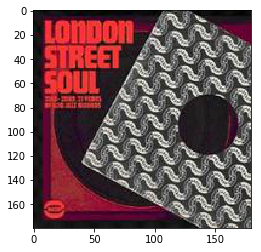

In [16]:
plt.imshow(bx[-1].astype(np.uint8))

In [17]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1          MUSIQUE
category_level2               CD
category_level3    CD JAZZ BLUES
category_idx                3954
Name: 1000018286, dtype: object

In [18]:
%time bx, by = next(val_gen)

Wall time: 172 ms


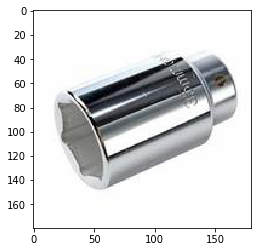

In [19]:
plt.imshow(bx[-1].astype(np.uint8))

In [20]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1           AUTO - MOTO
category_level2             OUTILLAGE
category_level3    DOUILLES - EMBOUTS
category_idx                      619
Name: 1000005633, dtype: object

## 3 Training

Create a very simple Keras model and train it, to test that the generators work.

In [21]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

In [22]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
__________

In [24]:
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,
                    epochs = 1,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,
                    workers = 1)

Epoch 1/1


  193/72518 [..............................] - ETA: 364033s - loss: 16.0981 - acc: 0.0000e+0 - ETA: 206882s - loss: 15.9421 - acc: 0.0000e+0 - ETA: 154476s - loss: 15.8915 - acc: 0.0000e+0 - ETA: 128343s - loss: 15.6434 - acc: 0.0000e+0 - ETA: 112641s - loss: 15.5093 - acc: 0.0047    - ETA: 102246s - loss: 15.2168 - acc: 0.003 - ETA: 94831s - loss: 14.8389 - acc: 0.003 - ETA: 89328s - loss: 14.3478 - acc: 0.00 - ETA: 85190s - loss: 13.8122 - acc: 0.00 - ETA: 81752s - loss: 13.2911 - acc: 0.00 - ETA: 78942s - loss: 12.8516 - acc: 0.00 - ETA: 76594s - loss: 12.4677 - acc: 0.00 - ETA: 74604s - loss: 12.1524 - acc: 0.00 - ETA: 72904s - loss: 11.8612 - acc: 0.00 - ETA: 71448s - loss: 11.6046 - acc: 0.00 - ETA: 70162s - loss: 11.3821 - acc: 0.00 - ETA: 69025s - loss: 11.1877 - acc: 0.00 - ETA: 68004s - loss: 10.9989 - acc: 0.00 - ETA: 67100s - loss: 10.8232 - acc: 0.00 - ETA: 66312s - loss: 10.6728 - acc: 0.00 - ETA: 65570s - loss: 10.5338 - acc: 0.00 - ETA: 64897s - loss: 10.4026 - acc: 0.0

  581/72518 [..............................] - ETA: 51386s - loss: 7.0672 - acc: 0.023 - ETA: 51384s - loss: 7.0650 - acc: 0.023 - ETA: 51381s - loss: 7.0626 - acc: 0.023 - ETA: 51378s - loss: 7.0612 - acc: 0.023 - ETA: 51375s - loss: 7.0603 - acc: 0.023 - ETA: 51372s - loss: 7.0589 - acc: 0.023 - ETA: 51372s - loss: 7.0593 - acc: 0.023 - ETA: 51369s - loss: 7.0579 - acc: 0.023 - ETA: 51366s - loss: 7.0571 - acc: 0.023 - ETA: 51363s - loss: 7.0553 - acc: 0.023 - ETA: 51360s - loss: 7.0545 - acc: 0.023 - ETA: 51357s - loss: 7.0535 - acc: 0.023 - ETA: 51354s - loss: 7.0526 - acc: 0.023 - ETA: 51351s - loss: 7.0519 - acc: 0.023 - ETA: 51349s - loss: 7.0509 - acc: 0.024 - ETA: 51346s - loss: 7.0496 - acc: 0.024 - ETA: 51343s - loss: 7.0487 - acc: 0.024 - ETA: 51340s - loss: 7.0474 - acc: 0.024 - ETA: 51338s - loss: 7.0460 - acc: 0.024 - ETA: 51337s - loss: 7.0446 - acc: 0.024 - ETA: 51334s - loss: 7.0434 - acc: 0.024 - ETA: 51333s - loss: 7.0422 - acc: 0.024 - ETA: 51331s - loss: 7.0411 - 

  775/72518 [..............................] - ETA: 51027s - loss: 6.9057 - acc: 0.031 - ETA: 51025s - loss: 6.9050 - acc: 0.031 - ETA: 51024s - loss: 6.9045 - acc: 0.031 - ETA: 51022s - loss: 6.9036 - acc: 0.031 - ETA: 51021s - loss: 6.9030 - acc: 0.031 - ETA: 51021s - loss: 6.9018 - acc: 0.031 - ETA: 51021s - loss: 6.9008 - acc: 0.031 - ETA: 51021s - loss: 6.9003 - acc: 0.031 - ETA: 51020s - loss: 6.8995 - acc: 0.031 - ETA: 51020s - loss: 6.8994 - acc: 0.031 - ETA: 51018s - loss: 6.8988 - acc: 0.031 - ETA: 51018s - loss: 6.8985 - acc: 0.031 - ETA: 51016s - loss: 6.8976 - acc: 0.031 - ETA: 51014s - loss: 6.8971 - acc: 0.031 - ETA: 51012s - loss: 6.8968 - acc: 0.031 - ETA: 51011s - loss: 6.8960 - acc: 0.031 - ETA: 51009s - loss: 6.8951 - acc: 0.031 - ETA: 51007s - loss: 6.8945 - acc: 0.031 - ETA: 51005s - loss: 6.8939 - acc: 0.031 - ETA: 51003s - loss: 6.8932 - acc: 0.031 - ETA: 51002s - loss: 6.8932 - acc: 0.031 - ETA: 51000s - loss: 6.8929 - acc: 0.031 - ETA: 50999s - loss: 6.8917 - 

  969/72518 [..............................] - ETA: 50746s - loss: 6.7866 - acc: 0.039 - ETA: 50745s - loss: 6.7866 - acc: 0.039 - ETA: 50744s - loss: 6.7859 - acc: 0.039 - ETA: 50742s - loss: 6.7858 - acc: 0.039 - ETA: 50741s - loss: 6.7850 - acc: 0.039 - ETA: 50739s - loss: 6.7842 - acc: 0.039 - ETA: 50738s - loss: 6.7835 - acc: 0.039 - ETA: 50736s - loss: 6.7831 - acc: 0.039 - ETA: 50735s - loss: 6.7833 - acc: 0.039 - ETA: 50734s - loss: 6.7831 - acc: 0.039 - ETA: 50733s - loss: 6.7821 - acc: 0.039 - ETA: 50731s - loss: 6.7815 - acc: 0.039 - ETA: 50731s - loss: 6.7807 - acc: 0.039 - ETA: 50730s - loss: 6.7803 - acc: 0.039 - ETA: 50728s - loss: 6.7798 - acc: 0.039 - ETA: 50727s - loss: 6.7796 - acc: 0.040 - ETA: 50725s - loss: 6.7794 - acc: 0.040 - ETA: 50723s - loss: 6.7790 - acc: 0.040 - ETA: 50722s - loss: 6.7787 - acc: 0.040 - ETA: 50720s - loss: 6.7781 - acc: 0.040 - ETA: 50719s - loss: 6.7773 - acc: 0.040 - ETA: 50717s - loss: 6.7769 - acc: 0.040 - ETA: 50716s - loss: 6.7763 - 

 1163/72518 [..............................] - ETA: 50510s - loss: 6.6854 - acc: 0.048 - ETA: 50509s - loss: 6.6846 - acc: 0.048 - ETA: 50507s - loss: 6.6841 - acc: 0.048 - ETA: 50506s - loss: 6.6836 - acc: 0.048 - ETA: 50505s - loss: 6.6831 - acc: 0.048 - ETA: 50504s - loss: 6.6824 - acc: 0.048 - ETA: 50502s - loss: 6.6822 - acc: 0.048 - ETA: 50501s - loss: 6.6816 - acc: 0.048 - ETA: 50500s - loss: 6.6811 - acc: 0.048 - ETA: 50499s - loss: 6.6805 - acc: 0.049 - ETA: 50499s - loss: 6.6802 - acc: 0.049 - ETA: 50498s - loss: 6.6798 - acc: 0.049 - ETA: 50497s - loss: 6.6795 - acc: 0.049 - ETA: 50496s - loss: 6.6791 - acc: 0.049 - ETA: 50495s - loss: 6.6786 - acc: 0.049 - ETA: 50493s - loss: 6.6780 - acc: 0.049 - ETA: 50492s - loss: 6.6775 - acc: 0.049 - ETA: 50491s - loss: 6.6767 - acc: 0.049 - ETA: 50490s - loss: 6.6765 - acc: 0.049 - ETA: 50489s - loss: 6.6765 - acc: 0.049 - ETA: 50488s - loss: 6.6762 - acc: 0.049 - ETA: 50487s - loss: 6.6756 - acc: 0.049 - ETA: 50486s - loss: 6.6752 - 

 1357/72518 [..............................] - ETA: 50303s - loss: 6.5991 - acc: 0.056 - ETA: 50301s - loss: 6.5984 - acc: 0.056 - ETA: 50300s - loss: 6.5983 - acc: 0.056 - ETA: 50300s - loss: 6.5979 - acc: 0.056 - ETA: 50299s - loss: 6.5973 - acc: 0.056 - ETA: 50297s - loss: 6.5969 - acc: 0.056 - ETA: 50296s - loss: 6.5964 - acc: 0.056 - ETA: 50295s - loss: 6.5960 - acc: 0.056 - ETA: 50294s - loss: 6.5956 - acc: 0.056 - ETA: 50293s - loss: 6.5950 - acc: 0.056 - ETA: 50292s - loss: 6.5948 - acc: 0.056 - ETA: 50291s - loss: 6.5944 - acc: 0.056 - ETA: 50290s - loss: 6.5938 - acc: 0.056 - ETA: 50289s - loss: 6.5936 - acc: 0.056 - ETA: 50288s - loss: 6.5934 - acc: 0.056 - ETA: 50287s - loss: 6.5935 - acc: 0.056 - ETA: 50286s - loss: 6.5930 - acc: 0.056 - ETA: 50285s - loss: 6.5928 - acc: 0.056 - ETA: 50284s - loss: 6.5925 - acc: 0.056 - ETA: 50283s - loss: 6.5923 - acc: 0.057 - ETA: 50282s - loss: 6.5918 - acc: 0.057 - ETA: 50281s - loss: 6.5918 - acc: 0.057 - ETA: 50280s - loss: 6.5912 - 

 1551/72518 [..............................] - ETA: 50132s - loss: 6.5242 - acc: 0.063 - ETA: 50131s - loss: 6.5243 - acc: 0.063 - ETA: 50131s - loss: 6.5241 - acc: 0.063 - ETA: 50130s - loss: 6.5236 - acc: 0.063 - ETA: 50129s - loss: 6.5230 - acc: 0.063 - ETA: 50129s - loss: 6.5224 - acc: 0.063 - ETA: 50128s - loss: 6.5219 - acc: 0.063 - ETA: 50127s - loss: 6.5214 - acc: 0.063 - ETA: 50126s - loss: 6.5213 - acc: 0.063 - ETA: 50126s - loss: 6.5211 - acc: 0.063 - ETA: 50125s - loss: 6.5208 - acc: 0.063 - ETA: 50124s - loss: 6.5204 - acc: 0.064 - ETA: 50124s - loss: 6.5204 - acc: 0.063 - ETA: 50123s - loss: 6.5201 - acc: 0.064 - ETA: 50123s - loss: 6.5197 - acc: 0.064 - ETA: 50122s - loss: 6.5195 - acc: 0.064 - ETA: 50121s - loss: 6.5188 - acc: 0.064 - ETA: 50120s - loss: 6.5185 - acc: 0.064 - ETA: 50120s - loss: 6.5182 - acc: 0.064 - ETA: 50119s - loss: 6.5179 - acc: 0.064 - ETA: 50118s - loss: 6.5178 - acc: 0.064 - ETA: 50118s - loss: 6.5176 - acc: 0.064 - ETA: 50117s - loss: 6.5171 - 

 1745/72518 [..............................] - ETA: 49996s - loss: 6.4594 - acc: 0.069 - ETA: 49995s - loss: 6.4588 - acc: 0.069 - ETA: 49994s - loss: 6.4585 - acc: 0.069 - ETA: 49994s - loss: 6.4583 - acc: 0.069 - ETA: 49993s - loss: 6.4581 - acc: 0.069 - ETA: 49992s - loss: 6.4577 - acc: 0.069 - ETA: 49992s - loss: 6.4576 - acc: 0.069 - ETA: 49991s - loss: 6.4575 - acc: 0.069 - ETA: 49990s - loss: 6.4569 - acc: 0.069 - ETA: 49989s - loss: 6.4564 - acc: 0.069 - ETA: 49989s - loss: 6.4562 - acc: 0.070 - ETA: 49988s - loss: 6.4562 - acc: 0.070 - ETA: 49987s - loss: 6.4560 - acc: 0.070 - ETA: 49987s - loss: 6.4556 - acc: 0.070 - ETA: 49986s - loss: 6.4556 - acc: 0.070 - ETA: 49985s - loss: 6.4550 - acc: 0.070 - ETA: 49985s - loss: 6.4546 - acc: 0.070 - ETA: 49984s - loss: 6.4544 - acc: 0.070 - ETA: 49983s - loss: 6.4541 - acc: 0.070 - ETA: 49982s - loss: 6.4539 - acc: 0.070 - ETA: 49982s - loss: 6.4536 - acc: 0.070 - ETA: 49981s - loss: 6.4532 - acc: 0.070 - ETA: 49980s - loss: 6.4529 - 

 1939/72518 [..............................] - ETA: 49852s - loss: 6.3985 - acc: 0.075 - ETA: 49851s - loss: 6.3982 - acc: 0.075 - ETA: 49851s - loss: 6.3981 - acc: 0.075 - ETA: 49850s - loss: 6.3978 - acc: 0.075 - ETA: 49849s - loss: 6.3976 - acc: 0.075 - ETA: 49848s - loss: 6.3973 - acc: 0.075 - ETA: 49848s - loss: 6.3969 - acc: 0.075 - ETA: 49847s - loss: 6.3968 - acc: 0.075 - ETA: 49846s - loss: 6.3965 - acc: 0.075 - ETA: 49845s - loss: 6.3963 - acc: 0.075 - ETA: 49845s - loss: 6.3958 - acc: 0.075 - ETA: 49844s - loss: 6.3956 - acc: 0.075 - ETA: 49843s - loss: 6.3953 - acc: 0.075 - ETA: 49843s - loss: 6.3952 - acc: 0.075 - ETA: 49842s - loss: 6.3950 - acc: 0.075 - ETA: 49841s - loss: 6.3946 - acc: 0.075 - ETA: 49840s - loss: 6.3943 - acc: 0.075 - ETA: 49840s - loss: 6.3938 - acc: 0.075 - ETA: 49839s - loss: 6.3933 - acc: 0.075 - ETA: 49838s - loss: 6.3926 - acc: 0.076 - ETA: 49838s - loss: 6.3924 - acc: 0.076 - ETA: 49837s - loss: 6.3922 - acc: 0.076 - ETA: 49836s - loss: 6.3920 - 

 2133/72518 [..............................] - ETA: 49700s - loss: 6.3390 - acc: 0.081 - ETA: 49699s - loss: 6.3386 - acc: 0.081 - ETA: 49698s - loss: 6.3382 - acc: 0.081 - ETA: 49698s - loss: 6.3381 - acc: 0.081 - ETA: 49697s - loss: 6.3377 - acc: 0.081 - ETA: 49696s - loss: 6.3375 - acc: 0.081 - ETA: 49696s - loss: 6.3374 - acc: 0.081 - ETA: 49695s - loss: 6.3370 - acc: 0.081 - ETA: 49694s - loss: 6.3367 - acc: 0.081 - ETA: 49694s - loss: 6.3364 - acc: 0.081 - ETA: 49693s - loss: 6.3362 - acc: 0.081 - ETA: 49692s - loss: 6.3358 - acc: 0.081 - ETA: 49691s - loss: 6.3356 - acc: 0.081 - ETA: 49690s - loss: 6.3352 - acc: 0.081 - ETA: 49689s - loss: 6.3348 - acc: 0.081 - ETA: 49689s - loss: 6.3345 - acc: 0.081 - ETA: 49688s - loss: 6.3343 - acc: 0.081 - ETA: 49687s - loss: 6.3341 - acc: 0.081 - ETA: 49686s - loss: 6.3337 - acc: 0.081 - ETA: 49685s - loss: 6.3333 - acc: 0.081 - ETA: 49684s - loss: 6.3331 - acc: 0.081 - ETA: 49683s - loss: 6.3328 - acc: 0.081 - ETA: 49682s - loss: 6.3324 - 

 2327/72518 [..............................] - ETA: 49535s - loss: 6.2845 - acc: 0.086 - ETA: 49534s - loss: 6.2842 - acc: 0.086 - ETA: 49533s - loss: 6.2838 - acc: 0.086 - ETA: 49532s - loss: 6.2834 - acc: 0.087 - ETA: 49532s - loss: 6.2830 - acc: 0.087 - ETA: 49531s - loss: 6.2828 - acc: 0.087 - ETA: 49530s - loss: 6.2826 - acc: 0.087 - ETA: 49529s - loss: 6.2823 - acc: 0.087 - ETA: 49528s - loss: 6.2820 - acc: 0.087 - ETA: 49527s - loss: 6.2817 - acc: 0.087 - ETA: 49526s - loss: 6.2812 - acc: 0.087 - ETA: 49525s - loss: 6.2811 - acc: 0.087 - ETA: 49524s - loss: 6.2807 - acc: 0.087 - ETA: 49523s - loss: 6.2803 - acc: 0.087 - ETA: 49523s - loss: 6.2802 - acc: 0.087 - ETA: 49522s - loss: 6.2802 - acc: 0.087 - ETA: 49521s - loss: 6.2800 - acc: 0.087 - ETA: 49520s - loss: 6.2796 - acc: 0.087 - ETA: 49519s - loss: 6.2791 - acc: 0.087 - ETA: 49518s - loss: 6.2789 - acc: 0.087 - ETA: 49517s - loss: 6.2785 - acc: 0.087 - ETA: 49517s - loss: 6.2781 - acc: 0.087 - ETA: 49516s - loss: 6.2779 - 

 2521/72518 [>.............................] - ETA: 49375s - loss: 6.2338 - acc: 0.092 - ETA: 49374s - loss: 6.2338 - acc: 0.092 - ETA: 49373s - loss: 6.2337 - acc: 0.092 - ETA: 49373s - loss: 6.2334 - acc: 0.092 - ETA: 49372s - loss: 6.2331 - acc: 0.092 - ETA: 49371s - loss: 6.2328 - acc: 0.092 - ETA: 49370s - loss: 6.2325 - acc: 0.092 - ETA: 49370s - loss: 6.2323 - acc: 0.092 - ETA: 49369s - loss: 6.2320 - acc: 0.092 - ETA: 49368s - loss: 6.2318 - acc: 0.092 - ETA: 49367s - loss: 6.2316 - acc: 0.092 - ETA: 49366s - loss: 6.2312 - acc: 0.092 - ETA: 49365s - loss: 6.2312 - acc: 0.092 - ETA: 49364s - loss: 6.2311 - acc: 0.092 - ETA: 49364s - loss: 6.2310 - acc: 0.092 - ETA: 49363s - loss: 6.2309 - acc: 0.092 - ETA: 49362s - loss: 6.2306 - acc: 0.092 - ETA: 49361s - loss: 6.2303 - acc: 0.092 - ETA: 49360s - loss: 6.2301 - acc: 0.092 - ETA: 49360s - loss: 6.2300 - acc: 0.092 - ETA: 49359s - loss: 6.2298 - acc: 0.092 - ETA: 49358s - loss: 6.2295 - acc: 0.092 - ETA: 49357s - loss: 6.2292 - 

 2715/72518 [>.............................] - ETA: 49217s - loss: 6.1874 - acc: 0.096 - ETA: 49216s - loss: 6.1870 - acc: 0.096 - ETA: 49215s - loss: 6.1867 - acc: 0.096 - ETA: 49214s - loss: 6.1864 - acc: 0.096 - ETA: 49213s - loss: 6.1862 - acc: 0.096 - ETA: 49213s - loss: 6.1861 - acc: 0.096 - ETA: 49212s - loss: 6.1858 - acc: 0.096 - ETA: 49211s - loss: 6.1857 - acc: 0.096 - ETA: 49210s - loss: 6.1855 - acc: 0.096 - ETA: 49210s - loss: 6.1852 - acc: 0.096 - ETA: 49209s - loss: 6.1849 - acc: 0.096 - ETA: 49208s - loss: 6.1849 - acc: 0.096 - ETA: 49207s - loss: 6.1846 - acc: 0.096 - ETA: 49207s - loss: 6.1843 - acc: 0.096 - ETA: 49206s - loss: 6.1841 - acc: 0.097 - ETA: 49205s - loss: 6.1839 - acc: 0.097 - ETA: 49204s - loss: 6.1835 - acc: 0.097 - ETA: 49203s - loss: 6.1832 - acc: 0.097 - ETA: 49203s - loss: 6.1829 - acc: 0.097 - ETA: 49202s - loss: 6.1826 - acc: 0.097 - ETA: 49201s - loss: 6.1824 - acc: 0.097 - ETA: 49200s - loss: 6.1822 - acc: 0.097 - ETA: 49199s - loss: 6.1817 - 

 2909/72518 [>.............................] - ETA: 49059s - loss: 6.1411 - acc: 0.101 - ETA: 49058s - loss: 6.1410 - acc: 0.101 - ETA: 49058s - loss: 6.1407 - acc: 0.101 - ETA: 49057s - loss: 6.1405 - acc: 0.101 - ETA: 49056s - loss: 6.1403 - acc: 0.101 - ETA: 49055s - loss: 6.1400 - acc: 0.101 - ETA: 49054s - loss: 6.1398 - acc: 0.101 - ETA: 49054s - loss: 6.1396 - acc: 0.101 - ETA: 49053s - loss: 6.1395 - acc: 0.101 - ETA: 49052s - loss: 6.1393 - acc: 0.101 - ETA: 49051s - loss: 6.1391 - acc: 0.101 - ETA: 49051s - loss: 6.1387 - acc: 0.101 - ETA: 49050s - loss: 6.1383 - acc: 0.101 - ETA: 49049s - loss: 6.1381 - acc: 0.101 - ETA: 49048s - loss: 6.1380 - acc: 0.101 - ETA: 49048s - loss: 6.1375 - acc: 0.101 - ETA: 49047s - loss: 6.1373 - acc: 0.101 - ETA: 49046s - loss: 6.1371 - acc: 0.101 - ETA: 49045s - loss: 6.1367 - acc: 0.101 - ETA: 49044s - loss: 6.1364 - acc: 0.101 - ETA: 49044s - loss: 6.1363 - acc: 0.101 - ETA: 49043s - loss: 6.1362 - acc: 0.101 - ETA: 49042s - loss: 6.1362 - 

 3103/72518 [>.............................] - ETA: 48905s - loss: 6.0988 - acc: 0.105 - ETA: 48904s - loss: 6.0984 - acc: 0.105 - ETA: 48903s - loss: 6.0981 - acc: 0.105 - ETA: 48903s - loss: 6.0980 - acc: 0.105 - ETA: 48902s - loss: 6.0979 - acc: 0.105 - ETA: 48901s - loss: 6.0976 - acc: 0.105 - ETA: 48900s - loss: 6.0975 - acc: 0.105 - ETA: 48900s - loss: 6.0973 - acc: 0.105 - ETA: 48899s - loss: 6.0970 - acc: 0.105 - ETA: 48898s - loss: 6.0966 - acc: 0.105 - ETA: 48897s - loss: 6.0964 - acc: 0.105 - ETA: 48897s - loss: 6.0963 - acc: 0.105 - ETA: 48896s - loss: 6.0962 - acc: 0.105 - ETA: 48895s - loss: 6.0960 - acc: 0.105 - ETA: 48894s - loss: 6.0959 - acc: 0.105 - ETA: 48894s - loss: 6.0957 - acc: 0.105 - ETA: 48893s - loss: 6.0954 - acc: 0.106 - ETA: 48892s - loss: 6.0953 - acc: 0.106 - ETA: 48891s - loss: 6.0951 - acc: 0.106 - ETA: 48890s - loss: 6.0950 - acc: 0.106 - ETA: 48890s - loss: 6.0948 - acc: 0.106 - ETA: 48889s - loss: 6.0946 - acc: 0.106 - ETA: 48888s - loss: 6.0944 - 

 3297/72518 [>.............................] - ETA: 48779s - loss: 6.0617 - acc: 0.109 - ETA: 48778s - loss: 6.0615 - acc: 0.109 - ETA: 48777s - loss: 6.0613 - acc: 0.109 - ETA: 48777s - loss: 6.0610 - acc: 0.109 - ETA: 48776s - loss: 6.0608 - acc: 0.109 - ETA: 48776s - loss: 6.0606 - acc: 0.109 - ETA: 48775s - loss: 6.0603 - acc: 0.109 - ETA: 48775s - loss: 6.0600 - acc: 0.109 - ETA: 48774s - loss: 6.0599 - acc: 0.109 - ETA: 48774s - loss: 6.0598 - acc: 0.109 - ETA: 48773s - loss: 6.0597 - acc: 0.109 - ETA: 48773s - loss: 6.0596 - acc: 0.109 - ETA: 48772s - loss: 6.0594 - acc: 0.109 - ETA: 48772s - loss: 6.0592 - acc: 0.109 - ETA: 48771s - loss: 6.0592 - acc: 0.109 - ETA: 48771s - loss: 6.0590 - acc: 0.109 - ETA: 48770s - loss: 6.0587 - acc: 0.109 - ETA: 48770s - loss: 6.0584 - acc: 0.109 - ETA: 48769s - loss: 6.0583 - acc: 0.109 - ETA: 48768s - loss: 6.0582 - acc: 0.110 - ETA: 48768s - loss: 6.0582 - acc: 0.110 - ETA: 48767s - loss: 6.0581 - acc: 0.110 - ETA: 48767s - loss: 6.0578 - 

 3491/72518 [>.............................] - ETA: 48662s - loss: 6.0236 - acc: 0.113 - ETA: 48662s - loss: 6.0234 - acc: 0.113 - ETA: 48661s - loss: 6.0231 - acc: 0.113 - ETA: 48660s - loss: 6.0232 - acc: 0.113 - ETA: 48660s - loss: 6.0229 - acc: 0.113 - ETA: 48659s - loss: 6.0227 - acc: 0.113 - ETA: 48659s - loss: 6.0224 - acc: 0.113 - ETA: 48658s - loss: 6.0221 - acc: 0.113 - ETA: 48658s - loss: 6.0220 - acc: 0.113 - ETA: 48657s - loss: 6.0218 - acc: 0.113 - ETA: 48656s - loss: 6.0217 - acc: 0.113 - ETA: 48656s - loss: 6.0215 - acc: 0.113 - ETA: 48655s - loss: 6.0212 - acc: 0.113 - ETA: 48655s - loss: 6.0211 - acc: 0.113 - ETA: 48654s - loss: 6.0209 - acc: 0.113 - ETA: 48653s - loss: 6.0209 - acc: 0.113 - ETA: 48653s - loss: 6.0205 - acc: 0.113 - ETA: 48652s - loss: 6.0205 - acc: 0.114 - ETA: 48652s - loss: 6.0203 - acc: 0.114 - ETA: 48651s - loss: 6.0201 - acc: 0.114 - ETA: 48650s - loss: 6.0198 - acc: 0.114 - ETA: 48650s - loss: 6.0197 - acc: 0.114 - ETA: 48649s - loss: 6.0195 - 

 3685/72518 [>.............................] - ETA: 48545s - loss: 5.9893 - acc: 0.117 - ETA: 48545s - loss: 5.9892 - acc: 0.117 - ETA: 48544s - loss: 5.9891 - acc: 0.117 - ETA: 48544s - loss: 5.9889 - acc: 0.117 - ETA: 48543s - loss: 5.9887 - acc: 0.117 - ETA: 48542s - loss: 5.9885 - acc: 0.117 - ETA: 48542s - loss: 5.9884 - acc: 0.117 - ETA: 48541s - loss: 5.9881 - acc: 0.117 - ETA: 48541s - loss: 5.9880 - acc: 0.117 - ETA: 48540s - loss: 5.9878 - acc: 0.117 - ETA: 48540s - loss: 5.9876 - acc: 0.117 - ETA: 48539s - loss: 5.9874 - acc: 0.117 - ETA: 48538s - loss: 5.9872 - acc: 0.117 - ETA: 48538s - loss: 5.9869 - acc: 0.117 - ETA: 48537s - loss: 5.9868 - acc: 0.117 - ETA: 48536s - loss: 5.9867 - acc: 0.117 - ETA: 48536s - loss: 5.9865 - acc: 0.117 - ETA: 48535s - loss: 5.9863 - acc: 0.117 - ETA: 48535s - loss: 5.9862 - acc: 0.117 - ETA: 48534s - loss: 5.9858 - acc: 0.117 - ETA: 48533s - loss: 5.9855 - acc: 0.117 - ETA: 48533s - loss: 5.9853 - acc: 0.117 - ETA: 48532s - loss: 5.9850 - 

 3879/72518 [>.............................] - ETA: 48427s - loss: 5.9562 - acc: 0.120 - ETA: 48426s - loss: 5.9560 - acc: 0.120 - ETA: 48426s - loss: 5.9559 - acc: 0.120 - ETA: 48425s - loss: 5.9557 - acc: 0.120 - ETA: 48425s - loss: 5.9554 - acc: 0.120 - ETA: 48424s - loss: 5.9552 - acc: 0.120 - ETA: 48423s - loss: 5.9550 - acc: 0.120 - ETA: 48423s - loss: 5.9551 - acc: 0.120 - ETA: 48422s - loss: 5.9550 - acc: 0.120 - ETA: 48422s - loss: 5.9549 - acc: 0.120 - ETA: 48421s - loss: 5.9547 - acc: 0.121 - ETA: 48420s - loss: 5.9545 - acc: 0.121 - ETA: 48420s - loss: 5.9543 - acc: 0.121 - ETA: 48419s - loss: 5.9541 - acc: 0.121 - ETA: 48419s - loss: 5.9539 - acc: 0.121 - ETA: 48418s - loss: 5.9537 - acc: 0.121 - ETA: 48418s - loss: 5.9536 - acc: 0.121 - ETA: 48417s - loss: 5.9533 - acc: 0.121 - ETA: 48417s - loss: 5.9532 - acc: 0.121 - ETA: 48416s - loss: 5.9531 - acc: 0.121 - ETA: 48416s - loss: 5.9528 - acc: 0.121 - ETA: 48415s - loss: 5.9526 - acc: 0.121 - ETA: 48415s - loss: 5.9524 - 

 4073/72518 [>.............................] - ETA: 48304s - loss: 5.9234 - acc: 0.124 - ETA: 48303s - loss: 5.9232 - acc: 0.124 - ETA: 48302s - loss: 5.9231 - acc: 0.124 - ETA: 48302s - loss: 5.9229 - acc: 0.124 - ETA: 48301s - loss: 5.9228 - acc: 0.124 - ETA: 48300s - loss: 5.9226 - acc: 0.124 - ETA: 48300s - loss: 5.9223 - acc: 0.124 - ETA: 48299s - loss: 5.9222 - acc: 0.124 - ETA: 48298s - loss: 5.9220 - acc: 0.124 - ETA: 48298s - loss: 5.9219 - acc: 0.124 - ETA: 48297s - loss: 5.9217 - acc: 0.124 - ETA: 48296s - loss: 5.9216 - acc: 0.124 - ETA: 48296s - loss: 5.9213 - acc: 0.124 - ETA: 48295s - loss: 5.9212 - acc: 0.124 - ETA: 48294s - loss: 5.9211 - acc: 0.124 - ETA: 48294s - loss: 5.9208 - acc: 0.124 - ETA: 48293s - loss: 5.9206 - acc: 0.124 - ETA: 48293s - loss: 5.9205 - acc: 0.124 - ETA: 48292s - loss: 5.9203 - acc: 0.124 - ETA: 48292s - loss: 5.9203 - acc: 0.124 - ETA: 48291s - loss: 5.9201 - acc: 0.124 - ETA: 48291s - loss: 5.9200 - acc: 0.124 - ETA: 48290s - loss: 5.9198 - 

 4267/72518 [>.............................] - ETA: 48185s - loss: 5.8926 - acc: 0.127 - ETA: 48184s - loss: 5.8923 - acc: 0.127 - ETA: 48183s - loss: 5.8923 - acc: 0.127 - ETA: 48183s - loss: 5.8921 - acc: 0.127 - ETA: 48182s - loss: 5.8920 - acc: 0.127 - ETA: 48182s - loss: 5.8918 - acc: 0.127 - ETA: 48181s - loss: 5.8917 - acc: 0.127 - ETA: 48180s - loss: 5.8915 - acc: 0.127 - ETA: 48180s - loss: 5.8913 - acc: 0.127 - ETA: 48179s - loss: 5.8912 - acc: 0.127 - ETA: 48179s - loss: 5.8910 - acc: 0.127 - ETA: 48178s - loss: 5.8909 - acc: 0.127 - ETA: 48178s - loss: 5.8908 - acc: 0.127 - ETA: 48177s - loss: 5.8906 - acc: 0.127 - ETA: 48176s - loss: 5.8905 - acc: 0.127 - ETA: 48176s - loss: 5.8903 - acc: 0.127 - ETA: 48175s - loss: 5.8902 - acc: 0.127 - ETA: 48175s - loss: 5.8900 - acc: 0.127 - ETA: 48174s - loss: 5.8899 - acc: 0.127 - ETA: 48173s - loss: 5.8898 - acc: 0.127 - ETA: 48173s - loss: 5.8898 - acc: 0.127 - ETA: 48172s - loss: 5.8895 - acc: 0.127 - ETA: 48171s - loss: 5.8895 - 

 4461/72518 [>.............................] - ETA: 48063s - loss: 5.8651 - acc: 0.130 - ETA: 48062s - loss: 5.8650 - acc: 0.130 - ETA: 48061s - loss: 5.8649 - acc: 0.130 - ETA: 48061s - loss: 5.8648 - acc: 0.130 - ETA: 48060s - loss: 5.8646 - acc: 0.130 - ETA: 48059s - loss: 5.8644 - acc: 0.130 - ETA: 48059s - loss: 5.8641 - acc: 0.130 - ETA: 48058s - loss: 5.8639 - acc: 0.130 - ETA: 48057s - loss: 5.8638 - acc: 0.130 - ETA: 48057s - loss: 5.8638 - acc: 0.130 - ETA: 48056s - loss: 5.8636 - acc: 0.130 - ETA: 48055s - loss: 5.8636 - acc: 0.130 - ETA: 48055s - loss: 5.8635 - acc: 0.130 - ETA: 48054s - loss: 5.8632 - acc: 0.130 - ETA: 48053s - loss: 5.8631 - acc: 0.130 - ETA: 48053s - loss: 5.8630 - acc: 0.130 - ETA: 48052s - loss: 5.8629 - acc: 0.130 - ETA: 48051s - loss: 5.8627 - acc: 0.130 - ETA: 48051s - loss: 5.8626 - acc: 0.130 - ETA: 48050s - loss: 5.8626 - acc: 0.130 - ETA: 48049s - loss: 5.8623 - acc: 0.130 - ETA: 48049s - loss: 5.8622 - acc: 0.130 - ETA: 48048s - loss: 5.8621 - 

 4655/72518 [>.............................] - ETA: 47936s - loss: 5.8382 - acc: 0.132 - ETA: 47935s - loss: 5.8380 - acc: 0.132 - ETA: 47935s - loss: 5.8379 - acc: 0.132 - ETA: 47934s - loss: 5.8376 - acc: 0.133 - ETA: 47933s - loss: 5.8375 - acc: 0.133 - ETA: 47933s - loss: 5.8374 - acc: 0.133 - ETA: 47932s - loss: 5.8373 - acc: 0.133 - ETA: 47931s - loss: 5.8371 - acc: 0.133 - ETA: 47931s - loss: 5.8369 - acc: 0.133 - ETA: 47930s - loss: 5.8368 - acc: 0.133 - ETA: 47929s - loss: 5.8366 - acc: 0.133 - ETA: 47929s - loss: 5.8365 - acc: 0.133 - ETA: 47928s - loss: 5.8363 - acc: 0.133 - ETA: 47927s - loss: 5.8363 - acc: 0.133 - ETA: 47927s - loss: 5.8362 - acc: 0.133 - ETA: 47926s - loss: 5.8362 - acc: 0.133 - ETA: 47926s - loss: 5.8360 - acc: 0.133 - ETA: 47925s - loss: 5.8359 - acc: 0.133 - ETA: 47924s - loss: 5.8356 - acc: 0.133 - ETA: 47924s - loss: 5.8354 - acc: 0.133 - ETA: 47923s - loss: 5.8352 - acc: 0.133 - ETA: 47923s - loss: 5.8351 - acc: 0.133 - ETA: 47922s - loss: 5.8351 - 

 4849/72518 [=>............................] - ETA: 47806s - loss: 5.8118 - acc: 0.135 - ETA: 47805s - loss: 5.8117 - acc: 0.135 - ETA: 47804s - loss: 5.8114 - acc: 0.135 - ETA: 47803s - loss: 5.8113 - acc: 0.135 - ETA: 47803s - loss: 5.8112 - acc: 0.135 - ETA: 47802s - loss: 5.8110 - acc: 0.135 - ETA: 47801s - loss: 5.8109 - acc: 0.135 - ETA: 47801s - loss: 5.8108 - acc: 0.135 - ETA: 47800s - loss: 5.8106 - acc: 0.135 - ETA: 47799s - loss: 5.8105 - acc: 0.135 - ETA: 47798s - loss: 5.8102 - acc: 0.135 - ETA: 47798s - loss: 5.8100 - acc: 0.135 - ETA: 47797s - loss: 5.8099 - acc: 0.135 - ETA: 47796s - loss: 5.8096 - acc: 0.135 - ETA: 47795s - loss: 5.8095 - acc: 0.135 - ETA: 47795s - loss: 5.8094 - acc: 0.135 - ETA: 47794s - loss: 5.8092 - acc: 0.135 - ETA: 47793s - loss: 5.8091 - acc: 0.135 - ETA: 47792s - loss: 5.8089 - acc: 0.135 - ETA: 47792s - loss: 5.8087 - acc: 0.135 - ETA: 47791s - loss: 5.8086 - acc: 0.136 - ETA: 47790s - loss: 5.8085 - acc: 0.136 - ETA: 47789s - loss: 5.8083 - 

 5043/72518 [=>............................] - ETA: 47663s - loss: 5.7870 - acc: 0.138 - ETA: 47663s - loss: 5.7869 - acc: 0.138 - ETA: 47662s - loss: 5.7868 - acc: 0.138 - ETA: 47661s - loss: 5.7867 - acc: 0.138 - ETA: 47660s - loss: 5.7866 - acc: 0.138 - ETA: 47660s - loss: 5.7865 - acc: 0.138 - ETA: 47659s - loss: 5.7863 - acc: 0.138 - ETA: 47658s - loss: 5.7863 - acc: 0.138 - ETA: 47657s - loss: 5.7862 - acc: 0.138 - ETA: 47657s - loss: 5.7860 - acc: 0.138 - ETA: 47656s - loss: 5.7860 - acc: 0.138 - ETA: 47655s - loss: 5.7858 - acc: 0.138 - ETA: 47654s - loss: 5.7858 - acc: 0.138 - ETA: 47654s - loss: 5.7856 - acc: 0.138 - ETA: 47653s - loss: 5.7855 - acc: 0.138 - ETA: 47652s - loss: 5.7855 - acc: 0.138 - ETA: 47652s - loss: 5.7854 - acc: 0.138 - ETA: 47651s - loss: 5.7853 - acc: 0.138 - ETA: 47650s - loss: 5.7851 - acc: 0.138 - ETA: 47649s - loss: 5.7851 - acc: 0.138 - ETA: 47649s - loss: 5.7850 - acc: 0.138 - ETA: 47648s - loss: 5.7850 - acc: 0.138 - ETA: 47647s - loss: 5.7849 - 

 5237/72518 [=>............................] - ETA: 47521s - loss: 5.7632 - acc: 0.140 - ETA: 47520s - loss: 5.7631 - acc: 0.140 - ETA: 47519s - loss: 5.7630 - acc: 0.140 - ETA: 47518s - loss: 5.7630 - acc: 0.140 - ETA: 47518s - loss: 5.7628 - acc: 0.140 - ETA: 47517s - loss: 5.7627 - acc: 0.140 - ETA: 47516s - loss: 5.7627 - acc: 0.140 - ETA: 47516s - loss: 5.7625 - acc: 0.140 - ETA: 47515s - loss: 5.7624 - acc: 0.140 - ETA: 47514s - loss: 5.7623 - acc: 0.140 - ETA: 47514s - loss: 5.7621 - acc: 0.140 - ETA: 47513s - loss: 5.7619 - acc: 0.140 - ETA: 47512s - loss: 5.7618 - acc: 0.140 - ETA: 47511s - loss: 5.7617 - acc: 0.140 - ETA: 47511s - loss: 5.7616 - acc: 0.140 - ETA: 47510s - loss: 5.7616 - acc: 0.140 - ETA: 47509s - loss: 5.7615 - acc: 0.140 - ETA: 47508s - loss: 5.7614 - acc: 0.140 - ETA: 47508s - loss: 5.7613 - acc: 0.140 - ETA: 47507s - loss: 5.7612 - acc: 0.140 - ETA: 47506s - loss: 5.7610 - acc: 0.140 - ETA: 47505s - loss: 5.7609 - acc: 0.140 - ETA: 47505s - loss: 5.7608 - 

 5431/72518 [=>............................] - ETA: 47378s - loss: 5.7393 - acc: 0.143 - ETA: 47377s - loss: 5.7391 - acc: 0.143 - ETA: 47376s - loss: 5.7390 - acc: 0.143 - ETA: 47375s - loss: 5.7389 - acc: 0.143 - ETA: 47375s - loss: 5.7388 - acc: 0.143 - ETA: 47374s - loss: 5.7387 - acc: 0.143 - ETA: 47373s - loss: 5.7385 - acc: 0.143 - ETA: 47373s - loss: 5.7383 - acc: 0.143 - ETA: 47372s - loss: 5.7381 - acc: 0.143 - ETA: 47371s - loss: 5.7380 - acc: 0.143 - ETA: 47370s - loss: 5.7379 - acc: 0.143 - ETA: 47370s - loss: 5.7377 - acc: 0.143 - ETA: 47369s - loss: 5.7377 - acc: 0.143 - ETA: 47368s - loss: 5.7376 - acc: 0.143 - ETA: 47367s - loss: 5.7375 - acc: 0.143 - ETA: 47367s - loss: 5.7373 - acc: 0.143 - ETA: 47366s - loss: 5.7371 - acc: 0.143 - ETA: 47365s - loss: 5.7370 - acc: 0.143 - ETA: 47365s - loss: 5.7368 - acc: 0.143 - ETA: 47364s - loss: 5.7367 - acc: 0.143 - ETA: 47363s - loss: 5.7366 - acc: 0.143 - ETA: 47362s - loss: 5.7363 - acc: 0.143 - ETA: 47362s - loss: 5.7363 - 

 5625/72518 [=>............................] - ETA: 47236s - loss: 5.7162 - acc: 0.145 - ETA: 47235s - loss: 5.7161 - acc: 0.145 - ETA: 47234s - loss: 5.7160 - acc: 0.145 - ETA: 47234s - loss: 5.7159 - acc: 0.145 - ETA: 47233s - loss: 5.7157 - acc: 0.145 - ETA: 47232s - loss: 5.7157 - acc: 0.145 - ETA: 47231s - loss: 5.7155 - acc: 0.145 - ETA: 47231s - loss: 5.7153 - acc: 0.145 - ETA: 47230s - loss: 5.7152 - acc: 0.145 - ETA: 47229s - loss: 5.7151 - acc: 0.145 - ETA: 47228s - loss: 5.7151 - acc: 0.145 - ETA: 47228s - loss: 5.7150 - acc: 0.145 - ETA: 47227s - loss: 5.7148 - acc: 0.145 - ETA: 47226s - loss: 5.7146 - acc: 0.145 - ETA: 47226s - loss: 5.7145 - acc: 0.145 - ETA: 47225s - loss: 5.7144 - acc: 0.145 - ETA: 47224s - loss: 5.7142 - acc: 0.146 - ETA: 47223s - loss: 5.7140 - acc: 0.146 - ETA: 47223s - loss: 5.7138 - acc: 0.146 - ETA: 47222s - loss: 5.7137 - acc: 0.146 - ETA: 47221s - loss: 5.7136 - acc: 0.146 - ETA: 47221s - loss: 5.7134 - acc: 0.146 - ETA: 47220s - loss: 5.7132 - 

 5819/72518 [=>............................] - ETA: 47094s - loss: 5.6933 - acc: 0.148 - ETA: 47093s - loss: 5.6932 - acc: 0.148 - ETA: 47093s - loss: 5.6931 - acc: 0.148 - ETA: 47092s - loss: 5.6931 - acc: 0.148 - ETA: 47091s - loss: 5.6930 - acc: 0.148 - ETA: 47090s - loss: 5.6929 - acc: 0.148 - ETA: 47090s - loss: 5.6928 - acc: 0.148 - ETA: 47089s - loss: 5.6927 - acc: 0.148 - ETA: 47088s - loss: 5.6925 - acc: 0.148 - ETA: 47087s - loss: 5.6925 - acc: 0.148 - ETA: 47087s - loss: 5.6923 - acc: 0.148 - ETA: 47086s - loss: 5.6923 - acc: 0.148 - ETA: 47085s - loss: 5.6922 - acc: 0.148 - ETA: 47085s - loss: 5.6921 - acc: 0.148 - ETA: 47084s - loss: 5.6920 - acc: 0.148 - ETA: 47083s - loss: 5.6919 - acc: 0.148 - ETA: 47082s - loss: 5.6919 - acc: 0.148 - ETA: 47082s - loss: 5.6918 - acc: 0.148 - ETA: 47081s - loss: 5.6917 - acc: 0.148 - ETA: 47080s - loss: 5.6916 - acc: 0.148 - ETA: 47079s - loss: 5.6914 - acc: 0.148 - ETA: 47079s - loss: 5.6914 - acc: 0.148 - ETA: 47078s - loss: 5.6913 - 

 6013/72518 [=>............................] - ETA: 46954s - loss: 5.6745 - acc: 0.150 - ETA: 46953s - loss: 5.6743 - acc: 0.150 - ETA: 46952s - loss: 5.6742 - acc: 0.150 - ETA: 46951s - loss: 5.6740 - acc: 0.150 - ETA: 46951s - loss: 5.6740 - acc: 0.150 - ETA: 46950s - loss: 5.6739 - acc: 0.150 - ETA: 46949s - loss: 5.6738 - acc: 0.150 - ETA: 46948s - loss: 5.6738 - acc: 0.150 - ETA: 46948s - loss: 5.6736 - acc: 0.150 - ETA: 46947s - loss: 5.6736 - acc: 0.150 - ETA: 46946s - loss: 5.6735 - acc: 0.150 - ETA: 46946s - loss: 5.6734 - acc: 0.150 - ETA: 46945s - loss: 5.6732 - acc: 0.150 - ETA: 46944s - loss: 5.6731 - acc: 0.150 - ETA: 46943s - loss: 5.6730 - acc: 0.150 - ETA: 46943s - loss: 5.6729 - acc: 0.150 - ETA: 46942s - loss: 5.6728 - acc: 0.150 - ETA: 46941s - loss: 5.6727 - acc: 0.150 - ETA: 46941s - loss: 5.6726 - acc: 0.150 - ETA: 46940s - loss: 5.6724 - acc: 0.150 - ETA: 46939s - loss: 5.6723 - acc: 0.150 - ETA: 46938s - loss: 5.6722 - acc: 0.150 - ETA: 46938s - loss: 5.6721 - 

 6207/72518 [=>............................] - ETA: 46812s - loss: 5.6544 - acc: 0.152 - ETA: 46812s - loss: 5.6543 - acc: 0.152 - ETA: 46811s - loss: 5.6542 - acc: 0.152 - ETA: 46810s - loss: 5.6541 - acc: 0.152 - ETA: 46809s - loss: 5.6541 - acc: 0.152 - ETA: 46809s - loss: 5.6540 - acc: 0.152 - ETA: 46808s - loss: 5.6540 - acc: 0.152 - ETA: 46807s - loss: 5.6539 - acc: 0.152 - ETA: 46807s - loss: 5.6537 - acc: 0.152 - ETA: 46806s - loss: 5.6536 - acc: 0.152 - ETA: 46805s - loss: 5.6535 - acc: 0.152 - ETA: 46804s - loss: 5.6535 - acc: 0.152 - ETA: 46804s - loss: 5.6534 - acc: 0.152 - ETA: 46803s - loss: 5.6533 - acc: 0.152 - ETA: 46802s - loss: 5.6533 - acc: 0.152 - ETA: 46802s - loss: 5.6532 - acc: 0.152 - ETA: 46801s - loss: 5.6531 - acc: 0.152 - ETA: 46800s - loss: 5.6530 - acc: 0.152 - ETA: 46799s - loss: 5.6529 - acc: 0.152 - ETA: 46799s - loss: 5.6528 - acc: 0.152 - ETA: 46798s - loss: 5.6528 - acc: 0.152 - ETA: 46797s - loss: 5.6526 - acc: 0.152 - ETA: 46796s - loss: 5.6525 - 

 6401/72518 [=>............................] - ETA: 46671s - loss: 5.6358 - acc: 0.154 - ETA: 46670s - loss: 5.6356 - acc: 0.154 - ETA: 46670s - loss: 5.6356 - acc: 0.154 - ETA: 46669s - loss: 5.6355 - acc: 0.154 - ETA: 46668s - loss: 5.6354 - acc: 0.154 - ETA: 46667s - loss: 5.6352 - acc: 0.154 - ETA: 46667s - loss: 5.6350 - acc: 0.154 - ETA: 46666s - loss: 5.6349 - acc: 0.154 - ETA: 46665s - loss: 5.6349 - acc: 0.154 - ETA: 46665s - loss: 5.6348 - acc: 0.154 - ETA: 46664s - loss: 5.6347 - acc: 0.154 - ETA: 46663s - loss: 5.6347 - acc: 0.154 - ETA: 46662s - loss: 5.6345 - acc: 0.154 - ETA: 46662s - loss: 5.6345 - acc: 0.154 - ETA: 46661s - loss: 5.6344 - acc: 0.154 - ETA: 46660s - loss: 5.6343 - acc: 0.154 - ETA: 46659s - loss: 5.6342 - acc: 0.154 - ETA: 46659s - loss: 5.6341 - acc: 0.154 - ETA: 46658s - loss: 5.6340 - acc: 0.154 - ETA: 46657s - loss: 5.6340 - acc: 0.154 - ETA: 46657s - loss: 5.6339 - acc: 0.154 - ETA: 46656s - loss: 5.6339 - acc: 0.154 - ETA: 46655s - loss: 5.6338 - 

 6595/72518 [=>............................] - ETA: 46538s - loss: 5.6170 - acc: 0.156 - ETA: 46537s - loss: 5.6169 - acc: 0.156 - ETA: 46537s - loss: 5.6167 - acc: 0.156 - ETA: 46536s - loss: 5.6166 - acc: 0.156 - ETA: 46535s - loss: 5.6165 - acc: 0.156 - ETA: 46535s - loss: 5.6164 - acc: 0.156 - ETA: 46534s - loss: 5.6162 - acc: 0.156 - ETA: 46533s - loss: 5.6160 - acc: 0.156 - ETA: 46532s - loss: 5.6160 - acc: 0.156 - ETA: 46532s - loss: 5.6159 - acc: 0.156 - ETA: 46531s - loss: 5.6158 - acc: 0.156 - ETA: 46530s - loss: 5.6157 - acc: 0.156 - ETA: 46530s - loss: 5.6157 - acc: 0.156 - ETA: 46529s - loss: 5.6156 - acc: 0.156 - ETA: 46529s - loss: 5.6155 - acc: 0.156 - ETA: 46528s - loss: 5.6155 - acc: 0.156 - ETA: 46527s - loss: 5.6154 - acc: 0.156 - ETA: 46526s - loss: 5.6154 - acc: 0.156 - ETA: 46526s - loss: 5.6153 - acc: 0.156 - ETA: 46525s - loss: 5.6152 - acc: 0.156 - ETA: 46524s - loss: 5.6150 - acc: 0.156 - ETA: 46524s - loss: 5.6150 - acc: 0.156 - ETA: 46523s - loss: 5.6149 - 

 6789/72518 [=>............................] - ETA: 46407s - loss: 5.5988 - acc: 0.158 - ETA: 46406s - loss: 5.5988 - acc: 0.158 - ETA: 46405s - loss: 5.5986 - acc: 0.158 - ETA: 46405s - loss: 5.5985 - acc: 0.158 - ETA: 46404s - loss: 5.5985 - acc: 0.158 - ETA: 46403s - loss: 5.5984 - acc: 0.158 - ETA: 46403s - loss: 5.5984 - acc: 0.158 - ETA: 46402s - loss: 5.5983 - acc: 0.158 - ETA: 46401s - loss: 5.5982 - acc: 0.158 - ETA: 46401s - loss: 5.5982 - acc: 0.158 - ETA: 46400s - loss: 5.5981 - acc: 0.158 - ETA: 46399s - loss: 5.5979 - acc: 0.158 - ETA: 46399s - loss: 5.5979 - acc: 0.158 - ETA: 46398s - loss: 5.5978 - acc: 0.158 - ETA: 46397s - loss: 5.5976 - acc: 0.158 - ETA: 46397s - loss: 5.5975 - acc: 0.158 - ETA: 46396s - loss: 5.5975 - acc: 0.158 - ETA: 46395s - loss: 5.5974 - acc: 0.158 - ETA: 46395s - loss: 5.5973 - acc: 0.158 - ETA: 46394s - loss: 5.5972 - acc: 0.158 - ETA: 46393s - loss: 5.5970 - acc: 0.158 - ETA: 46393s - loss: 5.5969 - acc: 0.158 - ETA: 46392s - loss: 5.5968 - 

 6983/72518 [=>............................] - ETA: 46276s - loss: 5.5811 - acc: 0.160 - ETA: 46275s - loss: 5.5811 - acc: 0.160 - ETA: 46274s - loss: 5.5810 - acc: 0.160 - ETA: 46274s - loss: 5.5809 - acc: 0.160 - ETA: 46273s - loss: 5.5808 - acc: 0.160 - ETA: 46272s - loss: 5.5807 - acc: 0.160 - ETA: 46272s - loss: 5.5806 - acc: 0.160 - ETA: 46271s - loss: 5.5804 - acc: 0.160 - ETA: 46270s - loss: 5.5804 - acc: 0.160 - ETA: 46270s - loss: 5.5803 - acc: 0.160 - ETA: 46269s - loss: 5.5801 - acc: 0.160 - ETA: 46268s - loss: 5.5801 - acc: 0.160 - ETA: 46268s - loss: 5.5800 - acc: 0.160 - ETA: 46267s - loss: 5.5799 - acc: 0.160 - ETA: 46266s - loss: 5.5798 - acc: 0.160 - ETA: 46266s - loss: 5.5798 - acc: 0.160 - ETA: 46265s - loss: 5.5797 - acc: 0.160 - ETA: 46264s - loss: 5.5796 - acc: 0.160 - ETA: 46263s - loss: 5.5795 - acc: 0.160 - ETA: 46263s - loss: 5.5796 - acc: 0.160 - ETA: 46262s - loss: 5.5795 - acc: 0.160 - ETA: 46261s - loss: 5.5794 - acc: 0.160 - ETA: 46261s - loss: 5.5793 - 

 7177/72518 [=>............................] - ETA: 46145s - loss: 5.5629 - acc: 0.161 - ETA: 46145s - loss: 5.5628 - acc: 0.161 - ETA: 46144s - loss: 5.5627 - acc: 0.161 - ETA: 46143s - loss: 5.5627 - acc: 0.161 - ETA: 46143s - loss: 5.5626 - acc: 0.161 - ETA: 46142s - loss: 5.5625 - acc: 0.161 - ETA: 46141s - loss: 5.5624 - acc: 0.161 - ETA: 46141s - loss: 5.5624 - acc: 0.161 - ETA: 46140s - loss: 5.5623 - acc: 0.161 - ETA: 46140s - loss: 5.5622 - acc: 0.161 - ETA: 46139s - loss: 5.5621 - acc: 0.161 - ETA: 46138s - loss: 5.5621 - acc: 0.162 - ETA: 46138s - loss: 5.5619 - acc: 0.162 - ETA: 46137s - loss: 5.5618 - acc: 0.162 - ETA: 46136s - loss: 5.5617 - acc: 0.162 - ETA: 46136s - loss: 5.5616 - acc: 0.162 - ETA: 46135s - loss: 5.5614 - acc: 0.162 - ETA: 46134s - loss: 5.5613 - acc: 0.162 - ETA: 46134s - loss: 5.5612 - acc: 0.162 - ETA: 46133s - loss: 5.5612 - acc: 0.162 - ETA: 46132s - loss: 5.5610 - acc: 0.162 - ETA: 46132s - loss: 5.5609 - acc: 0.162 - ETA: 46131s - loss: 5.5608 - 

 7371/72518 [==>...........................] - ETA: 46015s - loss: 5.5458 - acc: 0.163 - ETA: 46014s - loss: 5.5457 - acc: 0.163 - ETA: 46014s - loss: 5.5455 - acc: 0.163 - ETA: 46013s - loss: 5.5454 - acc: 0.163 - ETA: 46012s - loss: 5.5454 - acc: 0.163 - ETA: 46012s - loss: 5.5453 - acc: 0.163 - ETA: 46011s - loss: 5.5452 - acc: 0.163 - ETA: 46010s - loss: 5.5453 - acc: 0.163 - ETA: 46010s - loss: 5.5452 - acc: 0.163 - ETA: 46009s - loss: 5.5451 - acc: 0.163 - ETA: 46008s - loss: 5.5450 - acc: 0.163 - ETA: 46008s - loss: 5.5450 - acc: 0.163 - ETA: 46007s - loss: 5.5449 - acc: 0.163 - ETA: 46007s - loss: 5.5448 - acc: 0.163 - ETA: 46006s - loss: 5.5447 - acc: 0.163 - ETA: 46005s - loss: 5.5446 - acc: 0.163 - ETA: 46005s - loss: 5.5446 - acc: 0.163 - ETA: 46004s - loss: 5.5445 - acc: 0.163 - ETA: 46003s - loss: 5.5444 - acc: 0.163 - ETA: 46003s - loss: 5.5443 - acc: 0.163 - ETA: 46002s - loss: 5.5443 - acc: 0.163 - ETA: 46001s - loss: 5.5441 - acc: 0.163 - ETA: 46001s - loss: 5.5441 - 

 7565/72518 [==>...........................] - ETA: 45885s - loss: 5.5296 - acc: 0.165 - ETA: 45885s - loss: 5.5295 - acc: 0.165 - ETA: 45884s - loss: 5.5294 - acc: 0.165 - ETA: 45883s - loss: 5.5293 - acc: 0.165 - ETA: 45883s - loss: 5.5291 - acc: 0.165 - ETA: 45882s - loss: 5.5291 - acc: 0.165 - ETA: 45881s - loss: 5.5289 - acc: 0.165 - ETA: 45881s - loss: 5.5289 - acc: 0.165 - ETA: 45880s - loss: 5.5288 - acc: 0.165 - ETA: 45879s - loss: 5.5288 - acc: 0.165 - ETA: 45879s - loss: 5.5287 - acc: 0.165 - ETA: 45878s - loss: 5.5286 - acc: 0.165 - ETA: 45877s - loss: 5.5285 - acc: 0.165 - ETA: 45877s - loss: 5.5285 - acc: 0.165 - ETA: 45876s - loss: 5.5284 - acc: 0.165 - ETA: 45875s - loss: 5.5283 - acc: 0.165 - ETA: 45875s - loss: 5.5283 - acc: 0.165 - ETA: 45874s - loss: 5.5281 - acc: 0.165 - ETA: 45873s - loss: 5.5281 - acc: 0.165 - ETA: 45873s - loss: 5.5280 - acc: 0.165 - ETA: 45872s - loss: 5.5279 - acc: 0.165 - ETA: 45872s - loss: 5.5279 - acc: 0.165 - ETA: 45871s - loss: 5.5278 - 

 7759/72518 [==>...........................] - ETA: 45755s - loss: 5.5138 - acc: 0.167 - ETA: 45754s - loss: 5.5137 - acc: 0.167 - ETA: 45753s - loss: 5.5137 - acc: 0.167 - ETA: 45753s - loss: 5.5136 - acc: 0.167 - ETA: 45752s - loss: 5.5135 - acc: 0.167 - ETA: 45752s - loss: 5.5135 - acc: 0.167 - ETA: 45751s - loss: 5.5134 - acc: 0.167 - ETA: 45750s - loss: 5.5132 - acc: 0.167 - ETA: 45749s - loss: 5.5132 - acc: 0.167 - ETA: 45749s - loss: 5.5131 - acc: 0.167 - ETA: 45748s - loss: 5.5131 - acc: 0.167 - ETA: 45747s - loss: 5.5129 - acc: 0.167 - ETA: 45747s - loss: 5.5129 - acc: 0.167 - ETA: 45746s - loss: 5.5128 - acc: 0.167 - ETA: 45745s - loss: 5.5128 - acc: 0.167 - ETA: 45745s - loss: 5.5127 - acc: 0.167 - ETA: 45744s - loss: 5.5126 - acc: 0.167 - ETA: 45743s - loss: 5.5125 - acc: 0.167 - ETA: 45743s - loss: 5.5123 - acc: 0.167 - ETA: 45742s - loss: 5.5122 - acc: 0.167 - ETA: 45741s - loss: 5.5122 - acc: 0.167 - ETA: 45741s - loss: 5.5121 - acc: 0.167 - ETA: 45740s - loss: 5.5120 - 

 7953/72518 [==>...........................] - ETA: 45622s - loss: 5.5010 - acc: 0.168 - ETA: 45621s - loss: 5.5009 - acc: 0.168 - ETA: 45621s - loss: 5.5010 - acc: 0.168 - ETA: 45620s - loss: 5.5009 - acc: 0.168 - ETA: 45619s - loss: 5.5008 - acc: 0.168 - ETA: 45619s - loss: 5.5007 - acc: 0.168 - ETA: 45618s - loss: 5.5007 - acc: 0.168 - ETA: 45617s - loss: 5.5006 - acc: 0.168 - ETA: 45617s - loss: 5.5005 - acc: 0.168 - ETA: 45616s - loss: 5.5005 - acc: 0.168 - ETA: 45615s - loss: 5.5003 - acc: 0.168 - ETA: 45615s - loss: 5.5002 - acc: 0.168 - ETA: 45614s - loss: 5.5001 - acc: 0.168 - ETA: 45613s - loss: 5.5000 - acc: 0.168 - ETA: 45612s - loss: 5.5000 - acc: 0.168 - ETA: 45612s - loss: 5.4999 - acc: 0.168 - ETA: 45611s - loss: 5.4999 - acc: 0.168 - ETA: 45610s - loss: 5.4998 - acc: 0.168 - ETA: 45610s - loss: 5.4998 - acc: 0.168 - ETA: 45609s - loss: 5.4997 - acc: 0.168 - ETA: 45608s - loss: 5.4997 - acc: 0.168 - ETA: 45608s - loss: 5.4997 - acc: 0.168 - ETA: 45607s - loss: 5.4996 - 

 8147/72518 [==>...........................] - ETA: 45491s - loss: 5.4868 - acc: 0.170 - ETA: 45491s - loss: 5.4867 - acc: 0.170 - ETA: 45490s - loss: 5.4867 - acc: 0.170 - ETA: 45489s - loss: 5.4867 - acc: 0.170 - ETA: 45489s - loss: 5.4866 - acc: 0.170 - ETA: 45488s - loss: 5.4865 - acc: 0.170 - ETA: 45487s - loss: 5.4865 - acc: 0.170 - ETA: 45487s - loss: 5.4864 - acc: 0.170 - ETA: 45486s - loss: 5.4864 - acc: 0.170 - ETA: 45485s - loss: 5.4863 - acc: 0.170 - ETA: 45485s - loss: 5.4863 - acc: 0.170 - ETA: 45484s - loss: 5.4862 - acc: 0.170 - ETA: 45483s - loss: 5.4861 - acc: 0.170 - ETA: 45483s - loss: 5.4860 - acc: 0.170 - ETA: 45482s - loss: 5.4860 - acc: 0.170 - ETA: 45481s - loss: 5.4859 - acc: 0.170 - ETA: 45480s - loss: 5.4859 - acc: 0.170 - ETA: 45480s - loss: 5.4858 - acc: 0.170 - ETA: 45479s - loss: 5.4857 - acc: 0.170 - ETA: 45478s - loss: 5.4856 - acc: 0.170 - ETA: 45478s - loss: 5.4856 - acc: 0.170 - ETA: 45477s - loss: 5.4855 - acc: 0.170 - ETA: 45476s - loss: 5.4854 - 

 8341/72518 [==>...........................] - ETA: 45358s - loss: 5.4717 - acc: 0.171 - ETA: 45357s - loss: 5.4716 - acc: 0.171 - ETA: 45356s - loss: 5.4716 - acc: 0.171 - ETA: 45356s - loss: 5.4714 - acc: 0.171 - ETA: 45355s - loss: 5.4714 - acc: 0.171 - ETA: 45354s - loss: 5.4713 - acc: 0.171 - ETA: 45353s - loss: 5.4712 - acc: 0.171 - ETA: 45353s - loss: 5.4712 - acc: 0.171 - ETA: 45352s - loss: 5.4711 - acc: 0.171 - ETA: 45351s - loss: 5.4710 - acc: 0.171 - ETA: 45351s - loss: 5.4710 - acc: 0.171 - ETA: 45350s - loss: 5.4710 - acc: 0.171 - ETA: 45349s - loss: 5.4708 - acc: 0.171 - ETA: 45349s - loss: 5.4708 - acc: 0.171 - ETA: 45348s - loss: 5.4708 - acc: 0.171 - ETA: 45347s - loss: 5.4707 - acc: 0.171 - ETA: 45347s - loss: 5.4706 - acc: 0.171 - ETA: 45346s - loss: 5.4705 - acc: 0.171 - ETA: 45345s - loss: 5.4704 - acc: 0.171 - ETA: 45344s - loss: 5.4703 - acc: 0.171 - ETA: 45344s - loss: 5.4703 - acc: 0.171 - ETA: 45343s - loss: 5.4702 - acc: 0.171 - ETA: 45342s - loss: 5.4701 - 

 8535/72518 [==>...........................] - ETA: 45229s - loss: 5.4573 - acc: 0.173 - ETA: 45228s - loss: 5.4572 - acc: 0.173 - ETA: 45228s - loss: 5.4571 - acc: 0.173 - ETA: 45227s - loss: 5.4570 - acc: 0.173 - ETA: 45226s - loss: 5.4570 - acc: 0.173 - ETA: 45226s - loss: 5.4569 - acc: 0.173 - ETA: 45225s - loss: 5.4569 - acc: 0.173 - ETA: 45224s - loss: 5.4568 - acc: 0.173 - ETA: 45224s - loss: 5.4567 - acc: 0.173 - ETA: 45223s - loss: 5.4566 - acc: 0.173 - ETA: 45222s - loss: 5.4566 - acc: 0.173 - ETA: 45222s - loss: 5.4564 - acc: 0.173 - ETA: 45221s - loss: 5.4563 - acc: 0.173 - ETA: 45220s - loss: 5.4562 - acc: 0.173 - ETA: 45220s - loss: 5.4562 - acc: 0.173 - ETA: 45219s - loss: 5.4561 - acc: 0.173 - ETA: 45218s - loss: 5.4561 - acc: 0.173 - ETA: 45217s - loss: 5.4560 - acc: 0.173 - ETA: 45217s - loss: 5.4559 - acc: 0.173 - ETA: 45216s - loss: 5.4558 - acc: 0.173 - ETA: 45215s - loss: 5.4557 - acc: 0.173 - ETA: 45215s - loss: 5.4557 - acc: 0.173 - ETA: 45214s - loss: 5.4556 - 

 8729/72518 [==>...........................] - ETA: 45101s - loss: 5.4427 - acc: 0.175 - ETA: 45101s - loss: 5.4426 - acc: 0.175 - ETA: 45100s - loss: 5.4426 - acc: 0.175 - ETA: 45099s - loss: 5.4425 - acc: 0.175 - ETA: 45099s - loss: 5.4424 - acc: 0.175 - ETA: 45098s - loss: 5.4423 - acc: 0.175 - ETA: 45097s - loss: 5.4423 - acc: 0.175 - ETA: 45097s - loss: 5.4422 - acc: 0.175 - ETA: 45096s - loss: 5.4422 - acc: 0.175 - ETA: 45095s - loss: 5.4421 - acc: 0.175 - ETA: 45095s - loss: 5.4420 - acc: 0.175 - ETA: 45094s - loss: 5.4420 - acc: 0.175 - ETA: 45093s - loss: 5.4419 - acc: 0.175 - ETA: 45093s - loss: 5.4418 - acc: 0.175 - ETA: 45092s - loss: 5.4418 - acc: 0.175 - ETA: 45091s - loss: 5.4417 - acc: 0.175 - ETA: 45091s - loss: 5.4416 - acc: 0.175 - ETA: 45090s - loss: 5.4414 - acc: 0.175 - ETA: 45090s - loss: 5.4414 - acc: 0.175 - ETA: 45089s - loss: 5.4413 - acc: 0.175 - ETA: 45088s - loss: 5.4412 - acc: 0.175 - ETA: 45088s - loss: 5.4411 - acc: 0.175 - ETA: 45087s - loss: 5.4410 - 

 8923/72518 [==>...........................] - ETA: 44974s - loss: 5.4290 - acc: 0.176 - ETA: 44973s - loss: 5.4289 - acc: 0.176 - ETA: 44973s - loss: 5.4289 - acc: 0.176 - ETA: 44972s - loss: 5.4288 - acc: 0.176 - ETA: 44971s - loss: 5.4287 - acc: 0.176 - ETA: 44971s - loss: 5.4286 - acc: 0.176 - ETA: 44970s - loss: 5.4286 - acc: 0.176 - ETA: 44970s - loss: 5.4285 - acc: 0.176 - ETA: 44969s - loss: 5.4284 - acc: 0.176 - ETA: 44968s - loss: 5.4284 - acc: 0.176 - ETA: 44967s - loss: 5.4283 - acc: 0.176 - ETA: 44967s - loss: 5.4283 - acc: 0.176 - ETA: 44966s - loss: 5.4282 - acc: 0.176 - ETA: 44966s - loss: 5.4281 - acc: 0.176 - ETA: 44965s - loss: 5.4280 - acc: 0.176 - ETA: 44964s - loss: 5.4279 - acc: 0.176 - ETA: 44964s - loss: 5.4279 - acc: 0.176 - ETA: 44963s - loss: 5.4278 - acc: 0.176 - ETA: 44962s - loss: 5.4278 - acc: 0.176 - ETA: 44962s - loss: 5.4277 - acc: 0.176 - ETA: 44961s - loss: 5.4276 - acc: 0.176 - ETA: 44960s - loss: 5.4276 - acc: 0.176 - ETA: 44959s - loss: 5.4275 - 

 9117/72518 [==>...........................] - ETA: 44842s - loss: 5.4159 - acc: 0.178 - ETA: 44841s - loss: 5.4159 - acc: 0.178 - ETA: 44841s - loss: 5.4158 - acc: 0.178 - ETA: 44840s - loss: 5.4157 - acc: 0.178 - ETA: 44839s - loss: 5.4156 - acc: 0.178 - ETA: 44839s - loss: 5.4155 - acc: 0.178 - ETA: 44838s - loss: 5.4155 - acc: 0.178 - ETA: 44837s - loss: 5.4154 - acc: 0.178 - ETA: 44837s - loss: 5.4154 - acc: 0.178 - ETA: 44836s - loss: 5.4153 - acc: 0.178 - ETA: 44835s - loss: 5.4152 - acc: 0.178 - ETA: 44835s - loss: 5.4151 - acc: 0.178 - ETA: 44834s - loss: 5.4150 - acc: 0.178 - ETA: 44833s - loss: 5.4150 - acc: 0.178 - ETA: 44832s - loss: 5.4149 - acc: 0.178 - ETA: 44832s - loss: 5.4149 - acc: 0.178 - ETA: 44831s - loss: 5.4148 - acc: 0.178 - ETA: 44830s - loss: 5.4147 - acc: 0.178 - ETA: 44830s - loss: 5.4146 - acc: 0.178 - ETA: 44829s - loss: 5.4145 - acc: 0.178 - ETA: 44828s - loss: 5.4144 - acc: 0.178 - ETA: 44828s - loss: 5.4143 - acc: 0.178 - ETA: 44827s - loss: 5.4142 - 

 9311/72518 [==>...........................] - ETA: 44709s - loss: 5.4044 - acc: 0.179 - ETA: 44708s - loss: 5.4043 - acc: 0.179 - ETA: 44708s - loss: 5.4042 - acc: 0.179 - ETA: 44707s - loss: 5.4041 - acc: 0.179 - ETA: 44706s - loss: 5.4041 - acc: 0.179 - ETA: 44706s - loss: 5.4041 - acc: 0.179 - ETA: 44705s - loss: 5.4040 - acc: 0.179 - ETA: 44704s - loss: 5.4039 - acc: 0.179 - ETA: 44704s - loss: 5.4038 - acc: 0.179 - ETA: 44703s - loss: 5.4037 - acc: 0.179 - ETA: 44702s - loss: 5.4036 - acc: 0.179 - ETA: 44702s - loss: 5.4035 - acc: 0.179 - ETA: 44701s - loss: 5.4034 - acc: 0.179 - ETA: 44700s - loss: 5.4034 - acc: 0.179 - ETA: 44700s - loss: 5.4034 - acc: 0.179 - ETA: 44699s - loss: 5.4033 - acc: 0.179 - ETA: 44698s - loss: 5.4033 - acc: 0.179 - ETA: 44698s - loss: 5.4033 - acc: 0.179 - ETA: 44697s - loss: 5.4031 - acc: 0.179 - ETA: 44696s - loss: 5.4031 - acc: 0.179 - ETA: 44696s - loss: 5.4030 - acc: 0.179 - ETA: 44695s - loss: 5.4029 - acc: 0.179 - ETA: 44694s - loss: 5.4029 - 

 9505/72518 [==>...........................] - ETA: 44576s - loss: 5.3916 - acc: 0.180 - ETA: 44575s - loss: 5.3915 - acc: 0.180 - ETA: 44575s - loss: 5.3915 - acc: 0.180 - ETA: 44574s - loss: 5.3914 - acc: 0.180 - ETA: 44573s - loss: 5.3913 - acc: 0.180 - ETA: 44572s - loss: 5.3912 - acc: 0.180 - ETA: 44572s - loss: 5.3911 - acc: 0.180 - ETA: 44571s - loss: 5.3911 - acc: 0.180 - ETA: 44570s - loss: 5.3910 - acc: 0.180 - ETA: 44570s - loss: 5.3909 - acc: 0.180 - ETA: 44569s - loss: 5.3908 - acc: 0.180 - ETA: 44568s - loss: 5.3908 - acc: 0.180 - ETA: 44568s - loss: 5.3907 - acc: 0.180 - ETA: 44567s - loss: 5.3906 - acc: 0.180 - ETA: 44566s - loss: 5.3906 - acc: 0.180 - ETA: 44566s - loss: 5.3905 - acc: 0.180 - ETA: 44565s - loss: 5.3904 - acc: 0.181 - ETA: 44564s - loss: 5.3903 - acc: 0.181 - ETA: 44564s - loss: 5.3903 - acc: 0.181 - ETA: 44563s - loss: 5.3902 - acc: 0.181 - ETA: 44562s - loss: 5.3902 - acc: 0.181 - ETA: 44562s - loss: 5.3902 - acc: 0.181 - ETA: 44561s - loss: 5.3901 - 

 9699/72518 [===>..........................] - ETA: 44442s - loss: 5.3788 - acc: 0.182 - ETA: 44442s - loss: 5.3788 - acc: 0.182 - ETA: 44441s - loss: 5.3787 - acc: 0.182 - ETA: 44440s - loss: 5.3786 - acc: 0.182 - ETA: 44440s - loss: 5.3786 - acc: 0.182 - ETA: 44439s - loss: 5.3786 - acc: 0.182 - ETA: 44438s - loss: 5.3786 - acc: 0.182 - ETA: 44438s - loss: 5.3785 - acc: 0.182 - ETA: 44437s - loss: 5.3785 - acc: 0.182 - ETA: 44436s - loss: 5.3784 - acc: 0.182 - ETA: 44436s - loss: 5.3784 - acc: 0.182 - ETA: 44435s - loss: 5.3784 - acc: 0.182 - ETA: 44434s - loss: 5.3783 - acc: 0.182 - ETA: 44433s - loss: 5.3783 - acc: 0.182 - ETA: 44433s - loss: 5.3782 - acc: 0.182 - ETA: 44432s - loss: 5.3781 - acc: 0.182 - ETA: 44431s - loss: 5.3781 - acc: 0.182 - ETA: 44431s - loss: 5.3780 - acc: 0.182 - ETA: 44430s - loss: 5.3779 - acc: 0.182 - ETA: 44429s - loss: 5.3779 - acc: 0.182 - ETA: 44429s - loss: 5.3778 - acc: 0.182 - ETA: 44428s - loss: 5.3777 - acc: 0.182 - ETA: 44427s - loss: 5.3777 - 

 9893/72518 [===>..........................] - ETA: 44309s - loss: 5.3667 - acc: 0.183 - ETA: 44308s - loss: 5.3667 - acc: 0.183 - ETA: 44308s - loss: 5.3666 - acc: 0.183 - ETA: 44307s - loss: 5.3666 - acc: 0.183 - ETA: 44306s - loss: 5.3665 - acc: 0.183 - ETA: 44305s - loss: 5.3664 - acc: 0.183 - ETA: 44305s - loss: 5.3663 - acc: 0.183 - ETA: 44304s - loss: 5.3662 - acc: 0.183 - ETA: 44303s - loss: 5.3662 - acc: 0.183 - ETA: 44303s - loss: 5.3661 - acc: 0.183 - ETA: 44302s - loss: 5.3660 - acc: 0.183 - ETA: 44301s - loss: 5.3660 - acc: 0.183 - ETA: 44301s - loss: 5.3659 - acc: 0.183 - ETA: 44300s - loss: 5.3658 - acc: 0.183 - ETA: 44299s - loss: 5.3658 - acc: 0.183 - ETA: 44299s - loss: 5.3657 - acc: 0.183 - ETA: 44298s - loss: 5.3656 - acc: 0.183 - ETA: 44297s - loss: 5.3656 - acc: 0.183 - ETA: 44297s - loss: 5.3655 - acc: 0.183 - ETA: 44296s - loss: 5.3654 - acc: 0.183 - ETA: 44295s - loss: 5.3654 - acc: 0.183 - ETA: 44294s - loss: 5.3654 - acc: 0.183 - ETA: 44294s - loss: 5.3653 - 

10087/72518 [===>..........................] - ETA: 44175s - loss: 5.3550 - acc: 0.184 - ETA: 44174s - loss: 5.3549 - acc: 0.184 - ETA: 44173s - loss: 5.3549 - acc: 0.184 - ETA: 44173s - loss: 5.3548 - acc: 0.184 - ETA: 44172s - loss: 5.3548 - acc: 0.184 - ETA: 44171s - loss: 5.3548 - acc: 0.184 - ETA: 44171s - loss: 5.3547 - acc: 0.184 - ETA: 44170s - loss: 5.3547 - acc: 0.184 - ETA: 44169s - loss: 5.3546 - acc: 0.184 - ETA: 44169s - loss: 5.3546 - acc: 0.184 - ETA: 44168s - loss: 5.3545 - acc: 0.184 - ETA: 44167s - loss: 5.3545 - acc: 0.184 - ETA: 44167s - loss: 5.3545 - acc: 0.184 - ETA: 44166s - loss: 5.3544 - acc: 0.184 - ETA: 44165s - loss: 5.3543 - acc: 0.184 - ETA: 44165s - loss: 5.3543 - acc: 0.184 - ETA: 44164s - loss: 5.3543 - acc: 0.184 - ETA: 44163s - loss: 5.3542 - acc: 0.184 - ETA: 44163s - loss: 5.3541 - acc: 0.184 - ETA: 44162s - loss: 5.3541 - acc: 0.184 - ETA: 44161s - loss: 5.3541 - acc: 0.184 - ETA: 44160s - loss: 5.3540 - acc: 0.184 - ETA: 44160s - loss: 5.3540 - 

10281/72518 [===>..........................] - ETA: 44040s - loss: 5.3435 - acc: 0.186 - ETA: 44040s - loss: 5.3435 - acc: 0.186 - ETA: 44039s - loss: 5.3435 - acc: 0.186 - ETA: 44038s - loss: 5.3434 - acc: 0.186 - ETA: 44038s - loss: 5.3433 - acc: 0.186 - ETA: 44037s - loss: 5.3433 - acc: 0.186 - ETA: 44036s - loss: 5.3432 - acc: 0.186 - ETA: 44036s - loss: 5.3432 - acc: 0.186 - ETA: 44035s - loss: 5.3431 - acc: 0.186 - ETA: 44034s - loss: 5.3430 - acc: 0.186 - ETA: 44034s - loss: 5.3430 - acc: 0.186 - ETA: 44033s - loss: 5.3429 - acc: 0.186 - ETA: 44032s - loss: 5.3429 - acc: 0.186 - ETA: 44032s - loss: 5.3428 - acc: 0.186 - ETA: 44031s - loss: 5.3427 - acc: 0.186 - ETA: 44030s - loss: 5.3426 - acc: 0.186 - ETA: 44029s - loss: 5.3426 - acc: 0.186 - ETA: 44029s - loss: 5.3424 - acc: 0.186 - ETA: 44028s - loss: 5.3424 - acc: 0.186 - ETA: 44027s - loss: 5.3424 - acc: 0.186 - ETA: 44027s - loss: 5.3423 - acc: 0.186 - ETA: 44026s - loss: 5.3422 - acc: 0.186 - ETA: 44025s - loss: 5.3422 - 

10475/72518 [===>..........................] - ETA: 43906s - loss: 5.3318 - acc: 0.187 - ETA: 43905s - loss: 5.3318 - acc: 0.187 - ETA: 43905s - loss: 5.3317 - acc: 0.187 - ETA: 43904s - loss: 5.3317 - acc: 0.187 - ETA: 43903s - loss: 5.3316 - acc: 0.187 - ETA: 43902s - loss: 5.3316 - acc: 0.187 - ETA: 43902s - loss: 5.3316 - acc: 0.187 - ETA: 43901s - loss: 5.3315 - acc: 0.187 - ETA: 43900s - loss: 5.3315 - acc: 0.187 - ETA: 43900s - loss: 5.3314 - acc: 0.187 - ETA: 43899s - loss: 5.3314 - acc: 0.187 - ETA: 43898s - loss: 5.3313 - acc: 0.187 - ETA: 43898s - loss: 5.3312 - acc: 0.187 - ETA: 43897s - loss: 5.3312 - acc: 0.187 - ETA: 43896s - loss: 5.3311 - acc: 0.187 - ETA: 43895s - loss: 5.3310 - acc: 0.187 - ETA: 43895s - loss: 5.3310 - acc: 0.187 - ETA: 43894s - loss: 5.3309 - acc: 0.187 - ETA: 43893s - loss: 5.3308 - acc: 0.187 - ETA: 43893s - loss: 5.3308 - acc: 0.187 - ETA: 43892s - loss: 5.3308 - acc: 0.187 - ETA: 43891s - loss: 5.3307 - acc: 0.187 - ETA: 43891s - loss: 5.3306 - 

10669/72518 [===>..........................] - ETA: 43771s - loss: 5.3211 - acc: 0.188 - ETA: 43770s - loss: 5.3210 - acc: 0.188 - ETA: 43769s - loss: 5.3210 - acc: 0.188 - ETA: 43769s - loss: 5.3209 - acc: 0.188 - ETA: 43768s - loss: 5.3208 - acc: 0.188 - ETA: 43767s - loss: 5.3208 - acc: 0.188 - ETA: 43767s - loss: 5.3207 - acc: 0.188 - ETA: 43766s - loss: 5.3206 - acc: 0.188 - ETA: 43765s - loss: 5.3205 - acc: 0.188 - ETA: 43765s - loss: 5.3204 - acc: 0.188 - ETA: 43764s - loss: 5.3203 - acc: 0.188 - ETA: 43763s - loss: 5.3202 - acc: 0.188 - ETA: 43763s - loss: 5.3202 - acc: 0.188 - ETA: 43762s - loss: 5.3201 - acc: 0.188 - ETA: 43761s - loss: 5.3201 - acc: 0.188 - ETA: 43761s - loss: 5.3200 - acc: 0.188 - ETA: 43760s - loss: 5.3199 - acc: 0.188 - ETA: 43759s - loss: 5.3198 - acc: 0.188 - ETA: 43758s - loss: 5.3197 - acc: 0.188 - ETA: 43758s - loss: 5.3197 - acc: 0.188 - ETA: 43757s - loss: 5.3196 - acc: 0.188 - ETA: 43756s - loss: 5.3195 - acc: 0.188 - ETA: 43756s - loss: 5.3194 - 

10863/72518 [===>..........................] - ETA: 43636s - loss: 5.3100 - acc: 0.189 - ETA: 43635s - loss: 5.3099 - acc: 0.189 - ETA: 43635s - loss: 5.3099 - acc: 0.189 - ETA: 43634s - loss: 5.3098 - acc: 0.189 - ETA: 43633s - loss: 5.3098 - acc: 0.189 - ETA: 43632s - loss: 5.3097 - acc: 0.189 - ETA: 43632s - loss: 5.3097 - acc: 0.189 - ETA: 43631s - loss: 5.3096 - acc: 0.189 - ETA: 43630s - loss: 5.3095 - acc: 0.189 - ETA: 43630s - loss: 5.3094 - acc: 0.189 - ETA: 43629s - loss: 5.3094 - acc: 0.189 - ETA: 43628s - loss: 5.3093 - acc: 0.189 - ETA: 43628s - loss: 5.3093 - acc: 0.189 - ETA: 43627s - loss: 5.3093 - acc: 0.189 - ETA: 43626s - loss: 5.3092 - acc: 0.189 - ETA: 43626s - loss: 5.3091 - acc: 0.189 - ETA: 43625s - loss: 5.3091 - acc: 0.189 - ETA: 43624s - loss: 5.3090 - acc: 0.189 - ETA: 43623s - loss: 5.3090 - acc: 0.189 - ETA: 43623s - loss: 5.3089 - acc: 0.189 - ETA: 43622s - loss: 5.3089 - acc: 0.189 - ETA: 43621s - loss: 5.3089 - acc: 0.189 - ETA: 43621s - loss: 5.3088 - 

11057/72518 [===>..........................] - ETA: 43501s - loss: 5.2996 - acc: 0.190 - ETA: 43500s - loss: 5.2996 - acc: 0.190 - ETA: 43499s - loss: 5.2995 - acc: 0.190 - ETA: 43499s - loss: 5.2994 - acc: 0.190 - ETA: 43498s - loss: 5.2994 - acc: 0.190 - ETA: 43497s - loss: 5.2993 - acc: 0.190 - ETA: 43496s - loss: 5.2993 - acc: 0.190 - ETA: 43496s - loss: 5.2992 - acc: 0.190 - ETA: 43495s - loss: 5.2991 - acc: 0.191 - ETA: 43494s - loss: 5.2991 - acc: 0.191 - ETA: 43494s - loss: 5.2990 - acc: 0.191 - ETA: 43493s - loss: 5.2990 - acc: 0.191 - ETA: 43492s - loss: 5.2989 - acc: 0.191 - ETA: 43492s - loss: 5.2989 - acc: 0.191 - ETA: 43491s - loss: 5.2989 - acc: 0.191 - ETA: 43490s - loss: 5.2988 - acc: 0.191 - ETA: 43489s - loss: 5.2988 - acc: 0.191 - ETA: 43489s - loss: 5.2988 - acc: 0.191 - ETA: 43488s - loss: 5.2987 - acc: 0.191 - ETA: 43487s - loss: 5.2987 - acc: 0.191 - ETA: 43487s - loss: 5.2986 - acc: 0.191 - ETA: 43486s - loss: 5.2986 - acc: 0.191 - ETA: 43485s - loss: 5.2986 - 

11251/72518 [===>..........................] - ETA: 43365s - loss: 5.2893 - acc: 0.192 - ETA: 43365s - loss: 5.2893 - acc: 0.192 - ETA: 43364s - loss: 5.2892 - acc: 0.192 - ETA: 43363s - loss: 5.2892 - acc: 0.192 - ETA: 43363s - loss: 5.2891 - acc: 0.192 - ETA: 43362s - loss: 5.2890 - acc: 0.192 - ETA: 43361s - loss: 5.2890 - acc: 0.192 - ETA: 43360s - loss: 5.2889 - acc: 0.192 - ETA: 43360s - loss: 5.2888 - acc: 0.192 - ETA: 43359s - loss: 5.2888 - acc: 0.192 - ETA: 43358s - loss: 5.2887 - acc: 0.192 - ETA: 43358s - loss: 5.2887 - acc: 0.192 - ETA: 43357s - loss: 5.2886 - acc: 0.192 - ETA: 43356s - loss: 5.2885 - acc: 0.192 - ETA: 43356s - loss: 5.2885 - acc: 0.192 - ETA: 43355s - loss: 5.2884 - acc: 0.192 - ETA: 43354s - loss: 5.2883 - acc: 0.192 - ETA: 43353s - loss: 5.2883 - acc: 0.192 - ETA: 43353s - loss: 5.2883 - acc: 0.192 - ETA: 43352s - loss: 5.2882 - acc: 0.192 - ETA: 43351s - loss: 5.2882 - acc: 0.192 - ETA: 43351s - loss: 5.2881 - acc: 0.192 - ETA: 43350s - loss: 5.2880 - 

11445/72518 [===>..........................] - ETA: 43230s - loss: 5.2789 - acc: 0.193 - ETA: 43229s - loss: 5.2789 - acc: 0.193 - ETA: 43228s - loss: 5.2788 - acc: 0.193 - ETA: 43227s - loss: 5.2788 - acc: 0.193 - ETA: 43227s - loss: 5.2787 - acc: 0.193 - ETA: 43226s - loss: 5.2786 - acc: 0.193 - ETA: 43225s - loss: 5.2786 - acc: 0.193 - ETA: 43225s - loss: 5.2785 - acc: 0.193 - ETA: 43224s - loss: 5.2785 - acc: 0.193 - ETA: 43223s - loss: 5.2784 - acc: 0.193 - ETA: 43223s - loss: 5.2783 - acc: 0.193 - ETA: 43222s - loss: 5.2783 - acc: 0.193 - ETA: 43221s - loss: 5.2782 - acc: 0.193 - ETA: 43221s - loss: 5.2782 - acc: 0.193 - ETA: 43220s - loss: 5.2781 - acc: 0.193 - ETA: 43219s - loss: 5.2781 - acc: 0.193 - ETA: 43218s - loss: 5.2780 - acc: 0.193 - ETA: 43218s - loss: 5.2779 - acc: 0.193 - ETA: 43217s - loss: 5.2779 - acc: 0.193 - ETA: 43216s - loss: 5.2779 - acc: 0.193 - ETA: 43216s - loss: 5.2778 - acc: 0.193 - ETA: 43215s - loss: 5.2778 - acc: 0.193 - ETA: 43214s - loss: 5.2777 - 

11639/72518 [===>..........................] - ETA: 43094s - loss: 5.2691 - acc: 0.194 - ETA: 43093s - loss: 5.2691 - acc: 0.194 - ETA: 43093s - loss: 5.2690 - acc: 0.194 - ETA: 43092s - loss: 5.2690 - acc: 0.194 - ETA: 43091s - loss: 5.2689 - acc: 0.194 - ETA: 43091s - loss: 5.2689 - acc: 0.194 - ETA: 43090s - loss: 5.2688 - acc: 0.194 - ETA: 43089s - loss: 5.2687 - acc: 0.194 - ETA: 43089s - loss: 5.2687 - acc: 0.194 - ETA: 43088s - loss: 5.2686 - acc: 0.194 - ETA: 43087s - loss: 5.2685 - acc: 0.194 - ETA: 43087s - loss: 5.2685 - acc: 0.194 - ETA: 43086s - loss: 5.2685 - acc: 0.194 - ETA: 43085s - loss: 5.2684 - acc: 0.194 - ETA: 43084s - loss: 5.2684 - acc: 0.194 - ETA: 43084s - loss: 5.2683 - acc: 0.194 - ETA: 43083s - loss: 5.2683 - acc: 0.194 - ETA: 43082s - loss: 5.2683 - acc: 0.194 - ETA: 43082s - loss: 5.2682 - acc: 0.194 - ETA: 43081s - loss: 5.2682 - acc: 0.194 - ETA: 43080s - loss: 5.2681 - acc: 0.194 - ETA: 43080s - loss: 5.2681 - acc: 0.194 - ETA: 43079s - loss: 5.2680 - 

11833/72518 [===>..........................] - ETA: 42959s - loss: 5.2591 - acc: 0.195 - ETA: 42958s - loss: 5.2590 - acc: 0.195 - ETA: 42957s - loss: 5.2590 - acc: 0.195 - ETA: 42957s - loss: 5.2589 - acc: 0.195 - ETA: 42956s - loss: 5.2589 - acc: 0.195 - ETA: 42955s - loss: 5.2589 - acc: 0.195 - ETA: 42955s - loss: 5.2588 - acc: 0.195 - ETA: 42954s - loss: 5.2587 - acc: 0.195 - ETA: 42953s - loss: 5.2587 - acc: 0.195 - ETA: 42952s - loss: 5.2586 - acc: 0.195 - ETA: 42952s - loss: 5.2585 - acc: 0.195 - ETA: 42951s - loss: 5.2585 - acc: 0.195 - ETA: 42950s - loss: 5.2585 - acc: 0.195 - ETA: 42950s - loss: 5.2585 - acc: 0.195 - ETA: 42949s - loss: 5.2584 - acc: 0.195 - ETA: 42948s - loss: 5.2583 - acc: 0.195 - ETA: 42948s - loss: 5.2583 - acc: 0.195 - ETA: 42947s - loss: 5.2582 - acc: 0.195 - ETA: 42946s - loss: 5.2581 - acc: 0.195 - ETA: 42946s - loss: 5.2581 - acc: 0.195 - ETA: 42945s - loss: 5.2580 - acc: 0.195 - ETA: 42944s - loss: 5.2579 - acc: 0.195 - ETA: 42943s - loss: 5.2578 - 

12027/72518 [===>..........................] - ETA: 42824s - loss: 5.2497 - acc: 0.196 - ETA: 42823s - loss: 5.2497 - acc: 0.196 - ETA: 42823s - loss: 5.2496 - acc: 0.196 - ETA: 42822s - loss: 5.2496 - acc: 0.196 - ETA: 42821s - loss: 5.2496 - acc: 0.196 - ETA: 42821s - loss: 5.2495 - acc: 0.196 - ETA: 42820s - loss: 5.2495 - acc: 0.196 - ETA: 42819s - loss: 5.2495 - acc: 0.196 - ETA: 42818s - loss: 5.2494 - acc: 0.196 - ETA: 42818s - loss: 5.2494 - acc: 0.196 - ETA: 42817s - loss: 5.2494 - acc: 0.196 - ETA: 42816s - loss: 5.2494 - acc: 0.196 - ETA: 42816s - loss: 5.2493 - acc: 0.196 - ETA: 42815s - loss: 5.2493 - acc: 0.196 - ETA: 42814s - loss: 5.2493 - acc: 0.196 - ETA: 42814s - loss: 5.2492 - acc: 0.196 - ETA: 42813s - loss: 5.2492 - acc: 0.196 - ETA: 42812s - loss: 5.2491 - acc: 0.196 - ETA: 42812s - loss: 5.2491 - acc: 0.196 - ETA: 42811s - loss: 5.2491 - acc: 0.196 - ETA: 42810s - loss: 5.2490 - acc: 0.196 - ETA: 42810s - loss: 5.2490 - acc: 0.196 - ETA: 42809s - loss: 5.2489 - 

12221/72518 [====>.........................] - ETA: 42689s - loss: 5.2410 - acc: 0.197 - ETA: 42688s - loss: 5.2409 - acc: 0.197 - ETA: 42688s - loss: 5.2409 - acc: 0.197 - ETA: 42687s - loss: 5.2408 - acc: 0.197 - ETA: 42686s - loss: 5.2408 - acc: 0.197 - ETA: 42686s - loss: 5.2408 - acc: 0.197 - ETA: 42685s - loss: 5.2407 - acc: 0.197 - ETA: 42684s - loss: 5.2407 - acc: 0.197 - ETA: 42683s - loss: 5.2406 - acc: 0.197 - ETA: 42683s - loss: 5.2406 - acc: 0.197 - ETA: 42682s - loss: 5.2406 - acc: 0.197 - ETA: 42681s - loss: 5.2405 - acc: 0.197 - ETA: 42681s - loss: 5.2404 - acc: 0.197 - ETA: 42680s - loss: 5.2403 - acc: 0.197 - ETA: 42679s - loss: 5.2403 - acc: 0.197 - ETA: 42679s - loss: 5.2403 - acc: 0.197 - ETA: 42678s - loss: 5.2402 - acc: 0.197 - ETA: 42677s - loss: 5.2402 - acc: 0.197 - ETA: 42677s - loss: 5.2401 - acc: 0.197 - ETA: 42676s - loss: 5.2401 - acc: 0.197 - ETA: 42675s - loss: 5.2400 - acc: 0.197 - ETA: 42674s - loss: 5.2400 - acc: 0.197 - ETA: 42674s - loss: 5.2400 - 

12415/72518 [====>.........................] - ETA: 42554s - loss: 5.2316 - acc: 0.198 - ETA: 42553s - loss: 5.2315 - acc: 0.198 - ETA: 42553s - loss: 5.2315 - acc: 0.198 - ETA: 42552s - loss: 5.2314 - acc: 0.198 - ETA: 42551s - loss: 5.2314 - acc: 0.198 - ETA: 42551s - loss: 5.2314 - acc: 0.198 - ETA: 42550s - loss: 5.2313 - acc: 0.198 - ETA: 42549s - loss: 5.2312 - acc: 0.198 - ETA: 42548s - loss: 5.2312 - acc: 0.198 - ETA: 42548s - loss: 5.2311 - acc: 0.198 - ETA: 42547s - loss: 5.2311 - acc: 0.198 - ETA: 42546s - loss: 5.2310 - acc: 0.198 - ETA: 42546s - loss: 5.2310 - acc: 0.198 - ETA: 42545s - loss: 5.2309 - acc: 0.198 - ETA: 42544s - loss: 5.2309 - acc: 0.198 - ETA: 42544s - loss: 5.2308 - acc: 0.198 - ETA: 42543s - loss: 5.2308 - acc: 0.198 - ETA: 42542s - loss: 5.2308 - acc: 0.198 - ETA: 42542s - loss: 5.2307 - acc: 0.198 - ETA: 42541s - loss: 5.2307 - acc: 0.198 - ETA: 42540s - loss: 5.2307 - acc: 0.198 - ETA: 42539s - loss: 5.2307 - acc: 0.198 - ETA: 42539s - loss: 5.2306 - 

12609/72518 [====>.........................] - ETA: 42419s - loss: 5.2223 - acc: 0.199 - ETA: 42419s - loss: 5.2223 - acc: 0.199 - ETA: 42418s - loss: 5.2222 - acc: 0.199 - ETA: 42417s - loss: 5.2223 - acc: 0.199 - ETA: 42416s - loss: 5.2222 - acc: 0.199 - ETA: 42416s - loss: 5.2222 - acc: 0.199 - ETA: 42415s - loss: 5.2221 - acc: 0.199 - ETA: 42414s - loss: 5.2221 - acc: 0.199 - ETA: 42414s - loss: 5.2220 - acc: 0.199 - ETA: 42413s - loss: 5.2220 - acc: 0.199 - ETA: 42412s - loss: 5.2220 - acc: 0.199 - ETA: 42412s - loss: 5.2219 - acc: 0.199 - ETA: 42411s - loss: 5.2219 - acc: 0.199 - ETA: 42410s - loss: 5.2219 - acc: 0.199 - ETA: 42409s - loss: 5.2218 - acc: 0.199 - ETA: 42409s - loss: 5.2218 - acc: 0.199 - ETA: 42408s - loss: 5.2218 - acc: 0.199 - ETA: 42407s - loss: 5.2218 - acc: 0.199 - ETA: 42407s - loss: 5.2217 - acc: 0.199 - ETA: 42406s - loss: 5.2217 - acc: 0.199 - ETA: 42405s - loss: 5.2216 - acc: 0.199 - ETA: 42405s - loss: 5.2216 - acc: 0.199 - ETA: 42404s - loss: 5.2215 - 

12803/72518 [====>.........................] - ETA: 42284s - loss: 5.2137 - acc: 0.200 - ETA: 42283s - loss: 5.2136 - acc: 0.200 - ETA: 42282s - loss: 5.2136 - acc: 0.200 - ETA: 42281s - loss: 5.2135 - acc: 0.200 - ETA: 42281s - loss: 5.2135 - acc: 0.200 - ETA: 42280s - loss: 5.2135 - acc: 0.200 - ETA: 42279s - loss: 5.2134 - acc: 0.200 - ETA: 42279s - loss: 5.2134 - acc: 0.200 - ETA: 42278s - loss: 5.2133 - acc: 0.200 - ETA: 42277s - loss: 5.2132 - acc: 0.200 - ETA: 42277s - loss: 5.2132 - acc: 0.200 - ETA: 42276s - loss: 5.2132 - acc: 0.200 - ETA: 42275s - loss: 5.2131 - acc: 0.200 - ETA: 42274s - loss: 5.2131 - acc: 0.200 - ETA: 42274s - loss: 5.2130 - acc: 0.200 - ETA: 42273s - loss: 5.2130 - acc: 0.200 - ETA: 42272s - loss: 5.2130 - acc: 0.200 - ETA: 42272s - loss: 5.2129 - acc: 0.200 - ETA: 42271s - loss: 5.2129 - acc: 0.200 - ETA: 42270s - loss: 5.2129 - acc: 0.200 - ETA: 42270s - loss: 5.2128 - acc: 0.200 - ETA: 42269s - loss: 5.2128 - acc: 0.200 - ETA: 42268s - loss: 5.2127 - 

12997/72518 [====>.........................] - ETA: 42148s - loss: 5.2052 - acc: 0.201 - ETA: 42147s - loss: 5.2052 - acc: 0.201 - ETA: 42147s - loss: 5.2052 - acc: 0.201 - ETA: 42146s - loss: 5.2052 - acc: 0.201 - ETA: 42145s - loss: 5.2052 - acc: 0.201 - ETA: 42144s - loss: 5.2052 - acc: 0.201 - ETA: 42144s - loss: 5.2051 - acc: 0.201 - ETA: 42143s - loss: 5.2051 - acc: 0.201 - ETA: 42142s - loss: 5.2050 - acc: 0.201 - ETA: 42142s - loss: 5.2050 - acc: 0.201 - ETA: 42141s - loss: 5.2050 - acc: 0.201 - ETA: 42140s - loss: 5.2049 - acc: 0.201 - ETA: 42140s - loss: 5.2048 - acc: 0.201 - ETA: 42139s - loss: 5.2048 - acc: 0.201 - ETA: 42138s - loss: 5.2048 - acc: 0.201 - ETA: 42138s - loss: 5.2047 - acc: 0.201 - ETA: 42137s - loss: 5.2047 - acc: 0.201 - ETA: 42136s - loss: 5.2046 - acc: 0.201 - ETA: 42135s - loss: 5.2046 - acc: 0.201 - ETA: 42135s - loss: 5.2045 - acc: 0.201 - ETA: 42134s - loss: 5.2045 - acc: 0.201 - ETA: 42133s - loss: 5.2045 - acc: 0.201 - ETA: 42133s - loss: 5.2044 - 

13191/72518 [====>.........................] - ETA: 42012s - loss: 5.1967 - acc: 0.202 - ETA: 42011s - loss: 5.1967 - acc: 0.202 - ETA: 42011s - loss: 5.1967 - acc: 0.202 - ETA: 42010s - loss: 5.1966 - acc: 0.202 - ETA: 42009s - loss: 5.1966 - acc: 0.202 - ETA: 42008s - loss: 5.1965 - acc: 0.202 - ETA: 42008s - loss: 5.1965 - acc: 0.202 - ETA: 42007s - loss: 5.1964 - acc: 0.202 - ETA: 42006s - loss: 5.1964 - acc: 0.202 - ETA: 42006s - loss: 5.1963 - acc: 0.202 - ETA: 42005s - loss: 5.1963 - acc: 0.202 - ETA: 42004s - loss: 5.1963 - acc: 0.202 - ETA: 42004s - loss: 5.1962 - acc: 0.202 - ETA: 42003s - loss: 5.1962 - acc: 0.202 - ETA: 42002s - loss: 5.1960 - acc: 0.202 - ETA: 42002s - loss: 5.1960 - acc: 0.202 - ETA: 42001s - loss: 5.1959 - acc: 0.202 - ETA: 42000s - loss: 5.1959 - acc: 0.202 - ETA: 42000s - loss: 5.1959 - acc: 0.202 - ETA: 41999s - loss: 5.1958 - acc: 0.202 - ETA: 41998s - loss: 5.1957 - acc: 0.202 - ETA: 41997s - loss: 5.1957 - acc: 0.202 - ETA: 41997s - loss: 5.1956 - 

13385/72518 [====>.........................] - ETA: 41876s - loss: 5.1886 - acc: 0.203 - ETA: 41875s - loss: 5.1886 - acc: 0.203 - ETA: 41874s - loss: 5.1886 - acc: 0.203 - ETA: 41874s - loss: 5.1885 - acc: 0.203 - ETA: 41873s - loss: 5.1885 - acc: 0.203 - ETA: 41872s - loss: 5.1885 - acc: 0.203 - ETA: 41872s - loss: 5.1884 - acc: 0.203 - ETA: 41871s - loss: 5.1884 - acc: 0.203 - ETA: 41870s - loss: 5.1883 - acc: 0.203 - ETA: 41870s - loss: 5.1883 - acc: 0.203 - ETA: 41869s - loss: 5.1883 - acc: 0.203 - ETA: 41868s - loss: 5.1882 - acc: 0.203 - ETA: 41867s - loss: 5.1882 - acc: 0.203 - ETA: 41867s - loss: 5.1881 - acc: 0.203 - ETA: 41866s - loss: 5.1881 - acc: 0.203 - ETA: 41865s - loss: 5.1880 - acc: 0.203 - ETA: 41865s - loss: 5.1880 - acc: 0.203 - ETA: 41864s - loss: 5.1879 - acc: 0.203 - ETA: 41863s - loss: 5.1879 - acc: 0.203 - ETA: 41863s - loss: 5.1878 - acc: 0.203 - ETA: 41862s - loss: 5.1878 - acc: 0.203 - ETA: 41861s - loss: 5.1878 - acc: 0.203 - ETA: 41860s - loss: 5.1878 - 

13579/72518 [====>.........................] - ETA: 41740s - loss: 5.1803 - acc: 0.204 - ETA: 41739s - loss: 5.1802 - acc: 0.204 - ETA: 41738s - loss: 5.1802 - acc: 0.204 - ETA: 41737s - loss: 5.1801 - acc: 0.204 - ETA: 41737s - loss: 5.1801 - acc: 0.204 - ETA: 41736s - loss: 5.1800 - acc: 0.204 - ETA: 41735s - loss: 5.1800 - acc: 0.204 - ETA: 41735s - loss: 5.1800 - acc: 0.204 - ETA: 41734s - loss: 5.1799 - acc: 0.204 - ETA: 41733s - loss: 5.1799 - acc: 0.204 - ETA: 41733s - loss: 5.1799 - acc: 0.204 - ETA: 41732s - loss: 5.1798 - acc: 0.204 - ETA: 41731s - loss: 5.1798 - acc: 0.204 - ETA: 41730s - loss: 5.1797 - acc: 0.204 - ETA: 41730s - loss: 5.1796 - acc: 0.204 - ETA: 41729s - loss: 5.1796 - acc: 0.204 - ETA: 41728s - loss: 5.1796 - acc: 0.204 - ETA: 41728s - loss: 5.1795 - acc: 0.204 - ETA: 41727s - loss: 5.1795 - acc: 0.204 - ETA: 41726s - loss: 5.1794 - acc: 0.204 - ETA: 41726s - loss: 5.1794 - acc: 0.204 - ETA: 41725s - loss: 5.1793 - acc: 0.204 - ETA: 41724s - loss: 5.1793 - 

13773/72518 [====>.........................] - ETA: 41603s - loss: 5.1719 - acc: 0.205 - ETA: 41603s - loss: 5.1718 - acc: 0.205 - ETA: 41602s - loss: 5.1718 - acc: 0.205 - ETA: 41601s - loss: 5.1718 - acc: 0.205 - ETA: 41601s - loss: 5.1718 - acc: 0.205 - ETA: 41600s - loss: 5.1717 - acc: 0.205 - ETA: 41599s - loss: 5.1717 - acc: 0.205 - ETA: 41598s - loss: 5.1716 - acc: 0.205 - ETA: 41598s - loss: 5.1716 - acc: 0.205 - ETA: 41597s - loss: 5.1715 - acc: 0.205 - ETA: 41596s - loss: 5.1715 - acc: 0.205 - ETA: 41596s - loss: 5.1714 - acc: 0.205 - ETA: 41595s - loss: 5.1714 - acc: 0.205 - ETA: 41594s - loss: 5.1713 - acc: 0.205 - ETA: 41594s - loss: 5.1713 - acc: 0.205 - ETA: 41593s - loss: 5.1712 - acc: 0.205 - ETA: 41592s - loss: 5.1712 - acc: 0.205 - ETA: 41591s - loss: 5.1711 - acc: 0.205 - ETA: 41591s - loss: 5.1711 - acc: 0.205 - ETA: 41590s - loss: 5.1711 - acc: 0.205 - ETA: 41589s - loss: 5.1710 - acc: 0.205 - ETA: 41589s - loss: 5.1710 - acc: 0.205 - ETA: 41588s - loss: 5.1709 - 

13967/72518 [====>.........................] - ETA: 41467s - loss: 5.1638 - acc: 0.206 - ETA: 41466s - loss: 5.1637 - acc: 0.206 - ETA: 41466s - loss: 5.1637 - acc: 0.206 - ETA: 41465s - loss: 5.1637 - acc: 0.206 - ETA: 41464s - loss: 5.1636 - acc: 0.206 - ETA: 41464s - loss: 5.1636 - acc: 0.206 - ETA: 41463s - loss: 5.1635 - acc: 0.206 - ETA: 41462s - loss: 5.1635 - acc: 0.206 - ETA: 41461s - loss: 5.1635 - acc: 0.206 - ETA: 41461s - loss: 5.1635 - acc: 0.206 - ETA: 41460s - loss: 5.1634 - acc: 0.206 - ETA: 41459s - loss: 5.1634 - acc: 0.206 - ETA: 41459s - loss: 5.1633 - acc: 0.206 - ETA: 41458s - loss: 5.1633 - acc: 0.206 - ETA: 41457s - loss: 5.1633 - acc: 0.206 - ETA: 41456s - loss: 5.1633 - acc: 0.206 - ETA: 41456s - loss: 5.1632 - acc: 0.206 - ETA: 41455s - loss: 5.1632 - acc: 0.206 - ETA: 41454s - loss: 5.1631 - acc: 0.206 - ETA: 41454s - loss: 5.1631 - acc: 0.206 - ETA: 41453s - loss: 5.1630 - acc: 0.206 - ETA: 41452s - loss: 5.1630 - acc: 0.206 - ETA: 41452s - loss: 5.1630 - 

14161/72518 [====>.........................] - ETA: 41330s - loss: 5.1560 - acc: 0.206 - ETA: 41330s - loss: 5.1560 - acc: 0.206 - ETA: 41329s - loss: 5.1559 - acc: 0.206 - ETA: 41328s - loss: 5.1558 - acc: 0.206 - ETA: 41327s - loss: 5.1558 - acc: 0.206 - ETA: 41327s - loss: 5.1558 - acc: 0.206 - ETA: 41326s - loss: 5.1557 - acc: 0.206 - ETA: 41325s - loss: 5.1557 - acc: 0.206 - ETA: 41325s - loss: 5.1556 - acc: 0.206 - ETA: 41324s - loss: 5.1556 - acc: 0.206 - ETA: 41323s - loss: 5.1555 - acc: 0.206 - ETA: 41322s - loss: 5.1555 - acc: 0.206 - ETA: 41322s - loss: 5.1555 - acc: 0.206 - ETA: 41321s - loss: 5.1554 - acc: 0.206 - ETA: 41320s - loss: 5.1554 - acc: 0.206 - ETA: 41320s - loss: 5.1554 - acc: 0.206 - ETA: 41319s - loss: 5.1553 - acc: 0.206 - ETA: 41318s - loss: 5.1553 - acc: 0.206 - ETA: 41318s - loss: 5.1553 - acc: 0.206 - ETA: 41317s - loss: 5.1552 - acc: 0.206 - ETA: 41316s - loss: 5.1552 - acc: 0.206 - ETA: 41315s - loss: 5.1551 - acc: 0.206 - ETA: 41315s - loss: 5.1551 - 

14355/72518 [====>.........................] - ETA: 41194s - loss: 5.1481 - acc: 0.207 - ETA: 41193s - loss: 5.1480 - acc: 0.207 - ETA: 41192s - loss: 5.1480 - acc: 0.207 - ETA: 41192s - loss: 5.1479 - acc: 0.207 - ETA: 41191s - loss: 5.1479 - acc: 0.207 - ETA: 41190s - loss: 5.1479 - acc: 0.207 - ETA: 41190s - loss: 5.1478 - acc: 0.207 - ETA: 41189s - loss: 5.1478 - acc: 0.207 - ETA: 41188s - loss: 5.1478 - acc: 0.207 - ETA: 41187s - loss: 5.1477 - acc: 0.207 - ETA: 41187s - loss: 5.1477 - acc: 0.207 - ETA: 41186s - loss: 5.1477 - acc: 0.207 - ETA: 41185s - loss: 5.1476 - acc: 0.207 - ETA: 41185s - loss: 5.1475 - acc: 0.207 - ETA: 41184s - loss: 5.1475 - acc: 0.207 - ETA: 41183s - loss: 5.1474 - acc: 0.207 - ETA: 41183s - loss: 5.1474 - acc: 0.207 - ETA: 41182s - loss: 5.1473 - acc: 0.207 - ETA: 41181s - loss: 5.1473 - acc: 0.207 - ETA: 41180s - loss: 5.1473 - acc: 0.207 - ETA: 41180s - loss: 5.1472 - acc: 0.207 - ETA: 41179s - loss: 5.1472 - acc: 0.207 - ETA: 41178s - loss: 5.1471 - 

14549/72518 [=====>........................] - ETA: 41058s - loss: 5.1403 - acc: 0.208 - ETA: 41057s - loss: 5.1403 - acc: 0.208 - ETA: 41056s - loss: 5.1402 - acc: 0.208 - ETA: 41055s - loss: 5.1402 - acc: 0.208 - ETA: 41055s - loss: 5.1401 - acc: 0.208 - ETA: 41054s - loss: 5.1401 - acc: 0.208 - ETA: 41053s - loss: 5.1401 - acc: 0.208 - ETA: 41053s - loss: 5.1400 - acc: 0.208 - ETA: 41052s - loss: 5.1400 - acc: 0.208 - ETA: 41051s - loss: 5.1400 - acc: 0.208 - ETA: 41051s - loss: 5.1400 - acc: 0.208 - ETA: 41050s - loss: 5.1399 - acc: 0.208 - ETA: 41049s - loss: 5.1399 - acc: 0.208 - ETA: 41048s - loss: 5.1398 - acc: 0.208 - ETA: 41048s - loss: 5.1398 - acc: 0.208 - ETA: 41047s - loss: 5.1397 - acc: 0.208 - ETA: 41046s - loss: 5.1397 - acc: 0.208 - ETA: 41046s - loss: 5.1397 - acc: 0.208 - ETA: 41045s - loss: 5.1396 - acc: 0.208 - ETA: 41044s - loss: 5.1396 - acc: 0.208 - ETA: 41044s - loss: 5.1396 - acc: 0.208 - ETA: 41043s - loss: 5.1396 - acc: 0.208 - ETA: 41042s - loss: 5.1395 - 

14743/72518 [=====>........................] - ETA: 40921s - loss: 5.1330 - acc: 0.209 - ETA: 40920s - loss: 5.1330 - acc: 0.209 - ETA: 40920s - loss: 5.1329 - acc: 0.209 - ETA: 40919s - loss: 5.1329 - acc: 0.209 - ETA: 40918s - loss: 5.1329 - acc: 0.209 - ETA: 40918s - loss: 5.1328 - acc: 0.209 - ETA: 40917s - loss: 5.1328 - acc: 0.209 - ETA: 40916s - loss: 5.1328 - acc: 0.209 - ETA: 40915s - loss: 5.1327 - acc: 0.209 - ETA: 40915s - loss: 5.1327 - acc: 0.209 - ETA: 40914s - loss: 5.1327 - acc: 0.209 - ETA: 40913s - loss: 5.1327 - acc: 0.209 - ETA: 40913s - loss: 5.1326 - acc: 0.209 - ETA: 40912s - loss: 5.1326 - acc: 0.209 - ETA: 40911s - loss: 5.1325 - acc: 0.209 - ETA: 40911s - loss: 5.1324 - acc: 0.209 - ETA: 40910s - loss: 5.1324 - acc: 0.209 - ETA: 40909s - loss: 5.1323 - acc: 0.209 - ETA: 40908s - loss: 5.1323 - acc: 0.209 - ETA: 40908s - loss: 5.1323 - acc: 0.209 - ETA: 40907s - loss: 5.1323 - acc: 0.209 - ETA: 40906s - loss: 5.1322 - acc: 0.209 - ETA: 40906s - loss: 5.1322 - 

14937/72518 [=====>........................] - ETA: 40785s - loss: 5.1262 - acc: 0.210 - ETA: 40784s - loss: 5.1262 - acc: 0.210 - ETA: 40783s - loss: 5.1261 - acc: 0.210 - ETA: 40782s - loss: 5.1261 - acc: 0.210 - ETA: 40782s - loss: 5.1260 - acc: 0.210 - ETA: 40781s - loss: 5.1260 - acc: 0.210 - ETA: 40780s - loss: 5.1259 - acc: 0.210 - ETA: 40780s - loss: 5.1259 - acc: 0.210 - ETA: 40779s - loss: 5.1259 - acc: 0.210 - ETA: 40778s - loss: 5.1258 - acc: 0.210 - ETA: 40778s - loss: 5.1258 - acc: 0.210 - ETA: 40777s - loss: 5.1257 - acc: 0.210 - ETA: 40776s - loss: 5.1257 - acc: 0.210 - ETA: 40775s - loss: 5.1257 - acc: 0.210 - ETA: 40775s - loss: 5.1256 - acc: 0.210 - ETA: 40774s - loss: 5.1256 - acc: 0.210 - ETA: 40773s - loss: 5.1256 - acc: 0.210 - ETA: 40773s - loss: 5.1255 - acc: 0.210 - ETA: 40772s - loss: 5.1255 - acc: 0.210 - ETA: 40771s - loss: 5.1255 - acc: 0.210 - ETA: 40771s - loss: 5.1254 - acc: 0.210 - ETA: 40770s - loss: 5.1254 - acc: 0.210 - ETA: 40769s - loss: 5.1254 - 

15131/72518 [=====>........................] - ETA: 40648s - loss: 5.1191 - acc: 0.210 - ETA: 40648s - loss: 5.1191 - acc: 0.210 - ETA: 40647s - loss: 5.1190 - acc: 0.210 - ETA: 40646s - loss: 5.1190 - acc: 0.210 - ETA: 40646s - loss: 5.1190 - acc: 0.210 - ETA: 40645s - loss: 5.1189 - acc: 0.210 - ETA: 40644s - loss: 5.1189 - acc: 0.210 - ETA: 40643s - loss: 5.1189 - acc: 0.210 - ETA: 40643s - loss: 5.1188 - acc: 0.210 - ETA: 40642s - loss: 5.1188 - acc: 0.210 - ETA: 40641s - loss: 5.1187 - acc: 0.210 - ETA: 40641s - loss: 5.1187 - acc: 0.210 - ETA: 40640s - loss: 5.1186 - acc: 0.210 - ETA: 40639s - loss: 5.1186 - acc: 0.210 - ETA: 40639s - loss: 5.1186 - acc: 0.210 - ETA: 40638s - loss: 5.1186 - acc: 0.210 - ETA: 40637s - loss: 5.1185 - acc: 0.210 - ETA: 40636s - loss: 5.1185 - acc: 0.210 - ETA: 40636s - loss: 5.1185 - acc: 0.210 - ETA: 40635s - loss: 5.1184 - acc: 0.210 - ETA: 40634s - loss: 5.1184 - acc: 0.210 - ETA: 40634s - loss: 5.1184 - acc: 0.210 - ETA: 40633s - loss: 5.1184 - 

15325/72518 [=====>........................] - ETA: 40513s - loss: 5.1114 - acc: 0.211 - ETA: 40512s - loss: 5.1114 - acc: 0.211 - ETA: 40511s - loss: 5.1114 - acc: 0.211 - ETA: 40510s - loss: 5.1114 - acc: 0.211 - ETA: 40510s - loss: 5.1113 - acc: 0.211 - ETA: 40509s - loss: 5.1113 - acc: 0.211 - ETA: 40508s - loss: 5.1112 - acc: 0.211 - ETA: 40508s - loss: 5.1112 - acc: 0.211 - ETA: 40507s - loss: 5.1111 - acc: 0.211 - ETA: 40506s - loss: 5.1111 - acc: 0.211 - ETA: 40505s - loss: 5.1111 - acc: 0.211 - ETA: 40505s - loss: 5.1110 - acc: 0.211 - ETA: 40504s - loss: 5.1109 - acc: 0.211 - ETA: 40503s - loss: 5.1109 - acc: 0.211 - ETA: 40503s - loss: 5.1108 - acc: 0.211 - ETA: 40502s - loss: 5.1107 - acc: 0.211 - ETA: 40501s - loss: 5.1107 - acc: 0.211 - ETA: 40501s - loss: 5.1107 - acc: 0.211 - ETA: 40500s - loss: 5.1107 - acc: 0.211 - ETA: 40499s - loss: 5.1107 - acc: 0.211 - ETA: 40498s - loss: 5.1106 - acc: 0.211 - ETA: 40498s - loss: 5.1106 - acc: 0.211 - ETA: 40497s - loss: 5.1106 - 

15519/72518 [=====>........................] - ETA: 40376s - loss: 5.1044 - acc: 0.212 - ETA: 40375s - loss: 5.1044 - acc: 0.212 - ETA: 40375s - loss: 5.1044 - acc: 0.212 - ETA: 40374s - loss: 5.1043 - acc: 0.212 - ETA: 40373s - loss: 5.1043 - acc: 0.212 - ETA: 40373s - loss: 5.1042 - acc: 0.212 - ETA: 40372s - loss: 5.1042 - acc: 0.212 - ETA: 40371s - loss: 5.1041 - acc: 0.212 - ETA: 40370s - loss: 5.1041 - acc: 0.212 - ETA: 40370s - loss: 5.1040 - acc: 0.212 - ETA: 40369s - loss: 5.1040 - acc: 0.212 - ETA: 40368s - loss: 5.1040 - acc: 0.212 - ETA: 40368s - loss: 5.1039 - acc: 0.212 - ETA: 40367s - loss: 5.1038 - acc: 0.212 - ETA: 40366s - loss: 5.1038 - acc: 0.212 - ETA: 40366s - loss: 5.1038 - acc: 0.212 - ETA: 40365s - loss: 5.1038 - acc: 0.212 - ETA: 40364s - loss: 5.1037 - acc: 0.212 - ETA: 40363s - loss: 5.1037 - acc: 0.212 - ETA: 40363s - loss: 5.1037 - acc: 0.212 - ETA: 40362s - loss: 5.1037 - acc: 0.212 - ETA: 40361s - loss: 5.1036 - acc: 0.212 - ETA: 40361s - loss: 5.1036 - 

15713/72518 [=====>........................] - ETA: 40239s - loss: 5.0975 - acc: 0.213 - ETA: 40239s - loss: 5.0975 - acc: 0.213 - ETA: 40238s - loss: 5.0975 - acc: 0.213 - ETA: 40237s - loss: 5.0975 - acc: 0.213 - ETA: 40237s - loss: 5.0974 - acc: 0.213 - ETA: 40236s - loss: 5.0974 - acc: 0.213 - ETA: 40235s - loss: 5.0973 - acc: 0.213 - ETA: 40234s - loss: 5.0973 - acc: 0.213 - ETA: 40234s - loss: 5.0972 - acc: 0.213 - ETA: 40233s - loss: 5.0972 - acc: 0.213 - ETA: 40232s - loss: 5.0971 - acc: 0.213 - ETA: 40232s - loss: 5.0971 - acc: 0.213 - ETA: 40231s - loss: 5.0971 - acc: 0.213 - ETA: 40230s - loss: 5.0970 - acc: 0.213 - ETA: 40229s - loss: 5.0970 - acc: 0.213 - ETA: 40229s - loss: 5.0969 - acc: 0.213 - ETA: 40228s - loss: 5.0969 - acc: 0.213 - ETA: 40227s - loss: 5.0968 - acc: 0.213 - ETA: 40227s - loss: 5.0968 - acc: 0.213 - ETA: 40226s - loss: 5.0967 - acc: 0.213 - ETA: 40225s - loss: 5.0966 - acc: 0.213 - ETA: 40225s - loss: 5.0966 - acc: 0.213 - ETA: 40224s - loss: 5.0966 - 

15907/72518 [=====>........................] - ETA: 40103s - loss: 5.0904 - acc: 0.214 - ETA: 40102s - loss: 5.0904 - acc: 0.214 - ETA: 40101s - loss: 5.0904 - acc: 0.214 - ETA: 40101s - loss: 5.0903 - acc: 0.214 - ETA: 40100s - loss: 5.0903 - acc: 0.214 - ETA: 40099s - loss: 5.0903 - acc: 0.214 - ETA: 40098s - loss: 5.0902 - acc: 0.214 - ETA: 40098s - loss: 5.0902 - acc: 0.214 - ETA: 40097s - loss: 5.0901 - acc: 0.214 - ETA: 40096s - loss: 5.0900 - acc: 0.214 - ETA: 40096s - loss: 5.0900 - acc: 0.214 - ETA: 40095s - loss: 5.0900 - acc: 0.214 - ETA: 40094s - loss: 5.0899 - acc: 0.214 - ETA: 40094s - loss: 5.0899 - acc: 0.214 - ETA: 40093s - loss: 5.0898 - acc: 0.214 - ETA: 40092s - loss: 5.0898 - acc: 0.214 - ETA: 40091s - loss: 5.0898 - acc: 0.214 - ETA: 40091s - loss: 5.0898 - acc: 0.214 - ETA: 40090s - loss: 5.0897 - acc: 0.214 - ETA: 40089s - loss: 5.0897 - acc: 0.214 - ETA: 40089s - loss: 5.0896 - acc: 0.214 - ETA: 40088s - loss: 5.0896 - acc: 0.214 - ETA: 40087s - loss: 5.0896 - 

16101/72518 [=====>........................] - ETA: 39966s - loss: 5.0837 - acc: 0.214 - ETA: 39965s - loss: 5.0837 - acc: 0.214 - ETA: 39965s - loss: 5.0836 - acc: 0.214 - ETA: 39964s - loss: 5.0836 - acc: 0.214 - ETA: 39963s - loss: 5.0835 - acc: 0.214 - ETA: 39962s - loss: 5.0835 - acc: 0.214 - ETA: 39962s - loss: 5.0835 - acc: 0.214 - ETA: 39961s - loss: 5.0834 - acc: 0.214 - ETA: 39960s - loss: 5.0834 - acc: 0.214 - ETA: 39960s - loss: 5.0833 - acc: 0.214 - ETA: 39959s - loss: 5.0833 - acc: 0.214 - ETA: 39958s - loss: 5.0833 - acc: 0.214 - ETA: 39958s - loss: 5.0832 - acc: 0.214 - ETA: 39957s - loss: 5.0832 - acc: 0.214 - ETA: 39956s - loss: 5.0832 - acc: 0.214 - ETA: 39955s - loss: 5.0832 - acc: 0.214 - ETA: 39955s - loss: 5.0831 - acc: 0.214 - ETA: 39954s - loss: 5.0831 - acc: 0.214 - ETA: 39953s - loss: 5.0830 - acc: 0.214 - ETA: 39953s - loss: 5.0830 - acc: 0.214 - ETA: 39952s - loss: 5.0830 - acc: 0.214 - ETA: 39951s - loss: 5.0830 - acc: 0.214 - ETA: 39951s - loss: 5.0829 - 

16295/72518 [=====>........................] - ETA: 39829s - loss: 5.0770 - acc: 0.215 - ETA: 39829s - loss: 5.0769 - acc: 0.215 - ETA: 39828s - loss: 5.0769 - acc: 0.215 - ETA: 39827s - loss: 5.0768 - acc: 0.215 - ETA: 39827s - loss: 5.0768 - acc: 0.215 - ETA: 39826s - loss: 5.0768 - acc: 0.215 - ETA: 39825s - loss: 5.0767 - acc: 0.215 - ETA: 39824s - loss: 5.0766 - acc: 0.215 - ETA: 39824s - loss: 5.0766 - acc: 0.215 - ETA: 39823s - loss: 5.0766 - acc: 0.215 - ETA: 39822s - loss: 5.0766 - acc: 0.215 - ETA: 39822s - loss: 5.0765 - acc: 0.215 - ETA: 39821s - loss: 5.0765 - acc: 0.215 - ETA: 39820s - loss: 5.0764 - acc: 0.215 - ETA: 39820s - loss: 5.0763 - acc: 0.215 - ETA: 39819s - loss: 5.0763 - acc: 0.215 - ETA: 39818s - loss: 5.0763 - acc: 0.215 - ETA: 39817s - loss: 5.0763 - acc: 0.215 - ETA: 39817s - loss: 5.0763 - acc: 0.215 - ETA: 39816s - loss: 5.0762 - acc: 0.215 - ETA: 39815s - loss: 5.0762 - acc: 0.215 - ETA: 39815s - loss: 5.0762 - acc: 0.215 - ETA: 39814s - loss: 5.0761 - 

16489/72518 [=====>........................] - ETA: 39693s - loss: 5.0698 - acc: 0.216 - ETA: 39692s - loss: 5.0698 - acc: 0.216 - ETA: 39691s - loss: 5.0698 - acc: 0.216 - ETA: 39691s - loss: 5.0698 - acc: 0.216 - ETA: 39690s - loss: 5.0697 - acc: 0.216 - ETA: 39689s - loss: 5.0697 - acc: 0.216 - ETA: 39688s - loss: 5.0697 - acc: 0.216 - ETA: 39688s - loss: 5.0696 - acc: 0.216 - ETA: 39687s - loss: 5.0696 - acc: 0.216 - ETA: 39686s - loss: 5.0695 - acc: 0.216 - ETA: 39686s - loss: 5.0695 - acc: 0.216 - ETA: 39685s - loss: 5.0695 - acc: 0.216 - ETA: 39684s - loss: 5.0695 - acc: 0.216 - ETA: 39684s - loss: 5.0694 - acc: 0.216 - ETA: 39683s - loss: 5.0693 - acc: 0.216 - ETA: 39682s - loss: 5.0693 - acc: 0.216 - ETA: 39681s - loss: 5.0693 - acc: 0.216 - ETA: 39681s - loss: 5.0693 - acc: 0.216 - ETA: 39680s - loss: 5.0693 - acc: 0.216 - ETA: 39679s - loss: 5.0693 - acc: 0.216 - ETA: 39679s - loss: 5.0693 - acc: 0.216 - ETA: 39678s - loss: 5.0692 - acc: 0.216 - ETA: 39677s - loss: 5.0692 - 

16683/72518 [=====>........................] - ETA: 39556s - loss: 5.0633 - acc: 0.217 - ETA: 39555s - loss: 5.0632 - acc: 0.217 - ETA: 39554s - loss: 5.0632 - acc: 0.217 - ETA: 39554s - loss: 5.0632 - acc: 0.217 - ETA: 39553s - loss: 5.0632 - acc: 0.217 - ETA: 39552s - loss: 5.0631 - acc: 0.217 - ETA: 39551s - loss: 5.0631 - acc: 0.217 - ETA: 39551s - loss: 5.0631 - acc: 0.217 - ETA: 39550s - loss: 5.0631 - acc: 0.217 - ETA: 39549s - loss: 5.0630 - acc: 0.217 - ETA: 39549s - loss: 5.0630 - acc: 0.217 - ETA: 39548s - loss: 5.0630 - acc: 0.217 - ETA: 39547s - loss: 5.0630 - acc: 0.217 - ETA: 39546s - loss: 5.0629 - acc: 0.217 - ETA: 39546s - loss: 5.0629 - acc: 0.217 - ETA: 39545s - loss: 5.0629 - acc: 0.217 - ETA: 39544s - loss: 5.0629 - acc: 0.217 - ETA: 39544s - loss: 5.0628 - acc: 0.217 - ETA: 39543s - loss: 5.0628 - acc: 0.217 - ETA: 39542s - loss: 5.0628 - acc: 0.217 - ETA: 39542s - loss: 5.0627 - acc: 0.217 - ETA: 39541s - loss: 5.0627 - acc: 0.217 - ETA: 39540s - loss: 5.0626 - 

16877/72518 [=====>........................] - ETA: 39418s - loss: 5.0569 - acc: 0.217 - ETA: 39418s - loss: 5.0569 - acc: 0.217 - ETA: 39417s - loss: 5.0568 - acc: 0.217 - ETA: 39416s - loss: 5.0568 - acc: 0.217 - ETA: 39416s - loss: 5.0568 - acc: 0.217 - ETA: 39415s - loss: 5.0568 - acc: 0.217 - ETA: 39414s - loss: 5.0567 - acc: 0.217 - ETA: 39414s - loss: 5.0567 - acc: 0.217 - ETA: 39413s - loss: 5.0567 - acc: 0.217 - ETA: 39412s - loss: 5.0567 - acc: 0.217 - ETA: 39411s - loss: 5.0566 - acc: 0.217 - ETA: 39411s - loss: 5.0566 - acc: 0.217 - ETA: 39410s - loss: 5.0566 - acc: 0.217 - ETA: 39409s - loss: 5.0565 - acc: 0.217 - ETA: 39409s - loss: 5.0565 - acc: 0.217 - ETA: 39408s - loss: 5.0565 - acc: 0.217 - ETA: 39407s - loss: 5.0564 - acc: 0.217 - ETA: 39406s - loss: 5.0564 - acc: 0.217 - ETA: 39406s - loss: 5.0564 - acc: 0.217 - ETA: 39405s - loss: 5.0564 - acc: 0.217 - ETA: 39404s - loss: 5.0563 - acc: 0.217 - ETA: 39404s - loss: 5.0563 - acc: 0.217 - ETA: 39403s - loss: 5.0563 - 

17071/72518 [======>.......................] - ETA: 39281s - loss: 5.0503 - acc: 0.218 - ETA: 39280s - loss: 5.0503 - acc: 0.218 - ETA: 39280s - loss: 5.0503 - acc: 0.218 - ETA: 39279s - loss: 5.0502 - acc: 0.218 - ETA: 39278s - loss: 5.0502 - acc: 0.218 - ETA: 39278s - loss: 5.0502 - acc: 0.218 - ETA: 39277s - loss: 5.0502 - acc: 0.218 - ETA: 39276s - loss: 5.0501 - acc: 0.218 - ETA: 39275s - loss: 5.0501 - acc: 0.218 - ETA: 39275s - loss: 5.0501 - acc: 0.218 - ETA: 39274s - loss: 5.0500 - acc: 0.218 - ETA: 39273s - loss: 5.0500 - acc: 0.218 - ETA: 39273s - loss: 5.0499 - acc: 0.218 - ETA: 39272s - loss: 5.0499 - acc: 0.218 - ETA: 39271s - loss: 5.0498 - acc: 0.218 - ETA: 39271s - loss: 5.0498 - acc: 0.218 - ETA: 39270s - loss: 5.0498 - acc: 0.218 - ETA: 39269s - loss: 5.0497 - acc: 0.218 - ETA: 39268s - loss: 5.0497 - acc: 0.218 - ETA: 39268s - loss: 5.0497 - acc: 0.218 - ETA: 39267s - loss: 5.0497 - acc: 0.218 - ETA: 39266s - loss: 5.0496 - acc: 0.218 - ETA: 39266s - loss: 5.0496 - 

17265/72518 [======>.......................] - ETA: 39144s - loss: 5.0440 - acc: 0.219 - ETA: 39143s - loss: 5.0440 - acc: 0.219 - ETA: 39142s - loss: 5.0439 - acc: 0.219 - ETA: 39142s - loss: 5.0439 - acc: 0.219 - ETA: 39141s - loss: 5.0438 - acc: 0.219 - ETA: 39140s - loss: 5.0438 - acc: 0.219 - ETA: 39140s - loss: 5.0437 - acc: 0.219 - ETA: 39139s - loss: 5.0437 - acc: 0.219 - ETA: 39138s - loss: 5.0437 - acc: 0.219 - ETA: 39137s - loss: 5.0437 - acc: 0.219 - ETA: 39137s - loss: 5.0436 - acc: 0.219 - ETA: 39136s - loss: 5.0436 - acc: 0.219 - ETA: 39135s - loss: 5.0436 - acc: 0.219 - ETA: 39135s - loss: 5.0435 - acc: 0.219 - ETA: 39134s - loss: 5.0435 - acc: 0.219 - ETA: 39133s - loss: 5.0435 - acc: 0.219 - ETA: 39132s - loss: 5.0434 - acc: 0.219 - ETA: 39132s - loss: 5.0434 - acc: 0.219 - ETA: 39131s - loss: 5.0434 - acc: 0.219 - ETA: 39130s - loss: 5.0434 - acc: 0.219 - ETA: 39130s - loss: 5.0434 - acc: 0.219 - ETA: 39129s - loss: 5.0433 - acc: 0.219 - ETA: 39128s - loss: 5.0433 - 

17459/72518 [======>.......................] - ETA: 39007s - loss: 5.0380 - acc: 0.220 - ETA: 39006s - loss: 5.0380 - acc: 0.220 - ETA: 39005s - loss: 5.0380 - acc: 0.220 - ETA: 39004s - loss: 5.0379 - acc: 0.220 - ETA: 39004s - loss: 5.0379 - acc: 0.220 - ETA: 39003s - loss: 5.0379 - acc: 0.220 - ETA: 39002s - loss: 5.0378 - acc: 0.220 - ETA: 39002s - loss: 5.0378 - acc: 0.220 - ETA: 39001s - loss: 5.0378 - acc: 0.220 - ETA: 39000s - loss: 5.0377 - acc: 0.220 - ETA: 39000s - loss: 5.0377 - acc: 0.220 - ETA: 38999s - loss: 5.0376 - acc: 0.220 - ETA: 38998s - loss: 5.0376 - acc: 0.220 - ETA: 38997s - loss: 5.0376 - acc: 0.220 - ETA: 38997s - loss: 5.0375 - acc: 0.220 - ETA: 38996s - loss: 5.0375 - acc: 0.220 - ETA: 38995s - loss: 5.0375 - acc: 0.220 - ETA: 38995s - loss: 5.0375 - acc: 0.220 - ETA: 38994s - loss: 5.0375 - acc: 0.220 - ETA: 38993s - loss: 5.0375 - acc: 0.220 - ETA: 38992s - loss: 5.0375 - acc: 0.220 - ETA: 38992s - loss: 5.0374 - acc: 0.220 - ETA: 38991s - loss: 5.0374 - 

17653/72518 [======>.......................] - ETA: 38869s - loss: 5.0320 - acc: 0.220 - ETA: 38869s - loss: 5.0320 - acc: 0.220 - ETA: 38868s - loss: 5.0320 - acc: 0.220 - ETA: 38867s - loss: 5.0319 - acc: 0.220 - ETA: 38866s - loss: 5.0319 - acc: 0.220 - ETA: 38866s - loss: 5.0319 - acc: 0.220 - ETA: 38865s - loss: 5.0319 - acc: 0.220 - ETA: 38864s - loss: 5.0318 - acc: 0.220 - ETA: 38864s - loss: 5.0318 - acc: 0.220 - ETA: 38863s - loss: 5.0318 - acc: 0.220 - ETA: 38862s - loss: 5.0317 - acc: 0.220 - ETA: 38862s - loss: 5.0317 - acc: 0.220 - ETA: 38861s - loss: 5.0317 - acc: 0.220 - ETA: 38860s - loss: 5.0316 - acc: 0.220 - ETA: 38859s - loss: 5.0316 - acc: 0.220 - ETA: 38859s - loss: 5.0316 - acc: 0.220 - ETA: 38858s - loss: 5.0315 - acc: 0.220 - ETA: 38857s - loss: 5.0315 - acc: 0.220 - ETA: 38857s - loss: 5.0314 - acc: 0.220 - ETA: 38856s - loss: 5.0314 - acc: 0.220 - ETA: 38855s - loss: 5.0314 - acc: 0.220 - ETA: 38854s - loss: 5.0314 - acc: 0.220 - ETA: 38854s - loss: 5.0313 - 

17847/72518 [======>.......................] - ETA: 38732s - loss: 5.0260 - acc: 0.221 - ETA: 38731s - loss: 5.0260 - acc: 0.221 - ETA: 38731s - loss: 5.0259 - acc: 0.221 - ETA: 38730s - loss: 5.0259 - acc: 0.221 - ETA: 38729s - loss: 5.0259 - acc: 0.221 - ETA: 38729s - loss: 5.0259 - acc: 0.221 - ETA: 38728s - loss: 5.0259 - acc: 0.221 - ETA: 38727s - loss: 5.0258 - acc: 0.221 - ETA: 38726s - loss: 5.0258 - acc: 0.221 - ETA: 38726s - loss: 5.0258 - acc: 0.221 - ETA: 38725s - loss: 5.0257 - acc: 0.221 - ETA: 38724s - loss: 5.0257 - acc: 0.221 - ETA: 38724s - loss: 5.0257 - acc: 0.221 - ETA: 38723s - loss: 5.0256 - acc: 0.221 - ETA: 38722s - loss: 5.0256 - acc: 0.221 - ETA: 38721s - loss: 5.0256 - acc: 0.221 - ETA: 38721s - loss: 5.0255 - acc: 0.221 - ETA: 38720s - loss: 5.0255 - acc: 0.221 - ETA: 38719s - loss: 5.0255 - acc: 0.221 - ETA: 38719s - loss: 5.0255 - acc: 0.221 - ETA: 38718s - loss: 5.0254 - acc: 0.221 - ETA: 38717s - loss: 5.0254 - acc: 0.221 - ETA: 38716s - loss: 5.0254 - 

18041/72518 [======>.......................] - ETA: 38595s - loss: 5.0202 - acc: 0.222 - ETA: 38594s - loss: 5.0201 - acc: 0.222 - ETA: 38593s - loss: 5.0201 - acc: 0.222 - ETA: 38593s - loss: 5.0201 - acc: 0.222 - ETA: 38592s - loss: 5.0200 - acc: 0.222 - ETA: 38591s - loss: 5.0200 - acc: 0.222 - ETA: 38590s - loss: 5.0200 - acc: 0.222 - ETA: 38590s - loss: 5.0200 - acc: 0.222 - ETA: 38589s - loss: 5.0200 - acc: 0.222 - ETA: 38588s - loss: 5.0199 - acc: 0.222 - ETA: 38588s - loss: 5.0199 - acc: 0.222 - ETA: 38587s - loss: 5.0199 - acc: 0.222 - ETA: 38586s - loss: 5.0199 - acc: 0.222 - ETA: 38585s - loss: 5.0198 - acc: 0.222 - ETA: 38585s - loss: 5.0198 - acc: 0.222 - ETA: 38584s - loss: 5.0197 - acc: 0.222 - ETA: 38583s - loss: 5.0197 - acc: 0.222 - ETA: 38583s - loss: 5.0197 - acc: 0.222 - ETA: 38582s - loss: 5.0197 - acc: 0.222 - ETA: 38581s - loss: 5.0197 - acc: 0.222 - ETA: 38581s - loss: 5.0196 - acc: 0.222 - ETA: 38580s - loss: 5.0196 - acc: 0.222 - ETA: 38579s - loss: 5.0196 - 

18235/72518 [======>.......................] - ETA: 38457s - loss: 5.0145 - acc: 0.222 - ETA: 38457s - loss: 5.0145 - acc: 0.222 - ETA: 38456s - loss: 5.0144 - acc: 0.222 - ETA: 38455s - loss: 5.0144 - acc: 0.222 - ETA: 38454s - loss: 5.0144 - acc: 0.222 - ETA: 38454s - loss: 5.0143 - acc: 0.222 - ETA: 38453s - loss: 5.0143 - acc: 0.222 - ETA: 38452s - loss: 5.0143 - acc: 0.222 - ETA: 38452s - loss: 5.0143 - acc: 0.222 - ETA: 38451s - loss: 5.0142 - acc: 0.222 - ETA: 38450s - loss: 5.0142 - acc: 0.222 - ETA: 38450s - loss: 5.0142 - acc: 0.222 - ETA: 38449s - loss: 5.0142 - acc: 0.222 - ETA: 38448s - loss: 5.0142 - acc: 0.222 - ETA: 38447s - loss: 5.0141 - acc: 0.222 - ETA: 38447s - loss: 5.0141 - acc: 0.222 - ETA: 38446s - loss: 5.0141 - acc: 0.222 - ETA: 38445s - loss: 5.0141 - acc: 0.222 - ETA: 38445s - loss: 5.0140 - acc: 0.222 - ETA: 38444s - loss: 5.0140 - acc: 0.222 - ETA: 38443s - loss: 5.0140 - acc: 0.222 - ETA: 38442s - loss: 5.0140 - acc: 0.222 - ETA: 38442s - loss: 5.0139 - 

18429/72518 [======>.......................] - ETA: 38320s - loss: 5.0087 - acc: 0.223 - ETA: 38319s - loss: 5.0087 - acc: 0.223 - ETA: 38318s - loss: 5.0087 - acc: 0.223 - ETA: 38318s - loss: 5.0086 - acc: 0.223 - ETA: 38317s - loss: 5.0086 - acc: 0.223 - ETA: 38316s - loss: 5.0086 - acc: 0.223 - ETA: 38316s - loss: 5.0086 - acc: 0.223 - ETA: 38315s - loss: 5.0085 - acc: 0.223 - ETA: 38314s - loss: 5.0085 - acc: 0.223 - ETA: 38313s - loss: 5.0085 - acc: 0.223 - ETA: 38313s - loss: 5.0084 - acc: 0.223 - ETA: 38312s - loss: 5.0083 - acc: 0.223 - ETA: 38311s - loss: 5.0083 - acc: 0.223 - ETA: 38311s - loss: 5.0083 - acc: 0.223 - ETA: 38310s - loss: 5.0083 - acc: 0.223 - ETA: 38309s - loss: 5.0082 - acc: 0.223 - ETA: 38309s - loss: 5.0082 - acc: 0.223 - ETA: 38308s - loss: 5.0081 - acc: 0.223 - ETA: 38307s - loss: 5.0081 - acc: 0.223 - ETA: 38306s - loss: 5.0081 - acc: 0.223 - ETA: 38306s - loss: 5.0080 - acc: 0.223 - ETA: 38305s - loss: 5.0080 - acc: 0.223 - ETA: 38304s - loss: 5.0079 - 

18623/72518 [======>.......................] - ETA: 38183s - loss: 5.0029 - acc: 0.224 - ETA: 38182s - loss: 5.0028 - acc: 0.224 - ETA: 38181s - loss: 5.0028 - acc: 0.224 - ETA: 38180s - loss: 5.0027 - acc: 0.224 - ETA: 38180s - loss: 5.0027 - acc: 0.224 - ETA: 38179s - loss: 5.0027 - acc: 0.224 - ETA: 38178s - loss: 5.0026 - acc: 0.224 - ETA: 38178s - loss: 5.0026 - acc: 0.224 - ETA: 38177s - loss: 5.0026 - acc: 0.224 - ETA: 38176s - loss: 5.0026 - acc: 0.224 - ETA: 38175s - loss: 5.0026 - acc: 0.224 - ETA: 38175s - loss: 5.0025 - acc: 0.224 - ETA: 38174s - loss: 5.0025 - acc: 0.224 - ETA: 38173s - loss: 5.0025 - acc: 0.224 - ETA: 38173s - loss: 5.0024 - acc: 0.224 - ETA: 38172s - loss: 5.0024 - acc: 0.224 - ETA: 38171s - loss: 5.0024 - acc: 0.224 - ETA: 38171s - loss: 5.0023 - acc: 0.224 - ETA: 38170s - loss: 5.0023 - acc: 0.224 - ETA: 38169s - loss: 5.0022 - acc: 0.224 - ETA: 38168s - loss: 5.0022 - acc: 0.224 - ETA: 38168s - loss: 5.0022 - acc: 0.224 - ETA: 38167s - loss: 5.0021 - 

18817/72518 [======>.......................] - ETA: 38045s - loss: 4.9969 - acc: 0.224 - ETA: 38044s - loss: 4.9969 - acc: 0.224 - ETA: 38044s - loss: 4.9969 - acc: 0.224 - ETA: 38043s - loss: 4.9969 - acc: 0.224 - ETA: 38042s - loss: 4.9968 - acc: 0.224 - ETA: 38042s - loss: 4.9968 - acc: 0.224 - ETA: 38041s - loss: 4.9968 - acc: 0.224 - ETA: 38040s - loss: 4.9968 - acc: 0.224 - ETA: 38039s - loss: 4.9967 - acc: 0.224 - ETA: 38039s - loss: 4.9967 - acc: 0.224 - ETA: 38038s - loss: 4.9967 - acc: 0.224 - ETA: 38037s - loss: 4.9966 - acc: 0.224 - ETA: 38037s - loss: 4.9966 - acc: 0.224 - ETA: 38036s - loss: 4.9965 - acc: 0.224 - ETA: 38035s - loss: 4.9965 - acc: 0.224 - ETA: 38035s - loss: 4.9965 - acc: 0.224 - ETA: 38034s - loss: 4.9964 - acc: 0.224 - ETA: 38033s - loss: 4.9964 - acc: 0.224 - ETA: 38032s - loss: 4.9964 - acc: 0.224 - ETA: 38032s - loss: 4.9964 - acc: 0.224 - ETA: 38031s - loss: 4.9963 - acc: 0.224 - ETA: 38030s - loss: 4.9963 - acc: 0.224 - ETA: 38030s - loss: 4.9963 - 

19011/72518 [======>.......................] - ETA: 37908s - loss: 4.9917 - acc: 0.225 - ETA: 37907s - loss: 4.9917 - acc: 0.225 - ETA: 37906s - loss: 4.9916 - acc: 0.225 - ETA: 37905s - loss: 4.9916 - acc: 0.225 - ETA: 37905s - loss: 4.9916 - acc: 0.225 - ETA: 37904s - loss: 4.9916 - acc: 0.225 - ETA: 37903s - loss: 4.9915 - acc: 0.225 - ETA: 37903s - loss: 4.9915 - acc: 0.225 - ETA: 37902s - loss: 4.9915 - acc: 0.225 - ETA: 37901s - loss: 4.9914 - acc: 0.225 - ETA: 37900s - loss: 4.9914 - acc: 0.225 - ETA: 37900s - loss: 4.9914 - acc: 0.225 - ETA: 37899s - loss: 4.9914 - acc: 0.225 - ETA: 37898s - loss: 4.9913 - acc: 0.225 - ETA: 37898s - loss: 4.9913 - acc: 0.225 - ETA: 37897s - loss: 4.9913 - acc: 0.225 - ETA: 37896s - loss: 4.9912 - acc: 0.225 - ETA: 37896s - loss: 4.9912 - acc: 0.225 - ETA: 37895s - loss: 4.9912 - acc: 0.225 - ETA: 37894s - loss: 4.9912 - acc: 0.225 - ETA: 37893s - loss: 4.9911 - acc: 0.225 - ETA: 37893s - loss: 4.9911 - acc: 0.225 - ETA: 37892s - loss: 4.9911 - 

19205/72518 [======>.......................] - ETA: 37770s - loss: 4.9863 - acc: 0.225 - ETA: 37769s - loss: 4.9863 - acc: 0.225 - ETA: 37769s - loss: 4.9863 - acc: 0.225 - ETA: 37768s - loss: 4.9863 - acc: 0.225 - ETA: 37767s - loss: 4.9862 - acc: 0.225 - ETA: 37767s - loss: 4.9862 - acc: 0.225 - ETA: 37766s - loss: 4.9862 - acc: 0.225 - ETA: 37765s - loss: 4.9862 - acc: 0.225 - ETA: 37764s - loss: 4.9861 - acc: 0.225 - ETA: 37764s - loss: 4.9861 - acc: 0.225 - ETA: 37763s - loss: 4.9861 - acc: 0.225 - ETA: 37762s - loss: 4.9861 - acc: 0.225 - ETA: 37762s - loss: 4.9860 - acc: 0.225 - ETA: 37761s - loss: 4.9860 - acc: 0.225 - ETA: 37760s - loss: 4.9860 - acc: 0.225 - ETA: 37759s - loss: 4.9859 - acc: 0.225 - ETA: 37759s - loss: 4.9859 - acc: 0.225 - ETA: 37758s - loss: 4.9859 - acc: 0.225 - ETA: 37757s - loss: 4.9859 - acc: 0.225 - ETA: 37757s - loss: 4.9859 - acc: 0.225 - ETA: 37756s - loss: 4.9858 - acc: 0.225 - ETA: 37755s - loss: 4.9858 - acc: 0.225 - ETA: 37755s - loss: 4.9857 - 

19399/72518 [=======>......................] - ETA: 37633s - loss: 4.9809 - acc: 0.226 - ETA: 37632s - loss: 4.9809 - acc: 0.226 - ETA: 37631s - loss: 4.9808 - acc: 0.226 - ETA: 37631s - loss: 4.9808 - acc: 0.226 - ETA: 37630s - loss: 4.9808 - acc: 0.226 - ETA: 37629s - loss: 4.9807 - acc: 0.226 - ETA: 37628s - loss: 4.9807 - acc: 0.226 - ETA: 37628s - loss: 4.9807 - acc: 0.226 - ETA: 37627s - loss: 4.9807 - acc: 0.226 - ETA: 37626s - loss: 4.9807 - acc: 0.226 - ETA: 37626s - loss: 4.9807 - acc: 0.226 - ETA: 37625s - loss: 4.9806 - acc: 0.226 - ETA: 37624s - loss: 4.9806 - acc: 0.226 - ETA: 37624s - loss: 4.9806 - acc: 0.226 - ETA: 37623s - loss: 4.9806 - acc: 0.226 - ETA: 37622s - loss: 4.9805 - acc: 0.226 - ETA: 37621s - loss: 4.9805 - acc: 0.226 - ETA: 37621s - loss: 4.9805 - acc: 0.226 - ETA: 37620s - loss: 4.9804 - acc: 0.226 - ETA: 37619s - loss: 4.9804 - acc: 0.226 - ETA: 37619s - loss: 4.9804 - acc: 0.226 - ETA: 37618s - loss: 4.9803 - acc: 0.226 - ETA: 37617s - loss: 4.9803 - 

19593/72518 [=======>......................] - ETA: 37495s - loss: 4.9753 - acc: 0.227 - ETA: 37495s - loss: 4.9753 - acc: 0.227 - ETA: 37494s - loss: 4.9753 - acc: 0.227 - ETA: 37493s - loss: 4.9752 - acc: 0.227 - ETA: 37493s - loss: 4.9752 - acc: 0.227 - ETA: 37492s - loss: 4.9752 - acc: 0.227 - ETA: 37491s - loss: 4.9752 - acc: 0.227 - ETA: 37490s - loss: 4.9751 - acc: 0.227 - ETA: 37490s - loss: 4.9751 - acc: 0.227 - ETA: 37489s - loss: 4.9751 - acc: 0.227 - ETA: 37488s - loss: 4.9750 - acc: 0.227 - ETA: 37488s - loss: 4.9750 - acc: 0.227 - ETA: 37487s - loss: 4.9749 - acc: 0.227 - ETA: 37486s - loss: 4.9749 - acc: 0.227 - ETA: 37486s - loss: 4.9749 - acc: 0.227 - ETA: 37485s - loss: 4.9749 - acc: 0.227 - ETA: 37484s - loss: 4.9748 - acc: 0.227 - ETA: 37483s - loss: 4.9748 - acc: 0.227 - ETA: 37483s - loss: 4.9747 - acc: 0.227 - ETA: 37482s - loss: 4.9747 - acc: 0.227 - ETA: 37481s - loss: 4.9747 - acc: 0.227 - ETA: 37481s - loss: 4.9746 - acc: 0.227 - ETA: 37480s - loss: 4.9746 - 

19787/72518 [=======>......................] - ETA: 37358s - loss: 4.9696 - acc: 0.227 - ETA: 37357s - loss: 4.9695 - acc: 0.227 - ETA: 37356s - loss: 4.9695 - acc: 0.227 - ETA: 37356s - loss: 4.9695 - acc: 0.227 - ETA: 37355s - loss: 4.9694 - acc: 0.227 - ETA: 37354s - loss: 4.9694 - acc: 0.227 - ETA: 37354s - loss: 4.9694 - acc: 0.227 - ETA: 37353s - loss: 4.9694 - acc: 0.227 - ETA: 37352s - loss: 4.9693 - acc: 0.227 - ETA: 37352s - loss: 4.9693 - acc: 0.227 - ETA: 37351s - loss: 4.9693 - acc: 0.227 - ETA: 37350s - loss: 4.9693 - acc: 0.227 - ETA: 37349s - loss: 4.9692 - acc: 0.227 - ETA: 37349s - loss: 4.9692 - acc: 0.227 - ETA: 37348s - loss: 4.9692 - acc: 0.227 - ETA: 37347s - loss: 4.9692 - acc: 0.227 - ETA: 37347s - loss: 4.9692 - acc: 0.227 - ETA: 37346s - loss: 4.9691 - acc: 0.227 - ETA: 37345s - loss: 4.9691 - acc: 0.227 - ETA: 37345s - loss: 4.9691 - acc: 0.227 - ETA: 37344s - loss: 4.9691 - acc: 0.227 - ETA: 37343s - loss: 4.9690 - acc: 0.227 - ETA: 37342s - loss: 4.9690 - 

19981/72518 [=======>......................] - ETA: 37221s - loss: 4.9642 - acc: 0.228 - ETA: 37220s - loss: 4.9642 - acc: 0.228 - ETA: 37219s - loss: 4.9642 - acc: 0.228 - ETA: 37219s - loss: 4.9641 - acc: 0.228 - ETA: 37218s - loss: 4.9641 - acc: 0.228 - ETA: 37217s - loss: 4.9641 - acc: 0.228 - ETA: 37216s - loss: 4.9641 - acc: 0.228 - ETA: 37216s - loss: 4.9640 - acc: 0.228 - ETA: 37215s - loss: 4.9640 - acc: 0.228 - ETA: 37214s - loss: 4.9639 - acc: 0.228 - ETA: 37214s - loss: 4.9639 - acc: 0.228 - ETA: 37213s - loss: 4.9639 - acc: 0.228 - ETA: 37212s - loss: 4.9638 - acc: 0.228 - ETA: 37211s - loss: 4.9638 - acc: 0.228 - ETA: 37211s - loss: 4.9638 - acc: 0.228 - ETA: 37210s - loss: 4.9637 - acc: 0.228 - ETA: 37209s - loss: 4.9637 - acc: 0.228 - ETA: 37209s - loss: 4.9636 - acc: 0.228 - ETA: 37208s - loss: 4.9636 - acc: 0.228 - ETA: 37207s - loss: 4.9636 - acc: 0.228 - ETA: 37207s - loss: 4.9635 - acc: 0.228 - ETA: 37206s - loss: 4.9635 - acc: 0.228 - ETA: 37205s - loss: 4.9635 - 

20175/72518 [=======>......................] - ETA: 37083s - loss: 4.9588 - acc: 0.228 - ETA: 37083s - loss: 4.9587 - acc: 0.228 - ETA: 37082s - loss: 4.9587 - acc: 0.228 - ETA: 37081s - loss: 4.9587 - acc: 0.228 - ETA: 37081s - loss: 4.9586 - acc: 0.228 - ETA: 37080s - loss: 4.9586 - acc: 0.228 - ETA: 37079s - loss: 4.9585 - acc: 0.228 - ETA: 37078s - loss: 4.9585 - acc: 0.228 - ETA: 37078s - loss: 4.9585 - acc: 0.228 - ETA: 37077s - loss: 4.9585 - acc: 0.228 - ETA: 37076s - loss: 4.9584 - acc: 0.229 - ETA: 37076s - loss: 4.9584 - acc: 0.229 - ETA: 37075s - loss: 4.9584 - acc: 0.229 - ETA: 37074s - loss: 4.9583 - acc: 0.229 - ETA: 37073s - loss: 4.9583 - acc: 0.229 - ETA: 37073s - loss: 4.9583 - acc: 0.229 - ETA: 37072s - loss: 4.9582 - acc: 0.229 - ETA: 37071s - loss: 4.9582 - acc: 0.229 - ETA: 37071s - loss: 4.9582 - acc: 0.229 - ETA: 37070s - loss: 4.9582 - acc: 0.229 - ETA: 37069s - loss: 4.9582 - acc: 0.229 - ETA: 37069s - loss: 4.9581 - acc: 0.229 - ETA: 37068s - loss: 4.9581 - 

20369/72518 [=======>......................] - ETA: 36946s - loss: 4.9535 - acc: 0.229 - ETA: 36945s - loss: 4.9535 - acc: 0.229 - ETA: 36944s - loss: 4.9535 - acc: 0.229 - ETA: 36944s - loss: 4.9535 - acc: 0.229 - ETA: 36943s - loss: 4.9534 - acc: 0.229 - ETA: 36942s - loss: 4.9534 - acc: 0.229 - ETA: 36942s - loss: 4.9534 - acc: 0.229 - ETA: 36941s - loss: 4.9534 - acc: 0.229 - ETA: 36940s - loss: 4.9533 - acc: 0.229 - ETA: 36940s - loss: 4.9533 - acc: 0.229 - ETA: 36939s - loss: 4.9533 - acc: 0.229 - ETA: 36938s - loss: 4.9533 - acc: 0.229 - ETA: 36937s - loss: 4.9533 - acc: 0.229 - ETA: 36937s - loss: 4.9533 - acc: 0.229 - ETA: 36936s - loss: 4.9533 - acc: 0.229 - ETA: 36935s - loss: 4.9533 - acc: 0.229 - ETA: 36935s - loss: 4.9532 - acc: 0.229 - ETA: 36934s - loss: 4.9532 - acc: 0.229 - ETA: 36933s - loss: 4.9531 - acc: 0.229 - ETA: 36932s - loss: 4.9531 - acc: 0.229 - ETA: 36932s - loss: 4.9531 - acc: 0.229 - ETA: 36931s - loss: 4.9531 - acc: 0.229 - ETA: 36930s - loss: 4.9530 - 

20563/72518 [=======>......................] - ETA: 36808s - loss: 4.9484 - acc: 0.230 - ETA: 36808s - loss: 4.9484 - acc: 0.230 - ETA: 36807s - loss: 4.9483 - acc: 0.230 - ETA: 36806s - loss: 4.9483 - acc: 0.230 - ETA: 36806s - loss: 4.9483 - acc: 0.230 - ETA: 36805s - loss: 4.9483 - acc: 0.230 - ETA: 36804s - loss: 4.9482 - acc: 0.230 - ETA: 36804s - loss: 4.9482 - acc: 0.230 - ETA: 36803s - loss: 4.9482 - acc: 0.230 - ETA: 36802s - loss: 4.9482 - acc: 0.230 - ETA: 36801s - loss: 4.9481 - acc: 0.230 - ETA: 36801s - loss: 4.9481 - acc: 0.230 - ETA: 36800s - loss: 4.9481 - acc: 0.230 - ETA: 36799s - loss: 4.9480 - acc: 0.230 - ETA: 36799s - loss: 4.9480 - acc: 0.230 - ETA: 36798s - loss: 4.9480 - acc: 0.230 - ETA: 36797s - loss: 4.9480 - acc: 0.230 - ETA: 36796s - loss: 4.9479 - acc: 0.230 - ETA: 36796s - loss: 4.9479 - acc: 0.230 - ETA: 36795s - loss: 4.9478 - acc: 0.230 - ETA: 36794s - loss: 4.9478 - acc: 0.230 - ETA: 36794s - loss: 4.9478 - acc: 0.230 - ETA: 36793s - loss: 4.9477 - 

20757/72518 [=======>......................] - ETA: 36671s - loss: 4.9433 - acc: 0.230 - ETA: 36671s - loss: 4.9433 - acc: 0.230 - ETA: 36670s - loss: 4.9433 - acc: 0.230 - ETA: 36669s - loss: 4.9432 - acc: 0.230 - ETA: 36668s - loss: 4.9432 - acc: 0.230 - ETA: 36668s - loss: 4.9432 - acc: 0.230 - ETA: 36667s - loss: 4.9432 - acc: 0.230 - ETA: 36666s - loss: 4.9432 - acc: 0.230 - ETA: 36666s - loss: 4.9432 - acc: 0.230 - ETA: 36665s - loss: 4.9431 - acc: 0.230 - ETA: 36664s - loss: 4.9431 - acc: 0.230 - ETA: 36663s - loss: 4.9431 - acc: 0.230 - ETA: 36663s - loss: 4.9431 - acc: 0.230 - ETA: 36662s - loss: 4.9430 - acc: 0.230 - ETA: 36661s - loss: 4.9430 - acc: 0.230 - ETA: 36661s - loss: 4.9430 - acc: 0.230 - ETA: 36660s - loss: 4.9429 - acc: 0.230 - ETA: 36659s - loss: 4.9429 - acc: 0.230 - ETA: 36658s - loss: 4.9429 - acc: 0.230 - ETA: 36658s - loss: 4.9429 - acc: 0.230 - ETA: 36657s - loss: 4.9429 - acc: 0.230 - ETA: 36656s - loss: 4.9428 - acc: 0.230 - ETA: 36656s - loss: 4.9428 - 

20951/72518 [=======>......................] - ETA: 36534s - loss: 4.9383 - acc: 0.231 - ETA: 36533s - loss: 4.9383 - acc: 0.231 - ETA: 36532s - loss: 4.9383 - acc: 0.231 - ETA: 36532s - loss: 4.9383 - acc: 0.231 - ETA: 36531s - loss: 4.9383 - acc: 0.231 - ETA: 36530s - loss: 4.9382 - acc: 0.231 - ETA: 36530s - loss: 4.9382 - acc: 0.231 - ETA: 36529s - loss: 4.9382 - acc: 0.231 - ETA: 36528s - loss: 4.9381 - acc: 0.231 - ETA: 36528s - loss: 4.9381 - acc: 0.231 - ETA: 36527s - loss: 4.9381 - acc: 0.231 - ETA: 36526s - loss: 4.9381 - acc: 0.231 - ETA: 36525s - loss: 4.9381 - acc: 0.231 - ETA: 36525s - loss: 4.9381 - acc: 0.231 - ETA: 36524s - loss: 4.9381 - acc: 0.231 - ETA: 36523s - loss: 4.9380 - acc: 0.231 - ETA: 36523s - loss: 4.9380 - acc: 0.231 - ETA: 36522s - loss: 4.9379 - acc: 0.231 - ETA: 36521s - loss: 4.9379 - acc: 0.231 - ETA: 36520s - loss: 4.9379 - acc: 0.231 - ETA: 36520s - loss: 4.9379 - acc: 0.231 - ETA: 36519s - loss: 4.9378 - acc: 0.231 - ETA: 36518s - loss: 4.9378 - 

21145/72518 [=======>......................] - ETA: 36396s - loss: 4.9337 - acc: 0.231 - ETA: 36396s - loss: 4.9337 - acc: 0.231 - ETA: 36395s - loss: 4.9336 - acc: 0.231 - ETA: 36394s - loss: 4.9336 - acc: 0.231 - ETA: 36394s - loss: 4.9336 - acc: 0.231 - ETA: 36393s - loss: 4.9336 - acc: 0.231 - ETA: 36392s - loss: 4.9336 - acc: 0.231 - ETA: 36392s - loss: 4.9335 - acc: 0.231 - ETA: 36391s - loss: 4.9335 - acc: 0.231 - ETA: 36390s - loss: 4.9335 - acc: 0.231 - ETA: 36389s - loss: 4.9335 - acc: 0.231 - ETA: 36389s - loss: 4.9335 - acc: 0.231 - ETA: 36388s - loss: 4.9335 - acc: 0.231 - ETA: 36387s - loss: 4.9334 - acc: 0.231 - ETA: 36387s - loss: 4.9334 - acc: 0.231 - ETA: 36386s - loss: 4.9334 - acc: 0.231 - ETA: 36385s - loss: 4.9334 - acc: 0.231 - ETA: 36384s - loss: 4.9334 - acc: 0.231 - ETA: 36384s - loss: 4.9333 - acc: 0.231 - ETA: 36383s - loss: 4.9333 - acc: 0.231 - ETA: 36382s - loss: 4.9333 - acc: 0.231 - ETA: 36382s - loss: 4.9333 - acc: 0.231 - ETA: 36381s - loss: 4.9332 - 

21339/72518 [=======>......................] - ETA: 36259s - loss: 4.9290 - acc: 0.232 - ETA: 36258s - loss: 4.9290 - acc: 0.232 - ETA: 36258s - loss: 4.9290 - acc: 0.232 - ETA: 36257s - loss: 4.9290 - acc: 0.232 - ETA: 36256s - loss: 4.9290 - acc: 0.232 - ETA: 36256s - loss: 4.9290 - acc: 0.232 - ETA: 36255s - loss: 4.9289 - acc: 0.232 - ETA: 36254s - loss: 4.9289 - acc: 0.232 - ETA: 36254s - loss: 4.9289 - acc: 0.232 - ETA: 36253s - loss: 4.9289 - acc: 0.232 - ETA: 36252s - loss: 4.9289 - acc: 0.232 - ETA: 36251s - loss: 4.9288 - acc: 0.232 - ETA: 36251s - loss: 4.9288 - acc: 0.232 - ETA: 36250s - loss: 4.9288 - acc: 0.232 - ETA: 36249s - loss: 4.9287 - acc: 0.232 - ETA: 36249s - loss: 4.9288 - acc: 0.232 - ETA: 36248s - loss: 4.9287 - acc: 0.232 - ETA: 36247s - loss: 4.9287 - acc: 0.232 - ETA: 36246s - loss: 4.9287 - acc: 0.232 - ETA: 36246s - loss: 4.9287 - acc: 0.232 - ETA: 36245s - loss: 4.9286 - acc: 0.232 - ETA: 36244s - loss: 4.9286 - acc: 0.232 - ETA: 36244s - loss: 4.9286 - 

21533/72518 [=======>......................] - ETA: 36122s - loss: 4.9245 - acc: 0.232 - ETA: 36121s - loss: 4.9244 - acc: 0.232 - ETA: 36120s - loss: 4.9244 - acc: 0.232 - ETA: 36120s - loss: 4.9244 - acc: 0.232 - ETA: 36119s - loss: 4.9244 - acc: 0.232 - ETA: 36118s - loss: 4.9243 - acc: 0.232 - ETA: 36118s - loss: 4.9243 - acc: 0.232 - ETA: 36117s - loss: 4.9243 - acc: 0.232 - ETA: 36116s - loss: 4.9243 - acc: 0.232 - ETA: 36115s - loss: 4.9243 - acc: 0.232 - ETA: 36115s - loss: 4.9242 - acc: 0.232 - ETA: 36114s - loss: 4.9242 - acc: 0.232 - ETA: 36113s - loss: 4.9242 - acc: 0.232 - ETA: 36113s - loss: 4.9242 - acc: 0.232 - ETA: 36112s - loss: 4.9241 - acc: 0.232 - ETA: 36111s - loss: 4.9241 - acc: 0.232 - ETA: 36110s - loss: 4.9241 - acc: 0.232 - ETA: 36110s - loss: 4.9241 - acc: 0.232 - ETA: 36109s - loss: 4.9240 - acc: 0.232 - ETA: 36108s - loss: 4.9240 - acc: 0.232 - ETA: 36108s - loss: 4.9240 - acc: 0.232 - ETA: 36107s - loss: 4.9239 - acc: 0.232 - ETA: 36106s - loss: 4.9239 - 

21727/72518 [=======>......................] - ETA: 35984s - loss: 4.9200 - acc: 0.233 - ETA: 35984s - loss: 4.9199 - acc: 0.233 - ETA: 35983s - loss: 4.9199 - acc: 0.233 - ETA: 35982s - loss: 4.9199 - acc: 0.233 - ETA: 35982s - loss: 4.9198 - acc: 0.233 - ETA: 35981s - loss: 4.9198 - acc: 0.233 - ETA: 35980s - loss: 4.9198 - acc: 0.233 - ETA: 35979s - loss: 4.9198 - acc: 0.233 - ETA: 35979s - loss: 4.9197 - acc: 0.233 - ETA: 35978s - loss: 4.9197 - acc: 0.233 - ETA: 35977s - loss: 4.9197 - acc: 0.233 - ETA: 35977s - loss: 4.9196 - acc: 0.233 - ETA: 35976s - loss: 4.9196 - acc: 0.233 - ETA: 35975s - loss: 4.9196 - acc: 0.233 - ETA: 35974s - loss: 4.9196 - acc: 0.233 - ETA: 35974s - loss: 4.9196 - acc: 0.233 - ETA: 35973s - loss: 4.9196 - acc: 0.233 - ETA: 35972s - loss: 4.9195 - acc: 0.233 - ETA: 35972s - loss: 4.9195 - acc: 0.233 - ETA: 35971s - loss: 4.9195 - acc: 0.233 - ETA: 35970s - loss: 4.9194 - acc: 0.233 - ETA: 35970s - loss: 4.9194 - acc: 0.233 - ETA: 35969s - loss: 4.9194 - 

21921/72518 [========>.....................] - ETA: 35847s - loss: 4.9153 - acc: 0.233 - ETA: 35846s - loss: 4.9153 - acc: 0.233 - ETA: 35846s - loss: 4.9153 - acc: 0.233 - ETA: 35845s - loss: 4.9153 - acc: 0.233 - ETA: 35844s - loss: 4.9152 - acc: 0.233 - ETA: 35844s - loss: 4.9152 - acc: 0.233 - ETA: 35843s - loss: 4.9152 - acc: 0.233 - ETA: 35842s - loss: 4.9152 - acc: 0.233 - ETA: 35841s - loss: 4.9151 - acc: 0.233 - ETA: 35841s - loss: 4.9151 - acc: 0.233 - ETA: 35840s - loss: 4.9151 - acc: 0.233 - ETA: 35839s - loss: 4.9151 - acc: 0.233 - ETA: 35839s - loss: 4.9150 - acc: 0.233 - ETA: 35838s - loss: 4.9150 - acc: 0.233 - ETA: 35837s - loss: 4.9150 - acc: 0.233 - ETA: 35836s - loss: 4.9150 - acc: 0.233 - ETA: 35836s - loss: 4.9149 - acc: 0.233 - ETA: 35835s - loss: 4.9149 - acc: 0.233 - ETA: 35834s - loss: 4.9149 - acc: 0.233 - ETA: 35834s - loss: 4.9149 - acc: 0.233 - ETA: 35833s - loss: 4.9148 - acc: 0.233 - ETA: 35832s - loss: 4.9148 - acc: 0.233 - ETA: 35832s - loss: 4.9148 - 

22115/72518 [========>.....................] - ETA: 35710s - loss: 4.9107 - acc: 0.234 - ETA: 35709s - loss: 4.9107 - acc: 0.234 - ETA: 35708s - loss: 4.9106 - acc: 0.234 - ETA: 35708s - loss: 4.9106 - acc: 0.234 - ETA: 35707s - loss: 4.9106 - acc: 0.234 - ETA: 35706s - loss: 4.9106 - acc: 0.234 - ETA: 35706s - loss: 4.9105 - acc: 0.234 - ETA: 35705s - loss: 4.9105 - acc: 0.234 - ETA: 35704s - loss: 4.9105 - acc: 0.234 - ETA: 35703s - loss: 4.9105 - acc: 0.234 - ETA: 35703s - loss: 4.9105 - acc: 0.234 - ETA: 35702s - loss: 4.9104 - acc: 0.234 - ETA: 35701s - loss: 4.9104 - acc: 0.234 - ETA: 35701s - loss: 4.9104 - acc: 0.234 - ETA: 35700s - loss: 4.9104 - acc: 0.234 - ETA: 35699s - loss: 4.9104 - acc: 0.234 - ETA: 35698s - loss: 4.9103 - acc: 0.234 - ETA: 35698s - loss: 4.9103 - acc: 0.234 - ETA: 35697s - loss: 4.9103 - acc: 0.234 - ETA: 35696s - loss: 4.9102 - acc: 0.234 - ETA: 35696s - loss: 4.9102 - acc: 0.234 - ETA: 35695s - loss: 4.9102 - acc: 0.234 - ETA: 35694s - loss: 4.9102 - 

22309/72518 [========>.....................] - ETA: 35572s - loss: 4.9063 - acc: 0.234 - ETA: 35572s - loss: 4.9063 - acc: 0.234 - ETA: 35571s - loss: 4.9063 - acc: 0.234 - ETA: 35570s - loss: 4.9062 - acc: 0.234 - ETA: 35570s - loss: 4.9062 - acc: 0.234 - ETA: 35569s - loss: 4.9062 - acc: 0.234 - ETA: 35568s - loss: 4.9062 - acc: 0.234 - ETA: 35567s - loss: 4.9062 - acc: 0.234 - ETA: 35567s - loss: 4.9062 - acc: 0.234 - ETA: 35566s - loss: 4.9062 - acc: 0.234 - ETA: 35565s - loss: 4.9061 - acc: 0.234 - ETA: 35565s - loss: 4.9061 - acc: 0.234 - ETA: 35564s - loss: 4.9061 - acc: 0.234 - ETA: 35563s - loss: 4.9061 - acc: 0.234 - ETA: 35563s - loss: 4.9060 - acc: 0.234 - ETA: 35562s - loss: 4.9060 - acc: 0.234 - ETA: 35561s - loss: 4.9060 - acc: 0.234 - ETA: 35560s - loss: 4.9060 - acc: 0.234 - ETA: 35560s - loss: 4.9060 - acc: 0.234 - ETA: 35559s - loss: 4.9060 - acc: 0.234 - ETA: 35558s - loss: 4.9060 - acc: 0.234 - ETA: 35558s - loss: 4.9060 - acc: 0.234 - ETA: 35557s - loss: 4.9059 - 

22503/72518 [========>.....................] - ETA: 35435s - loss: 4.9022 - acc: 0.235 - ETA: 35434s - loss: 4.9022 - acc: 0.235 - ETA: 35434s - loss: 4.9022 - acc: 0.235 - ETA: 35433s - loss: 4.9021 - acc: 0.235 - ETA: 35432s - loss: 4.9021 - acc: 0.235 - ETA: 35432s - loss: 4.9021 - acc: 0.235 - ETA: 35431s - loss: 4.9021 - acc: 0.235 - ETA: 35430s - loss: 4.9021 - acc: 0.235 - ETA: 35429s - loss: 4.9021 - acc: 0.235 - ETA: 35429s - loss: 4.9020 - acc: 0.235 - ETA: 35428s - loss: 4.9020 - acc: 0.235 - ETA: 35427s - loss: 4.9020 - acc: 0.235 - ETA: 35427s - loss: 4.9019 - acc: 0.235 - ETA: 35426s - loss: 4.9019 - acc: 0.235 - ETA: 35425s - loss: 4.9019 - acc: 0.235 - ETA: 35424s - loss: 4.9019 - acc: 0.235 - ETA: 35424s - loss: 4.9019 - acc: 0.235 - ETA: 35423s - loss: 4.9018 - acc: 0.235 - ETA: 35422s - loss: 4.9018 - acc: 0.235 - ETA: 35422s - loss: 4.9018 - acc: 0.235 - ETA: 35421s - loss: 4.9018 - acc: 0.235 - ETA: 35420s - loss: 4.9017 - acc: 0.235 - ETA: 35420s - loss: 4.9017 - 

22697/72518 [========>.....................] - ETA: 35298s - loss: 4.8975 - acc: 0.235 - ETA: 35297s - loss: 4.8975 - acc: 0.235 - ETA: 35296s - loss: 4.8974 - acc: 0.235 - ETA: 35296s - loss: 4.8974 - acc: 0.235 - ETA: 35295s - loss: 4.8974 - acc: 0.235 - ETA: 35294s - loss: 4.8974 - acc: 0.235 - ETA: 35294s - loss: 4.8974 - acc: 0.235 - ETA: 35293s - loss: 4.8973 - acc: 0.235 - ETA: 35292s - loss: 4.8973 - acc: 0.235 - ETA: 35291s - loss: 4.8973 - acc: 0.235 - ETA: 35291s - loss: 4.8973 - acc: 0.235 - ETA: 35290s - loss: 4.8973 - acc: 0.235 - ETA: 35289s - loss: 4.8973 - acc: 0.235 - ETA: 35289s - loss: 4.8973 - acc: 0.235 - ETA: 35288s - loss: 4.8972 - acc: 0.235 - ETA: 35287s - loss: 4.8972 - acc: 0.235 - ETA: 35287s - loss: 4.8972 - acc: 0.235 - ETA: 35286s - loss: 4.8972 - acc: 0.235 - ETA: 35285s - loss: 4.8972 - acc: 0.235 - ETA: 35284s - loss: 4.8971 - acc: 0.235 - ETA: 35284s - loss: 4.8971 - acc: 0.235 - ETA: 35283s - loss: 4.8971 - acc: 0.235 - ETA: 35282s - loss: 4.8971 - 

22891/72518 [========>.....................] - ETA: 35161s - loss: 4.8931 - acc: 0.236 - ETA: 35160s - loss: 4.8930 - acc: 0.236 - ETA: 35159s - loss: 4.8930 - acc: 0.236 - ETA: 35159s - loss: 4.8929 - acc: 0.236 - ETA: 35158s - loss: 4.8929 - acc: 0.236 - ETA: 35157s - loss: 4.8929 - acc: 0.236 - ETA: 35157s - loss: 4.8929 - acc: 0.236 - ETA: 35156s - loss: 4.8928 - acc: 0.236 - ETA: 35155s - loss: 4.8928 - acc: 0.236 - ETA: 35154s - loss: 4.8928 - acc: 0.236 - ETA: 35154s - loss: 4.8928 - acc: 0.236 - ETA: 35153s - loss: 4.8928 - acc: 0.236 - ETA: 35152s - loss: 4.8927 - acc: 0.236 - ETA: 35152s - loss: 4.8927 - acc: 0.236 - ETA: 35151s - loss: 4.8927 - acc: 0.236 - ETA: 35150s - loss: 4.8926 - acc: 0.236 - ETA: 35149s - loss: 4.8926 - acc: 0.236 - ETA: 35149s - loss: 4.8926 - acc: 0.236 - ETA: 35148s - loss: 4.8926 - acc: 0.236 - ETA: 35147s - loss: 4.8926 - acc: 0.236 - ETA: 35147s - loss: 4.8925 - acc: 0.236 - ETA: 35146s - loss: 4.8925 - acc: 0.236 - ETA: 35145s - loss: 4.8925 - 

23085/72518 [========>.....................] - ETA: 35024s - loss: 4.8886 - acc: 0.236 - ETA: 35023s - loss: 4.8886 - acc: 0.236 - ETA: 35022s - loss: 4.8886 - acc: 0.236 - ETA: 35021s - loss: 4.8885 - acc: 0.236 - ETA: 35021s - loss: 4.8885 - acc: 0.236 - ETA: 35020s - loss: 4.8885 - acc: 0.236 - ETA: 35019s - loss: 4.8885 - acc: 0.236 - ETA: 35019s - loss: 4.8885 - acc: 0.236 - ETA: 35018s - loss: 4.8884 - acc: 0.236 - ETA: 35017s - loss: 4.8884 - acc: 0.236 - ETA: 35016s - loss: 4.8884 - acc: 0.236 - ETA: 35016s - loss: 4.8884 - acc: 0.236 - ETA: 35015s - loss: 4.8884 - acc: 0.236 - ETA: 35014s - loss: 4.8883 - acc: 0.236 - ETA: 35014s - loss: 4.8883 - acc: 0.236 - ETA: 35013s - loss: 4.8883 - acc: 0.236 - ETA: 35012s - loss: 4.8883 - acc: 0.236 - ETA: 35011s - loss: 4.8883 - acc: 0.236 - ETA: 35011s - loss: 4.8883 - acc: 0.236 - ETA: 35010s - loss: 4.8882 - acc: 0.236 - ETA: 35009s - loss: 4.8882 - acc: 0.236 - ETA: 35009s - loss: 4.8882 - acc: 0.236 - ETA: 35008s - loss: 4.8882 - 

23279/72518 [========>.....................] - ETA: 34886s - loss: 4.8843 - acc: 0.237 - ETA: 34886s - loss: 4.8843 - acc: 0.237 - ETA: 34885s - loss: 4.8843 - acc: 0.237 - ETA: 34884s - loss: 4.8843 - acc: 0.237 - ETA: 34884s - loss: 4.8843 - acc: 0.237 - ETA: 34883s - loss: 4.8843 - acc: 0.237 - ETA: 34882s - loss: 4.8842 - acc: 0.237 - ETA: 34881s - loss: 4.8842 - acc: 0.237 - ETA: 34881s - loss: 4.8842 - acc: 0.237 - ETA: 34880s - loss: 4.8842 - acc: 0.237 - ETA: 34879s - loss: 4.8842 - acc: 0.237 - ETA: 34879s - loss: 4.8842 - acc: 0.237 - ETA: 34878s - loss: 4.8841 - acc: 0.237 - ETA: 34877s - loss: 4.8841 - acc: 0.237 - ETA: 34876s - loss: 4.8841 - acc: 0.237 - ETA: 34876s - loss: 4.8841 - acc: 0.237 - ETA: 34875s - loss: 4.8840 - acc: 0.237 - ETA: 34874s - loss: 4.8840 - acc: 0.237 - ETA: 34874s - loss: 4.8840 - acc: 0.237 - ETA: 34873s - loss: 4.8839 - acc: 0.237 - ETA: 34872s - loss: 4.8839 - acc: 0.237 - ETA: 34872s - loss: 4.8839 - acc: 0.237 - ETA: 34871s - loss: 4.8839 - 

23473/72518 [========>.....................] - ETA: 34749s - loss: 4.8813 - acc: 0.237 - ETA: 34748s - loss: 4.8813 - acc: 0.237 - ETA: 34748s - loss: 4.8813 - acc: 0.237 - ETA: 34747s - loss: 4.8813 - acc: 0.237 - ETA: 34746s - loss: 4.8813 - acc: 0.237 - ETA: 34746s - loss: 4.8813 - acc: 0.237 - ETA: 34745s - loss: 4.8813 - acc: 0.237 - ETA: 34744s - loss: 4.8812 - acc: 0.237 - ETA: 34744s - loss: 4.8812 - acc: 0.237 - ETA: 34743s - loss: 4.8812 - acc: 0.237 - ETA: 34742s - loss: 4.8812 - acc: 0.237 - ETA: 34741s - loss: 4.8812 - acc: 0.237 - ETA: 34741s - loss: 4.8811 - acc: 0.237 - ETA: 34740s - loss: 4.8811 - acc: 0.237 - ETA: 34739s - loss: 4.8811 - acc: 0.237 - ETA: 34739s - loss: 4.8811 - acc: 0.237 - ETA: 34738s - loss: 4.8811 - acc: 0.237 - ETA: 34737s - loss: 4.8811 - acc: 0.237 - ETA: 34736s - loss: 4.8811 - acc: 0.237 - ETA: 34736s - loss: 4.8811 - acc: 0.237 - ETA: 34735s - loss: 4.8811 - acc: 0.237 - ETA: 34734s - loss: 4.8811 - acc: 0.237 - ETA: 34734s - loss: 4.8810 - 

23667/72518 [========>.....................] - ETA: 34612s - loss: 4.8777 - acc: 0.238 - ETA: 34611s - loss: 4.8777 - acc: 0.238 - ETA: 34610s - loss: 4.8777 - acc: 0.238 - ETA: 34610s - loss: 4.8777 - acc: 0.238 - ETA: 34609s - loss: 4.8776 - acc: 0.238 - ETA: 34608s - loss: 4.8776 - acc: 0.238 - ETA: 34608s - loss: 4.8776 - acc: 0.238 - ETA: 34607s - loss: 4.8776 - acc: 0.238 - ETA: 34606s - loss: 4.8776 - acc: 0.238 - ETA: 34606s - loss: 4.8776 - acc: 0.238 - ETA: 34605s - loss: 4.8775 - acc: 0.238 - ETA: 34604s - loss: 4.8775 - acc: 0.238 - ETA: 34603s - loss: 4.8775 - acc: 0.238 - ETA: 34603s - loss: 4.8775 - acc: 0.238 - ETA: 34602s - loss: 4.8775 - acc: 0.238 - ETA: 34601s - loss: 4.8775 - acc: 0.238 - ETA: 34601s - loss: 4.8774 - acc: 0.238 - ETA: 34600s - loss: 4.8774 - acc: 0.238 - ETA: 34599s - loss: 4.8774 - acc: 0.238 - ETA: 34598s - loss: 4.8774 - acc: 0.238 - ETA: 34598s - loss: 4.8774 - acc: 0.238 - ETA: 34597s - loss: 4.8773 - acc: 0.238 - ETA: 34596s - loss: 4.8773 - 

23861/72518 [========>.....................] - ETA: 34475s - loss: 4.8739 - acc: 0.238 - ETA: 34474s - loss: 4.8739 - acc: 0.238 - ETA: 34473s - loss: 4.8739 - acc: 0.238 - ETA: 34472s - loss: 4.8739 - acc: 0.238 - ETA: 34472s - loss: 4.8738 - acc: 0.238 - ETA: 34471s - loss: 4.8738 - acc: 0.238 - ETA: 34470s - loss: 4.8738 - acc: 0.238 - ETA: 34470s - loss: 4.8738 - acc: 0.238 - ETA: 34469s - loss: 4.8738 - acc: 0.238 - ETA: 34468s - loss: 4.8738 - acc: 0.238 - ETA: 34467s - loss: 4.8737 - acc: 0.238 - ETA: 34467s - loss: 4.8737 - acc: 0.238 - ETA: 34466s - loss: 4.8737 - acc: 0.238 - ETA: 34465s - loss: 4.8736 - acc: 0.238 - ETA: 34465s - loss: 4.8736 - acc: 0.238 - ETA: 34464s - loss: 4.8736 - acc: 0.238 - ETA: 34463s - loss: 4.8736 - acc: 0.238 - ETA: 34463s - loss: 4.8735 - acc: 0.238 - ETA: 34462s - loss: 4.8735 - acc: 0.238 - ETA: 34461s - loss: 4.8735 - acc: 0.238 - ETA: 34460s - loss: 4.8735 - acc: 0.238 - ETA: 34460s - loss: 4.8734 - acc: 0.238 - ETA: 34459s - loss: 4.8734 - 

24055/72518 [========>.....................] - ETA: 34337s - loss: 4.8697 - acc: 0.239 - ETA: 34336s - loss: 4.8697 - acc: 0.239 - ETA: 34336s - loss: 4.8696 - acc: 0.239 - ETA: 34335s - loss: 4.8696 - acc: 0.239 - ETA: 34334s - loss: 4.8696 - acc: 0.239 - ETA: 34334s - loss: 4.8696 - acc: 0.239 - ETA: 34333s - loss: 4.8696 - acc: 0.239 - ETA: 34332s - loss: 4.8696 - acc: 0.239 - ETA: 34331s - loss: 4.8695 - acc: 0.239 - ETA: 34331s - loss: 4.8695 - acc: 0.239 - ETA: 34330s - loss: 4.8695 - acc: 0.239 - ETA: 34329s - loss: 4.8695 - acc: 0.239 - ETA: 34329s - loss: 4.8694 - acc: 0.239 - ETA: 34328s - loss: 4.8694 - acc: 0.239 - ETA: 34327s - loss: 4.8694 - acc: 0.239 - ETA: 34327s - loss: 4.8694 - acc: 0.239 - ETA: 34326s - loss: 4.8693 - acc: 0.239 - ETA: 34325s - loss: 4.8693 - acc: 0.239 - ETA: 34324s - loss: 4.8693 - acc: 0.239 - ETA: 34324s - loss: 4.8693 - acc: 0.239 - ETA: 34323s - loss: 4.8693 - acc: 0.239 - ETA: 34322s - loss: 4.8693 - acc: 0.239 - ETA: 34322s - loss: 4.8692 - 

24249/72518 [=========>....................] - ETA: 34200s - loss: 4.8658 - acc: 0.239 - ETA: 34199s - loss: 4.8658 - acc: 0.239 - ETA: 34198s - loss: 4.8658 - acc: 0.239 - ETA: 34198s - loss: 4.8657 - acc: 0.239 - ETA: 34197s - loss: 4.8657 - acc: 0.239 - ETA: 34196s - loss: 4.8657 - acc: 0.239 - ETA: 34196s - loss: 4.8657 - acc: 0.239 - ETA: 34195s - loss: 4.8656 - acc: 0.239 - ETA: 34194s - loss: 4.8656 - acc: 0.239 - ETA: 34193s - loss: 4.8656 - acc: 0.239 - ETA: 34193s - loss: 4.8656 - acc: 0.239 - ETA: 34192s - loss: 4.8656 - acc: 0.239 - ETA: 34191s - loss: 4.8655 - acc: 0.239 - ETA: 34191s - loss: 4.8655 - acc: 0.239 - ETA: 34190s - loss: 4.8655 - acc: 0.239 - ETA: 34189s - loss: 4.8655 - acc: 0.239 - ETA: 34188s - loss: 4.8655 - acc: 0.239 - ETA: 34188s - loss: 4.8654 - acc: 0.239 - ETA: 34187s - loss: 4.8654 - acc: 0.239 - ETA: 34186s - loss: 4.8654 - acc: 0.239 - ETA: 34186s - loss: 4.8654 - acc: 0.239 - ETA: 34185s - loss: 4.8654 - acc: 0.239 - ETA: 34184s - loss: 4.8654 - 

24443/72518 [=========>....................] - ETA: 34062s - loss: 4.8619 - acc: 0.239 - ETA: 34062s - loss: 4.8618 - acc: 0.239 - ETA: 34061s - loss: 4.8618 - acc: 0.239 - ETA: 34060s - loss: 4.8618 - acc: 0.239 - ETA: 34060s - loss: 4.8618 - acc: 0.239 - ETA: 34059s - loss: 4.8617 - acc: 0.239 - ETA: 34058s - loss: 4.8617 - acc: 0.239 - ETA: 34058s - loss: 4.8617 - acc: 0.239 - ETA: 34057s - loss: 4.8617 - acc: 0.239 - ETA: 34056s - loss: 4.8617 - acc: 0.239 - ETA: 34055s - loss: 4.8616 - acc: 0.239 - ETA: 34055s - loss: 4.8616 - acc: 0.239 - ETA: 34054s - loss: 4.8616 - acc: 0.239 - ETA: 34053s - loss: 4.8615 - acc: 0.239 - ETA: 34053s - loss: 4.8615 - acc: 0.239 - ETA: 34052s - loss: 4.8615 - acc: 0.239 - ETA: 34051s - loss: 4.8614 - acc: 0.239 - ETA: 34050s - loss: 4.8614 - acc: 0.239 - ETA: 34050s - loss: 4.8614 - acc: 0.239 - ETA: 34049s - loss: 4.8614 - acc: 0.239 - ETA: 34048s - loss: 4.8614 - acc: 0.240 - ETA: 34048s - loss: 4.8613 - acc: 0.240 - ETA: 34047s - loss: 4.8613 - 

24637/72518 [=========>....................] - ETA: 33925s - loss: 4.8580 - acc: 0.240 - ETA: 33924s - loss: 4.8580 - acc: 0.240 - ETA: 33924s - loss: 4.8579 - acc: 0.240 - ETA: 33923s - loss: 4.8579 - acc: 0.240 - ETA: 33922s - loss: 4.8579 - acc: 0.240 - ETA: 33922s - loss: 4.8579 - acc: 0.240 - ETA: 33921s - loss: 4.8579 - acc: 0.240 - ETA: 33920s - loss: 4.8579 - acc: 0.240 - ETA: 33919s - loss: 4.8579 - acc: 0.240 - ETA: 33919s - loss: 4.8578 - acc: 0.240 - ETA: 33918s - loss: 4.8578 - acc: 0.240 - ETA: 33917s - loss: 4.8578 - acc: 0.240 - ETA: 33917s - loss: 4.8578 - acc: 0.240 - ETA: 33916s - loss: 4.8577 - acc: 0.240 - ETA: 33915s - loss: 4.8577 - acc: 0.240 - ETA: 33915s - loss: 4.8577 - acc: 0.240 - ETA: 33914s - loss: 4.8577 - acc: 0.240 - ETA: 33913s - loss: 4.8577 - acc: 0.240 - ETA: 33912s - loss: 4.8576 - acc: 0.240 - ETA: 33912s - loss: 4.8576 - acc: 0.240 - ETA: 33911s - loss: 4.8576 - acc: 0.240 - ETA: 33910s - loss: 4.8576 - acc: 0.240 - ETA: 33910s - loss: 4.8576 - 

24831/72518 [=========>....................] - ETA: 33788s - loss: 4.8539 - acc: 0.240 - ETA: 33787s - loss: 4.8539 - acc: 0.240 - ETA: 33786s - loss: 4.8539 - acc: 0.240 - ETA: 33786s - loss: 4.8539 - acc: 0.240 - ETA: 33785s - loss: 4.8539 - acc: 0.240 - ETA: 33784s - loss: 4.8539 - acc: 0.240 - ETA: 33784s - loss: 4.8539 - acc: 0.240 - ETA: 33783s - loss: 4.8538 - acc: 0.240 - ETA: 33782s - loss: 4.8538 - acc: 0.240 - ETA: 33781s - loss: 4.8538 - acc: 0.240 - ETA: 33781s - loss: 4.8538 - acc: 0.240 - ETA: 33780s - loss: 4.8537 - acc: 0.240 - ETA: 33779s - loss: 4.8537 - acc: 0.240 - ETA: 33779s - loss: 4.8537 - acc: 0.240 - ETA: 33778s - loss: 4.8536 - acc: 0.240 - ETA: 33777s - loss: 4.8536 - acc: 0.240 - ETA: 33776s - loss: 4.8536 - acc: 0.240 - ETA: 33776s - loss: 4.8535 - acc: 0.240 - ETA: 33775s - loss: 4.8535 - acc: 0.240 - ETA: 33774s - loss: 4.8535 - acc: 0.240 - ETA: 33774s - loss: 4.8534 - acc: 0.240 - ETA: 33773s - loss: 4.8534 - acc: 0.240 - ETA: 33772s - loss: 4.8534 - 

25025/72518 [=========>....................] - ETA: 33650s - loss: 4.8501 - acc: 0.241 - ETA: 33650s - loss: 4.8501 - acc: 0.241 - ETA: 33649s - loss: 4.8501 - acc: 0.241 - ETA: 33648s - loss: 4.8501 - acc: 0.241 - ETA: 33648s - loss: 4.8501 - acc: 0.241 - ETA: 33647s - loss: 4.8500 - acc: 0.241 - ETA: 33646s - loss: 4.8500 - acc: 0.241 - ETA: 33645s - loss: 4.8500 - acc: 0.241 - ETA: 33645s - loss: 4.8500 - acc: 0.241 - ETA: 33644s - loss: 4.8500 - acc: 0.241 - ETA: 33643s - loss: 4.8500 - acc: 0.241 - ETA: 33643s - loss: 4.8499 - acc: 0.241 - ETA: 33642s - loss: 4.8499 - acc: 0.241 - ETA: 33641s - loss: 4.8499 - acc: 0.241 - ETA: 33641s - loss: 4.8499 - acc: 0.241 - ETA: 33640s - loss: 4.8499 - acc: 0.241 - ETA: 33639s - loss: 4.8499 - acc: 0.241 - ETA: 33638s - loss: 4.8499 - acc: 0.241 - ETA: 33638s - loss: 4.8498 - acc: 0.241 - ETA: 33637s - loss: 4.8498 - acc: 0.241 - ETA: 33636s - loss: 4.8498 - acc: 0.241 - ETA: 33636s - loss: 4.8498 - acc: 0.241 - ETA: 33635s - loss: 4.8497 - 

25219/72518 [=========>....................] - ETA: 33513s - loss: 4.8461 - acc: 0.241 - ETA: 33512s - loss: 4.8460 - acc: 0.241 - ETA: 33512s - loss: 4.8460 - acc: 0.241 - ETA: 33511s - loss: 4.8460 - acc: 0.241 - ETA: 33510s - loss: 4.8460 - acc: 0.241 - ETA: 33509s - loss: 4.8460 - acc: 0.241 - ETA: 33509s - loss: 4.8459 - acc: 0.241 - ETA: 33508s - loss: 4.8459 - acc: 0.241 - ETA: 33507s - loss: 4.8459 - acc: 0.241 - ETA: 33507s - loss: 4.8458 - acc: 0.241 - ETA: 33506s - loss: 4.8458 - acc: 0.241 - ETA: 33505s - loss: 4.8458 - acc: 0.241 - ETA: 33504s - loss: 4.8458 - acc: 0.241 - ETA: 33504s - loss: 4.8458 - acc: 0.241 - ETA: 33503s - loss: 4.8458 - acc: 0.241 - ETA: 33502s - loss: 4.8458 - acc: 0.241 - ETA: 33502s - loss: 4.8457 - acc: 0.241 - ETA: 33501s - loss: 4.8457 - acc: 0.241 - ETA: 33500s - loss: 4.8457 - acc: 0.241 - ETA: 33499s - loss: 4.8457 - acc: 0.241 - ETA: 33499s - loss: 4.8457 - acc: 0.241 - ETA: 33498s - loss: 4.8456 - acc: 0.241 - ETA: 33497s - loss: 4.8456 - 

25413/72518 [=========>....................] - ETA: 33375s - loss: 4.8420 - acc: 0.242 - ETA: 33375s - loss: 4.8420 - acc: 0.242 - ETA: 33374s - loss: 4.8420 - acc: 0.242 - ETA: 33373s - loss: 4.8420 - acc: 0.242 - ETA: 33373s - loss: 4.8420 - acc: 0.242 - ETA: 33372s - loss: 4.8420 - acc: 0.242 - ETA: 33371s - loss: 4.8419 - acc: 0.242 - ETA: 33370s - loss: 4.8419 - acc: 0.242 - ETA: 33370s - loss: 4.8419 - acc: 0.242 - ETA: 33369s - loss: 4.8419 - acc: 0.242 - ETA: 33368s - loss: 4.8419 - acc: 0.242 - ETA: 33368s - loss: 4.8418 - acc: 0.242 - ETA: 33367s - loss: 4.8418 - acc: 0.242 - ETA: 33366s - loss: 4.8418 - acc: 0.242 - ETA: 33366s - loss: 4.8418 - acc: 0.242 - ETA: 33365s - loss: 4.8418 - acc: 0.242 - ETA: 33364s - loss: 4.8418 - acc: 0.242 - ETA: 33363s - loss: 4.8417 - acc: 0.242 - ETA: 33363s - loss: 4.8417 - acc: 0.242 - ETA: 33362s - loss: 4.8417 - acc: 0.242 - ETA: 33361s - loss: 4.8417 - acc: 0.242 - ETA: 33361s - loss: 4.8416 - acc: 0.242 - ETA: 33360s - loss: 4.8416 - 

25607/72518 [=========>....................] - ETA: 33238s - loss: 4.8383 - acc: 0.242 - ETA: 33237s - loss: 4.8383 - acc: 0.242 - ETA: 33236s - loss: 4.8383 - acc: 0.242 - ETA: 33236s - loss: 4.8383 - acc: 0.242 - ETA: 33235s - loss: 4.8383 - acc: 0.242 - ETA: 33234s - loss: 4.8382 - acc: 0.242 - ETA: 33234s - loss: 4.8382 - acc: 0.242 - ETA: 33233s - loss: 4.8382 - acc: 0.242 - ETA: 33232s - loss: 4.8382 - acc: 0.242 - ETA: 33232s - loss: 4.8382 - acc: 0.242 - ETA: 33231s - loss: 4.8382 - acc: 0.242 - ETA: 33230s - loss: 4.8382 - acc: 0.242 - ETA: 33229s - loss: 4.8381 - acc: 0.242 - ETA: 33229s - loss: 4.8381 - acc: 0.242 - ETA: 33228s - loss: 4.8381 - acc: 0.242 - ETA: 33227s - loss: 4.8381 - acc: 0.242 - ETA: 33227s - loss: 4.8381 - acc: 0.242 - ETA: 33226s - loss: 4.8381 - acc: 0.242 - ETA: 33225s - loss: 4.8381 - acc: 0.242 - ETA: 33224s - loss: 4.8381 - acc: 0.242 - ETA: 33224s - loss: 4.8380 - acc: 0.242 - ETA: 33223s - loss: 4.8380 - acc: 0.242 - ETA: 33222s - loss: 4.8380 - 

25801/72518 [=========>....................] - ETA: 33101s - loss: 4.8347 - acc: 0.242 - ETA: 33100s - loss: 4.8347 - acc: 0.242 - ETA: 33099s - loss: 4.8346 - acc: 0.242 - ETA: 33098s - loss: 4.8346 - acc: 0.242 - ETA: 33098s - loss: 4.8346 - acc: 0.242 - ETA: 33097s - loss: 4.8346 - acc: 0.242 - ETA: 33096s - loss: 4.8346 - acc: 0.243 - ETA: 33096s - loss: 4.8346 - acc: 0.243 - ETA: 33095s - loss: 4.8346 - acc: 0.243 - ETA: 33094s - loss: 4.8345 - acc: 0.243 - ETA: 33093s - loss: 4.8345 - acc: 0.243 - ETA: 33093s - loss: 4.8345 - acc: 0.243 - ETA: 33092s - loss: 4.8345 - acc: 0.243 - ETA: 33091s - loss: 4.8345 - acc: 0.243 - ETA: 33091s - loss: 4.8345 - acc: 0.243 - ETA: 33090s - loss: 4.8345 - acc: 0.243 - ETA: 33089s - loss: 4.8345 - acc: 0.243 - ETA: 33088s - loss: 4.8344 - acc: 0.243 - ETA: 33088s - loss: 4.8344 - acc: 0.243 - ETA: 33087s - loss: 4.8344 - acc: 0.243 - ETA: 33086s - loss: 4.8344 - acc: 0.243 - ETA: 33086s - loss: 4.8344 - acc: 0.243 - ETA: 33085s - loss: 4.8343 - 

25995/72518 [=========>....................] - ETA: 32963s - loss: 4.8310 - acc: 0.243 - ETA: 32962s - loss: 4.8310 - acc: 0.243 - ETA: 32962s - loss: 4.8310 - acc: 0.243 - ETA: 32961s - loss: 4.8310 - acc: 0.243 - ETA: 32960s - loss: 4.8310 - acc: 0.243 - ETA: 32960s - loss: 4.8310 - acc: 0.243 - ETA: 32959s - loss: 4.8310 - acc: 0.243 - ETA: 32958s - loss: 4.8309 - acc: 0.243 - ETA: 32957s - loss: 4.8309 - acc: 0.243 - ETA: 32957s - loss: 4.8309 - acc: 0.243 - ETA: 32956s - loss: 4.8309 - acc: 0.243 - ETA: 32955s - loss: 4.8309 - acc: 0.243 - ETA: 32955s - loss: 4.8309 - acc: 0.243 - ETA: 32954s - loss: 4.8309 - acc: 0.243 - ETA: 32953s - loss: 4.8308 - acc: 0.243 - ETA: 32952s - loss: 4.8308 - acc: 0.243 - ETA: 32952s - loss: 4.8308 - acc: 0.243 - ETA: 32951s - loss: 4.8308 - acc: 0.243 - ETA: 32950s - loss: 4.8307 - acc: 0.243 - ETA: 32950s - loss: 4.8307 - acc: 0.243 - ETA: 32949s - loss: 4.8307 - acc: 0.243 - ETA: 32948s - loss: 4.8307 - acc: 0.243 - ETA: 32948s - loss: 4.8307 - 

26189/72518 [=========>....................] - ETA: 32826s - loss: 4.8270 - acc: 0.243 - ETA: 32825s - loss: 4.8270 - acc: 0.243 - ETA: 32824s - loss: 4.8270 - acc: 0.243 - ETA: 32824s - loss: 4.8270 - acc: 0.243 - ETA: 32823s - loss: 4.8270 - acc: 0.243 - ETA: 32822s - loss: 4.8269 - acc: 0.243 - ETA: 32822s - loss: 4.8269 - acc: 0.243 - ETA: 32821s - loss: 4.8269 - acc: 0.243 - ETA: 32820s - loss: 4.8269 - acc: 0.243 - ETA: 32819s - loss: 4.8269 - acc: 0.243 - ETA: 32819s - loss: 4.8268 - acc: 0.243 - ETA: 32818s - loss: 4.8268 - acc: 0.243 - ETA: 32817s - loss: 4.8268 - acc: 0.243 - ETA: 32817s - loss: 4.8267 - acc: 0.243 - ETA: 32816s - loss: 4.8267 - acc: 0.243 - ETA: 32815s - loss: 4.8267 - acc: 0.243 - ETA: 32814s - loss: 4.8267 - acc: 0.243 - ETA: 32814s - loss: 4.8267 - acc: 0.243 - ETA: 32813s - loss: 4.8267 - acc: 0.243 - ETA: 32812s - loss: 4.8266 - acc: 0.243 - ETA: 32812s - loss: 4.8266 - acc: 0.243 - ETA: 32811s - loss: 4.8266 - acc: 0.243 - ETA: 32810s - loss: 4.8266 - 

26383/72518 [=========>....................] - ETA: 32688s - loss: 4.8232 - acc: 0.244 - ETA: 32688s - loss: 4.8231 - acc: 0.244 - ETA: 32687s - loss: 4.8231 - acc: 0.244 - ETA: 32686s - loss: 4.8231 - acc: 0.244 - ETA: 32686s - loss: 4.8231 - acc: 0.244 - ETA: 32685s - loss: 4.8231 - acc: 0.244 - ETA: 32684s - loss: 4.8231 - acc: 0.244 - ETA: 32683s - loss: 4.8230 - acc: 0.244 - ETA: 32683s - loss: 4.8230 - acc: 0.244 - ETA: 32682s - loss: 4.8230 - acc: 0.244 - ETA: 32681s - loss: 4.8230 - acc: 0.244 - ETA: 32681s - loss: 4.8229 - acc: 0.244 - ETA: 32680s - loss: 4.8229 - acc: 0.244 - ETA: 32679s - loss: 4.8229 - acc: 0.244 - ETA: 32679s - loss: 4.8229 - acc: 0.244 - ETA: 32678s - loss: 4.8229 - acc: 0.244 - ETA: 32677s - loss: 4.8229 - acc: 0.244 - ETA: 32676s - loss: 4.8228 - acc: 0.244 - ETA: 32676s - loss: 4.8228 - acc: 0.244 - ETA: 32675s - loss: 4.8228 - acc: 0.244 - ETA: 32674s - loss: 4.8228 - acc: 0.244 - ETA: 32674s - loss: 4.8228 - acc: 0.244 - ETA: 32673s - loss: 4.8227 - 

26577/72518 [=========>....................] - ETA: 32551s - loss: 4.8194 - acc: 0.244 - ETA: 32550s - loss: 4.8194 - acc: 0.244 - ETA: 32550s - loss: 4.8194 - acc: 0.244 - ETA: 32549s - loss: 4.8193 - acc: 0.244 - ETA: 32548s - loss: 4.8193 - acc: 0.244 - ETA: 32548s - loss: 4.8193 - acc: 0.244 - ETA: 32547s - loss: 4.8193 - acc: 0.244 - ETA: 32546s - loss: 4.8192 - acc: 0.244 - ETA: 32545s - loss: 4.8192 - acc: 0.244 - ETA: 32545s - loss: 4.8192 - acc: 0.244 - ETA: 32544s - loss: 4.8192 - acc: 0.244 - ETA: 32543s - loss: 4.8192 - acc: 0.244 - ETA: 32543s - loss: 4.8191 - acc: 0.244 - ETA: 32542s - loss: 4.8191 - acc: 0.244 - ETA: 32541s - loss: 4.8191 - acc: 0.244 - ETA: 32540s - loss: 4.8191 - acc: 0.244 - ETA: 32540s - loss: 4.8191 - acc: 0.244 - ETA: 32539s - loss: 4.8190 - acc: 0.244 - ETA: 32538s - loss: 4.8190 - acc: 0.244 - ETA: 32538s - loss: 4.8190 - acc: 0.244 - ETA: 32537s - loss: 4.8190 - acc: 0.244 - ETA: 32536s - loss: 4.8189 - acc: 0.244 - ETA: 32536s - loss: 4.8189 - 

26771/72518 [==========>...................] - ETA: 32414s - loss: 4.8159 - acc: 0.245 - ETA: 32413s - loss: 4.8159 - acc: 0.245 - ETA: 32412s - loss: 4.8159 - acc: 0.245 - ETA: 32412s - loss: 4.8159 - acc: 0.245 - ETA: 32411s - loss: 4.8159 - acc: 0.245 - ETA: 32410s - loss: 4.8159 - acc: 0.245 - ETA: 32410s - loss: 4.8159 - acc: 0.245 - ETA: 32409s - loss: 4.8158 - acc: 0.245 - ETA: 32408s - loss: 4.8158 - acc: 0.245 - ETA: 32407s - loss: 4.8158 - acc: 0.245 - ETA: 32407s - loss: 4.8158 - acc: 0.245 - ETA: 32406s - loss: 4.8157 - acc: 0.245 - ETA: 32405s - loss: 4.8157 - acc: 0.245 - ETA: 32405s - loss: 4.8157 - acc: 0.245 - ETA: 32404s - loss: 4.8157 - acc: 0.245 - ETA: 32403s - loss: 4.8157 - acc: 0.245 - ETA: 32402s - loss: 4.8156 - acc: 0.245 - ETA: 32402s - loss: 4.8156 - acc: 0.245 - ETA: 32401s - loss: 4.8156 - acc: 0.245 - ETA: 32400s - loss: 4.8156 - acc: 0.245 - ETA: 32400s - loss: 4.8156 - acc: 0.245 - ETA: 32399s - loss: 4.8155 - acc: 0.245 - ETA: 32398s - loss: 4.8155 - 

26965/72518 [==========>...................] - ETA: 32276s - loss: 4.8125 - acc: 0.245 - ETA: 32276s - loss: 4.8125 - acc: 0.245 - ETA: 32275s - loss: 4.8125 - acc: 0.245 - ETA: 32274s - loss: 4.8125 - acc: 0.245 - ETA: 32274s - loss: 4.8125 - acc: 0.245 - ETA: 32273s - loss: 4.8125 - acc: 0.245 - ETA: 32272s - loss: 4.8124 - acc: 0.245 - ETA: 32272s - loss: 4.8124 - acc: 0.245 - ETA: 32271s - loss: 4.8124 - acc: 0.245 - ETA: 32270s - loss: 4.8123 - acc: 0.245 - ETA: 32269s - loss: 4.8123 - acc: 0.245 - ETA: 32269s - loss: 4.8123 - acc: 0.245 - ETA: 32268s - loss: 4.8123 - acc: 0.245 - ETA: 32267s - loss: 4.8123 - acc: 0.245 - ETA: 32267s - loss: 4.8122 - acc: 0.245 - ETA: 32266s - loss: 4.8122 - acc: 0.245 - ETA: 32265s - loss: 4.8122 - acc: 0.245 - ETA: 32264s - loss: 4.8122 - acc: 0.245 - ETA: 32264s - loss: 4.8122 - acc: 0.245 - ETA: 32263s - loss: 4.8121 - acc: 0.245 - ETA: 32262s - loss: 4.8121 - acc: 0.245 - ETA: 32262s - loss: 4.8121 - acc: 0.245 - ETA: 32261s - loss: 4.8121 - 

27159/72518 [==========>...................] - ETA: 32139s - loss: 4.8091 - acc: 0.245 - ETA: 32138s - loss: 4.8091 - acc: 0.245 - ETA: 32138s - loss: 4.8090 - acc: 0.245 - ETA: 32137s - loss: 4.8090 - acc: 0.245 - ETA: 32136s - loss: 4.8090 - acc: 0.245 - ETA: 32136s - loss: 4.8090 - acc: 0.245 - ETA: 32135s - loss: 4.8090 - acc: 0.245 - ETA: 32134s - loss: 4.8089 - acc: 0.245 - ETA: 32133s - loss: 4.8089 - acc: 0.245 - ETA: 32133s - loss: 4.8089 - acc: 0.245 - ETA: 32132s - loss: 4.8089 - acc: 0.245 - ETA: 32131s - loss: 4.8089 - acc: 0.245 - ETA: 32131s - loss: 4.8088 - acc: 0.245 - ETA: 32130s - loss: 4.8088 - acc: 0.245 - ETA: 32129s - loss: 4.8088 - acc: 0.245 - ETA: 32128s - loss: 4.8088 - acc: 0.245 - ETA: 32128s - loss: 4.8088 - acc: 0.245 - ETA: 32127s - loss: 4.8088 - acc: 0.245 - ETA: 32126s - loss: 4.8088 - acc: 0.245 - ETA: 32126s - loss: 4.8087 - acc: 0.245 - ETA: 32125s - loss: 4.8087 - acc: 0.245 - ETA: 32124s - loss: 4.8087 - acc: 0.245 - ETA: 32123s - loss: 4.8087 - 

27353/72518 [==========>...................] - ETA: 32002s - loss: 4.8057 - acc: 0.246 - ETA: 32001s - loss: 4.8057 - acc: 0.246 - ETA: 32000s - loss: 4.8056 - acc: 0.246 - ETA: 32000s - loss: 4.8056 - acc: 0.246 - ETA: 31999s - loss: 4.8056 - acc: 0.246 - ETA: 31998s - loss: 4.8056 - acc: 0.246 - ETA: 31998s - loss: 4.8056 - acc: 0.246 - ETA: 31997s - loss: 4.8056 - acc: 0.246 - ETA: 31996s - loss: 4.8055 - acc: 0.246 - ETA: 31995s - loss: 4.8055 - acc: 0.246 - ETA: 31995s - loss: 4.8055 - acc: 0.246 - ETA: 31994s - loss: 4.8055 - acc: 0.246 - ETA: 31993s - loss: 4.8055 - acc: 0.246 - ETA: 31993s - loss: 4.8054 - acc: 0.246 - ETA: 31992s - loss: 4.8054 - acc: 0.246 - ETA: 31991s - loss: 4.8054 - acc: 0.246 - ETA: 31990s - loss: 4.8054 - acc: 0.246 - ETA: 31990s - loss: 4.8054 - acc: 0.246 - ETA: 31989s - loss: 4.8054 - acc: 0.246 - ETA: 31988s - loss: 4.8053 - acc: 0.246 - ETA: 31988s - loss: 4.8053 - acc: 0.246 - ETA: 31987s - loss: 4.8053 - acc: 0.246 - ETA: 31986s - loss: 4.8053 - 

27547/72518 [==========>...................] - ETA: 31865s - loss: 4.8021 - acc: 0.246 - ETA: 31864s - loss: 4.8021 - acc: 0.246 - ETA: 31863s - loss: 4.8021 - acc: 0.246 - ETA: 31862s - loss: 4.8021 - acc: 0.246 - ETA: 31862s - loss: 4.8020 - acc: 0.246 - ETA: 31861s - loss: 4.8020 - acc: 0.246 - ETA: 31860s - loss: 4.8020 - acc: 0.246 - ETA: 31860s - loss: 4.8020 - acc: 0.246 - ETA: 31859s - loss: 4.8019 - acc: 0.246 - ETA: 31858s - loss: 4.8019 - acc: 0.246 - ETA: 31858s - loss: 4.8019 - acc: 0.246 - ETA: 31857s - loss: 4.8019 - acc: 0.246 - ETA: 31856s - loss: 4.8019 - acc: 0.246 - ETA: 31855s - loss: 4.8018 - acc: 0.246 - ETA: 31855s - loss: 4.8018 - acc: 0.246 - ETA: 31854s - loss: 4.8018 - acc: 0.246 - ETA: 31853s - loss: 4.8017 - acc: 0.246 - ETA: 31853s - loss: 4.8017 - acc: 0.246 - ETA: 31852s - loss: 4.8017 - acc: 0.246 - ETA: 31851s - loss: 4.8017 - acc: 0.246 - ETA: 31850s - loss: 4.8017 - acc: 0.246 - ETA: 31850s - loss: 4.8017 - acc: 0.246 - ETA: 31849s - loss: 4.8017 - 

27741/72518 [==========>...................] - ETA: 31727s - loss: 4.7989 - acc: 0.247 - ETA: 31727s - loss: 4.7989 - acc: 0.247 - ETA: 31726s - loss: 4.7989 - acc: 0.247 - ETA: 31725s - loss: 4.7988 - acc: 0.247 - ETA: 31725s - loss: 4.7988 - acc: 0.247 - ETA: 31724s - loss: 4.7988 - acc: 0.247 - ETA: 31723s - loss: 4.7988 - acc: 0.247 - ETA: 31722s - loss: 4.7988 - acc: 0.247 - ETA: 31722s - loss: 4.7987 - acc: 0.247 - ETA: 31721s - loss: 4.7987 - acc: 0.247 - ETA: 31720s - loss: 4.7987 - acc: 0.247 - ETA: 31720s - loss: 4.7987 - acc: 0.247 - ETA: 31719s - loss: 4.7987 - acc: 0.247 - ETA: 31718s - loss: 4.7986 - acc: 0.247 - ETA: 31717s - loss: 4.7986 - acc: 0.247 - ETA: 31717s - loss: 4.7986 - acc: 0.247 - ETA: 31716s - loss: 4.7986 - acc: 0.247 - ETA: 31715s - loss: 4.7986 - acc: 0.247 - ETA: 31715s - loss: 4.7986 - acc: 0.247 - ETA: 31714s - loss: 4.7985 - acc: 0.247 - ETA: 31713s - loss: 4.7985 - acc: 0.247 - ETA: 31713s - loss: 4.7985 - acc: 0.247 - ETA: 31712s - loss: 4.7985 - 

27935/72518 [==========>...................] - ETA: 31590s - loss: 4.7954 - acc: 0.247 - ETA: 31589s - loss: 4.7954 - acc: 0.247 - ETA: 31589s - loss: 4.7954 - acc: 0.247 - ETA: 31588s - loss: 4.7954 - acc: 0.247 - ETA: 31587s - loss: 4.7953 - acc: 0.247 - ETA: 31587s - loss: 4.7953 - acc: 0.247 - ETA: 31586s - loss: 4.7953 - acc: 0.247 - ETA: 31585s - loss: 4.7953 - acc: 0.247 - ETA: 31584s - loss: 4.7953 - acc: 0.247 - ETA: 31584s - loss: 4.7953 - acc: 0.247 - ETA: 31583s - loss: 4.7952 - acc: 0.247 - ETA: 31582s - loss: 4.7952 - acc: 0.247 - ETA: 31582s - loss: 4.7952 - acc: 0.247 - ETA: 31581s - loss: 4.7952 - acc: 0.247 - ETA: 31580s - loss: 4.7952 - acc: 0.247 - ETA: 31580s - loss: 4.7951 - acc: 0.247 - ETA: 31579s - loss: 4.7951 - acc: 0.247 - ETA: 31578s - loss: 4.7951 - acc: 0.247 - ETA: 31577s - loss: 4.7951 - acc: 0.247 - ETA: 31577s - loss: 4.7951 - acc: 0.247 - ETA: 31576s - loss: 4.7951 - acc: 0.247 - ETA: 31575s - loss: 4.7951 - acc: 0.247 - ETA: 31575s - loss: 4.7951 - 

28129/72518 [==========>...................] - ETA: 31453s - loss: 4.7924 - acc: 0.247 - ETA: 31452s - loss: 4.7923 - acc: 0.247 - ETA: 31452s - loss: 4.7923 - acc: 0.247 - ETA: 31451s - loss: 4.7923 - acc: 0.247 - ETA: 31450s - loss: 4.7923 - acc: 0.247 - ETA: 31449s - loss: 4.7923 - acc: 0.247 - ETA: 31449s - loss: 4.7923 - acc: 0.247 - ETA: 31448s - loss: 4.7923 - acc: 0.247 - ETA: 31447s - loss: 4.7922 - acc: 0.247 - ETA: 31447s - loss: 4.7922 - acc: 0.247 - ETA: 31446s - loss: 4.7922 - acc: 0.247 - ETA: 31445s - loss: 4.7922 - acc: 0.247 - ETA: 31444s - loss: 4.7922 - acc: 0.247 - ETA: 31444s - loss: 4.7922 - acc: 0.247 - ETA: 31443s - loss: 4.7921 - acc: 0.247 - ETA: 31442s - loss: 4.7921 - acc: 0.247 - ETA: 31442s - loss: 4.7921 - acc: 0.247 - ETA: 31441s - loss: 4.7921 - acc: 0.247 - ETA: 31440s - loss: 4.7921 - acc: 0.247 - ETA: 31440s - loss: 4.7920 - acc: 0.247 - ETA: 31439s - loss: 4.7920 - acc: 0.247 - ETA: 31438s - loss: 4.7920 - acc: 0.247 - ETA: 31437s - loss: 4.7920 - 

28323/72518 [==========>...................] - ETA: 31316s - loss: 4.7892 - acc: 0.248 - ETA: 31315s - loss: 4.7891 - acc: 0.248 - ETA: 31314s - loss: 4.7891 - acc: 0.248 - ETA: 31314s - loss: 4.7891 - acc: 0.248 - ETA: 31313s - loss: 4.7891 - acc: 0.248 - ETA: 31312s - loss: 4.7891 - acc: 0.248 - ETA: 31312s - loss: 4.7891 - acc: 0.248 - ETA: 31311s - loss: 4.7891 - acc: 0.248 - ETA: 31310s - loss: 4.7890 - acc: 0.248 - ETA: 31309s - loss: 4.7890 - acc: 0.248 - ETA: 31309s - loss: 4.7890 - acc: 0.248 - ETA: 31308s - loss: 4.7890 - acc: 0.248 - ETA: 31307s - loss: 4.7890 - acc: 0.248 - ETA: 31307s - loss: 4.7890 - acc: 0.248 - ETA: 31306s - loss: 4.7890 - acc: 0.248 - ETA: 31305s - loss: 4.7890 - acc: 0.248 - ETA: 31304s - loss: 4.7890 - acc: 0.248 - ETA: 31304s - loss: 4.7890 - acc: 0.248 - ETA: 31303s - loss: 4.7889 - acc: 0.248 - ETA: 31302s - loss: 4.7889 - acc: 0.248 - ETA: 31302s - loss: 4.7889 - acc: 0.248 - ETA: 31301s - loss: 4.7889 - acc: 0.248 - ETA: 31300s - loss: 4.7889 - 

28517/72518 [==========>...................] - ETA: 31179s - loss: 4.7859 - acc: 0.248 - ETA: 31178s - loss: 4.7859 - acc: 0.248 - ETA: 31177s - loss: 4.7859 - acc: 0.248 - ETA: 31176s - loss: 4.7859 - acc: 0.248 - ETA: 31176s - loss: 4.7859 - acc: 0.248 - ETA: 31175s - loss: 4.7859 - acc: 0.248 - ETA: 31174s - loss: 4.7859 - acc: 0.248 - ETA: 31174s - loss: 4.7858 - acc: 0.248 - ETA: 31173s - loss: 4.7858 - acc: 0.248 - ETA: 31172s - loss: 4.7858 - acc: 0.248 - ETA: 31172s - loss: 4.7857 - acc: 0.248 - ETA: 31171s - loss: 4.7857 - acc: 0.248 - ETA: 31170s - loss: 4.7857 - acc: 0.248 - ETA: 31169s - loss: 4.7857 - acc: 0.248 - ETA: 31169s - loss: 4.7857 - acc: 0.248 - ETA: 31168s - loss: 4.7857 - acc: 0.248 - ETA: 31167s - loss: 4.7857 - acc: 0.248 - ETA: 31167s - loss: 4.7857 - acc: 0.248 - ETA: 31166s - loss: 4.7856 - acc: 0.248 - ETA: 31165s - loss: 4.7856 - acc: 0.248 - ETA: 31164s - loss: 4.7856 - acc: 0.248 - ETA: 31164s - loss: 4.7856 - acc: 0.248 - ETA: 31163s - loss: 4.7856 - 

28711/72518 [==========>...................] - ETA: 31041s - loss: 4.7828 - acc: 0.248 - ETA: 31041s - loss: 4.7828 - acc: 0.248 - ETA: 31040s - loss: 4.7828 - acc: 0.248 - ETA: 31039s - loss: 4.7827 - acc: 0.248 - ETA: 31039s - loss: 4.7827 - acc: 0.248 - ETA: 31038s - loss: 4.7827 - acc: 0.248 - ETA: 31037s - loss: 4.7826 - acc: 0.248 - ETA: 31036s - loss: 4.7826 - acc: 0.248 - ETA: 31036s - loss: 4.7826 - acc: 0.248 - ETA: 31035s - loss: 4.7826 - acc: 0.248 - ETA: 31034s - loss: 4.7826 - acc: 0.248 - ETA: 31034s - loss: 4.7826 - acc: 0.248 - ETA: 31033s - loss: 4.7826 - acc: 0.248 - ETA: 31032s - loss: 4.7825 - acc: 0.248 - ETA: 31032s - loss: 4.7825 - acc: 0.248 - ETA: 31031s - loss: 4.7825 - acc: 0.248 - ETA: 31030s - loss: 4.7825 - acc: 0.248 - ETA: 31029s - loss: 4.7825 - acc: 0.248 - ETA: 31029s - loss: 4.7825 - acc: 0.248 - ETA: 31028s - loss: 4.7825 - acc: 0.248 - ETA: 31027s - loss: 4.7824 - acc: 0.248 - ETA: 31027s - loss: 4.7824 - acc: 0.248 - ETA: 31026s - loss: 4.7824 - 

28905/72518 [==========>...................] - ETA: 30904s - loss: 4.7795 - acc: 0.249 - ETA: 30904s - loss: 4.7795 - acc: 0.249 - ETA: 30903s - loss: 4.7795 - acc: 0.249 - ETA: 30902s - loss: 4.7795 - acc: 0.249 - ETA: 30901s - loss: 4.7794 - acc: 0.249 - ETA: 30901s - loss: 4.7794 - acc: 0.249 - ETA: 30900s - loss: 4.7794 - acc: 0.249 - ETA: 30899s - loss: 4.7794 - acc: 0.249 - ETA: 30899s - loss: 4.7794 - acc: 0.249 - ETA: 30898s - loss: 4.7794 - acc: 0.249 - ETA: 30897s - loss: 4.7794 - acc: 0.249 - ETA: 30896s - loss: 4.7794 - acc: 0.249 - ETA: 30896s - loss: 4.7793 - acc: 0.249 - ETA: 30895s - loss: 4.7793 - acc: 0.249 - ETA: 30894s - loss: 4.7793 - acc: 0.249 - ETA: 30894s - loss: 4.7793 - acc: 0.249 - ETA: 30893s - loss: 4.7793 - acc: 0.249 - ETA: 30892s - loss: 4.7793 - acc: 0.249 - ETA: 30891s - loss: 4.7793 - acc: 0.249 - ETA: 30891s - loss: 4.7792 - acc: 0.249 - ETA: 30890s - loss: 4.7792 - acc: 0.249 - ETA: 30889s - loss: 4.7792 - acc: 0.249 - ETA: 30889s - loss: 4.7792 - 

29099/72518 [===========>..................] - ETA: 30766s - loss: 4.7763 - acc: 0.249 - ETA: 30765s - loss: 4.7763 - acc: 0.249 - ETA: 30764s - loss: 4.7762 - acc: 0.249 - ETA: 30764s - loss: 4.7762 - acc: 0.249 - ETA: 30763s - loss: 4.7762 - acc: 0.249 - ETA: 30762s - loss: 4.7762 - acc: 0.249 - ETA: 30761s - loss: 4.7762 - acc: 0.249 - ETA: 30761s - loss: 4.7761 - acc: 0.249 - ETA: 30760s - loss: 4.7761 - acc: 0.249 - ETA: 30759s - loss: 4.7761 - acc: 0.249 - ETA: 30759s - loss: 4.7761 - acc: 0.249 - ETA: 30758s - loss: 4.7761 - acc: 0.249 - ETA: 30757s - loss: 4.7761 - acc: 0.249 - ETA: 30756s - loss: 4.7761 - acc: 0.249 - ETA: 30756s - loss: 4.7760 - acc: 0.249 - ETA: 30755s - loss: 4.7760 - acc: 0.249 - ETA: 30754s - loss: 4.7760 - acc: 0.249 - ETA: 30754s - loss: 4.7760 - acc: 0.249 - ETA: 30753s - loss: 4.7760 - acc: 0.249 - ETA: 30752s - loss: 4.7759 - acc: 0.249 - ETA: 30751s - loss: 4.7759 - acc: 0.249 - ETA: 30751s - loss: 4.7759 - acc: 0.249 - ETA: 30750s - loss: 4.7759 - 

29293/72518 [===========>..................] - ETA: 30627s - loss: 4.7730 - acc: 0.250 - ETA: 30627s - loss: 4.7730 - acc: 0.250 - ETA: 30626s - loss: 4.7730 - acc: 0.250 - ETA: 30625s - loss: 4.7730 - acc: 0.250 - ETA: 30624s - loss: 4.7730 - acc: 0.250 - ETA: 30624s - loss: 4.7729 - acc: 0.250 - ETA: 30623s - loss: 4.7729 - acc: 0.250 - ETA: 30622s - loss: 4.7729 - acc: 0.250 - ETA: 30622s - loss: 4.7729 - acc: 0.250 - ETA: 30621s - loss: 4.7729 - acc: 0.250 - ETA: 30620s - loss: 4.7728 - acc: 0.250 - ETA: 30619s - loss: 4.7728 - acc: 0.250 - ETA: 30619s - loss: 4.7728 - acc: 0.250 - ETA: 30618s - loss: 4.7728 - acc: 0.250 - ETA: 30617s - loss: 4.7727 - acc: 0.250 - ETA: 30617s - loss: 4.7727 - acc: 0.250 - ETA: 30616s - loss: 4.7727 - acc: 0.250 - ETA: 30615s - loss: 4.7727 - acc: 0.250 - ETA: 30614s - loss: 4.7727 - acc: 0.250 - ETA: 30614s - loss: 4.7727 - acc: 0.250 - ETA: 30613s - loss: 4.7726 - acc: 0.250 - ETA: 30612s - loss: 4.7726 - acc: 0.250 - ETA: 30612s - loss: 4.7726 - 

29487/72518 [===========>..................] - ETA: 30489s - loss: 4.7701 - acc: 0.250 - ETA: 30488s - loss: 4.7701 - acc: 0.250 - ETA: 30487s - loss: 4.7700 - acc: 0.250 - ETA: 30487s - loss: 4.7700 - acc: 0.250 - ETA: 30486s - loss: 4.7701 - acc: 0.250 - ETA: 30485s - loss: 4.7701 - acc: 0.250 - ETA: 30485s - loss: 4.7701 - acc: 0.250 - ETA: 30484s - loss: 4.7701 - acc: 0.250 - ETA: 30483s - loss: 4.7702 - acc: 0.250 - ETA: 30482s - loss: 4.7702 - acc: 0.250 - ETA: 30482s - loss: 4.7702 - acc: 0.250 - ETA: 30481s - loss: 4.7702 - acc: 0.250 - ETA: 30480s - loss: 4.7702 - acc: 0.250 - ETA: 30480s - loss: 4.7702 - acc: 0.250 - ETA: 30479s - loss: 4.7702 - acc: 0.250 - ETA: 30478s - loss: 4.7702 - acc: 0.250 - ETA: 30477s - loss: 4.7702 - acc: 0.250 - ETA: 30477s - loss: 4.7702 - acc: 0.250 - ETA: 30476s - loss: 4.7702 - acc: 0.250 - ETA: 30475s - loss: 4.7702 - acc: 0.250 - ETA: 30475s - loss: 4.7702 - acc: 0.250 - ETA: 30474s - loss: 4.7702 - acc: 0.250 - ETA: 30473s - loss: 4.7702 - 

29681/72518 [===========>..................] - ETA: 30350s - loss: 4.7686 - acc: 0.250 - ETA: 30350s - loss: 4.7686 - acc: 0.250 - ETA: 30349s - loss: 4.7686 - acc: 0.250 - ETA: 30348s - loss: 4.7686 - acc: 0.250 - ETA: 30348s - loss: 4.7685 - acc: 0.250 - ETA: 30347s - loss: 4.7685 - acc: 0.250 - ETA: 30346s - loss: 4.7685 - acc: 0.250 - ETA: 30345s - loss: 4.7685 - acc: 0.250 - ETA: 30345s - loss: 4.7685 - acc: 0.250 - ETA: 30344s - loss: 4.7685 - acc: 0.250 - ETA: 30343s - loss: 4.7684 - acc: 0.250 - ETA: 30343s - loss: 4.7684 - acc: 0.250 - ETA: 30342s - loss: 4.7684 - acc: 0.250 - ETA: 30341s - loss: 4.7684 - acc: 0.250 - ETA: 30340s - loss: 4.7684 - acc: 0.250 - ETA: 30340s - loss: 4.7684 - acc: 0.250 - ETA: 30339s - loss: 4.7684 - acc: 0.250 - ETA: 30338s - loss: 4.7684 - acc: 0.250 - ETA: 30338s - loss: 4.7684 - acc: 0.250 - ETA: 30337s - loss: 4.7683 - acc: 0.250 - ETA: 30336s - loss: 4.7683 - acc: 0.250 - ETA: 30335s - loss: 4.7683 - acc: 0.250 - ETA: 30335s - loss: 4.7683 - 

29875/72518 [===========>..................] - ETA: 30212s - loss: 4.7658 - acc: 0.250 - ETA: 30211s - loss: 4.7658 - acc: 0.250 - ETA: 30211s - loss: 4.7657 - acc: 0.250 - ETA: 30210s - loss: 4.7657 - acc: 0.250 - ETA: 30209s - loss: 4.7657 - acc: 0.250 - ETA: 30208s - loss: 4.7657 - acc: 0.250 - ETA: 30208s - loss: 4.7657 - acc: 0.250 - ETA: 30207s - loss: 4.7657 - acc: 0.250 - ETA: 30206s - loss: 4.7657 - acc: 0.250 - ETA: 30206s - loss: 4.7657 - acc: 0.250 - ETA: 30205s - loss: 4.7656 - acc: 0.250 - ETA: 30204s - loss: 4.7656 - acc: 0.250 - ETA: 30203s - loss: 4.7656 - acc: 0.250 - ETA: 30203s - loss: 4.7656 - acc: 0.250 - ETA: 30202s - loss: 4.7656 - acc: 0.250 - ETA: 30201s - loss: 4.7656 - acc: 0.250 - ETA: 30201s - loss: 4.7656 - acc: 0.250 - ETA: 30200s - loss: 4.7656 - acc: 0.250 - ETA: 30199s - loss: 4.7655 - acc: 0.250 - ETA: 30198s - loss: 4.7655 - acc: 0.250 - ETA: 30198s - loss: 4.7655 - acc: 0.250 - ETA: 30197s - loss: 4.7655 - acc: 0.250 - ETA: 30196s - loss: 4.7655 - 

30069/72518 [===========>..................] - ETA: 30074s - loss: 4.7628 - acc: 0.251 - ETA: 30073s - loss: 4.7628 - acc: 0.251 - ETA: 30072s - loss: 4.7628 - acc: 0.251 - ETA: 30071s - loss: 4.7627 - acc: 0.251 - ETA: 30071s - loss: 4.7627 - acc: 0.251 - ETA: 30070s - loss: 4.7627 - acc: 0.251 - ETA: 30069s - loss: 4.7627 - acc: 0.251 - ETA: 30069s - loss: 4.7627 - acc: 0.251 - ETA: 30068s - loss: 4.7627 - acc: 0.251 - ETA: 30067s - loss: 4.7627 - acc: 0.251 - ETA: 30066s - loss: 4.7626 - acc: 0.251 - ETA: 30066s - loss: 4.7626 - acc: 0.251 - ETA: 30065s - loss: 4.7626 - acc: 0.251 - ETA: 30064s - loss: 4.7626 - acc: 0.251 - ETA: 30064s - loss: 4.7626 - acc: 0.251 - ETA: 30063s - loss: 4.7626 - acc: 0.251 - ETA: 30062s - loss: 4.7625 - acc: 0.251 - ETA: 30061s - loss: 4.7625 - acc: 0.251 - ETA: 30061s - loss: 4.7625 - acc: 0.251 - ETA: 30060s - loss: 4.7625 - acc: 0.251 - ETA: 30059s - loss: 4.7625 - acc: 0.251 - ETA: 30059s - loss: 4.7625 - acc: 0.251 - ETA: 30058s - loss: 4.7625 - 

30263/72518 [===========>..................] - ETA: 29935s - loss: 4.7598 - acc: 0.251 - ETA: 29934s - loss: 4.7598 - acc: 0.251 - ETA: 29934s - loss: 4.7597 - acc: 0.251 - ETA: 29933s - loss: 4.7597 - acc: 0.251 - ETA: 29932s - loss: 4.7597 - acc: 0.251 - ETA: 29932s - loss: 4.7597 - acc: 0.251 - ETA: 29931s - loss: 4.7596 - acc: 0.251 - ETA: 29930s - loss: 4.7596 - acc: 0.251 - ETA: 29929s - loss: 4.7596 - acc: 0.251 - ETA: 29929s - loss: 4.7596 - acc: 0.251 - ETA: 29928s - loss: 4.7596 - acc: 0.251 - ETA: 29927s - loss: 4.7595 - acc: 0.251 - ETA: 29927s - loss: 4.7595 - acc: 0.251 - ETA: 29926s - loss: 4.7595 - acc: 0.251 - ETA: 29925s - loss: 4.7595 - acc: 0.251 - ETA: 29924s - loss: 4.7594 - acc: 0.251 - ETA: 29924s - loss: 4.7594 - acc: 0.251 - ETA: 29923s - loss: 4.7594 - acc: 0.251 - ETA: 29922s - loss: 4.7594 - acc: 0.251 - ETA: 29922s - loss: 4.7594 - acc: 0.251 - ETA: 29921s - loss: 4.7594 - acc: 0.251 - ETA: 29920s - loss: 4.7594 - acc: 0.251 - ETA: 29919s - loss: 4.7593 - 

30457/72518 [===========>..................] - ETA: 29797s - loss: 4.7566 - acc: 0.251 - ETA: 29796s - loss: 4.7566 - acc: 0.251 - ETA: 29795s - loss: 4.7566 - acc: 0.251 - ETA: 29795s - loss: 4.7565 - acc: 0.251 - ETA: 29794s - loss: 4.7565 - acc: 0.251 - ETA: 29793s - loss: 4.7565 - acc: 0.251 - ETA: 29793s - loss: 4.7565 - acc: 0.251 - ETA: 29792s - loss: 4.7565 - acc: 0.251 - ETA: 29791s - loss: 4.7565 - acc: 0.251 - ETA: 29790s - loss: 4.7565 - acc: 0.251 - ETA: 29790s - loss: 4.7564 - acc: 0.251 - ETA: 29789s - loss: 4.7564 - acc: 0.251 - ETA: 29788s - loss: 4.7564 - acc: 0.251 - ETA: 29788s - loss: 4.7564 - acc: 0.251 - ETA: 29787s - loss: 4.7564 - acc: 0.251 - ETA: 29786s - loss: 4.7564 - acc: 0.251 - ETA: 29785s - loss: 4.7563 - acc: 0.251 - ETA: 29785s - loss: 4.7563 - acc: 0.251 - ETA: 29784s - loss: 4.7563 - acc: 0.251 - ETA: 29783s - loss: 4.7563 - acc: 0.251 - ETA: 29783s - loss: 4.7563 - acc: 0.251 - ETA: 29782s - loss: 4.7562 - acc: 0.251 - ETA: 29781s - loss: 4.7562 - 

30651/72518 [===========>..................] - ETA: 29659s - loss: 4.7535 - acc: 0.252 - ETA: 29658s - loss: 4.7535 - acc: 0.252 - ETA: 29657s - loss: 4.7535 - acc: 0.252 - ETA: 29656s - loss: 4.7535 - acc: 0.252 - ETA: 29656s - loss: 4.7535 - acc: 0.252 - ETA: 29655s - loss: 4.7535 - acc: 0.252 - ETA: 29654s - loss: 4.7534 - acc: 0.252 - ETA: 29654s - loss: 4.7534 - acc: 0.252 - ETA: 29653s - loss: 4.7534 - acc: 0.252 - ETA: 29652s - loss: 4.7534 - acc: 0.252 - ETA: 29652s - loss: 4.7534 - acc: 0.252 - ETA: 29651s - loss: 4.7534 - acc: 0.252 - ETA: 29650s - loss: 4.7534 - acc: 0.252 - ETA: 29649s - loss: 4.7533 - acc: 0.252 - ETA: 29649s - loss: 4.7533 - acc: 0.252 - ETA: 29648s - loss: 4.7533 - acc: 0.252 - ETA: 29647s - loss: 4.7533 - acc: 0.252 - ETA: 29647s - loss: 4.7533 - acc: 0.252 - ETA: 29646s - loss: 4.7533 - acc: 0.252 - ETA: 29645s - loss: 4.7532 - acc: 0.252 - ETA: 29644s - loss: 4.7532 - acc: 0.252 - ETA: 29644s - loss: 4.7532 - acc: 0.252 - ETA: 29643s - loss: 4.7532 - 

30845/72518 [===========>..................] - ETA: 29520s - loss: 4.7503 - acc: 0.252 - ETA: 29520s - loss: 4.7503 - acc: 0.252 - ETA: 29519s - loss: 4.7503 - acc: 0.252 - ETA: 29518s - loss: 4.7502 - acc: 0.252 - ETA: 29518s - loss: 4.7502 - acc: 0.252 - ETA: 29517s - loss: 4.7502 - acc: 0.252 - ETA: 29516s - loss: 4.7502 - acc: 0.252 - ETA: 29516s - loss: 4.7502 - acc: 0.252 - ETA: 29515s - loss: 4.7501 - acc: 0.252 - ETA: 29514s - loss: 4.7501 - acc: 0.252 - ETA: 29513s - loss: 4.7501 - acc: 0.252 - ETA: 29513s - loss: 4.7501 - acc: 0.252 - ETA: 29512s - loss: 4.7501 - acc: 0.252 - ETA: 29511s - loss: 4.7501 - acc: 0.252 - ETA: 29511s - loss: 4.7501 - acc: 0.252 - ETA: 29510s - loss: 4.7501 - acc: 0.252 - ETA: 29509s - loss: 4.7501 - acc: 0.252 - ETA: 29508s - loss: 4.7501 - acc: 0.252 - ETA: 29508s - loss: 4.7500 - acc: 0.252 - ETA: 29507s - loss: 4.7500 - acc: 0.252 - ETA: 29506s - loss: 4.7500 - acc: 0.252 - ETA: 29506s - loss: 4.7500 - acc: 0.252 - ETA: 29505s - loss: 4.7500 - 

31039/72518 [===========>..................] - ETA: 29382s - loss: 4.7472 - acc: 0.253 - ETA: 29382s - loss: 4.7472 - acc: 0.253 - ETA: 29381s - loss: 4.7472 - acc: 0.253 - ETA: 29380s - loss: 4.7472 - acc: 0.253 - ETA: 29379s - loss: 4.7472 - acc: 0.253 - ETA: 29379s - loss: 4.7472 - acc: 0.253 - ETA: 29378s - loss: 4.7472 - acc: 0.253 - ETA: 29377s - loss: 4.7472 - acc: 0.253 - ETA: 29377s - loss: 4.7472 - acc: 0.253 - ETA: 29376s - loss: 4.7472 - acc: 0.253 - ETA: 29375s - loss: 4.7471 - acc: 0.253 - ETA: 29374s - loss: 4.7471 - acc: 0.253 - ETA: 29374s - loss: 4.7471 - acc: 0.253 - ETA: 29373s - loss: 4.7471 - acc: 0.253 - ETA: 29372s - loss: 4.7471 - acc: 0.253 - ETA: 29372s - loss: 4.7471 - acc: 0.253 - ETA: 29371s - loss: 4.7471 - acc: 0.253 - ETA: 29370s - loss: 4.7470 - acc: 0.253 - ETA: 29370s - loss: 4.7470 - acc: 0.253 - ETA: 29369s - loss: 4.7470 - acc: 0.253 - ETA: 29368s - loss: 4.7470 - acc: 0.253 - ETA: 29367s - loss: 4.7470 - acc: 0.253 - ETA: 29367s - loss: 4.7470 - 

31233/72518 [===========>..................] - ETA: 29244s - loss: 4.7444 - acc: 0.253 - ETA: 29243s - loss: 4.7444 - acc: 0.253 - ETA: 29243s - loss: 4.7443 - acc: 0.253 - ETA: 29242s - loss: 4.7443 - acc: 0.253 - ETA: 29241s - loss: 4.7443 - acc: 0.253 - ETA: 29241s - loss: 4.7443 - acc: 0.253 - ETA: 29240s - loss: 4.7443 - acc: 0.253 - ETA: 29239s - loss: 4.7443 - acc: 0.253 - ETA: 29238s - loss: 4.7442 - acc: 0.253 - ETA: 29238s - loss: 4.7442 - acc: 0.253 - ETA: 29237s - loss: 4.7442 - acc: 0.253 - ETA: 29236s - loss: 4.7442 - acc: 0.253 - ETA: 29236s - loss: 4.7442 - acc: 0.253 - ETA: 29235s - loss: 4.7442 - acc: 0.253 - ETA: 29234s - loss: 4.7442 - acc: 0.253 - ETA: 29233s - loss: 4.7441 - acc: 0.253 - ETA: 29233s - loss: 4.7441 - acc: 0.253 - ETA: 29232s - loss: 4.7441 - acc: 0.253 - ETA: 29231s - loss: 4.7441 - acc: 0.253 - ETA: 29231s - loss: 4.7441 - acc: 0.253 - ETA: 29230s - loss: 4.7441 - acc: 0.253 - ETA: 29229s - loss: 4.7441 - acc: 0.253 - ETA: 29229s - loss: 4.7441 - 

31427/72518 [============>.................] - ETA: 29106s - loss: 4.7417 - acc: 0.253 - ETA: 29105s - loss: 4.7417 - acc: 0.253 - ETA: 29105s - loss: 4.7417 - acc: 0.253 - ETA: 29104s - loss: 4.7417 - acc: 0.253 - ETA: 29103s - loss: 4.7417 - acc: 0.253 - ETA: 29102s - loss: 4.7417 - acc: 0.253 - ETA: 29102s - loss: 4.7417 - acc: 0.253 - ETA: 29101s - loss: 4.7417 - acc: 0.253 - ETA: 29100s - loss: 4.7416 - acc: 0.253 - ETA: 29100s - loss: 4.7416 - acc: 0.253 - ETA: 29099s - loss: 4.7416 - acc: 0.253 - ETA: 29098s - loss: 4.7416 - acc: 0.253 - ETA: 29097s - loss: 4.7416 - acc: 0.253 - ETA: 29097s - loss: 4.7416 - acc: 0.253 - ETA: 29096s - loss: 4.7416 - acc: 0.253 - ETA: 29095s - loss: 4.7415 - acc: 0.253 - ETA: 29095s - loss: 4.7415 - acc: 0.253 - ETA: 29094s - loss: 4.7415 - acc: 0.253 - ETA: 29093s - loss: 4.7415 - acc: 0.253 - ETA: 29092s - loss: 4.7415 - acc: 0.253 - ETA: 29092s - loss: 4.7415 - acc: 0.253 - ETA: 29091s - loss: 4.7415 - acc: 0.253 - ETA: 29090s - loss: 4.7415 - 

31621/72518 [============>.................] - ETA: 28968s - loss: 4.7388 - acc: 0.254 - ETA: 28967s - loss: 4.7388 - acc: 0.254 - ETA: 28966s - loss: 4.7388 - acc: 0.254 - ETA: 28966s - loss: 4.7388 - acc: 0.254 - ETA: 28965s - loss: 4.7388 - acc: 0.254 - ETA: 28964s - loss: 4.7388 - acc: 0.254 - ETA: 28964s - loss: 4.7388 - acc: 0.254 - ETA: 28963s - loss: 4.7388 - acc: 0.254 - ETA: 28962s - loss: 4.7387 - acc: 0.254 - ETA: 28961s - loss: 4.7388 - acc: 0.254 - ETA: 28961s - loss: 4.7387 - acc: 0.254 - ETA: 28960s - loss: 4.7387 - acc: 0.254 - ETA: 28959s - loss: 4.7387 - acc: 0.254 - ETA: 28959s - loss: 4.7387 - acc: 0.254 - ETA: 28958s - loss: 4.7387 - acc: 0.254 - ETA: 28957s - loss: 4.7386 - acc: 0.254 - ETA: 28956s - loss: 4.7386 - acc: 0.254 - ETA: 28956s - loss: 4.7386 - acc: 0.254 - ETA: 28955s - loss: 4.7386 - acc: 0.254 - ETA: 28954s - loss: 4.7386 - acc: 0.254 - ETA: 28954s - loss: 4.7386 - acc: 0.254 - ETA: 28953s - loss: 4.7386 - acc: 0.254 - ETA: 28952s - loss: 4.7386 - 

31815/72518 [============>.................] - ETA: 28830s - loss: 4.7359 - acc: 0.254 - ETA: 28829s - loss: 4.7359 - acc: 0.254 - ETA: 28828s - loss: 4.7359 - acc: 0.254 - ETA: 28828s - loss: 4.7359 - acc: 0.254 - ETA: 28827s - loss: 4.7359 - acc: 0.254 - ETA: 28826s - loss: 4.7358 - acc: 0.254 - ETA: 28825s - loss: 4.7358 - acc: 0.254 - ETA: 28825s - loss: 4.7358 - acc: 0.254 - ETA: 28824s - loss: 4.7358 - acc: 0.254 - ETA: 28823s - loss: 4.7358 - acc: 0.254 - ETA: 28823s - loss: 4.7357 - acc: 0.254 - ETA: 28822s - loss: 4.7357 - acc: 0.254 - ETA: 28821s - loss: 4.7357 - acc: 0.254 - ETA: 28820s - loss: 4.7357 - acc: 0.254 - ETA: 28820s - loss: 4.7357 - acc: 0.254 - ETA: 28819s - loss: 4.7357 - acc: 0.254 - ETA: 28818s - loss: 4.7356 - acc: 0.254 - ETA: 28818s - loss: 4.7356 - acc: 0.254 - ETA: 28817s - loss: 4.7356 - acc: 0.254 - ETA: 28816s - loss: 4.7356 - acc: 0.254 - ETA: 28816s - loss: 4.7356 - acc: 0.254 - ETA: 28815s - loss: 4.7356 - acc: 0.254 - ETA: 28814s - loss: 4.7356 - 

32009/72518 [============>.................] - ETA: 28692s - loss: 4.7328 - acc: 0.254 - ETA: 28691s - loss: 4.7328 - acc: 0.254 - ETA: 28690s - loss: 4.7328 - acc: 0.254 - ETA: 28690s - loss: 4.7327 - acc: 0.254 - ETA: 28689s - loss: 4.7327 - acc: 0.254 - ETA: 28688s - loss: 4.7327 - acc: 0.254 - ETA: 28687s - loss: 4.7327 - acc: 0.254 - ETA: 28687s - loss: 4.7327 - acc: 0.254 - ETA: 28686s - loss: 4.7326 - acc: 0.254 - ETA: 28685s - loss: 4.7326 - acc: 0.254 - ETA: 28685s - loss: 4.7326 - acc: 0.254 - ETA: 28684s - loss: 4.7326 - acc: 0.254 - ETA: 28683s - loss: 4.7326 - acc: 0.254 - ETA: 28682s - loss: 4.7326 - acc: 0.254 - ETA: 28682s - loss: 4.7326 - acc: 0.254 - ETA: 28681s - loss: 4.7325 - acc: 0.254 - ETA: 28680s - loss: 4.7325 - acc: 0.254 - ETA: 28680s - loss: 4.7325 - acc: 0.254 - ETA: 28679s - loss: 4.7325 - acc: 0.254 - ETA: 28678s - loss: 4.7325 - acc: 0.254 - ETA: 28677s - loss: 4.7325 - acc: 0.254 - ETA: 28677s - loss: 4.7325 - acc: 0.254 - ETA: 28676s - loss: 4.7324 - 

32203/72518 [============>.................] - ETA: 28554s - loss: 4.7298 - acc: 0.255 - ETA: 28553s - loss: 4.7297 - acc: 0.255 - ETA: 28552s - loss: 4.7297 - acc: 0.255 - ETA: 28552s - loss: 4.7297 - acc: 0.255 - ETA: 28551s - loss: 4.7297 - acc: 0.255 - ETA: 28550s - loss: 4.7296 - acc: 0.255 - ETA: 28549s - loss: 4.7296 - acc: 0.255 - ETA: 28549s - loss: 4.7296 - acc: 0.255 - ETA: 28548s - loss: 4.7296 - acc: 0.255 - ETA: 28547s - loss: 4.7296 - acc: 0.255 - ETA: 28547s - loss: 4.7296 - acc: 0.255 - ETA: 28546s - loss: 4.7295 - acc: 0.255 - ETA: 28545s - loss: 4.7295 - acc: 0.255 - ETA: 28545s - loss: 4.7295 - acc: 0.255 - ETA: 28544s - loss: 4.7295 - acc: 0.255 - ETA: 28543s - loss: 4.7295 - acc: 0.255 - ETA: 28542s - loss: 4.7294 - acc: 0.255 - ETA: 28542s - loss: 4.7294 - acc: 0.255 - ETA: 28541s - loss: 4.7294 - acc: 0.255 - ETA: 28540s - loss: 4.7294 - acc: 0.255 - ETA: 28540s - loss: 4.7294 - acc: 0.255 - ETA: 28539s - loss: 4.7294 - acc: 0.255 - ETA: 28538s - loss: 4.7294 - 

32397/72518 [============>.................] - ETA: 28416s - loss: 4.7267 - acc: 0.255 - ETA: 28415s - loss: 4.7267 - acc: 0.255 - ETA: 28414s - loss: 4.7267 - acc: 0.255 - ETA: 28414s - loss: 4.7267 - acc: 0.255 - ETA: 28413s - loss: 4.7267 - acc: 0.255 - ETA: 28412s - loss: 4.7267 - acc: 0.255 - ETA: 28411s - loss: 4.7266 - acc: 0.255 - ETA: 28411s - loss: 4.7266 - acc: 0.255 - ETA: 28410s - loss: 4.7266 - acc: 0.255 - ETA: 28409s - loss: 4.7266 - acc: 0.255 - ETA: 28409s - loss: 4.7266 - acc: 0.255 - ETA: 28408s - loss: 4.7266 - acc: 0.255 - ETA: 28407s - loss: 4.7265 - acc: 0.255 - ETA: 28406s - loss: 4.7265 - acc: 0.255 - ETA: 28406s - loss: 4.7265 - acc: 0.255 - ETA: 28405s - loss: 4.7265 - acc: 0.255 - ETA: 28404s - loss: 4.7265 - acc: 0.255 - ETA: 28404s - loss: 4.7264 - acc: 0.255 - ETA: 28403s - loss: 4.7264 - acc: 0.255 - ETA: 28402s - loss: 4.7264 - acc: 0.255 - ETA: 28401s - loss: 4.7264 - acc: 0.255 - ETA: 28401s - loss: 4.7264 - acc: 0.255 - ETA: 28400s - loss: 4.7264 - 

32591/72518 [============>.................] - ETA: 28278s - loss: 4.7240 - acc: 0.255 - ETA: 28277s - loss: 4.7239 - acc: 0.255 - ETA: 28276s - loss: 4.7239 - acc: 0.255 - ETA: 28276s - loss: 4.7239 - acc: 0.255 - ETA: 28275s - loss: 4.7239 - acc: 0.255 - ETA: 28274s - loss: 4.7239 - acc: 0.255 - ETA: 28273s - loss: 4.7239 - acc: 0.255 - ETA: 28273s - loss: 4.7238 - acc: 0.255 - ETA: 28272s - loss: 4.7238 - acc: 0.255 - ETA: 28271s - loss: 4.7238 - acc: 0.255 - ETA: 28271s - loss: 4.7238 - acc: 0.255 - ETA: 28270s - loss: 4.7238 - acc: 0.255 - ETA: 28269s - loss: 4.7238 - acc: 0.255 - ETA: 28268s - loss: 4.7238 - acc: 0.255 - ETA: 28268s - loss: 4.7238 - acc: 0.255 - ETA: 28267s - loss: 4.7238 - acc: 0.255 - ETA: 28266s - loss: 4.7238 - acc: 0.255 - ETA: 28266s - loss: 4.7237 - acc: 0.255 - ETA: 28265s - loss: 4.7237 - acc: 0.255 - ETA: 28264s - loss: 4.7237 - acc: 0.255 - ETA: 28263s - loss: 4.7237 - acc: 0.255 - ETA: 28263s - loss: 4.7237 - acc: 0.255 - ETA: 28262s - loss: 4.7237 - 

32785/72518 [============>.................] - ETA: 28140s - loss: 4.7215 - acc: 0.256 - ETA: 28139s - loss: 4.7215 - acc: 0.256 - ETA: 28138s - loss: 4.7214 - acc: 0.256 - ETA: 28138s - loss: 4.7214 - acc: 0.256 - ETA: 28137s - loss: 4.7214 - acc: 0.256 - ETA: 28136s - loss: 4.7214 - acc: 0.256 - ETA: 28135s - loss: 4.7214 - acc: 0.256 - ETA: 28135s - loss: 4.7214 - acc: 0.256 - ETA: 28134s - loss: 4.7213 - acc: 0.256 - ETA: 28133s - loss: 4.7213 - acc: 0.256 - ETA: 28133s - loss: 4.7213 - acc: 0.256 - ETA: 28132s - loss: 4.7213 - acc: 0.256 - ETA: 28131s - loss: 4.7213 - acc: 0.256 - ETA: 28130s - loss: 4.7213 - acc: 0.256 - ETA: 28130s - loss: 4.7213 - acc: 0.256 - ETA: 28129s - loss: 4.7213 - acc: 0.256 - ETA: 28128s - loss: 4.7212 - acc: 0.256 - ETA: 28128s - loss: 4.7212 - acc: 0.256 - ETA: 28127s - loss: 4.7212 - acc: 0.256 - ETA: 28126s - loss: 4.7212 - acc: 0.256 - ETA: 28125s - loss: 4.7212 - acc: 0.256 - ETA: 28125s - loss: 4.7212 - acc: 0.256 - ETA: 28124s - loss: 4.7212 - 

32979/72518 [============>.................] - ETA: 28002s - loss: 4.7187 - acc: 0.256 - ETA: 28001s - loss: 4.7187 - acc: 0.256 - ETA: 28000s - loss: 4.7187 - acc: 0.256 - ETA: 28000s - loss: 4.7187 - acc: 0.256 - ETA: 27999s - loss: 4.7187 - acc: 0.256 - ETA: 27998s - loss: 4.7187 - acc: 0.256 - ETA: 27997s - loss: 4.7187 - acc: 0.256 - ETA: 27997s - loss: 4.7186 - acc: 0.256 - ETA: 27996s - loss: 4.7186 - acc: 0.256 - ETA: 27995s - loss: 4.7186 - acc: 0.256 - ETA: 27995s - loss: 4.7186 - acc: 0.256 - ETA: 27994s - loss: 4.7186 - acc: 0.256 - ETA: 27993s - loss: 4.7186 - acc: 0.256 - ETA: 27992s - loss: 4.7186 - acc: 0.256 - ETA: 27992s - loss: 4.7185 - acc: 0.256 - ETA: 27991s - loss: 4.7185 - acc: 0.256 - ETA: 27990s - loss: 4.7185 - acc: 0.256 - ETA: 27990s - loss: 4.7185 - acc: 0.256 - ETA: 27989s - loss: 4.7185 - acc: 0.256 - ETA: 27988s - loss: 4.7185 - acc: 0.256 - ETA: 27987s - loss: 4.7185 - acc: 0.256 - ETA: 27987s - loss: 4.7185 - acc: 0.256 - ETA: 27986s - loss: 4.7184 - 

33173/72518 [============>.................] - ETA: 27864s - loss: 4.7161 - acc: 0.256 - ETA: 27863s - loss: 4.7161 - acc: 0.256 - ETA: 27862s - loss: 4.7161 - acc: 0.256 - ETA: 27862s - loss: 4.7161 - acc: 0.256 - ETA: 27861s - loss: 4.7161 - acc: 0.256 - ETA: 27860s - loss: 4.7161 - acc: 0.256 - ETA: 27859s - loss: 4.7160 - acc: 0.256 - ETA: 27859s - loss: 4.7160 - acc: 0.256 - ETA: 27858s - loss: 4.7160 - acc: 0.256 - ETA: 27857s - loss: 4.7160 - acc: 0.256 - ETA: 27857s - loss: 4.7160 - acc: 0.256 - ETA: 27856s - loss: 4.7160 - acc: 0.256 - ETA: 27855s - loss: 4.7159 - acc: 0.256 - ETA: 27854s - loss: 4.7159 - acc: 0.256 - ETA: 27854s - loss: 4.7159 - acc: 0.256 - ETA: 27853s - loss: 4.7159 - acc: 0.256 - ETA: 27852s - loss: 4.7159 - acc: 0.256 - ETA: 27852s - loss: 4.7159 - acc: 0.256 - ETA: 27851s - loss: 4.7158 - acc: 0.256 - ETA: 27850s - loss: 4.7158 - acc: 0.256 - ETA: 27850s - loss: 4.7158 - acc: 0.256 - ETA: 27849s - loss: 4.7158 - acc: 0.256 - ETA: 27848s - loss: 4.7158 - 

33367/72518 [============>.................] - ETA: 27726s - loss: 4.7136 - acc: 0.256 - ETA: 27725s - loss: 4.7136 - acc: 0.256 - ETA: 27724s - loss: 4.7135 - acc: 0.256 - ETA: 27724s - loss: 4.7135 - acc: 0.256 - ETA: 27723s - loss: 4.7135 - acc: 0.256 - ETA: 27722s - loss: 4.7135 - acc: 0.256 - ETA: 27722s - loss: 4.7135 - acc: 0.256 - ETA: 27721s - loss: 4.7135 - acc: 0.257 - ETA: 27720s - loss: 4.7134 - acc: 0.257 - ETA: 27719s - loss: 4.7134 - acc: 0.257 - ETA: 27719s - loss: 4.7134 - acc: 0.257 - ETA: 27718s - loss: 4.7134 - acc: 0.257 - ETA: 27717s - loss: 4.7133 - acc: 0.257 - ETA: 27717s - loss: 4.7133 - acc: 0.257 - ETA: 27716s - loss: 4.7133 - acc: 0.257 - ETA: 27715s - loss: 4.7133 - acc: 0.257 - ETA: 27715s - loss: 4.7133 - acc: 0.257 - ETA: 27714s - loss: 4.7133 - acc: 0.257 - ETA: 27713s - loss: 4.7133 - acc: 0.257 - ETA: 27712s - loss: 4.7133 - acc: 0.257 - ETA: 27712s - loss: 4.7132 - acc: 0.257 - ETA: 27711s - loss: 4.7132 - acc: 0.257 - ETA: 27710s - loss: 4.7132 - 

33561/72518 [============>.................] - ETA: 27588s - loss: 4.7114 - acc: 0.257 - ETA: 27587s - loss: 4.7114 - acc: 0.257 - ETA: 27587s - loss: 4.7114 - acc: 0.257 - ETA: 27586s - loss: 4.7114 - acc: 0.257 - ETA: 27585s - loss: 4.7114 - acc: 0.257 - ETA: 27585s - loss: 4.7113 - acc: 0.257 - ETA: 27584s - loss: 4.7113 - acc: 0.257 - ETA: 27583s - loss: 4.7113 - acc: 0.257 - ETA: 27582s - loss: 4.7113 - acc: 0.257 - ETA: 27582s - loss: 4.7113 - acc: 0.257 - ETA: 27581s - loss: 4.7113 - acc: 0.257 - ETA: 27580s - loss: 4.7113 - acc: 0.257 - ETA: 27580s - loss: 4.7112 - acc: 0.257 - ETA: 27579s - loss: 4.7112 - acc: 0.257 - ETA: 27578s - loss: 4.7112 - acc: 0.257 - ETA: 27577s - loss: 4.7112 - acc: 0.257 - ETA: 27577s - loss: 4.7112 - acc: 0.257 - ETA: 27576s - loss: 4.7112 - acc: 0.257 - ETA: 27575s - loss: 4.7112 - acc: 0.257 - ETA: 27575s - loss: 4.7111 - acc: 0.257 - ETA: 27574s - loss: 4.7111 - acc: 0.257 - ETA: 27573s - loss: 4.7111 - acc: 0.257 - ETA: 27573s - loss: 4.7111 - 

33755/72518 [============>.................] - ETA: 27450s - loss: 4.7089 - acc: 0.257 - ETA: 27450s - loss: 4.7089 - acc: 0.257 - ETA: 27449s - loss: 4.7089 - acc: 0.257 - ETA: 27448s - loss: 4.7089 - acc: 0.257 - ETA: 27448s - loss: 4.7089 - acc: 0.257 - ETA: 27447s - loss: 4.7088 - acc: 0.257 - ETA: 27446s - loss: 4.7088 - acc: 0.257 - ETA: 27445s - loss: 4.7088 - acc: 0.257 - ETA: 27445s - loss: 4.7088 - acc: 0.257 - ETA: 27444s - loss: 4.7088 - acc: 0.257 - ETA: 27443s - loss: 4.7088 - acc: 0.257 - ETA: 27443s - loss: 4.7088 - acc: 0.257 - ETA: 27442s - loss: 4.7088 - acc: 0.257 - ETA: 27441s - loss: 4.7087 - acc: 0.257 - ETA: 27440s - loss: 4.7087 - acc: 0.257 - ETA: 27440s - loss: 4.7087 - acc: 0.257 - ETA: 27439s - loss: 4.7087 - acc: 0.257 - ETA: 27438s - loss: 4.7087 - acc: 0.257 - ETA: 27438s - loss: 4.7087 - acc: 0.257 - ETA: 27437s - loss: 4.7087 - acc: 0.257 - ETA: 27436s - loss: 4.7087 - acc: 0.257 - ETA: 27435s - loss: 4.7086 - acc: 0.257 - ETA: 27435s - loss: 4.7086 - 

33949/72518 [=============>................] - ETA: 27313s - loss: 4.7063 - acc: 0.257 - ETA: 27312s - loss: 4.7063 - acc: 0.257 - ETA: 27311s - loss: 4.7063 - acc: 0.257 - ETA: 27310s - loss: 4.7063 - acc: 0.257 - ETA: 27310s - loss: 4.7063 - acc: 0.257 - ETA: 27309s - loss: 4.7062 - acc: 0.257 - ETA: 27308s - loss: 4.7062 - acc: 0.257 - ETA: 27308s - loss: 4.7062 - acc: 0.257 - ETA: 27307s - loss: 4.7062 - acc: 0.257 - ETA: 27306s - loss: 4.7062 - acc: 0.257 - ETA: 27305s - loss: 4.7062 - acc: 0.257 - ETA: 27305s - loss: 4.7062 - acc: 0.257 - ETA: 27304s - loss: 4.7061 - acc: 0.257 - ETA: 27303s - loss: 4.7061 - acc: 0.257 - ETA: 27303s - loss: 4.7061 - acc: 0.257 - ETA: 27302s - loss: 4.7061 - acc: 0.257 - ETA: 27301s - loss: 4.7061 - acc: 0.257 - ETA: 27301s - loss: 4.7061 - acc: 0.257 - ETA: 27300s - loss: 4.7060 - acc: 0.257 - ETA: 27299s - loss: 4.7060 - acc: 0.257 - ETA: 27298s - loss: 4.7060 - acc: 0.257 - ETA: 27298s - loss: 4.7060 - acc: 0.257 - ETA: 27297s - loss: 4.7060 - 

34143/72518 [=============>................] - ETA: 27175s - loss: 4.7037 - acc: 0.258 - ETA: 27174s - loss: 4.7037 - acc: 0.258 - ETA: 27173s - loss: 4.7037 - acc: 0.258 - ETA: 27173s - loss: 4.7037 - acc: 0.258 - ETA: 27172s - loss: 4.7037 - acc: 0.258 - ETA: 27171s - loss: 4.7037 - acc: 0.258 - ETA: 27171s - loss: 4.7037 - acc: 0.258 - ETA: 27170s - loss: 4.7037 - acc: 0.258 - ETA: 27169s - loss: 4.7036 - acc: 0.258 - ETA: 27168s - loss: 4.7036 - acc: 0.258 - ETA: 27168s - loss: 4.7036 - acc: 0.258 - ETA: 27167s - loss: 4.7036 - acc: 0.258 - ETA: 27166s - loss: 4.7036 - acc: 0.258 - ETA: 27166s - loss: 4.7036 - acc: 0.258 - ETA: 27165s - loss: 4.7036 - acc: 0.258 - ETA: 27164s - loss: 4.7036 - acc: 0.258 - ETA: 27163s - loss: 4.7036 - acc: 0.258 - ETA: 27163s - loss: 4.7035 - acc: 0.258 - ETA: 27162s - loss: 4.7035 - acc: 0.258 - ETA: 27161s - loss: 4.7035 - acc: 0.258 - ETA: 27161s - loss: 4.7035 - acc: 0.258 - ETA: 27160s - loss: 4.7035 - acc: 0.258 - ETA: 27159s - loss: 4.7035 - 

34337/72518 [=============>................] - ETA: 27037s - loss: 4.7017 - acc: 0.258 - ETA: 27036s - loss: 4.7017 - acc: 0.258 - ETA: 27036s - loss: 4.7017 - acc: 0.258 - ETA: 27035s - loss: 4.7017 - acc: 0.258 - ETA: 27034s - loss: 4.7016 - acc: 0.258 - ETA: 27033s - loss: 4.7016 - acc: 0.258 - ETA: 27033s - loss: 4.7016 - acc: 0.258 - ETA: 27032s - loss: 4.7016 - acc: 0.258 - ETA: 27031s - loss: 4.7016 - acc: 0.258 - ETA: 27031s - loss: 4.7016 - acc: 0.258 - ETA: 27030s - loss: 4.7016 - acc: 0.258 - ETA: 27029s - loss: 4.7016 - acc: 0.258 - ETA: 27029s - loss: 4.7016 - acc: 0.258 - ETA: 27028s - loss: 4.7016 - acc: 0.258 - ETA: 27027s - loss: 4.7016 - acc: 0.258 - ETA: 27026s - loss: 4.7016 - acc: 0.258 - ETA: 27026s - loss: 4.7016 - acc: 0.258 - ETA: 27025s - loss: 4.7016 - acc: 0.258 - ETA: 27024s - loss: 4.7016 - acc: 0.258 - ETA: 27024s - loss: 4.7016 - acc: 0.258 - ETA: 27023s - loss: 4.7016 - acc: 0.258 - ETA: 27022s - loss: 4.7016 - acc: 0.258 - ETA: 27021s - loss: 4.7016 - 

34531/72518 [=============>................] - ETA: 26899s - loss: 4.6995 - acc: 0.258 - ETA: 26899s - loss: 4.6995 - acc: 0.258 - ETA: 26898s - loss: 4.6995 - acc: 0.258 - ETA: 26897s - loss: 4.6994 - acc: 0.258 - ETA: 26896s - loss: 4.6994 - acc: 0.258 - ETA: 26896s - loss: 4.6994 - acc: 0.258 - ETA: 26895s - loss: 4.6994 - acc: 0.258 - ETA: 26894s - loss: 4.6994 - acc: 0.258 - ETA: 26894s - loss: 4.6994 - acc: 0.258 - ETA: 26893s - loss: 4.6994 - acc: 0.258 - ETA: 26892s - loss: 4.6994 - acc: 0.258 - ETA: 26891s - loss: 4.6993 - acc: 0.258 - ETA: 26891s - loss: 4.6993 - acc: 0.258 - ETA: 26890s - loss: 4.6993 - acc: 0.258 - ETA: 26889s - loss: 4.6993 - acc: 0.258 - ETA: 26889s - loss: 4.6993 - acc: 0.258 - ETA: 26888s - loss: 4.6993 - acc: 0.258 - ETA: 26887s - loss: 4.6993 - acc: 0.258 - ETA: 26886s - loss: 4.6993 - acc: 0.258 - ETA: 26886s - loss: 4.6993 - acc: 0.258 - ETA: 26885s - loss: 4.6992 - acc: 0.258 - ETA: 26884s - loss: 4.6992 - acc: 0.258 - ETA: 26884s - loss: 4.6992 - 

34725/72518 [=============>................] - ETA: 26761s - loss: 4.6970 - acc: 0.258 - ETA: 26761s - loss: 4.6970 - acc: 0.258 - ETA: 26760s - loss: 4.6970 - acc: 0.258 - ETA: 26759s - loss: 4.6970 - acc: 0.258 - ETA: 26759s - loss: 4.6969 - acc: 0.258 - ETA: 26758s - loss: 4.6969 - acc: 0.258 - ETA: 26757s - loss: 4.6969 - acc: 0.258 - ETA: 26756s - loss: 4.6969 - acc: 0.258 - ETA: 26756s - loss: 4.6969 - acc: 0.258 - ETA: 26755s - loss: 4.6969 - acc: 0.258 - ETA: 26754s - loss: 4.6969 - acc: 0.258 - ETA: 26754s - loss: 4.6969 - acc: 0.258 - ETA: 26753s - loss: 4.6968 - acc: 0.258 - ETA: 26752s - loss: 4.6968 - acc: 0.258 - ETA: 26751s - loss: 4.6968 - acc: 0.258 - ETA: 26751s - loss: 4.6968 - acc: 0.258 - ETA: 26750s - loss: 4.6968 - acc: 0.258 - ETA: 26749s - loss: 4.6968 - acc: 0.258 - ETA: 26749s - loss: 4.6967 - acc: 0.258 - ETA: 26748s - loss: 4.6967 - acc: 0.258 - ETA: 26747s - loss: 4.6967 - acc: 0.258 - ETA: 26747s - loss: 4.6967 - acc: 0.258 - ETA: 26746s - loss: 4.6967 - 

34919/72518 [=============>................] - ETA: 26624s - loss: 4.6944 - acc: 0.259 - ETA: 26623s - loss: 4.6944 - acc: 0.259 - ETA: 26622s - loss: 4.6944 - acc: 0.259 - ETA: 26622s - loss: 4.6944 - acc: 0.259 - ETA: 26621s - loss: 4.6944 - acc: 0.259 - ETA: 26620s - loss: 4.6944 - acc: 0.259 - ETA: 26619s - loss: 4.6944 - acc: 0.259 - ETA: 26619s - loss: 4.6944 - acc: 0.259 - ETA: 26618s - loss: 4.6944 - acc: 0.259 - ETA: 26617s - loss: 4.6943 - acc: 0.259 - ETA: 26617s - loss: 4.6943 - acc: 0.259 - ETA: 26616s - loss: 4.6943 - acc: 0.259 - ETA: 26615s - loss: 4.6943 - acc: 0.259 - ETA: 26614s - loss: 4.6943 - acc: 0.259 - ETA: 26614s - loss: 4.6943 - acc: 0.259 - ETA: 26613s - loss: 4.6943 - acc: 0.259 - ETA: 26612s - loss: 4.6943 - acc: 0.259 - ETA: 26612s - loss: 4.6942 - acc: 0.259 - ETA: 26611s - loss: 4.6942 - acc: 0.259 - ETA: 26610s - loss: 4.6942 - acc: 0.259 - ETA: 26609s - loss: 4.6942 - acc: 0.259 - ETA: 26609s - loss: 4.6942 - acc: 0.259 - ETA: 26608s - loss: 4.6942 - 

35113/72518 [=============>................] - ETA: 26486s - loss: 4.6921 - acc: 0.259 - ETA: 26485s - loss: 4.6921 - acc: 0.259 - ETA: 26485s - loss: 4.6921 - acc: 0.259 - ETA: 26484s - loss: 4.6921 - acc: 0.259 - ETA: 26483s - loss: 4.6920 - acc: 0.259 - ETA: 26482s - loss: 4.6920 - acc: 0.259 - ETA: 26482s - loss: 4.6920 - acc: 0.259 - ETA: 26481s - loss: 4.6920 - acc: 0.259 - ETA: 26480s - loss: 4.6920 - acc: 0.259 - ETA: 26480s - loss: 4.6920 - acc: 0.259 - ETA: 26479s - loss: 4.6920 - acc: 0.259 - ETA: 26478s - loss: 4.6920 - acc: 0.259 - ETA: 26477s - loss: 4.6920 - acc: 0.259 - ETA: 26477s - loss: 4.6920 - acc: 0.259 - ETA: 26476s - loss: 4.6920 - acc: 0.259 - ETA: 26475s - loss: 4.6919 - acc: 0.259 - ETA: 26475s - loss: 4.6919 - acc: 0.259 - ETA: 26474s - loss: 4.6919 - acc: 0.259 - ETA: 26473s - loss: 4.6919 - acc: 0.259 - ETA: 26472s - loss: 4.6919 - acc: 0.259 - ETA: 26472s - loss: 4.6919 - acc: 0.259 - ETA: 26471s - loss: 4.6919 - acc: 0.259 - ETA: 26470s - loss: 4.6919 - 

35307/72518 [=============>................] - ETA: 26348s - loss: 4.6897 - acc: 0.259 - ETA: 26348s - loss: 4.6897 - acc: 0.259 - ETA: 26347s - loss: 4.6897 - acc: 0.259 - ETA: 26346s - loss: 4.6897 - acc: 0.259 - ETA: 26345s - loss: 4.6896 - acc: 0.259 - ETA: 26345s - loss: 4.6896 - acc: 0.259 - ETA: 26344s - loss: 4.6896 - acc: 0.259 - ETA: 26343s - loss: 4.6896 - acc: 0.259 - ETA: 26343s - loss: 4.6896 - acc: 0.259 - ETA: 26342s - loss: 4.6896 - acc: 0.259 - ETA: 26341s - loss: 4.6896 - acc: 0.259 - ETA: 26340s - loss: 4.6896 - acc: 0.259 - ETA: 26340s - loss: 4.6895 - acc: 0.259 - ETA: 26339s - loss: 4.6895 - acc: 0.259 - ETA: 26338s - loss: 4.6895 - acc: 0.259 - ETA: 26338s - loss: 4.6895 - acc: 0.259 - ETA: 26337s - loss: 4.6895 - acc: 0.259 - ETA: 26336s - loss: 4.6894 - acc: 0.259 - ETA: 26335s - loss: 4.6894 - acc: 0.259 - ETA: 26335s - loss: 4.6894 - acc: 0.259 - ETA: 26334s - loss: 4.6894 - acc: 0.259 - ETA: 26333s - loss: 4.6894 - acc: 0.259 - ETA: 26333s - loss: 4.6893 - 

35501/72518 [=============>................] - ETA: 26211s - loss: 4.6872 - acc: 0.260 - ETA: 26210s - loss: 4.6872 - acc: 0.260 - ETA: 26209s - loss: 4.6872 - acc: 0.260 - ETA: 26208s - loss: 4.6872 - acc: 0.260 - ETA: 26208s - loss: 4.6872 - acc: 0.260 - ETA: 26207s - loss: 4.6872 - acc: 0.260 - ETA: 26206s - loss: 4.6871 - acc: 0.260 - ETA: 26206s - loss: 4.6871 - acc: 0.260 - ETA: 26205s - loss: 4.6872 - acc: 0.260 - ETA: 26204s - loss: 4.6871 - acc: 0.260 - ETA: 26203s - loss: 4.6871 - acc: 0.260 - ETA: 26203s - loss: 4.6871 - acc: 0.260 - ETA: 26202s - loss: 4.6871 - acc: 0.260 - ETA: 26201s - loss: 4.6871 - acc: 0.260 - ETA: 26201s - loss: 4.6871 - acc: 0.260 - ETA: 26200s - loss: 4.6871 - acc: 0.260 - ETA: 26199s - loss: 4.6871 - acc: 0.260 - ETA: 26199s - loss: 4.6871 - acc: 0.260 - ETA: 26198s - loss: 4.6871 - acc: 0.260 - ETA: 26197s - loss: 4.6871 - acc: 0.260 - ETA: 26196s - loss: 4.6870 - acc: 0.260 - ETA: 26196s - loss: 4.6870 - acc: 0.260 - ETA: 26195s - loss: 4.6870 - 

35695/72518 [=============>................] - ETA: 26073s - loss: 4.6848 - acc: 0.260 - ETA: 26072s - loss: 4.6848 - acc: 0.260 - ETA: 26072s - loss: 4.6848 - acc: 0.260 - ETA: 26071s - loss: 4.6848 - acc: 0.260 - ETA: 26070s - loss: 4.6848 - acc: 0.260 - ETA: 26069s - loss: 4.6847 - acc: 0.260 - ETA: 26069s - loss: 4.6847 - acc: 0.260 - ETA: 26068s - loss: 4.6847 - acc: 0.260 - ETA: 26067s - loss: 4.6847 - acc: 0.260 - ETA: 26067s - loss: 4.6847 - acc: 0.260 - ETA: 26066s - loss: 4.6847 - acc: 0.260 - ETA: 26065s - loss: 4.6847 - acc: 0.260 - ETA: 26064s - loss: 4.6846 - acc: 0.260 - ETA: 26064s - loss: 4.6846 - acc: 0.260 - ETA: 26063s - loss: 4.6846 - acc: 0.260 - ETA: 26062s - loss: 4.6846 - acc: 0.260 - ETA: 26062s - loss: 4.6846 - acc: 0.260 - ETA: 26061s - loss: 4.6846 - acc: 0.260 - ETA: 26060s - loss: 4.6846 - acc: 0.260 - ETA: 26060s - loss: 4.6846 - acc: 0.260 - ETA: 26059s - loss: 4.6846 - acc: 0.260 - ETA: 26058s - loss: 4.6845 - acc: 0.260 - ETA: 26057s - loss: 4.6845 - 

35889/72518 [=============>................] - ETA: 25935s - loss: 4.6824 - acc: 0.260 - ETA: 25935s - loss: 4.6824 - acc: 0.260 - ETA: 25934s - loss: 4.6824 - acc: 0.260 - ETA: 25933s - loss: 4.6824 - acc: 0.260 - ETA: 25933s - loss: 4.6824 - acc: 0.260 - ETA: 25932s - loss: 4.6824 - acc: 0.260 - ETA: 25931s - loss: 4.6824 - acc: 0.260 - ETA: 25930s - loss: 4.6824 - acc: 0.260 - ETA: 25930s - loss: 4.6824 - acc: 0.260 - ETA: 25929s - loss: 4.6824 - acc: 0.260 - ETA: 25928s - loss: 4.6823 - acc: 0.260 - ETA: 25928s - loss: 4.6823 - acc: 0.260 - ETA: 25927s - loss: 4.6823 - acc: 0.260 - ETA: 25926s - loss: 4.6823 - acc: 0.260 - ETA: 25925s - loss: 4.6823 - acc: 0.260 - ETA: 25925s - loss: 4.6823 - acc: 0.260 - ETA: 25924s - loss: 4.6823 - acc: 0.260 - ETA: 25923s - loss: 4.6823 - acc: 0.260 - ETA: 25923s - loss: 4.6823 - acc: 0.260 - ETA: 25922s - loss: 4.6822 - acc: 0.260 - ETA: 25921s - loss: 4.6822 - acc: 0.260 - ETA: 25921s - loss: 4.6822 - acc: 0.260 - ETA: 25920s - loss: 4.6822 - 

36083/72518 [=============>................] - ETA: 25798s - loss: 4.6801 - acc: 0.260 - ETA: 25797s - loss: 4.6800 - acc: 0.260 - ETA: 25796s - loss: 4.6800 - acc: 0.260 - ETA: 25796s - loss: 4.6800 - acc: 0.260 - ETA: 25795s - loss: 4.6800 - acc: 0.260 - ETA: 25794s - loss: 4.6800 - acc: 0.260 - ETA: 25794s - loss: 4.6800 - acc: 0.260 - ETA: 25793s - loss: 4.6800 - acc: 0.260 - ETA: 25792s - loss: 4.6800 - acc: 0.260 - ETA: 25791s - loss: 4.6800 - acc: 0.260 - ETA: 25791s - loss: 4.6800 - acc: 0.260 - ETA: 25790s - loss: 4.6799 - acc: 0.260 - ETA: 25789s - loss: 4.6800 - acc: 0.260 - ETA: 25789s - loss: 4.6799 - acc: 0.260 - ETA: 25788s - loss: 4.6799 - acc: 0.260 - ETA: 25787s - loss: 4.6799 - acc: 0.260 - ETA: 25786s - loss: 4.6799 - acc: 0.260 - ETA: 25786s - loss: 4.6799 - acc: 0.260 - ETA: 25785s - loss: 4.6799 - acc: 0.260 - ETA: 25784s - loss: 4.6799 - acc: 0.260 - ETA: 25784s - loss: 4.6799 - acc: 0.260 - ETA: 25783s - loss: 4.6799 - acc: 0.260 - ETA: 25782s - loss: 4.6798 - 

36277/72518 [==============>...............] - ETA: 25660s - loss: 4.6776 - acc: 0.261 - ETA: 25660s - loss: 4.6776 - acc: 0.261 - ETA: 25659s - loss: 4.6776 - acc: 0.261 - ETA: 25658s - loss: 4.6776 - acc: 0.261 - ETA: 25657s - loss: 4.6775 - acc: 0.261 - ETA: 25657s - loss: 4.6775 - acc: 0.261 - ETA: 25656s - loss: 4.6775 - acc: 0.261 - ETA: 25655s - loss: 4.6775 - acc: 0.261 - ETA: 25655s - loss: 4.6775 - acc: 0.261 - ETA: 25654s - loss: 4.6775 - acc: 0.261 - ETA: 25653s - loss: 4.6775 - acc: 0.261 - ETA: 25652s - loss: 4.6775 - acc: 0.261 - ETA: 25652s - loss: 4.6775 - acc: 0.261 - ETA: 25651s - loss: 4.6774 - acc: 0.261 - ETA: 25650s - loss: 4.6774 - acc: 0.261 - ETA: 25650s - loss: 4.6774 - acc: 0.261 - ETA: 25649s - loss: 4.6774 - acc: 0.261 - ETA: 25648s - loss: 4.6774 - acc: 0.261 - ETA: 25648s - loss: 4.6774 - acc: 0.261 - ETA: 25647s - loss: 4.6774 - acc: 0.261 - ETA: 25646s - loss: 4.6774 - acc: 0.261 - ETA: 25645s - loss: 4.6773 - acc: 0.261 - ETA: 25645s - loss: 4.6773 - 

36471/72518 [==============>...............] - ETA: 25523s - loss: 4.6753 - acc: 0.261 - ETA: 25522s - loss: 4.6753 - acc: 0.261 - ETA: 25521s - loss: 4.6753 - acc: 0.261 - ETA: 25521s - loss: 4.6753 - acc: 0.261 - ETA: 25520s - loss: 4.6753 - acc: 0.261 - ETA: 25519s - loss: 4.6753 - acc: 0.261 - ETA: 25518s - loss: 4.6753 - acc: 0.261 - ETA: 25518s - loss: 4.6753 - acc: 0.261 - ETA: 25517s - loss: 4.6753 - acc: 0.261 - ETA: 25516s - loss: 4.6753 - acc: 0.261 - ETA: 25516s - loss: 4.6752 - acc: 0.261 - ETA: 25515s - loss: 4.6752 - acc: 0.261 - ETA: 25514s - loss: 4.6752 - acc: 0.261 - ETA: 25513s - loss: 4.6752 - acc: 0.261 - ETA: 25513s - loss: 4.6752 - acc: 0.261 - ETA: 25512s - loss: 4.6752 - acc: 0.261 - ETA: 25511s - loss: 4.6752 - acc: 0.261 - ETA: 25511s - loss: 4.6752 - acc: 0.261 - ETA: 25510s - loss: 4.6752 - acc: 0.261 - ETA: 25509s - loss: 4.6752 - acc: 0.261 - ETA: 25509s - loss: 4.6752 - acc: 0.261 - ETA: 25508s - loss: 4.6751 - acc: 0.261 - ETA: 25507s - loss: 4.6751 - 

36665/72518 [==============>...............] - ETA: 25385s - loss: 4.6731 - acc: 0.261 - ETA: 25384s - loss: 4.6730 - acc: 0.261 - ETA: 25384s - loss: 4.6730 - acc: 0.261 - ETA: 25383s - loss: 4.6730 - acc: 0.261 - ETA: 25382s - loss: 4.6730 - acc: 0.261 - ETA: 25382s - loss: 4.6730 - acc: 0.261 - ETA: 25381s - loss: 4.6730 - acc: 0.261 - ETA: 25380s - loss: 4.6730 - acc: 0.261 - ETA: 25379s - loss: 4.6729 - acc: 0.261 - ETA: 25379s - loss: 4.6729 - acc: 0.261 - ETA: 25378s - loss: 4.6729 - acc: 0.261 - ETA: 25377s - loss: 4.6729 - acc: 0.261 - ETA: 25377s - loss: 4.6729 - acc: 0.261 - ETA: 25376s - loss: 4.6729 - acc: 0.261 - ETA: 25375s - loss: 4.6728 - acc: 0.261 - ETA: 25375s - loss: 4.6728 - acc: 0.261 - ETA: 25374s - loss: 4.6728 - acc: 0.261 - ETA: 25373s - loss: 4.6728 - acc: 0.261 - ETA: 25372s - loss: 4.6728 - acc: 0.261 - ETA: 25372s - loss: 4.6728 - acc: 0.261 - ETA: 25371s - loss: 4.6728 - acc: 0.261 - ETA: 25370s - loss: 4.6728 - acc: 0.261 - ETA: 25370s - loss: 4.6728 - 

36859/72518 [==============>...............] - ETA: 25248s - loss: 4.6706 - acc: 0.261 - ETA: 25247s - loss: 4.6706 - acc: 0.261 - ETA: 25246s - loss: 4.6706 - acc: 0.261 - ETA: 25245s - loss: 4.6706 - acc: 0.261 - ETA: 25245s - loss: 4.6706 - acc: 0.261 - ETA: 25244s - loss: 4.6705 - acc: 0.261 - ETA: 25243s - loss: 4.6705 - acc: 0.261 - ETA: 25243s - loss: 4.6705 - acc: 0.261 - ETA: 25242s - loss: 4.6705 - acc: 0.261 - ETA: 25241s - loss: 4.6705 - acc: 0.261 - ETA: 25240s - loss: 4.6705 - acc: 0.261 - ETA: 25240s - loss: 4.6705 - acc: 0.261 - ETA: 25239s - loss: 4.6705 - acc: 0.261 - ETA: 25238s - loss: 4.6705 - acc: 0.261 - ETA: 25238s - loss: 4.6705 - acc: 0.261 - ETA: 25237s - loss: 4.6705 - acc: 0.261 - ETA: 25236s - loss: 4.6705 - acc: 0.261 - ETA: 25236s - loss: 4.6705 - acc: 0.261 - ETA: 25235s - loss: 4.6705 - acc: 0.261 - ETA: 25234s - loss: 4.6705 - acc: 0.261 - ETA: 25233s - loss: 4.6704 - acc: 0.261 - ETA: 25233s - loss: 4.6704 - acc: 0.261 - ETA: 25232s - loss: 4.6704 - 

37053/72518 [==============>...............] - ETA: 25110s - loss: 4.6684 - acc: 0.262 - ETA: 25109s - loss: 4.6684 - acc: 0.262 - ETA: 25109s - loss: 4.6684 - acc: 0.262 - ETA: 25108s - loss: 4.6684 - acc: 0.262 - ETA: 25107s - loss: 4.6684 - acc: 0.262 - ETA: 25106s - loss: 4.6683 - acc: 0.262 - ETA: 25106s - loss: 4.6683 - acc: 0.262 - ETA: 25105s - loss: 4.6683 - acc: 0.262 - ETA: 25104s - loss: 4.6683 - acc: 0.262 - ETA: 25104s - loss: 4.6683 - acc: 0.262 - ETA: 25103s - loss: 4.6683 - acc: 0.262 - ETA: 25102s - loss: 4.6682 - acc: 0.262 - ETA: 25102s - loss: 4.6682 - acc: 0.262 - ETA: 25101s - loss: 4.6682 - acc: 0.262 - ETA: 25100s - loss: 4.6682 - acc: 0.262 - ETA: 25099s - loss: 4.6682 - acc: 0.262 - ETA: 25099s - loss: 4.6682 - acc: 0.262 - ETA: 25098s - loss: 4.6682 - acc: 0.262 - ETA: 25097s - loss: 4.6682 - acc: 0.262 - ETA: 25097s - loss: 4.6682 - acc: 0.262 - ETA: 25096s - loss: 4.6682 - acc: 0.262 - ETA: 25095s - loss: 4.6682 - acc: 0.262 - ETA: 25094s - loss: 4.6681 - 

37247/72518 [==============>...............] - ETA: 24973s - loss: 4.6660 - acc: 0.262 - ETA: 24972s - loss: 4.6660 - acc: 0.262 - ETA: 24971s - loss: 4.6660 - acc: 0.262 - ETA: 24970s - loss: 4.6660 - acc: 0.262 - ETA: 24970s - loss: 4.6660 - acc: 0.262 - ETA: 24969s - loss: 4.6660 - acc: 0.262 - ETA: 24968s - loss: 4.6660 - acc: 0.262 - ETA: 24968s - loss: 4.6660 - acc: 0.262 - ETA: 24967s - loss: 4.6660 - acc: 0.262 - ETA: 24966s - loss: 4.6660 - acc: 0.262 - ETA: 24965s - loss: 4.6660 - acc: 0.262 - ETA: 24965s - loss: 4.6659 - acc: 0.262 - ETA: 24964s - loss: 4.6659 - acc: 0.262 - ETA: 24963s - loss: 4.6659 - acc: 0.262 - ETA: 24963s - loss: 4.6659 - acc: 0.262 - ETA: 24962s - loss: 4.6659 - acc: 0.262 - ETA: 24961s - loss: 4.6659 - acc: 0.262 - ETA: 24960s - loss: 4.6659 - acc: 0.262 - ETA: 24960s - loss: 4.6658 - acc: 0.262 - ETA: 24959s - loss: 4.6658 - acc: 0.262 - ETA: 24958s - loss: 4.6658 - acc: 0.262 - ETA: 24958s - loss: 4.6658 - acc: 0.262 - ETA: 24957s - loss: 4.6658 - 

37441/72518 [==============>...............] - ETA: 24834s - loss: 4.6637 - acc: 0.262 - ETA: 24833s - loss: 4.6637 - acc: 0.262 - ETA: 24833s - loss: 4.6637 - acc: 0.262 - ETA: 24832s - loss: 4.6637 - acc: 0.262 - ETA: 24831s - loss: 4.6637 - acc: 0.262 - ETA: 24831s - loss: 4.6637 - acc: 0.262 - ETA: 24830s - loss: 4.6637 - acc: 0.262 - ETA: 24829s - loss: 4.6637 - acc: 0.262 - ETA: 24828s - loss: 4.6636 - acc: 0.262 - ETA: 24828s - loss: 4.6636 - acc: 0.262 - ETA: 24827s - loss: 4.6636 - acc: 0.262 - ETA: 24826s - loss: 4.6636 - acc: 0.262 - ETA: 24826s - loss: 4.6636 - acc: 0.262 - ETA: 24825s - loss: 4.6636 - acc: 0.262 - ETA: 24824s - loss: 4.6636 - acc: 0.262 - ETA: 24823s - loss: 4.6636 - acc: 0.262 - ETA: 24823s - loss: 4.6635 - acc: 0.262 - ETA: 24822s - loss: 4.6635 - acc: 0.262 - ETA: 24821s - loss: 4.6635 - acc: 0.262 - ETA: 24821s - loss: 4.6635 - acc: 0.262 - ETA: 24820s - loss: 4.6635 - acc: 0.262 - ETA: 24819s - loss: 4.6635 - acc: 0.262 - ETA: 24818s - loss: 4.6635 - 

37635/72518 [==============>...............] - ETA: 24696s - loss: 4.6614 - acc: 0.263 - ETA: 24695s - loss: 4.6614 - acc: 0.263 - ETA: 24694s - loss: 4.6614 - acc: 0.263 - ETA: 24694s - loss: 4.6614 - acc: 0.263 - ETA: 24693s - loss: 4.6614 - acc: 0.263 - ETA: 24692s - loss: 4.6613 - acc: 0.263 - ETA: 24692s - loss: 4.6613 - acc: 0.263 - ETA: 24691s - loss: 4.6613 - acc: 0.263 - ETA: 24690s - loss: 4.6613 - acc: 0.263 - ETA: 24689s - loss: 4.6613 - acc: 0.263 - ETA: 24689s - loss: 4.6613 - acc: 0.263 - ETA: 24688s - loss: 4.6613 - acc: 0.263 - ETA: 24687s - loss: 4.6613 - acc: 0.263 - ETA: 24687s - loss: 4.6613 - acc: 0.263 - ETA: 24686s - loss: 4.6613 - acc: 0.263 - ETA: 24685s - loss: 4.6613 - acc: 0.263 - ETA: 24684s - loss: 4.6612 - acc: 0.263 - ETA: 24684s - loss: 4.6612 - acc: 0.263 - ETA: 24683s - loss: 4.6612 - acc: 0.263 - ETA: 24682s - loss: 4.6612 - acc: 0.263 - ETA: 24682s - loss: 4.6612 - acc: 0.263 - ETA: 24681s - loss: 4.6612 - acc: 0.263 - ETA: 24680s - loss: 4.6612 - 

37829/72518 [==============>...............] - ETA: 24558s - loss: 4.6591 - acc: 0.263 - ETA: 24557s - loss: 4.6591 - acc: 0.263 - ETA: 24556s - loss: 4.6591 - acc: 0.263 - ETA: 24555s - loss: 4.6591 - acc: 0.263 - ETA: 24555s - loss: 4.6591 - acc: 0.263 - ETA: 24554s - loss: 4.6591 - acc: 0.263 - ETA: 24553s - loss: 4.6591 - acc: 0.263 - ETA: 24553s - loss: 4.6591 - acc: 0.263 - ETA: 24552s - loss: 4.6591 - acc: 0.263 - ETA: 24551s - loss: 4.6591 - acc: 0.263 - ETA: 24550s - loss: 4.6590 - acc: 0.263 - ETA: 24550s - loss: 4.6590 - acc: 0.263 - ETA: 24549s - loss: 4.6590 - acc: 0.263 - ETA: 24548s - loss: 4.6590 - acc: 0.263 - ETA: 24548s - loss: 4.6590 - acc: 0.263 - ETA: 24547s - loss: 4.6590 - acc: 0.263 - ETA: 24546s - loss: 4.6590 - acc: 0.263 - ETA: 24545s - loss: 4.6590 - acc: 0.263 - ETA: 24545s - loss: 4.6590 - acc: 0.263 - ETA: 24544s - loss: 4.6590 - acc: 0.263 - ETA: 24543s - loss: 4.6590 - acc: 0.263 - ETA: 24543s - loss: 4.6590 - acc: 0.263 - ETA: 24542s - loss: 4.6589 - 

38023/72518 [==============>...............] - ETA: 24419s - loss: 4.6571 - acc: 0.263 - ETA: 24419s - loss: 4.6570 - acc: 0.263 - ETA: 24418s - loss: 4.6571 - acc: 0.263 - ETA: 24417s - loss: 4.6571 - acc: 0.263 - ETA: 24416s - loss: 4.6570 - acc: 0.263 - ETA: 24416s - loss: 4.6570 - acc: 0.263 - ETA: 24415s - loss: 4.6570 - acc: 0.263 - ETA: 24414s - loss: 4.6570 - acc: 0.263 - ETA: 24414s - loss: 4.6570 - acc: 0.263 - ETA: 24413s - loss: 4.6570 - acc: 0.263 - ETA: 24412s - loss: 4.6569 - acc: 0.263 - ETA: 24411s - loss: 4.6569 - acc: 0.263 - ETA: 24411s - loss: 4.6569 - acc: 0.263 - ETA: 24410s - loss: 4.6569 - acc: 0.263 - ETA: 24409s - loss: 4.6569 - acc: 0.263 - ETA: 24409s - loss: 4.6569 - acc: 0.263 - ETA: 24408s - loss: 4.6569 - acc: 0.263 - ETA: 24407s - loss: 4.6569 - acc: 0.263 - ETA: 24406s - loss: 4.6568 - acc: 0.263 - ETA: 24406s - loss: 4.6568 - acc: 0.263 - ETA: 24405s - loss: 4.6568 - acc: 0.263 - ETA: 24404s - loss: 4.6568 - acc: 0.263 - ETA: 24404s - loss: 4.6568 - 

38217/72518 [==============>...............] - ETA: 24281s - loss: 4.6547 - acc: 0.263 - ETA: 24280s - loss: 4.6547 - acc: 0.263 - ETA: 24280s - loss: 4.6547 - acc: 0.263 - ETA: 24279s - loss: 4.6547 - acc: 0.263 - ETA: 24278s - loss: 4.6547 - acc: 0.263 - ETA: 24277s - loss: 4.6547 - acc: 0.263 - ETA: 24277s - loss: 4.6547 - acc: 0.263 - ETA: 24276s - loss: 4.6546 - acc: 0.263 - ETA: 24275s - loss: 4.6546 - acc: 0.263 - ETA: 24275s - loss: 4.6546 - acc: 0.263 - ETA: 24274s - loss: 4.6546 - acc: 0.263 - ETA: 24273s - loss: 4.6546 - acc: 0.263 - ETA: 24272s - loss: 4.6546 - acc: 0.263 - ETA: 24272s - loss: 4.6546 - acc: 0.263 - ETA: 24271s - loss: 4.6546 - acc: 0.263 - ETA: 24270s - loss: 4.6546 - acc: 0.263 - ETA: 24270s - loss: 4.6545 - acc: 0.263 - ETA: 24269s - loss: 4.6545 - acc: 0.263 - ETA: 24268s - loss: 4.6545 - acc: 0.263 - ETA: 24268s - loss: 4.6545 - acc: 0.263 - ETA: 24267s - loss: 4.6545 - acc: 0.263 - ETA: 24266s - loss: 4.6545 - acc: 0.263 - ETA: 24265s - loss: 4.6545 - 

38411/72518 [==============>...............] - ETA: 24143s - loss: 4.6527 - acc: 0.264 - ETA: 24142s - loss: 4.6526 - acc: 0.264 - ETA: 24141s - loss: 4.6526 - acc: 0.264 - ETA: 24141s - loss: 4.6526 - acc: 0.264 - ETA: 24140s - loss: 4.6526 - acc: 0.264 - ETA: 24139s - loss: 4.6526 - acc: 0.264 - ETA: 24139s - loss: 4.6526 - acc: 0.264 - ETA: 24138s - loss: 4.6526 - acc: 0.264 - ETA: 24137s - loss: 4.6525 - acc: 0.264 - ETA: 24136s - loss: 4.6525 - acc: 0.264 - ETA: 24136s - loss: 4.6525 - acc: 0.264 - ETA: 24135s - loss: 4.6525 - acc: 0.264 - ETA: 24134s - loss: 4.6525 - acc: 0.264 - ETA: 24134s - loss: 4.6525 - acc: 0.264 - ETA: 24133s - loss: 4.6525 - acc: 0.264 - ETA: 24132s - loss: 4.6525 - acc: 0.264 - ETA: 24131s - loss: 4.6524 - acc: 0.264 - ETA: 24131s - loss: 4.6525 - acc: 0.264 - ETA: 24130s - loss: 4.6524 - acc: 0.264 - ETA: 24129s - loss: 4.6524 - acc: 0.264 - ETA: 24129s - loss: 4.6524 - acc: 0.264 - ETA: 24128s - loss: 4.6524 - acc: 0.264 - ETA: 24127s - loss: 4.6524 - 

38605/72518 [==============>...............] - ETA: 24005s - loss: 4.6505 - acc: 0.264 - ETA: 24004s - loss: 4.6505 - acc: 0.264 - ETA: 24003s - loss: 4.6505 - acc: 0.264 - ETA: 24003s - loss: 4.6504 - acc: 0.264 - ETA: 24002s - loss: 4.6504 - acc: 0.264 - ETA: 24001s - loss: 4.6504 - acc: 0.264 - ETA: 24000s - loss: 4.6504 - acc: 0.264 - ETA: 24000s - loss: 4.6504 - acc: 0.264 - ETA: 23999s - loss: 4.6504 - acc: 0.264 - ETA: 23998s - loss: 4.6504 - acc: 0.264 - ETA: 23998s - loss: 4.6504 - acc: 0.264 - ETA: 23997s - loss: 4.6504 - acc: 0.264 - ETA: 23996s - loss: 4.6503 - acc: 0.264 - ETA: 23995s - loss: 4.6503 - acc: 0.264 - ETA: 23995s - loss: 4.6503 - acc: 0.264 - ETA: 23994s - loss: 4.6503 - acc: 0.264 - ETA: 23993s - loss: 4.6503 - acc: 0.264 - ETA: 23993s - loss: 4.6503 - acc: 0.264 - ETA: 23992s - loss: 4.6503 - acc: 0.264 - ETA: 23991s - loss: 4.6503 - acc: 0.264 - ETA: 23990s - loss: 4.6503 - acc: 0.264 - ETA: 23990s - loss: 4.6503 - acc: 0.264 - ETA: 23989s - loss: 4.6503 - 

38799/72518 [===============>..............] - ETA: 23867s - loss: 4.6482 - acc: 0.264 - ETA: 23866s - loss: 4.6482 - acc: 0.264 - ETA: 23865s - loss: 4.6482 - acc: 0.264 - ETA: 23864s - loss: 4.6482 - acc: 0.264 - ETA: 23864s - loss: 4.6482 - acc: 0.264 - ETA: 23863s - loss: 4.6482 - acc: 0.264 - ETA: 23862s - loss: 4.6481 - acc: 0.264 - ETA: 23862s - loss: 4.6481 - acc: 0.264 - ETA: 23861s - loss: 4.6481 - acc: 0.264 - ETA: 23860s - loss: 4.6481 - acc: 0.264 - ETA: 23859s - loss: 4.6481 - acc: 0.264 - ETA: 23859s - loss: 4.6481 - acc: 0.264 - ETA: 23858s - loss: 4.6481 - acc: 0.264 - ETA: 23857s - loss: 4.6481 - acc: 0.264 - ETA: 23857s - loss: 4.6481 - acc: 0.264 - ETA: 23856s - loss: 4.6481 - acc: 0.264 - ETA: 23855s - loss: 4.6481 - acc: 0.264 - ETA: 23854s - loss: 4.6481 - acc: 0.264 - ETA: 23854s - loss: 4.6480 - acc: 0.264 - ETA: 23853s - loss: 4.6480 - acc: 0.264 - ETA: 23852s - loss: 4.6480 - acc: 0.264 - ETA: 23852s - loss: 4.6480 - acc: 0.264 - ETA: 23851s - loss: 4.6480 - 

38993/72518 [===============>..............] - ETA: 23728s - loss: 4.6461 - acc: 0.264 - ETA: 23728s - loss: 4.6461 - acc: 0.264 - ETA: 23727s - loss: 4.6461 - acc: 0.264 - ETA: 23726s - loss: 4.6461 - acc: 0.264 - ETA: 23726s - loss: 4.6461 - acc: 0.264 - ETA: 23725s - loss: 4.6461 - acc: 0.264 - ETA: 23724s - loss: 4.6461 - acc: 0.264 - ETA: 23724s - loss: 4.6460 - acc: 0.264 - ETA: 23723s - loss: 4.6460 - acc: 0.264 - ETA: 23722s - loss: 4.6460 - acc: 0.264 - ETA: 23721s - loss: 4.6460 - acc: 0.264 - ETA: 23721s - loss: 4.6460 - acc: 0.264 - ETA: 23720s - loss: 4.6460 - acc: 0.264 - ETA: 23719s - loss: 4.6460 - acc: 0.264 - ETA: 23719s - loss: 4.6460 - acc: 0.264 - ETA: 23718s - loss: 4.6459 - acc: 0.264 - ETA: 23717s - loss: 4.6459 - acc: 0.264 - ETA: 23716s - loss: 4.6459 - acc: 0.264 - ETA: 23716s - loss: 4.6459 - acc: 0.264 - ETA: 23715s - loss: 4.6459 - acc: 0.264 - ETA: 23714s - loss: 4.6459 - acc: 0.264 - ETA: 23714s - loss: 4.6459 - acc: 0.264 - ETA: 23713s - loss: 4.6459 - 

39187/72518 [===============>..............] - ETA: 23590s - loss: 4.6439 - acc: 0.265 - ETA: 23590s - loss: 4.6439 - acc: 0.265 - ETA: 23589s - loss: 4.6439 - acc: 0.265 - ETA: 23588s - loss: 4.6439 - acc: 0.265 - ETA: 23588s - loss: 4.6439 - acc: 0.265 - ETA: 23587s - loss: 4.6438 - acc: 0.265 - ETA: 23586s - loss: 4.6438 - acc: 0.265 - ETA: 23585s - loss: 4.6438 - acc: 0.265 - ETA: 23585s - loss: 4.6438 - acc: 0.265 - ETA: 23584s - loss: 4.6438 - acc: 0.265 - ETA: 23583s - loss: 4.6438 - acc: 0.265 - ETA: 23583s - loss: 4.6438 - acc: 0.265 - ETA: 23582s - loss: 4.6438 - acc: 0.265 - ETA: 23581s - loss: 4.6438 - acc: 0.265 - ETA: 23580s - loss: 4.6438 - acc: 0.265 - ETA: 23580s - loss: 4.6438 - acc: 0.265 - ETA: 23579s - loss: 4.6437 - acc: 0.265 - ETA: 23578s - loss: 4.6437 - acc: 0.265 - ETA: 23578s - loss: 4.6437 - acc: 0.265 - ETA: 23577s - loss: 4.6437 - acc: 0.265 - ETA: 23576s - loss: 4.6437 - acc: 0.265 - ETA: 23575s - loss: 4.6437 - acc: 0.265 - ETA: 23575s - loss: 4.6436 - 

39381/72518 [===============>..............] - ETA: 23452s - loss: 4.6418 - acc: 0.265 - ETA: 23452s - loss: 4.6418 - acc: 0.265 - ETA: 23451s - loss: 4.6418 - acc: 0.265 - ETA: 23450s - loss: 4.6418 - acc: 0.265 - ETA: 23449s - loss: 4.6418 - acc: 0.265 - ETA: 23449s - loss: 4.6418 - acc: 0.265 - ETA: 23448s - loss: 4.6418 - acc: 0.265 - ETA: 23447s - loss: 4.6417 - acc: 0.265 - ETA: 23447s - loss: 4.6417 - acc: 0.265 - ETA: 23446s - loss: 4.6417 - acc: 0.265 - ETA: 23445s - loss: 4.6417 - acc: 0.265 - ETA: 23445s - loss: 4.6417 - acc: 0.265 - ETA: 23444s - loss: 4.6417 - acc: 0.265 - ETA: 23443s - loss: 4.6417 - acc: 0.265 - ETA: 23442s - loss: 4.6417 - acc: 0.265 - ETA: 23442s - loss: 4.6417 - acc: 0.265 - ETA: 23441s - loss: 4.6416 - acc: 0.265 - ETA: 23440s - loss: 4.6416 - acc: 0.265 - ETA: 23440s - loss: 4.6416 - acc: 0.265 - ETA: 23439s - loss: 4.6416 - acc: 0.265 - ETA: 23438s - loss: 4.6416 - acc: 0.265 - ETA: 23437s - loss: 4.6416 - acc: 0.265 - ETA: 23437s - loss: 4.6416 - 

39575/72518 [===============>..............] - ETA: 23314s - loss: 4.6397 - acc: 0.265 - ETA: 23314s - loss: 4.6397 - acc: 0.265 - ETA: 23313s - loss: 4.6397 - acc: 0.265 - ETA: 23312s - loss: 4.6397 - acc: 0.265 - ETA: 23311s - loss: 4.6396 - acc: 0.265 - ETA: 23311s - loss: 4.6396 - acc: 0.265 - ETA: 23310s - loss: 4.6396 - acc: 0.265 - ETA: 23309s - loss: 4.6396 - acc: 0.265 - ETA: 23309s - loss: 4.6396 - acc: 0.265 - ETA: 23308s - loss: 4.6396 - acc: 0.265 - ETA: 23307s - loss: 4.6396 - acc: 0.265 - ETA: 23306s - loss: 4.6396 - acc: 0.265 - ETA: 23306s - loss: 4.6396 - acc: 0.265 - ETA: 23305s - loss: 4.6395 - acc: 0.265 - ETA: 23304s - loss: 4.6395 - acc: 0.265 - ETA: 23304s - loss: 4.6395 - acc: 0.265 - ETA: 23303s - loss: 4.6395 - acc: 0.265 - ETA: 23302s - loss: 4.6395 - acc: 0.265 - ETA: 23302s - loss: 4.6395 - acc: 0.265 - ETA: 23301s - loss: 4.6395 - acc: 0.265 - ETA: 23300s - loss: 4.6395 - acc: 0.265 - ETA: 23299s - loss: 4.6395 - acc: 0.265 - ETA: 23299s - loss: 4.6394 - 

39769/72518 [===============>..............] - ETA: 23176s - loss: 4.6373 - acc: 0.265 - ETA: 23176s - loss: 4.6373 - acc: 0.265 - ETA: 23175s - loss: 4.6373 - acc: 0.265 - ETA: 23174s - loss: 4.6373 - acc: 0.265 - ETA: 23173s - loss: 4.6373 - acc: 0.265 - ETA: 23173s - loss: 4.6373 - acc: 0.265 - ETA: 23172s - loss: 4.6373 - acc: 0.265 - ETA: 23171s - loss: 4.6373 - acc: 0.265 - ETA: 23171s - loss: 4.6372 - acc: 0.265 - ETA: 23170s - loss: 4.6372 - acc: 0.265 - ETA: 23169s - loss: 4.6372 - acc: 0.265 - ETA: 23168s - loss: 4.6372 - acc: 0.265 - ETA: 23168s - loss: 4.6372 - acc: 0.265 - ETA: 23167s - loss: 4.6372 - acc: 0.265 - ETA: 23166s - loss: 4.6372 - acc: 0.265 - ETA: 23166s - loss: 4.6372 - acc: 0.265 - ETA: 23165s - loss: 4.6372 - acc: 0.265 - ETA: 23164s - loss: 4.6372 - acc: 0.265 - ETA: 23164s - loss: 4.6372 - acc: 0.265 - ETA: 23163s - loss: 4.6371 - acc: 0.265 - ETA: 23162s - loss: 4.6371 - acc: 0.265 - ETA: 23161s - loss: 4.6371 - acc: 0.265 - ETA: 23161s - loss: 4.6371 - 

39963/72518 [===============>..............] - ETA: 23038s - loss: 4.6352 - acc: 0.266 - ETA: 23038s - loss: 4.6352 - acc: 0.266 - ETA: 23037s - loss: 4.6352 - acc: 0.266 - ETA: 23036s - loss: 4.6352 - acc: 0.266 - ETA: 23035s - loss: 4.6352 - acc: 0.266 - ETA: 23035s - loss: 4.6352 - acc: 0.266 - ETA: 23034s - loss: 4.6352 - acc: 0.266 - ETA: 23033s - loss: 4.6351 - acc: 0.266 - ETA: 23033s - loss: 4.6351 - acc: 0.266 - ETA: 23032s - loss: 4.6351 - acc: 0.266 - ETA: 23031s - loss: 4.6351 - acc: 0.266 - ETA: 23031s - loss: 4.6351 - acc: 0.266 - ETA: 23030s - loss: 4.6351 - acc: 0.266 - ETA: 23029s - loss: 4.6351 - acc: 0.266 - ETA: 23028s - loss: 4.6351 - acc: 0.266 - ETA: 23028s - loss: 4.6350 - acc: 0.266 - ETA: 23027s - loss: 4.6350 - acc: 0.266 - ETA: 23026s - loss: 4.6350 - acc: 0.266 - ETA: 23026s - loss: 4.6350 - acc: 0.266 - ETA: 23025s - loss: 4.6350 - acc: 0.266 - ETA: 23024s - loss: 4.6350 - acc: 0.266 - ETA: 23023s - loss: 4.6350 - acc: 0.266 - ETA: 23023s - loss: 4.6350 - 

40157/72518 [===============>..............] - ETA: 22900s - loss: 4.6331 - acc: 0.266 - ETA: 22900s - loss: 4.6331 - acc: 0.266 - ETA: 22899s - loss: 4.6331 - acc: 0.266 - ETA: 22898s - loss: 4.6331 - acc: 0.266 - ETA: 22898s - loss: 4.6331 - acc: 0.266 - ETA: 22897s - loss: 4.6331 - acc: 0.266 - ETA: 22896s - loss: 4.6331 - acc: 0.266 - ETA: 22895s - loss: 4.6331 - acc: 0.266 - ETA: 22895s - loss: 4.6330 - acc: 0.266 - ETA: 22894s - loss: 4.6330 - acc: 0.266 - ETA: 22893s - loss: 4.6330 - acc: 0.266 - ETA: 22893s - loss: 4.6330 - acc: 0.266 - ETA: 22892s - loss: 4.6330 - acc: 0.266 - ETA: 22891s - loss: 4.6330 - acc: 0.266 - ETA: 22890s - loss: 4.6330 - acc: 0.266 - ETA: 22890s - loss: 4.6330 - acc: 0.266 - ETA: 22889s - loss: 4.6330 - acc: 0.266 - ETA: 22888s - loss: 4.6329 - acc: 0.266 - ETA: 22888s - loss: 4.6329 - acc: 0.266 - ETA: 22887s - loss: 4.6329 - acc: 0.266 - ETA: 22886s - loss: 4.6329 - acc: 0.266 - ETA: 22886s - loss: 4.6329 - acc: 0.266 - ETA: 22885s - loss: 4.6329 - 

40351/72518 [===============>..............] - ETA: 22763s - loss: 4.6311 - acc: 0.266 - ETA: 22762s - loss: 4.6311 - acc: 0.266 - ETA: 22761s - loss: 4.6311 - acc: 0.266 - ETA: 22760s - loss: 4.6311 - acc: 0.266 - ETA: 22760s - loss: 4.6311 - acc: 0.266 - ETA: 22759s - loss: 4.6311 - acc: 0.266 - ETA: 22758s - loss: 4.6311 - acc: 0.266 - ETA: 22758s - loss: 4.6310 - acc: 0.266 - ETA: 22757s - loss: 4.6310 - acc: 0.266 - ETA: 22756s - loss: 4.6310 - acc: 0.266 - ETA: 22755s - loss: 4.6310 - acc: 0.266 - ETA: 22755s - loss: 4.6310 - acc: 0.266 - ETA: 22754s - loss: 4.6310 - acc: 0.266 - ETA: 22753s - loss: 4.6310 - acc: 0.266 - ETA: 22753s - loss: 4.6310 - acc: 0.266 - ETA: 22752s - loss: 4.6310 - acc: 0.266 - ETA: 22751s - loss: 4.6310 - acc: 0.266 - ETA: 22750s - loss: 4.6310 - acc: 0.266 - ETA: 22750s - loss: 4.6309 - acc: 0.266 - ETA: 22749s - loss: 4.6309 - acc: 0.266 - ETA: 22748s - loss: 4.6309 - acc: 0.266 - ETA: 22748s - loss: 4.6309 - acc: 0.266 - ETA: 22747s - loss: 4.6309 - 

40545/72518 [===============>..............] - ETA: 22625s - loss: 4.6290 - acc: 0.266 - ETA: 22624s - loss: 4.6290 - acc: 0.266 - ETA: 22623s - loss: 4.6290 - acc: 0.266 - ETA: 22623s - loss: 4.6290 - acc: 0.266 - ETA: 22622s - loss: 4.6290 - acc: 0.266 - ETA: 22621s - loss: 4.6290 - acc: 0.266 - ETA: 22620s - loss: 4.6290 - acc: 0.266 - ETA: 22620s - loss: 4.6290 - acc: 0.266 - ETA: 22619s - loss: 4.6290 - acc: 0.266 - ETA: 22618s - loss: 4.6290 - acc: 0.266 - ETA: 22618s - loss: 4.6290 - acc: 0.266 - ETA: 22617s - loss: 4.6290 - acc: 0.266 - ETA: 22616s - loss: 4.6289 - acc: 0.266 - ETA: 22615s - loss: 4.6289 - acc: 0.266 - ETA: 22615s - loss: 4.6289 - acc: 0.266 - ETA: 22614s - loss: 4.6289 - acc: 0.266 - ETA: 22613s - loss: 4.6289 - acc: 0.266 - ETA: 22613s - loss: 4.6289 - acc: 0.266 - ETA: 22612s - loss: 4.6289 - acc: 0.266 - ETA: 22611s - loss: 4.6289 - acc: 0.266 - ETA: 22610s - loss: 4.6288 - acc: 0.266 - ETA: 22610s - loss: 4.6288 - acc: 0.266 - ETA: 22609s - loss: 4.6288 - 

40739/72518 [===============>..............] - ETA: 22487s - loss: 4.6270 - acc: 0.267 - ETA: 22486s - loss: 4.6270 - acc: 0.267 - ETA: 22486s - loss: 4.6270 - acc: 0.267 - ETA: 22485s - loss: 4.6270 - acc: 0.267 - ETA: 22484s - loss: 4.6270 - acc: 0.267 - ETA: 22484s - loss: 4.6270 - acc: 0.267 - ETA: 22483s - loss: 4.6270 - acc: 0.267 - ETA: 22482s - loss: 4.6270 - acc: 0.267 - ETA: 22481s - loss: 4.6270 - acc: 0.267 - ETA: 22481s - loss: 4.6269 - acc: 0.267 - ETA: 22480s - loss: 4.6270 - acc: 0.267 - ETA: 22479s - loss: 4.6269 - acc: 0.267 - ETA: 22479s - loss: 4.6269 - acc: 0.267 - ETA: 22478s - loss: 4.6269 - acc: 0.267 - ETA: 22477s - loss: 4.6269 - acc: 0.267 - ETA: 22477s - loss: 4.6269 - acc: 0.267 - ETA: 22476s - loss: 4.6269 - acc: 0.267 - ETA: 22475s - loss: 4.6269 - acc: 0.267 - ETA: 22474s - loss: 4.6269 - acc: 0.267 - ETA: 22474s - loss: 4.6269 - acc: 0.267 - ETA: 22473s - loss: 4.6269 - acc: 0.267 - ETA: 22472s - loss: 4.6268 - acc: 0.267 - ETA: 22472s - loss: 4.6268 - 

40933/72518 [===============>..............] - ETA: 22350s - loss: 4.6251 - acc: 0.267 - ETA: 22349s - loss: 4.6251 - acc: 0.267 - ETA: 22348s - loss: 4.6251 - acc: 0.267 - ETA: 22347s - loss: 4.6251 - acc: 0.267 - ETA: 22347s - loss: 4.6251 - acc: 0.267 - ETA: 22346s - loss: 4.6251 - acc: 0.267 - ETA: 22345s - loss: 4.6251 - acc: 0.267 - ETA: 22345s - loss: 4.6251 - acc: 0.267 - ETA: 22344s - loss: 4.6251 - acc: 0.267 - ETA: 22343s - loss: 4.6251 - acc: 0.267 - ETA: 22342s - loss: 4.6251 - acc: 0.267 - ETA: 22342s - loss: 4.6251 - acc: 0.267 - ETA: 22341s - loss: 4.6251 - acc: 0.267 - ETA: 22340s - loss: 4.6251 - acc: 0.267 - ETA: 22340s - loss: 4.6251 - acc: 0.267 - ETA: 22339s - loss: 4.6250 - acc: 0.267 - ETA: 22338s - loss: 4.6250 - acc: 0.267 - ETA: 22337s - loss: 4.6250 - acc: 0.267 - ETA: 22337s - loss: 4.6250 - acc: 0.267 - ETA: 22336s - loss: 4.6250 - acc: 0.267 - ETA: 22335s - loss: 4.6250 - acc: 0.267 - ETA: 22335s - loss: 4.6250 - acc: 0.267 - ETA: 22334s - loss: 4.6250 - 

41127/72518 [================>.............] - ETA: 22212s - loss: 4.6235 - acc: 0.267 - ETA: 22211s - loss: 4.6235 - acc: 0.267 - ETA: 22211s - loss: 4.6235 - acc: 0.267 - ETA: 22210s - loss: 4.6235 - acc: 0.267 - ETA: 22209s - loss: 4.6235 - acc: 0.267 - ETA: 22208s - loss: 4.6235 - acc: 0.267 - ETA: 22208s - loss: 4.6235 - acc: 0.267 - ETA: 22207s - loss: 4.6235 - acc: 0.267 - ETA: 22206s - loss: 4.6234 - acc: 0.267 - ETA: 22206s - loss: 4.6234 - acc: 0.267 - ETA: 22205s - loss: 4.6234 - acc: 0.267 - ETA: 22204s - loss: 4.6234 - acc: 0.267 - ETA: 22204s - loss: 4.6234 - acc: 0.267 - ETA: 22203s - loss: 4.6234 - acc: 0.267 - ETA: 22202s - loss: 4.6234 - acc: 0.267 - ETA: 22201s - loss: 4.6234 - acc: 0.267 - ETA: 22201s - loss: 4.6233 - acc: 0.267 - ETA: 22200s - loss: 4.6233 - acc: 0.267 - ETA: 22199s - loss: 4.6233 - acc: 0.267 - ETA: 22199s - loss: 4.6233 - acc: 0.267 - ETA: 22198s - loss: 4.6233 - acc: 0.267 - ETA: 22197s - loss: 4.6233 - acc: 0.267 - ETA: 22196s - loss: 4.6233 - 

41321/72518 [================>.............] - ETA: 22074s - loss: 4.6216 - acc: 0.267 - ETA: 22074s - loss: 4.6216 - acc: 0.267 - ETA: 22073s - loss: 4.6216 - acc: 0.267 - ETA: 22072s - loss: 4.6216 - acc: 0.267 - ETA: 22072s - loss: 4.6215 - acc: 0.267 - ETA: 22071s - loss: 4.6215 - acc: 0.267 - ETA: 22070s - loss: 4.6215 - acc: 0.267 - ETA: 22069s - loss: 4.6215 - acc: 0.267 - ETA: 22069s - loss: 4.6215 - acc: 0.267 - ETA: 22068s - loss: 4.6215 - acc: 0.267 - ETA: 22067s - loss: 4.6215 - acc: 0.267 - ETA: 22067s - loss: 4.6214 - acc: 0.267 - ETA: 22066s - loss: 4.6214 - acc: 0.267 - ETA: 22065s - loss: 4.6214 - acc: 0.267 - ETA: 22064s - loss: 4.6214 - acc: 0.267 - ETA: 22064s - loss: 4.6214 - acc: 0.267 - ETA: 22063s - loss: 4.6214 - acc: 0.267 - ETA: 22062s - loss: 4.6214 - acc: 0.267 - ETA: 22062s - loss: 4.6214 - acc: 0.267 - ETA: 22061s - loss: 4.6213 - acc: 0.267 - ETA: 22060s - loss: 4.6213 - acc: 0.267 - ETA: 22059s - loss: 4.6213 - acc: 0.267 - ETA: 22059s - loss: 4.6213 - 

41515/72518 [================>.............] - ETA: 21937s - loss: 4.6194 - acc: 0.267 - ETA: 21936s - loss: 4.6194 - acc: 0.267 - ETA: 21935s - loss: 4.6194 - acc: 0.267 - ETA: 21935s - loss: 4.6194 - acc: 0.267 - ETA: 21934s - loss: 4.6194 - acc: 0.267 - ETA: 21933s - loss: 4.6193 - acc: 0.267 - ETA: 21932s - loss: 4.6193 - acc: 0.267 - ETA: 21932s - loss: 4.6193 - acc: 0.267 - ETA: 21931s - loss: 4.6193 - acc: 0.267 - ETA: 21930s - loss: 4.6193 - acc: 0.267 - ETA: 21930s - loss: 4.6193 - acc: 0.267 - ETA: 21929s - loss: 4.6193 - acc: 0.267 - ETA: 21928s - loss: 4.6193 - acc: 0.267 - ETA: 21928s - loss: 4.6193 - acc: 0.267 - ETA: 21927s - loss: 4.6193 - acc: 0.267 - ETA: 21926s - loss: 4.6193 - acc: 0.267 - ETA: 21925s - loss: 4.6193 - acc: 0.267 - ETA: 21925s - loss: 4.6193 - acc: 0.267 - ETA: 21924s - loss: 4.6192 - acc: 0.267 - ETA: 21923s - loss: 4.6192 - acc: 0.267 - ETA: 21923s - loss: 4.6192 - acc: 0.267 - ETA: 21922s - loss: 4.6192 - acc: 0.267 - ETA: 21921s - loss: 4.6192 - 

41709/72518 [================>.............] - ETA: 21799s - loss: 4.6172 - acc: 0.268 - ETA: 21798s - loss: 4.6172 - acc: 0.268 - ETA: 21798s - loss: 4.6172 - acc: 0.268 - ETA: 21797s - loss: 4.6172 - acc: 0.268 - ETA: 21796s - loss: 4.6172 - acc: 0.268 - ETA: 21796s - loss: 4.6172 - acc: 0.268 - ETA: 21795s - loss: 4.6172 - acc: 0.268 - ETA: 21794s - loss: 4.6171 - acc: 0.268 - ETA: 21793s - loss: 4.6171 - acc: 0.268 - ETA: 21793s - loss: 4.6171 - acc: 0.268 - ETA: 21792s - loss: 4.6171 - acc: 0.268 - ETA: 21791s - loss: 4.6171 - acc: 0.268 - ETA: 21791s - loss: 4.6171 - acc: 0.268 - ETA: 21790s - loss: 4.6171 - acc: 0.268 - ETA: 21789s - loss: 4.6171 - acc: 0.268 - ETA: 21789s - loss: 4.6171 - acc: 0.268 - ETA: 21788s - loss: 4.6171 - acc: 0.268 - ETA: 21787s - loss: 4.6171 - acc: 0.268 - ETA: 21786s - loss: 4.6171 - acc: 0.268 - ETA: 21786s - loss: 4.6170 - acc: 0.268 - ETA: 21785s - loss: 4.6170 - acc: 0.268 - ETA: 21784s - loss: 4.6170 - acc: 0.268 - ETA: 21784s - loss: 4.6170 - 

41903/72518 [================>.............] - ETA: 21662s - loss: 4.6153 - acc: 0.268 - ETA: 21661s - loss: 4.6153 - acc: 0.268 - ETA: 21660s - loss: 4.6153 - acc: 0.268 - ETA: 21659s - loss: 4.6152 - acc: 0.268 - ETA: 21659s - loss: 4.6152 - acc: 0.268 - ETA: 21658s - loss: 4.6152 - acc: 0.268 - ETA: 21657s - loss: 4.6152 - acc: 0.268 - ETA: 21657s - loss: 4.6152 - acc: 0.268 - ETA: 21656s - loss: 4.6152 - acc: 0.268 - ETA: 21655s - loss: 4.6152 - acc: 0.268 - ETA: 21654s - loss: 4.6152 - acc: 0.268 - ETA: 21654s - loss: 4.6152 - acc: 0.268 - ETA: 21653s - loss: 4.6151 - acc: 0.268 - ETA: 21652s - loss: 4.6151 - acc: 0.268 - ETA: 21652s - loss: 4.6151 - acc: 0.268 - ETA: 21651s - loss: 4.6151 - acc: 0.268 - ETA: 21650s - loss: 4.6151 - acc: 0.268 - ETA: 21649s - loss: 4.6151 - acc: 0.268 - ETA: 21649s - loss: 4.6151 - acc: 0.268 - ETA: 21648s - loss: 4.6151 - acc: 0.268 - ETA: 21647s - loss: 4.6151 - acc: 0.268 - ETA: 21647s - loss: 4.6150 - acc: 0.268 - ETA: 21646s - loss: 4.6150 - 

42097/72518 [================>.............] - ETA: 21524s - loss: 4.6136 - acc: 0.268 - ETA: 21523s - loss: 4.6136 - acc: 0.268 - ETA: 21523s - loss: 4.6136 - acc: 0.268 - ETA: 21522s - loss: 4.6136 - acc: 0.268 - ETA: 21521s - loss: 4.6136 - acc: 0.268 - ETA: 21520s - loss: 4.6136 - acc: 0.268 - ETA: 21520s - loss: 4.6136 - acc: 0.268 - ETA: 21519s - loss: 4.6136 - acc: 0.268 - ETA: 21518s - loss: 4.6135 - acc: 0.268 - ETA: 21518s - loss: 4.6135 - acc: 0.268 - ETA: 21517s - loss: 4.6135 - acc: 0.268 - ETA: 21516s - loss: 4.6135 - acc: 0.268 - ETA: 21515s - loss: 4.6135 - acc: 0.268 - ETA: 21515s - loss: 4.6135 - acc: 0.268 - ETA: 21514s - loss: 4.6135 - acc: 0.268 - ETA: 21513s - loss: 4.6135 - acc: 0.268 - ETA: 21513s - loss: 4.6135 - acc: 0.268 - ETA: 21512s - loss: 4.6135 - acc: 0.268 - ETA: 21511s - loss: 4.6135 - acc: 0.268 - ETA: 21511s - loss: 4.6135 - acc: 0.268 - ETA: 21510s - loss: 4.6134 - acc: 0.268 - ETA: 21509s - loss: 4.6134 - acc: 0.268 - ETA: 21508s - loss: 4.6134 - 

42291/72518 [================>.............] - ETA: 21386s - loss: 4.6118 - acc: 0.268 - ETA: 21386s - loss: 4.6118 - acc: 0.268 - ETA: 21385s - loss: 4.6118 - acc: 0.268 - ETA: 21384s - loss: 4.6118 - acc: 0.268 - ETA: 21384s - loss: 4.6118 - acc: 0.268 - ETA: 21383s - loss: 4.6117 - acc: 0.268 - ETA: 21382s - loss: 4.6117 - acc: 0.268 - ETA: 21381s - loss: 4.6117 - acc: 0.268 - ETA: 21381s - loss: 4.6117 - acc: 0.268 - ETA: 21380s - loss: 4.6117 - acc: 0.268 - ETA: 21379s - loss: 4.6117 - acc: 0.268 - ETA: 21379s - loss: 4.6117 - acc: 0.268 - ETA: 21378s - loss: 4.6117 - acc: 0.268 - ETA: 21377s - loss: 4.6117 - acc: 0.268 - ETA: 21377s - loss: 4.6116 - acc: 0.268 - ETA: 21376s - loss: 4.6116 - acc: 0.268 - ETA: 21375s - loss: 4.6116 - acc: 0.268 - ETA: 21374s - loss: 4.6116 - acc: 0.268 - ETA: 21374s - loss: 4.6116 - acc: 0.268 - ETA: 21373s - loss: 4.6116 - acc: 0.268 - ETA: 21372s - loss: 4.6116 - acc: 0.268 - ETA: 21372s - loss: 4.6115 - acc: 0.268 - ETA: 21371s - loss: 4.6115 - 

42485/72518 [================>.............] - ETA: 21249s - loss: 4.6097 - acc: 0.269 - ETA: 21248s - loss: 4.6097 - acc: 0.269 - ETA: 21247s - loss: 4.6097 - acc: 0.269 - ETA: 21247s - loss: 4.6097 - acc: 0.269 - ETA: 21246s - loss: 4.6097 - acc: 0.269 - ETA: 21245s - loss: 4.6097 - acc: 0.269 - ETA: 21245s - loss: 4.6097 - acc: 0.269 - ETA: 21244s - loss: 4.6097 - acc: 0.269 - ETA: 21243s - loss: 4.6096 - acc: 0.269 - ETA: 21243s - loss: 4.6096 - acc: 0.269 - ETA: 21242s - loss: 4.6096 - acc: 0.269 - ETA: 21241s - loss: 4.6096 - acc: 0.269 - ETA: 21240s - loss: 4.6096 - acc: 0.269 - ETA: 21240s - loss: 4.6096 - acc: 0.269 - ETA: 21239s - loss: 4.6096 - acc: 0.269 - ETA: 21238s - loss: 4.6096 - acc: 0.269 - ETA: 21238s - loss: 4.6096 - acc: 0.269 - ETA: 21237s - loss: 4.6096 - acc: 0.269 - ETA: 21236s - loss: 4.6096 - acc: 0.269 - ETA: 21235s - loss: 4.6096 - acc: 0.269 - ETA: 21235s - loss: 4.6095 - acc: 0.269 - ETA: 21234s - loss: 4.6095 - acc: 0.269 - ETA: 21233s - loss: 4.6095 - 

42679/72518 [================>.............] - ETA: 21111s - loss: 4.6078 - acc: 0.269 - ETA: 21111s - loss: 4.6078 - acc: 0.269 - ETA: 21110s - loss: 4.6077 - acc: 0.269 - ETA: 21109s - loss: 4.6077 - acc: 0.269 - ETA: 21109s - loss: 4.6077 - acc: 0.269 - ETA: 21108s - loss: 4.6077 - acc: 0.269 - ETA: 21107s - loss: 4.6077 - acc: 0.269 - ETA: 21106s - loss: 4.6077 - acc: 0.269 - ETA: 21106s - loss: 4.6077 - acc: 0.269 - ETA: 21105s - loss: 4.6077 - acc: 0.269 - ETA: 21104s - loss: 4.6077 - acc: 0.269 - ETA: 21104s - loss: 4.6077 - acc: 0.269 - ETA: 21103s - loss: 4.6077 - acc: 0.269 - ETA: 21102s - loss: 4.6076 - acc: 0.269 - ETA: 21101s - loss: 4.6076 - acc: 0.269 - ETA: 21101s - loss: 4.6076 - acc: 0.269 - ETA: 21100s - loss: 4.6076 - acc: 0.269 - ETA: 21099s - loss: 4.6076 - acc: 0.269 - ETA: 21099s - loss: 4.6076 - acc: 0.269 - ETA: 21098s - loss: 4.6076 - acc: 0.269 - ETA: 21097s - loss: 4.6075 - acc: 0.269 - ETA: 21097s - loss: 4.6075 - acc: 0.269 - ETA: 21096s - loss: 4.6075 - 

42873/72518 [================>.............] - ETA: 20974s - loss: 4.6056 - acc: 0.269 - ETA: 20973s - loss: 4.6056 - acc: 0.269 - ETA: 20973s - loss: 4.6056 - acc: 0.269 - ETA: 20972s - loss: 4.6056 - acc: 0.269 - ETA: 20971s - loss: 4.6056 - acc: 0.269 - ETA: 20970s - loss: 4.6056 - acc: 0.269 - ETA: 20970s - loss: 4.6056 - acc: 0.269 - ETA: 20969s - loss: 4.6056 - acc: 0.269 - ETA: 20968s - loss: 4.6055 - acc: 0.269 - ETA: 20968s - loss: 4.6055 - acc: 0.269 - ETA: 20967s - loss: 4.6055 - acc: 0.269 - ETA: 20966s - loss: 4.6055 - acc: 0.269 - ETA: 20965s - loss: 4.6055 - acc: 0.269 - ETA: 20965s - loss: 4.6055 - acc: 0.269 - ETA: 20964s - loss: 4.6055 - acc: 0.269 - ETA: 20963s - loss: 4.6055 - acc: 0.269 - ETA: 20963s - loss: 4.6055 - acc: 0.269 - ETA: 20962s - loss: 4.6054 - acc: 0.269 - ETA: 20961s - loss: 4.6054 - acc: 0.269 - ETA: 20960s - loss: 4.6054 - acc: 0.269 - ETA: 20960s - loss: 4.6054 - acc: 0.269 - ETA: 20959s - loss: 4.6054 - acc: 0.269 - ETA: 20958s - loss: 4.6054 - 

43067/72518 [================>.............] - ETA: 20837s - loss: 4.6036 - acc: 0.269 - ETA: 20836s - loss: 4.6036 - acc: 0.269 - ETA: 20835s - loss: 4.6036 - acc: 0.269 - ETA: 20834s - loss: 4.6036 - acc: 0.269 - ETA: 20834s - loss: 4.6036 - acc: 0.269 - ETA: 20833s - loss: 4.6036 - acc: 0.269 - ETA: 20832s - loss: 4.6036 - acc: 0.269 - ETA: 20832s - loss: 4.6036 - acc: 0.269 - ETA: 20831s - loss: 4.6036 - acc: 0.269 - ETA: 20830s - loss: 4.6036 - acc: 0.269 - ETA: 20829s - loss: 4.6035 - acc: 0.269 - ETA: 20829s - loss: 4.6035 - acc: 0.269 - ETA: 20828s - loss: 4.6035 - acc: 0.269 - ETA: 20827s - loss: 4.6035 - acc: 0.269 - ETA: 20827s - loss: 4.6035 - acc: 0.269 - ETA: 20826s - loss: 4.6035 - acc: 0.269 - ETA: 20825s - loss: 4.6035 - acc: 0.269 - ETA: 20825s - loss: 4.6035 - acc: 0.269 - ETA: 20824s - loss: 4.6034 - acc: 0.269 - ETA: 20823s - loss: 4.6034 - acc: 0.269 - ETA: 20822s - loss: 4.6034 - acc: 0.269 - ETA: 20822s - loss: 4.6034 - acc: 0.269 - ETA: 20821s - loss: 4.6034 - 

43261/72518 [================>.............] - ETA: 20699s - loss: 4.6017 - acc: 0.270 - ETA: 20698s - loss: 4.6017 - acc: 0.270 - ETA: 20698s - loss: 4.6017 - acc: 0.270 - ETA: 20697s - loss: 4.6017 - acc: 0.270 - ETA: 20696s - loss: 4.6017 - acc: 0.270 - ETA: 20696s - loss: 4.6017 - acc: 0.270 - ETA: 20695s - loss: 4.6017 - acc: 0.270 - ETA: 20694s - loss: 4.6016 - acc: 0.270 - ETA: 20693s - loss: 4.6016 - acc: 0.270 - ETA: 20693s - loss: 4.6016 - acc: 0.270 - ETA: 20692s - loss: 4.6016 - acc: 0.270 - ETA: 20691s - loss: 4.6016 - acc: 0.270 - ETA: 20691s - loss: 4.6016 - acc: 0.270 - ETA: 20690s - loss: 4.6016 - acc: 0.270 - ETA: 20689s - loss: 4.6016 - acc: 0.270 - ETA: 20689s - loss: 4.6016 - acc: 0.270 - ETA: 20688s - loss: 4.6016 - acc: 0.270 - ETA: 20687s - loss: 4.6016 - acc: 0.270 - ETA: 20686s - loss: 4.6015 - acc: 0.270 - ETA: 20686s - loss: 4.6015 - acc: 0.270 - ETA: 20685s - loss: 4.6015 - acc: 0.270 - ETA: 20684s - loss: 4.6015 - acc: 0.270 - ETA: 20684s - loss: 4.6015 - 

43455/72518 [================>.............] - ETA: 20562s - loss: 4.6000 - acc: 0.270 - ETA: 20561s - loss: 4.6000 - acc: 0.270 - ETA: 20560s - loss: 4.6000 - acc: 0.270 - ETA: 20560s - loss: 4.6000 - acc: 0.270 - ETA: 20559s - loss: 4.6000 - acc: 0.270 - ETA: 20558s - loss: 4.6000 - acc: 0.270 - ETA: 20557s - loss: 4.6000 - acc: 0.270 - ETA: 20557s - loss: 4.6000 - acc: 0.270 - ETA: 20556s - loss: 4.6000 - acc: 0.270 - ETA: 20555s - loss: 4.6000 - acc: 0.270 - ETA: 20555s - loss: 4.6000 - acc: 0.270 - ETA: 20554s - loss: 4.5999 - acc: 0.270 - ETA: 20553s - loss: 4.5999 - acc: 0.270 - ETA: 20553s - loss: 4.5999 - acc: 0.270 - ETA: 20552s - loss: 4.5999 - acc: 0.270 - ETA: 20551s - loss: 4.5999 - acc: 0.270 - ETA: 20550s - loss: 4.5999 - acc: 0.270 - ETA: 20550s - loss: 4.5999 - acc: 0.270 - ETA: 20549s - loss: 4.5999 - acc: 0.270 - ETA: 20548s - loss: 4.5999 - acc: 0.270 - ETA: 20548s - loss: 4.5999 - acc: 0.270 - ETA: 20547s - loss: 4.5999 - acc: 0.270 - ETA: 20546s - loss: 4.5999 - 

43649/72518 [=================>............] - ETA: 20424s - loss: 4.5984 - acc: 0.270 - ETA: 20424s - loss: 4.5984 - acc: 0.270 - ETA: 20423s - loss: 4.5984 - acc: 0.270 - ETA: 20422s - loss: 4.5984 - acc: 0.270 - ETA: 20422s - loss: 4.5983 - acc: 0.270 - ETA: 20421s - loss: 4.5983 - acc: 0.270 - ETA: 20420s - loss: 4.5983 - acc: 0.270 - ETA: 20419s - loss: 4.5983 - acc: 0.270 - ETA: 20419s - loss: 4.5983 - acc: 0.270 - ETA: 20418s - loss: 4.5983 - acc: 0.270 - ETA: 20417s - loss: 4.5983 - acc: 0.270 - ETA: 20417s - loss: 4.5983 - acc: 0.270 - ETA: 20416s - loss: 4.5982 - acc: 0.270 - ETA: 20415s - loss: 4.5982 - acc: 0.270 - ETA: 20414s - loss: 4.5982 - acc: 0.270 - ETA: 20414s - loss: 4.5982 - acc: 0.270 - ETA: 20413s - loss: 4.5982 - acc: 0.270 - ETA: 20412s - loss: 4.5982 - acc: 0.270 - ETA: 20412s - loss: 4.5982 - acc: 0.270 - ETA: 20411s - loss: 4.5982 - acc: 0.270 - ETA: 20410s - loss: 4.5982 - acc: 0.270 - ETA: 20410s - loss: 4.5982 - acc: 0.270 - ETA: 20409s - loss: 4.5982 - 

43843/72518 [=================>............] - ETA: 20287s - loss: 4.5964 - acc: 0.270 - ETA: 20286s - loss: 4.5964 - acc: 0.270 - ETA: 20286s - loss: 4.5964 - acc: 0.270 - ETA: 20285s - loss: 4.5964 - acc: 0.270 - ETA: 20284s - loss: 4.5964 - acc: 0.270 - ETA: 20283s - loss: 4.5964 - acc: 0.270 - ETA: 20283s - loss: 4.5964 - acc: 0.270 - ETA: 20282s - loss: 4.5964 - acc: 0.270 - ETA: 20281s - loss: 4.5963 - acc: 0.270 - ETA: 20281s - loss: 4.5963 - acc: 0.270 - ETA: 20280s - loss: 4.5963 - acc: 0.270 - ETA: 20279s - loss: 4.5963 - acc: 0.270 - ETA: 20279s - loss: 4.5963 - acc: 0.270 - ETA: 20278s - loss: 4.5963 - acc: 0.270 - ETA: 20277s - loss: 4.5963 - acc: 0.270 - ETA: 20276s - loss: 4.5963 - acc: 0.270 - ETA: 20276s - loss: 4.5963 - acc: 0.270 - ETA: 20275s - loss: 4.5963 - acc: 0.270 - ETA: 20274s - loss: 4.5962 - acc: 0.270 - ETA: 20274s - loss: 4.5962 - acc: 0.270 - ETA: 20273s - loss: 4.5962 - acc: 0.270 - ETA: 20272s - loss: 4.5962 - acc: 0.270 - ETA: 20271s - loss: 4.5962 - 

44037/72518 [=================>............] - ETA: 20150s - loss: 4.5946 - acc: 0.270 - ETA: 20149s - loss: 4.5945 - acc: 0.270 - ETA: 20148s - loss: 4.5945 - acc: 0.270 - ETA: 20148s - loss: 4.5945 - acc: 0.270 - ETA: 20147s - loss: 4.5945 - acc: 0.270 - ETA: 20146s - loss: 4.5945 - acc: 0.270 - ETA: 20145s - loss: 4.5945 - acc: 0.270 - ETA: 20145s - loss: 4.5945 - acc: 0.270 - ETA: 20144s - loss: 4.5945 - acc: 0.270 - ETA: 20143s - loss: 4.5945 - acc: 0.270 - ETA: 20143s - loss: 4.5945 - acc: 0.270 - ETA: 20142s - loss: 4.5945 - acc: 0.270 - ETA: 20141s - loss: 4.5945 - acc: 0.270 - ETA: 20140s - loss: 4.5945 - acc: 0.270 - ETA: 20140s - loss: 4.5945 - acc: 0.270 - ETA: 20139s - loss: 4.5944 - acc: 0.270 - ETA: 20138s - loss: 4.5944 - acc: 0.270 - ETA: 20138s - loss: 4.5944 - acc: 0.270 - ETA: 20137s - loss: 4.5944 - acc: 0.270 - ETA: 20136s - loss: 4.5944 - acc: 0.270 - ETA: 20136s - loss: 4.5944 - acc: 0.270 - ETA: 20135s - loss: 4.5944 - acc: 0.270 - ETA: 20134s - loss: 4.5943 - 

44231/72518 [=================>............] - ETA: 20012s - loss: 4.5926 - acc: 0.271 - ETA: 20012s - loss: 4.5926 - acc: 0.271 - ETA: 20011s - loss: 4.5926 - acc: 0.271 - ETA: 20010s - loss: 4.5926 - acc: 0.271 - ETA: 20009s - loss: 4.5926 - acc: 0.271 - ETA: 20009s - loss: 4.5926 - acc: 0.271 - ETA: 20008s - loss: 4.5926 - acc: 0.271 - ETA: 20007s - loss: 4.5926 - acc: 0.271 - ETA: 20007s - loss: 4.5926 - acc: 0.271 - ETA: 20006s - loss: 4.5926 - acc: 0.271 - ETA: 20005s - loss: 4.5926 - acc: 0.271 - ETA: 20005s - loss: 4.5925 - acc: 0.271 - ETA: 20004s - loss: 4.5925 - acc: 0.271 - ETA: 20003s - loss: 4.5925 - acc: 0.271 - ETA: 20002s - loss: 4.5925 - acc: 0.271 - ETA: 20002s - loss: 4.5925 - acc: 0.271 - ETA: 20001s - loss: 4.5925 - acc: 0.271 - ETA: 20000s - loss: 4.5925 - acc: 0.271 - ETA: 20000s - loss: 4.5925 - acc: 0.271 - ETA: 19999s - loss: 4.5924 - acc: 0.271 - ETA: 19998s - loss: 4.5924 - acc: 0.271 - ETA: 19997s - loss: 4.5924 - acc: 0.271 - ETA: 19997s - loss: 4.5924 - 

44425/72518 [=================>............] - ETA: 19875s - loss: 4.5908 - acc: 0.271 - ETA: 19874s - loss: 4.5908 - acc: 0.271 - ETA: 19874s - loss: 4.5907 - acc: 0.271 - ETA: 19873s - loss: 4.5907 - acc: 0.271 - ETA: 19872s - loss: 4.5907 - acc: 0.271 - ETA: 19871s - loss: 4.5907 - acc: 0.271 - ETA: 19871s - loss: 4.5907 - acc: 0.271 - ETA: 19870s - loss: 4.5907 - acc: 0.271 - ETA: 19869s - loss: 4.5907 - acc: 0.271 - ETA: 19869s - loss: 4.5907 - acc: 0.271 - ETA: 19868s - loss: 4.5907 - acc: 0.271 - ETA: 19867s - loss: 4.5907 - acc: 0.271 - ETA: 19866s - loss: 4.5907 - acc: 0.271 - ETA: 19866s - loss: 4.5907 - acc: 0.271 - ETA: 19865s - loss: 4.5906 - acc: 0.271 - ETA: 19864s - loss: 4.5906 - acc: 0.271 - ETA: 19864s - loss: 4.5906 - acc: 0.271 - ETA: 19863s - loss: 4.5906 - acc: 0.271 - ETA: 19862s - loss: 4.5906 - acc: 0.271 - ETA: 19861s - loss: 4.5906 - acc: 0.271 - ETA: 19861s - loss: 4.5906 - acc: 0.271 - ETA: 19860s - loss: 4.5906 - acc: 0.271 - ETA: 19859s - loss: 4.5906 - 

44619/72518 [=================>............] - ETA: 19738s - loss: 4.5889 - acc: 0.271 - ETA: 19737s - loss: 4.5889 - acc: 0.271 - ETA: 19736s - loss: 4.5888 - acc: 0.271 - ETA: 19735s - loss: 4.5888 - acc: 0.271 - ETA: 19735s - loss: 4.5888 - acc: 0.271 - ETA: 19734s - loss: 4.5888 - acc: 0.271 - ETA: 19733s - loss: 4.5888 - acc: 0.271 - ETA: 19733s - loss: 4.5888 - acc: 0.271 - ETA: 19732s - loss: 4.5888 - acc: 0.271 - ETA: 19731s - loss: 4.5888 - acc: 0.271 - ETA: 19731s - loss: 4.5888 - acc: 0.271 - ETA: 19730s - loss: 4.5888 - acc: 0.271 - ETA: 19729s - loss: 4.5887 - acc: 0.271 - ETA: 19728s - loss: 4.5887 - acc: 0.271 - ETA: 19728s - loss: 4.5887 - acc: 0.271 - ETA: 19727s - loss: 4.5887 - acc: 0.271 - ETA: 19726s - loss: 4.5887 - acc: 0.271 - ETA: 19726s - loss: 4.5887 - acc: 0.271 - ETA: 19725s - loss: 4.5887 - acc: 0.271 - ETA: 19724s - loss: 4.5887 - acc: 0.271 - ETA: 19723s - loss: 4.5887 - acc: 0.271 - ETA: 19723s - loss: 4.5887 - acc: 0.271 - ETA: 19722s - loss: 4.5887 - 

44813/72518 [=================>............] - ETA: 19600s - loss: 4.5871 - acc: 0.271 - ETA: 19600s - loss: 4.5871 - acc: 0.271 - ETA: 19599s - loss: 4.5871 - acc: 0.271 - ETA: 19598s - loss: 4.5871 - acc: 0.271 - ETA: 19597s - loss: 4.5871 - acc: 0.271 - ETA: 19597s - loss: 4.5871 - acc: 0.271 - ETA: 19596s - loss: 4.5871 - acc: 0.271 - ETA: 19595s - loss: 4.5870 - acc: 0.271 - ETA: 19595s - loss: 4.5870 - acc: 0.271 - ETA: 19594s - loss: 4.5870 - acc: 0.271 - ETA: 19593s - loss: 4.5870 - acc: 0.271 - ETA: 19593s - loss: 4.5870 - acc: 0.271 - ETA: 19592s - loss: 4.5870 - acc: 0.271 - ETA: 19591s - loss: 4.5870 - acc: 0.271 - ETA: 19590s - loss: 4.5870 - acc: 0.271 - ETA: 19590s - loss: 4.5870 - acc: 0.271 - ETA: 19589s - loss: 4.5870 - acc: 0.271 - ETA: 19588s - loss: 4.5869 - acc: 0.271 - ETA: 19588s - loss: 4.5869 - acc: 0.271 - ETA: 19587s - loss: 4.5869 - acc: 0.271 - ETA: 19586s - loss: 4.5869 - acc: 0.271 - ETA: 19585s - loss: 4.5869 - acc: 0.271 - ETA: 19585s - loss: 4.5869 - 

45007/72518 [=================>............] - ETA: 19463s - loss: 4.5852 - acc: 0.271 - ETA: 19462s - loss: 4.5852 - acc: 0.271 - ETA: 19462s - loss: 4.5851 - acc: 0.271 - ETA: 19461s - loss: 4.5851 - acc: 0.271 - ETA: 19460s - loss: 4.5851 - acc: 0.271 - ETA: 19459s - loss: 4.5851 - acc: 0.271 - ETA: 19459s - loss: 4.5851 - acc: 0.271 - ETA: 19458s - loss: 4.5851 - acc: 0.271 - ETA: 19457s - loss: 4.5851 - acc: 0.271 - ETA: 19457s - loss: 4.5851 - acc: 0.271 - ETA: 19456s - loss: 4.5851 - acc: 0.271 - ETA: 19455s - loss: 4.5851 - acc: 0.271 - ETA: 19455s - loss: 4.5850 - acc: 0.271 - ETA: 19454s - loss: 4.5850 - acc: 0.271 - ETA: 19453s - loss: 4.5850 - acc: 0.271 - ETA: 19452s - loss: 4.5850 - acc: 0.271 - ETA: 19452s - loss: 4.5850 - acc: 0.271 - ETA: 19451s - loss: 4.5850 - acc: 0.271 - ETA: 19450s - loss: 4.5850 - acc: 0.271 - ETA: 19450s - loss: 4.5850 - acc: 0.271 - ETA: 19449s - loss: 4.5850 - acc: 0.271 - ETA: 19448s - loss: 4.5850 - acc: 0.271 - ETA: 19447s - loss: 4.5849 - 

45201/72518 [=================>............] - ETA: 19326s - loss: 4.5835 - acc: 0.272 - ETA: 19325s - loss: 4.5835 - acc: 0.272 - ETA: 19324s - loss: 4.5835 - acc: 0.272 - ETA: 19324s - loss: 4.5835 - acc: 0.272 - ETA: 19323s - loss: 4.5835 - acc: 0.272 - ETA: 19322s - loss: 4.5835 - acc: 0.272 - ETA: 19322s - loss: 4.5835 - acc: 0.272 - ETA: 19321s - loss: 4.5834 - acc: 0.272 - ETA: 19320s - loss: 4.5834 - acc: 0.272 - ETA: 19319s - loss: 4.5834 - acc: 0.272 - ETA: 19319s - loss: 4.5834 - acc: 0.272 - ETA: 19318s - loss: 4.5834 - acc: 0.272 - ETA: 19317s - loss: 4.5834 - acc: 0.272 - ETA: 19317s - loss: 4.5834 - acc: 0.272 - ETA: 19316s - loss: 4.5834 - acc: 0.272 - ETA: 19315s - loss: 4.5834 - acc: 0.272 - ETA: 19314s - loss: 4.5834 - acc: 0.272 - ETA: 19314s - loss: 4.5834 - acc: 0.272 - ETA: 19313s - loss: 4.5834 - acc: 0.272 - ETA: 19312s - loss: 4.5833 - acc: 0.272 - ETA: 19312s - loss: 4.5833 - acc: 0.272 - ETA: 19311s - loss: 4.5833 - acc: 0.272 - ETA: 19310s - loss: 4.5833 - 

45395/72518 [=================>............] - ETA: 19189s - loss: 4.5818 - acc: 0.272 - ETA: 19188s - loss: 4.5818 - acc: 0.272 - ETA: 19187s - loss: 4.5817 - acc: 0.272 - ETA: 19186s - loss: 4.5817 - acc: 0.272 - ETA: 19186s - loss: 4.5817 - acc: 0.272 - ETA: 19185s - loss: 4.5818 - acc: 0.272 - ETA: 19184s - loss: 4.5817 - acc: 0.272 - ETA: 19184s - loss: 4.5817 - acc: 0.272 - ETA: 19183s - loss: 4.5817 - acc: 0.272 - ETA: 19182s - loss: 4.5817 - acc: 0.272 - ETA: 19181s - loss: 4.5817 - acc: 0.272 - ETA: 19181s - loss: 4.5817 - acc: 0.272 - ETA: 19180s - loss: 4.5817 - acc: 0.272 - ETA: 19179s - loss: 4.5817 - acc: 0.272 - ETA: 19179s - loss: 4.5817 - acc: 0.272 - ETA: 19178s - loss: 4.5817 - acc: 0.272 - ETA: 19177s - loss: 4.5817 - acc: 0.272 - ETA: 19177s - loss: 4.5817 - acc: 0.272 - ETA: 19176s - loss: 4.5817 - acc: 0.272 - ETA: 19175s - loss: 4.5817 - acc: 0.272 - ETA: 19174s - loss: 4.5817 - acc: 0.272 - ETA: 19174s - loss: 4.5817 - acc: 0.272 - ETA: 19173s - loss: 4.5816 - 

45589/72518 [=================>............] - ETA: 19051s - loss: 4.5802 - acc: 0.272 - ETA: 19051s - loss: 4.5801 - acc: 0.272 - ETA: 19050s - loss: 4.5801 - acc: 0.272 - ETA: 19049s - loss: 4.5801 - acc: 0.272 - ETA: 19049s - loss: 4.5801 - acc: 0.272 - ETA: 19048s - loss: 4.5801 - acc: 0.272 - ETA: 19047s - loss: 4.5801 - acc: 0.272 - ETA: 19046s - loss: 4.5801 - acc: 0.272 - ETA: 19046s - loss: 4.5801 - acc: 0.272 - ETA: 19045s - loss: 4.5801 - acc: 0.272 - ETA: 19044s - loss: 4.5801 - acc: 0.272 - ETA: 19044s - loss: 4.5801 - acc: 0.272 - ETA: 19043s - loss: 4.5800 - acc: 0.272 - ETA: 19042s - loss: 4.5800 - acc: 0.272 - ETA: 19041s - loss: 4.5800 - acc: 0.272 - ETA: 19041s - loss: 4.5800 - acc: 0.272 - ETA: 19040s - loss: 4.5800 - acc: 0.272 - ETA: 19039s - loss: 4.5800 - acc: 0.272 - ETA: 19039s - loss: 4.5800 - acc: 0.272 - ETA: 19038s - loss: 4.5800 - acc: 0.272 - ETA: 19037s - loss: 4.5800 - acc: 0.272 - ETA: 19036s - loss: 4.5800 - acc: 0.272 - ETA: 19036s - loss: 4.5800 - 

45783/72518 [=================>............] - ETA: 18914s - loss: 4.5784 - acc: 0.272 - ETA: 18913s - loss: 4.5783 - acc: 0.272 - ETA: 18913s - loss: 4.5783 - acc: 0.272 - ETA: 18912s - loss: 4.5783 - acc: 0.272 - ETA: 18911s - loss: 4.5783 - acc: 0.272 - ETA: 18911s - loss: 4.5783 - acc: 0.272 - ETA: 18910s - loss: 4.5783 - acc: 0.272 - ETA: 18909s - loss: 4.5783 - acc: 0.272 - ETA: 18908s - loss: 4.5783 - acc: 0.272 - ETA: 18908s - loss: 4.5783 - acc: 0.272 - ETA: 18907s - loss: 4.5783 - acc: 0.272 - ETA: 18906s - loss: 4.5783 - acc: 0.272 - ETA: 18906s - loss: 4.5783 - acc: 0.272 - ETA: 18905s - loss: 4.5782 - acc: 0.272 - ETA: 18904s - loss: 4.5782 - acc: 0.272 - ETA: 18904s - loss: 4.5782 - acc: 0.272 - ETA: 18903s - loss: 4.5782 - acc: 0.272 - ETA: 18902s - loss: 4.5782 - acc: 0.272 - ETA: 18901s - loss: 4.5782 - acc: 0.272 - ETA: 18901s - loss: 4.5782 - acc: 0.272 - ETA: 18900s - loss: 4.5782 - acc: 0.272 - ETA: 18899s - loss: 4.5782 - acc: 0.272 - ETA: 18899s - loss: 4.5782 - 

45977/72518 [==================>...........] - ETA: 18777s - loss: 4.5767 - acc: 0.272 - ETA: 18776s - loss: 4.5767 - acc: 0.272 - ETA: 18775s - loss: 4.5766 - acc: 0.272 - ETA: 18775s - loss: 4.5766 - acc: 0.272 - ETA: 18774s - loss: 4.5766 - acc: 0.272 - ETA: 18773s - loss: 4.5766 - acc: 0.272 - ETA: 18773s - loss: 4.5766 - acc: 0.272 - ETA: 18772s - loss: 4.5766 - acc: 0.272 - ETA: 18771s - loss: 4.5766 - acc: 0.272 - ETA: 18771s - loss: 4.5766 - acc: 0.272 - ETA: 18770s - loss: 4.5766 - acc: 0.272 - ETA: 18769s - loss: 4.5766 - acc: 0.272 - ETA: 18768s - loss: 4.5766 - acc: 0.272 - ETA: 18768s - loss: 4.5766 - acc: 0.272 - ETA: 18767s - loss: 4.5766 - acc: 0.272 - ETA: 18766s - loss: 4.5765 - acc: 0.272 - ETA: 18766s - loss: 4.5765 - acc: 0.272 - ETA: 18765s - loss: 4.5765 - acc: 0.272 - ETA: 18764s - loss: 4.5765 - acc: 0.272 - ETA: 18763s - loss: 4.5765 - acc: 0.272 - ETA: 18763s - loss: 4.5765 - acc: 0.272 - ETA: 18762s - loss: 4.5765 - acc: 0.272 - ETA: 18761s - loss: 4.5765 - 

46171/72518 [==================>...........] - ETA: 18640s - loss: 4.5750 - acc: 0.273 - ETA: 18639s - loss: 4.5749 - acc: 0.273 - ETA: 18638s - loss: 4.5749 - acc: 0.273 - ETA: 18638s - loss: 4.5749 - acc: 0.273 - ETA: 18637s - loss: 4.5749 - acc: 0.273 - ETA: 18636s - loss: 4.5749 - acc: 0.273 - ETA: 18636s - loss: 4.5749 - acc: 0.273 - ETA: 18635s - loss: 4.5749 - acc: 0.273 - ETA: 18634s - loss: 4.5749 - acc: 0.273 - ETA: 18633s - loss: 4.5749 - acc: 0.273 - ETA: 18633s - loss: 4.5749 - acc: 0.273 - ETA: 18632s - loss: 4.5749 - acc: 0.273 - ETA: 18631s - loss: 4.5748 - acc: 0.273 - ETA: 18631s - loss: 4.5748 - acc: 0.273 - ETA: 18630s - loss: 4.5748 - acc: 0.273 - ETA: 18629s - loss: 4.5748 - acc: 0.273 - ETA: 18628s - loss: 4.5748 - acc: 0.273 - ETA: 18628s - loss: 4.5748 - acc: 0.273 - ETA: 18627s - loss: 4.5748 - acc: 0.273 - ETA: 18626s - loss: 4.5748 - acc: 0.273 - ETA: 18626s - loss: 4.5748 - acc: 0.273 - ETA: 18625s - loss: 4.5748 - acc: 0.273 - ETA: 18624s - loss: 4.5748 - 

46365/72518 [==================>...........] - ETA: 18503s - loss: 4.5733 - acc: 0.273 - ETA: 18502s - loss: 4.5733 - acc: 0.273 - ETA: 18501s - loss: 4.5732 - acc: 0.273 - ETA: 18500s - loss: 4.5732 - acc: 0.273 - ETA: 18500s - loss: 4.5732 - acc: 0.273 - ETA: 18499s - loss: 4.5732 - acc: 0.273 - ETA: 18498s - loss: 4.5732 - acc: 0.273 - ETA: 18498s - loss: 4.5732 - acc: 0.273 - ETA: 18497s - loss: 4.5732 - acc: 0.273 - ETA: 18496s - loss: 4.5732 - acc: 0.273 - ETA: 18496s - loss: 4.5732 - acc: 0.273 - ETA: 18495s - loss: 4.5731 - acc: 0.273 - ETA: 18494s - loss: 4.5731 - acc: 0.273 - ETA: 18493s - loss: 4.5731 - acc: 0.273 - ETA: 18493s - loss: 4.5731 - acc: 0.273 - ETA: 18492s - loss: 4.5731 - acc: 0.273 - ETA: 18491s - loss: 4.5731 - acc: 0.273 - ETA: 18491s - loss: 4.5731 - acc: 0.273 - ETA: 18490s - loss: 4.5731 - acc: 0.273 - ETA: 18489s - loss: 4.5731 - acc: 0.273 - ETA: 18488s - loss: 4.5731 - acc: 0.273 - ETA: 18488s - loss: 4.5731 - acc: 0.273 - ETA: 18487s - loss: 4.5731 - 

46559/72518 [==================>...........] - ETA: 18365s - loss: 4.5716 - acc: 0.273 - ETA: 18365s - loss: 4.5716 - acc: 0.273 - ETA: 18364s - loss: 4.5716 - acc: 0.273 - ETA: 18363s - loss: 4.5716 - acc: 0.273 - ETA: 18363s - loss: 4.5716 - acc: 0.273 - ETA: 18362s - loss: 4.5716 - acc: 0.273 - ETA: 18361s - loss: 4.5716 - acc: 0.273 - ETA: 18361s - loss: 4.5715 - acc: 0.273 - ETA: 18360s - loss: 4.5715 - acc: 0.273 - ETA: 18359s - loss: 4.5715 - acc: 0.273 - ETA: 18358s - loss: 4.5715 - acc: 0.273 - ETA: 18358s - loss: 4.5715 - acc: 0.273 - ETA: 18357s - loss: 4.5715 - acc: 0.273 - ETA: 18356s - loss: 4.5715 - acc: 0.273 - ETA: 18356s - loss: 4.5715 - acc: 0.273 - ETA: 18355s - loss: 4.5715 - acc: 0.273 - ETA: 18354s - loss: 4.5715 - acc: 0.273 - ETA: 18353s - loss: 4.5715 - acc: 0.273 - ETA: 18353s - loss: 4.5715 - acc: 0.273 - ETA: 18352s - loss: 4.5715 - acc: 0.273 - ETA: 18351s - loss: 4.5715 - acc: 0.273 - ETA: 18351s - loss: 4.5715 - acc: 0.273 - ETA: 18350s - loss: 4.5714 - 

46753/72518 [==================>...........] - ETA: 18228s - loss: 4.5701 - acc: 0.273 - ETA: 18228s - loss: 4.5700 - acc: 0.273 - ETA: 18227s - loss: 4.5700 - acc: 0.273 - ETA: 18226s - loss: 4.5700 - acc: 0.273 - ETA: 18226s - loss: 4.5700 - acc: 0.273 - ETA: 18225s - loss: 4.5700 - acc: 0.273 - ETA: 18224s - loss: 4.5700 - acc: 0.273 - ETA: 18223s - loss: 4.5700 - acc: 0.273 - ETA: 18223s - loss: 4.5700 - acc: 0.273 - ETA: 18222s - loss: 4.5700 - acc: 0.273 - ETA: 18221s - loss: 4.5699 - acc: 0.273 - ETA: 18221s - loss: 4.5699 - acc: 0.273 - ETA: 18220s - loss: 4.5699 - acc: 0.273 - ETA: 18219s - loss: 4.5699 - acc: 0.273 - ETA: 18218s - loss: 4.5699 - acc: 0.273 - ETA: 18218s - loss: 4.5699 - acc: 0.273 - ETA: 18217s - loss: 4.5699 - acc: 0.273 - ETA: 18216s - loss: 4.5699 - acc: 0.273 - ETA: 18216s - loss: 4.5699 - acc: 0.273 - ETA: 18215s - loss: 4.5699 - acc: 0.273 - ETA: 18214s - loss: 4.5699 - acc: 0.273 - ETA: 18214s - loss: 4.5699 - acc: 0.273 - ETA: 18213s - loss: 4.5698 - 

46947/72518 [==================>...........] - ETA: 18091s - loss: 4.5691 - acc: 0.273 - ETA: 18091s - loss: 4.5691 - acc: 0.273 - ETA: 18090s - loss: 4.5691 - acc: 0.273 - ETA: 18089s - loss: 4.5691 - acc: 0.273 - ETA: 18088s - loss: 4.5691 - acc: 0.273 - ETA: 18088s - loss: 4.5691 - acc: 0.273 - ETA: 18087s - loss: 4.5691 - acc: 0.273 - ETA: 18086s - loss: 4.5691 - acc: 0.273 - ETA: 18086s - loss: 4.5690 - acc: 0.273 - ETA: 18085s - loss: 4.5690 - acc: 0.273 - ETA: 18084s - loss: 4.5690 - acc: 0.273 - ETA: 18084s - loss: 4.5690 - acc: 0.273 - ETA: 18083s - loss: 4.5690 - acc: 0.273 - ETA: 18082s - loss: 4.5690 - acc: 0.273 - ETA: 18081s - loss: 4.5690 - acc: 0.273 - ETA: 18081s - loss: 4.5690 - acc: 0.273 - ETA: 18080s - loss: 4.5690 - acc: 0.273 - ETA: 18079s - loss: 4.5690 - acc: 0.273 - ETA: 18079s - loss: 4.5690 - acc: 0.273 - ETA: 18078s - loss: 4.5690 - acc: 0.273 - ETA: 18077s - loss: 4.5690 - acc: 0.273 - ETA: 18076s - loss: 4.5690 - acc: 0.273 - ETA: 18076s - loss: 4.5690 - 

47141/72518 [==================>...........] - ETA: 17954s - loss: 4.5675 - acc: 0.274 - ETA: 17954s - loss: 4.5675 - acc: 0.274 - ETA: 17953s - loss: 4.5675 - acc: 0.274 - ETA: 17952s - loss: 4.5675 - acc: 0.274 - ETA: 17951s - loss: 4.5674 - acc: 0.274 - ETA: 17951s - loss: 4.5674 - acc: 0.274 - ETA: 17950s - loss: 4.5674 - acc: 0.274 - ETA: 17949s - loss: 4.5674 - acc: 0.274 - ETA: 17949s - loss: 4.5674 - acc: 0.274 - ETA: 17948s - loss: 4.5674 - acc: 0.274 - ETA: 17947s - loss: 4.5674 - acc: 0.274 - ETA: 17946s - loss: 4.5674 - acc: 0.274 - ETA: 17946s - loss: 4.5674 - acc: 0.274 - ETA: 17945s - loss: 4.5674 - acc: 0.274 - ETA: 17944s - loss: 4.5674 - acc: 0.274 - ETA: 17944s - loss: 4.5674 - acc: 0.274 - ETA: 17943s - loss: 4.5674 - acc: 0.274 - ETA: 17942s - loss: 4.5674 - acc: 0.274 - ETA: 17942s - loss: 4.5673 - acc: 0.274 - ETA: 17941s - loss: 4.5673 - acc: 0.274 - ETA: 17940s - loss: 4.5673 - acc: 0.274 - ETA: 17939s - loss: 4.5673 - acc: 0.274 - ETA: 17939s - loss: 4.5673 - 

47335/72518 [==================>...........] - ETA: 17817s - loss: 4.5658 - acc: 0.274 - ETA: 17816s - loss: 4.5658 - acc: 0.274 - ETA: 17816s - loss: 4.5658 - acc: 0.274 - ETA: 17815s - loss: 4.5658 - acc: 0.274 - ETA: 17814s - loss: 4.5658 - acc: 0.274 - ETA: 17814s - loss: 4.5658 - acc: 0.274 - ETA: 17813s - loss: 4.5658 - acc: 0.274 - ETA: 17812s - loss: 4.5658 - acc: 0.274 - ETA: 17812s - loss: 4.5658 - acc: 0.274 - ETA: 17811s - loss: 4.5657 - acc: 0.274 - ETA: 17810s - loss: 4.5657 - acc: 0.274 - ETA: 17809s - loss: 4.5657 - acc: 0.274 - ETA: 17809s - loss: 4.5657 - acc: 0.274 - ETA: 17808s - loss: 4.5657 - acc: 0.274 - ETA: 17807s - loss: 4.5657 - acc: 0.274 - ETA: 17807s - loss: 4.5657 - acc: 0.274 - ETA: 17806s - loss: 4.5657 - acc: 0.274 - ETA: 17805s - loss: 4.5657 - acc: 0.274 - ETA: 17804s - loss: 4.5657 - acc: 0.274 - ETA: 17804s - loss: 4.5657 - acc: 0.274 - ETA: 17803s - loss: 4.5657 - acc: 0.274 - ETA: 17802s - loss: 4.5657 - acc: 0.274 - ETA: 17802s - loss: 4.5656 - 

47529/72518 [==================>...........] - ETA: 17680s - loss: 4.5640 - acc: 0.274 - ETA: 17679s - loss: 4.5640 - acc: 0.274 - ETA: 17679s - loss: 4.5640 - acc: 0.274 - ETA: 17678s - loss: 4.5640 - acc: 0.274 - ETA: 17677s - loss: 4.5640 - acc: 0.274 - ETA: 17677s - loss: 4.5640 - acc: 0.274 - ETA: 17676s - loss: 4.5640 - acc: 0.274 - ETA: 17675s - loss: 4.5640 - acc: 0.274 - ETA: 17675s - loss: 4.5640 - acc: 0.274 - ETA: 17674s - loss: 4.5640 - acc: 0.274 - ETA: 17673s - loss: 4.5640 - acc: 0.274 - ETA: 17672s - loss: 4.5640 - acc: 0.274 - ETA: 17672s - loss: 4.5639 - acc: 0.274 - ETA: 17671s - loss: 4.5639 - acc: 0.274 - ETA: 17670s - loss: 4.5639 - acc: 0.274 - ETA: 17670s - loss: 4.5639 - acc: 0.274 - ETA: 17669s - loss: 4.5639 - acc: 0.274 - ETA: 17668s - loss: 4.5639 - acc: 0.274 - ETA: 17667s - loss: 4.5639 - acc: 0.274 - ETA: 17667s - loss: 4.5639 - acc: 0.274 - ETA: 17666s - loss: 4.5639 - acc: 0.274 - ETA: 17665s - loss: 4.5639 - acc: 0.274 - ETA: 17665s - loss: 4.5639 - 

47723/72518 [==================>...........] - ETA: 17543s - loss: 4.5622 - acc: 0.274 - ETA: 17542s - loss: 4.5622 - acc: 0.274 - ETA: 17542s - loss: 4.5622 - acc: 0.274 - ETA: 17541s - loss: 4.5622 - acc: 0.274 - ETA: 17540s - loss: 4.5622 - acc: 0.274 - ETA: 17540s - loss: 4.5622 - acc: 0.274 - ETA: 17539s - loss: 4.5622 - acc: 0.274 - ETA: 17538s - loss: 4.5622 - acc: 0.274 - ETA: 17538s - loss: 4.5622 - acc: 0.274 - ETA: 17537s - loss: 4.5622 - acc: 0.274 - ETA: 17536s - loss: 4.5621 - acc: 0.274 - ETA: 17535s - loss: 4.5622 - acc: 0.274 - ETA: 17535s - loss: 4.5622 - acc: 0.274 - ETA: 17534s - loss: 4.5621 - acc: 0.274 - ETA: 17533s - loss: 4.5621 - acc: 0.274 - ETA: 17533s - loss: 4.5621 - acc: 0.274 - ETA: 17532s - loss: 4.5621 - acc: 0.274 - ETA: 17531s - loss: 4.5621 - acc: 0.274 - ETA: 17530s - loss: 4.5621 - acc: 0.274 - ETA: 17530s - loss: 4.5621 - acc: 0.274 - ETA: 17529s - loss: 4.5621 - acc: 0.274 - ETA: 17528s - loss: 4.5621 - acc: 0.274 - ETA: 17528s - loss: 4.5621 - 

47917/72518 [==================>...........] - ETA: 17406s - loss: 4.5608 - acc: 0.274 - ETA: 17405s - loss: 4.5608 - acc: 0.274 - ETA: 17405s - loss: 4.5608 - acc: 0.274 - ETA: 17404s - loss: 4.5608 - acc: 0.274 - ETA: 17403s - loss: 4.5608 - acc: 0.274 - ETA: 17403s - loss: 4.5607 - acc: 0.274 - ETA: 17402s - loss: 4.5607 - acc: 0.274 - ETA: 17401s - loss: 4.5607 - acc: 0.274 - ETA: 17401s - loss: 4.5607 - acc: 0.274 - ETA: 17400s - loss: 4.5607 - acc: 0.274 - ETA: 17399s - loss: 4.5607 - acc: 0.274 - ETA: 17398s - loss: 4.5607 - acc: 0.274 - ETA: 17398s - loss: 4.5607 - acc: 0.274 - ETA: 17397s - loss: 4.5607 - acc: 0.274 - ETA: 17396s - loss: 4.5607 - acc: 0.274 - ETA: 17396s - loss: 4.5606 - acc: 0.274 - ETA: 17395s - loss: 4.5606 - acc: 0.274 - ETA: 17394s - loss: 4.5606 - acc: 0.274 - ETA: 17393s - loss: 4.5606 - acc: 0.274 - ETA: 17393s - loss: 4.5606 - acc: 0.274 - ETA: 17392s - loss: 4.5606 - acc: 0.274 - ETA: 17391s - loss: 4.5606 - acc: 0.274 - ETA: 17391s - loss: 4.5606 - 

48111/72518 [==================>...........] - ETA: 17269s - loss: 4.5592 - acc: 0.274 - ETA: 17268s - loss: 4.5592 - acc: 0.274 - ETA: 17268s - loss: 4.5592 - acc: 0.274 - ETA: 17267s - loss: 4.5592 - acc: 0.274 - ETA: 17266s - loss: 4.5592 - acc: 0.274 - ETA: 17266s - loss: 4.5592 - acc: 0.274 - ETA: 17265s - loss: 4.5592 - acc: 0.274 - ETA: 17264s - loss: 4.5592 - acc: 0.274 - ETA: 17264s - loss: 4.5592 - acc: 0.274 - ETA: 17263s - loss: 4.5592 - acc: 0.274 - ETA: 17262s - loss: 4.5591 - acc: 0.274 - ETA: 17261s - loss: 4.5591 - acc: 0.274 - ETA: 17261s - loss: 4.5591 - acc: 0.274 - ETA: 17260s - loss: 4.5591 - acc: 0.274 - ETA: 17259s - loss: 4.5591 - acc: 0.274 - ETA: 17259s - loss: 4.5591 - acc: 0.274 - ETA: 17258s - loss: 4.5591 - acc: 0.274 - ETA: 17257s - loss: 4.5591 - acc: 0.274 - ETA: 17256s - loss: 4.5591 - acc: 0.274 - ETA: 17256s - loss: 4.5591 - acc: 0.274 - ETA: 17255s - loss: 4.5591 - acc: 0.274 - ETA: 17254s - loss: 4.5591 - acc: 0.274 - ETA: 17254s - loss: 4.5590 - 

48305/72518 [==================>...........] - ETA: 17132s - loss: 4.5577 - acc: 0.275 - ETA: 17132s - loss: 4.5577 - acc: 0.275 - ETA: 17131s - loss: 4.5577 - acc: 0.275 - ETA: 17130s - loss: 4.5577 - acc: 0.275 - ETA: 17129s - loss: 4.5577 - acc: 0.275 - ETA: 17129s - loss: 4.5577 - acc: 0.275 - ETA: 17128s - loss: 4.5577 - acc: 0.275 - ETA: 17127s - loss: 4.5577 - acc: 0.275 - ETA: 17127s - loss: 4.5577 - acc: 0.275 - ETA: 17126s - loss: 4.5577 - acc: 0.275 - ETA: 17125s - loss: 4.5577 - acc: 0.275 - ETA: 17124s - loss: 4.5577 - acc: 0.275 - ETA: 17124s - loss: 4.5577 - acc: 0.275 - ETA: 17123s - loss: 4.5576 - acc: 0.275 - ETA: 17122s - loss: 4.5576 - acc: 0.275 - ETA: 17122s - loss: 4.5576 - acc: 0.275 - ETA: 17121s - loss: 4.5576 - acc: 0.275 - ETA: 17120s - loss: 4.5576 - acc: 0.275 - ETA: 17120s - loss: 4.5576 - acc: 0.275 - ETA: 17119s - loss: 4.5576 - acc: 0.275 - ETA: 17118s - loss: 4.5576 - acc: 0.275 - ETA: 17117s - loss: 4.5576 - acc: 0.275 - ETA: 17117s - loss: 4.5576 - 

48499/72518 [===================>..........] - ETA: 16995s - loss: 4.5560 - acc: 0.275 - ETA: 16995s - loss: 4.5560 - acc: 0.275 - ETA: 16994s - loss: 4.5560 - acc: 0.275 - ETA: 16993s - loss: 4.5560 - acc: 0.275 - ETA: 16992s - loss: 4.5560 - acc: 0.275 - ETA: 16992s - loss: 4.5560 - acc: 0.275 - ETA: 16991s - loss: 4.5560 - acc: 0.275 - ETA: 16990s - loss: 4.5560 - acc: 0.275 - ETA: 16990s - loss: 4.5560 - acc: 0.275 - ETA: 16989s - loss: 4.5559 - acc: 0.275 - ETA: 16988s - loss: 4.5559 - acc: 0.275 - ETA: 16988s - loss: 4.5559 - acc: 0.275 - ETA: 16987s - loss: 4.5559 - acc: 0.275 - ETA: 16986s - loss: 4.5559 - acc: 0.275 - ETA: 16985s - loss: 4.5559 - acc: 0.275 - ETA: 16985s - loss: 4.5559 - acc: 0.275 - ETA: 16984s - loss: 4.5559 - acc: 0.275 - ETA: 16983s - loss: 4.5559 - acc: 0.275 - ETA: 16983s - loss: 4.5558 - acc: 0.275 - ETA: 16982s - loss: 4.5558 - acc: 0.275 - ETA: 16981s - loss: 4.5558 - acc: 0.275 - ETA: 16980s - loss: 4.5558 - acc: 0.275 - ETA: 16980s - loss: 4.5558 - 

48693/72518 [===================>..........] - ETA: 16858s - loss: 4.5543 - acc: 0.275 - ETA: 16858s - loss: 4.5543 - acc: 0.275 - ETA: 16857s - loss: 4.5543 - acc: 0.275 - ETA: 16856s - loss: 4.5543 - acc: 0.275 - ETA: 16856s - loss: 4.5543 - acc: 0.275 - ETA: 16855s - loss: 4.5543 - acc: 0.275 - ETA: 16854s - loss: 4.5543 - acc: 0.275 - ETA: 16853s - loss: 4.5542 - acc: 0.275 - ETA: 16853s - loss: 4.5542 - acc: 0.275 - ETA: 16852s - loss: 4.5542 - acc: 0.275 - ETA: 16851s - loss: 4.5542 - acc: 0.275 - ETA: 16851s - loss: 4.5542 - acc: 0.275 - ETA: 16850s - loss: 4.5542 - acc: 0.275 - ETA: 16849s - loss: 4.5542 - acc: 0.275 - ETA: 16848s - loss: 4.5542 - acc: 0.275 - ETA: 16848s - loss: 4.5542 - acc: 0.275 - ETA: 16847s - loss: 4.5542 - acc: 0.275 - ETA: 16846s - loss: 4.5542 - acc: 0.275 - ETA: 16846s - loss: 4.5542 - acc: 0.275 - ETA: 16845s - loss: 4.5541 - acc: 0.275 - ETA: 16844s - loss: 4.5541 - acc: 0.275 - ETA: 16844s - loss: 4.5541 - acc: 0.275 - ETA: 16843s - loss: 4.5541 - 

48887/72518 [===================>..........] - ETA: 16721s - loss: 4.5527 - acc: 0.275 - ETA: 16721s - loss: 4.5527 - acc: 0.275 - ETA: 16720s - loss: 4.5527 - acc: 0.275 - ETA: 16719s - loss: 4.5527 - acc: 0.275 - ETA: 16719s - loss: 4.5527 - acc: 0.275 - ETA: 16718s - loss: 4.5527 - acc: 0.275 - ETA: 16717s - loss: 4.5527 - acc: 0.275 - ETA: 16716s - loss: 4.5526 - acc: 0.275 - ETA: 16716s - loss: 4.5526 - acc: 0.275 - ETA: 16715s - loss: 4.5526 - acc: 0.275 - ETA: 16714s - loss: 4.5526 - acc: 0.275 - ETA: 16714s - loss: 4.5526 - acc: 0.275 - ETA: 16713s - loss: 4.5526 - acc: 0.275 - ETA: 16712s - loss: 4.5526 - acc: 0.275 - ETA: 16712s - loss: 4.5526 - acc: 0.275 - ETA: 16711s - loss: 4.5526 - acc: 0.275 - ETA: 16710s - loss: 4.5526 - acc: 0.275 - ETA: 16709s - loss: 4.5525 - acc: 0.275 - ETA: 16709s - loss: 4.5525 - acc: 0.275 - ETA: 16708s - loss: 4.5525 - acc: 0.275 - ETA: 16707s - loss: 4.5525 - acc: 0.275 - ETA: 16707s - loss: 4.5525 - acc: 0.275 - ETA: 16706s - loss: 4.5525 - 

49081/72518 [===================>..........] - ETA: 16584s - loss: 4.5512 - acc: 0.275 - ETA: 16584s - loss: 4.5512 - acc: 0.275 - ETA: 16583s - loss: 4.5512 - acc: 0.275 - ETA: 16582s - loss: 4.5512 - acc: 0.275 - ETA: 16582s - loss: 4.5511 - acc: 0.275 - ETA: 16581s - loss: 4.5511 - acc: 0.275 - ETA: 16580s - loss: 4.5511 - acc: 0.275 - ETA: 16580s - loss: 4.5511 - acc: 0.275 - ETA: 16579s - loss: 4.5511 - acc: 0.275 - ETA: 16578s - loss: 4.5511 - acc: 0.275 - ETA: 16577s - loss: 4.5511 - acc: 0.275 - ETA: 16577s - loss: 4.5511 - acc: 0.275 - ETA: 16576s - loss: 4.5511 - acc: 0.275 - ETA: 16575s - loss: 4.5511 - acc: 0.275 - ETA: 16575s - loss: 4.5511 - acc: 0.275 - ETA: 16574s - loss: 4.5511 - acc: 0.275 - ETA: 16573s - loss: 4.5511 - acc: 0.275 - ETA: 16573s - loss: 4.5511 - acc: 0.275 - ETA: 16572s - loss: 4.5511 - acc: 0.275 - ETA: 16571s - loss: 4.5511 - acc: 0.275 - ETA: 16570s - loss: 4.5511 - acc: 0.275 - ETA: 16570s - loss: 4.5511 - acc: 0.275 - ETA: 16569s - loss: 4.5510 - 

49275/72518 [===================>..........] - ETA: 16448s - loss: 4.5498 - acc: 0.276 - ETA: 16447s - loss: 4.5498 - acc: 0.276 - ETA: 16446s - loss: 4.5498 - acc: 0.276 - ETA: 16445s - loss: 4.5498 - acc: 0.276 - ETA: 16445s - loss: 4.5497 - acc: 0.276 - ETA: 16444s - loss: 4.5497 - acc: 0.276 - ETA: 16443s - loss: 4.5497 - acc: 0.276 - ETA: 16443s - loss: 4.5497 - acc: 0.276 - ETA: 16442s - loss: 4.5497 - acc: 0.276 - ETA: 16441s - loss: 4.5497 - acc: 0.276 - ETA: 16441s - loss: 4.5497 - acc: 0.276 - ETA: 16440s - loss: 4.5497 - acc: 0.276 - ETA: 16439s - loss: 4.5497 - acc: 0.276 - ETA: 16438s - loss: 4.5497 - acc: 0.276 - ETA: 16438s - loss: 4.5497 - acc: 0.276 - ETA: 16437s - loss: 4.5497 - acc: 0.276 - ETA: 16436s - loss: 4.5497 - acc: 0.276 - ETA: 16436s - loss: 4.5497 - acc: 0.276 - ETA: 16435s - loss: 4.5497 - acc: 0.276 - ETA: 16434s - loss: 4.5496 - acc: 0.276 - ETA: 16433s - loss: 4.5496 - acc: 0.276 - ETA: 16433s - loss: 4.5496 - acc: 0.276 - ETA: 16432s - loss: 4.5496 - 

49469/72518 [===================>..........] - ETA: 16311s - loss: 4.5483 - acc: 0.276 - ETA: 16310s - loss: 4.5483 - acc: 0.276 - ETA: 16309s - loss: 4.5483 - acc: 0.276 - ETA: 16309s - loss: 4.5483 - acc: 0.276 - ETA: 16308s - loss: 4.5483 - acc: 0.276 - ETA: 16307s - loss: 4.5483 - acc: 0.276 - ETA: 16306s - loss: 4.5483 - acc: 0.276 - ETA: 16306s - loss: 4.5483 - acc: 0.276 - ETA: 16305s - loss: 4.5483 - acc: 0.276 - ETA: 16304s - loss: 4.5483 - acc: 0.276 - ETA: 16304s - loss: 4.5482 - acc: 0.276 - ETA: 16303s - loss: 4.5482 - acc: 0.276 - ETA: 16302s - loss: 4.5482 - acc: 0.276 - ETA: 16302s - loss: 4.5482 - acc: 0.276 - ETA: 16301s - loss: 4.5482 - acc: 0.276 - ETA: 16300s - loss: 4.5482 - acc: 0.276 - ETA: 16299s - loss: 4.5482 - acc: 0.276 - ETA: 16299s - loss: 4.5482 - acc: 0.276 - ETA: 16298s - loss: 4.5482 - acc: 0.276 - ETA: 16297s - loss: 4.5482 - acc: 0.276 - ETA: 16297s - loss: 4.5482 - acc: 0.276 - ETA: 16296s - loss: 4.5482 - acc: 0.276 - ETA: 16295s - loss: 4.5481 - 

49663/72518 [===================>..........] - ETA: 16174s - loss: 4.5468 - acc: 0.276 - ETA: 16173s - loss: 4.5468 - acc: 0.276 - ETA: 16172s - loss: 4.5468 - acc: 0.276 - ETA: 16172s - loss: 4.5468 - acc: 0.276 - ETA: 16171s - loss: 4.5468 - acc: 0.276 - ETA: 16170s - loss: 4.5467 - acc: 0.276 - ETA: 16170s - loss: 4.5467 - acc: 0.276 - ETA: 16169s - loss: 4.5467 - acc: 0.276 - ETA: 16168s - loss: 4.5467 - acc: 0.276 - ETA: 16167s - loss: 4.5467 - acc: 0.276 - ETA: 16167s - loss: 4.5467 - acc: 0.276 - ETA: 16166s - loss: 4.5467 - acc: 0.276 - ETA: 16165s - loss: 4.5467 - acc: 0.276 - ETA: 16165s - loss: 4.5467 - acc: 0.276 - ETA: 16164s - loss: 4.5467 - acc: 0.276 - ETA: 16163s - loss: 4.5467 - acc: 0.276 - ETA: 16163s - loss: 4.5467 - acc: 0.276 - ETA: 16162s - loss: 4.5466 - acc: 0.276 - ETA: 16161s - loss: 4.5466 - acc: 0.276 - ETA: 16160s - loss: 4.5466 - acc: 0.276 - ETA: 16160s - loss: 4.5466 - acc: 0.276 - ETA: 16159s - loss: 4.5466 - acc: 0.276 - ETA: 16158s - loss: 4.5466 - 

49857/72518 [===================>..........] - ETA: 16037s - loss: 4.5452 - acc: 0.276 - ETA: 16036s - loss: 4.5452 - acc: 0.276 - ETA: 16036s - loss: 4.5452 - acc: 0.276 - ETA: 16035s - loss: 4.5452 - acc: 0.276 - ETA: 16034s - loss: 4.5452 - acc: 0.276 - ETA: 16033s - loss: 4.5452 - acc: 0.276 - ETA: 16033s - loss: 4.5452 - acc: 0.276 - ETA: 16032s - loss: 4.5452 - acc: 0.276 - ETA: 16031s - loss: 4.5452 - acc: 0.276 - ETA: 16031s - loss: 4.5452 - acc: 0.276 - ETA: 16030s - loss: 4.5451 - acc: 0.276 - ETA: 16029s - loss: 4.5451 - acc: 0.276 - ETA: 16029s - loss: 4.5451 - acc: 0.276 - ETA: 16028s - loss: 4.5451 - acc: 0.276 - ETA: 16027s - loss: 4.5451 - acc: 0.276 - ETA: 16026s - loss: 4.5451 - acc: 0.276 - ETA: 16026s - loss: 4.5451 - acc: 0.276 - ETA: 16025s - loss: 4.5451 - acc: 0.276 - ETA: 16024s - loss: 4.5451 - acc: 0.276 - ETA: 16024s - loss: 4.5450 - acc: 0.276 - ETA: 16023s - loss: 4.5450 - acc: 0.276 - ETA: 16022s - loss: 4.5450 - acc: 0.276 - ETA: 16021s - loss: 4.5450 - 

50051/72518 [===================>..........] - ETA: 15900s - loss: 4.5436 - acc: 0.276 - ETA: 15899s - loss: 4.5436 - acc: 0.276 - ETA: 15899s - loss: 4.5436 - acc: 0.276 - ETA: 15898s - loss: 4.5436 - acc: 0.276 - ETA: 15897s - loss: 4.5435 - acc: 0.276 - ETA: 15897s - loss: 4.5435 - acc: 0.276 - ETA: 15896s - loss: 4.5435 - acc: 0.276 - ETA: 15895s - loss: 4.5435 - acc: 0.276 - ETA: 15895s - loss: 4.5435 - acc: 0.276 - ETA: 15894s - loss: 4.5435 - acc: 0.276 - ETA: 15893s - loss: 4.5435 - acc: 0.276 - ETA: 15892s - loss: 4.5435 - acc: 0.276 - ETA: 15892s - loss: 4.5435 - acc: 0.276 - ETA: 15891s - loss: 4.5435 - acc: 0.276 - ETA: 15890s - loss: 4.5435 - acc: 0.276 - ETA: 15890s - loss: 4.5435 - acc: 0.276 - ETA: 15889s - loss: 4.5434 - acc: 0.276 - ETA: 15888s - loss: 4.5434 - acc: 0.276 - ETA: 15887s - loss: 4.5434 - acc: 0.276 - ETA: 15887s - loss: 4.5434 - acc: 0.276 - ETA: 15886s - loss: 4.5434 - acc: 0.276 - ETA: 15885s - loss: 4.5434 - acc: 0.276 - ETA: 15885s - loss: 4.5434 - 

50245/72518 [===================>..........] - ETA: 15763s - loss: 4.5419 - acc: 0.277 - ETA: 15763s - loss: 4.5419 - acc: 0.277 - ETA: 15762s - loss: 4.5419 - acc: 0.277 - ETA: 15761s - loss: 4.5419 - acc: 0.277 - ETA: 15761s - loss: 4.5419 - acc: 0.277 - ETA: 15760s - loss: 4.5419 - acc: 0.277 - ETA: 15759s - loss: 4.5419 - acc: 0.277 - ETA: 15758s - loss: 4.5419 - acc: 0.277 - ETA: 15758s - loss: 4.5419 - acc: 0.277 - ETA: 15757s - loss: 4.5419 - acc: 0.277 - ETA: 15756s - loss: 4.5418 - acc: 0.277 - ETA: 15756s - loss: 4.5418 - acc: 0.277 - ETA: 15755s - loss: 4.5418 - acc: 0.277 - ETA: 15754s - loss: 4.5418 - acc: 0.277 - ETA: 15754s - loss: 4.5418 - acc: 0.277 - ETA: 15753s - loss: 4.5418 - acc: 0.277 - ETA: 15752s - loss: 4.5418 - acc: 0.277 - ETA: 15751s - loss: 4.5418 - acc: 0.277 - ETA: 15751s - loss: 4.5418 - acc: 0.277 - ETA: 15750s - loss: 4.5418 - acc: 0.277 - ETA: 15749s - loss: 4.5417 - acc: 0.277 - ETA: 15749s - loss: 4.5417 - acc: 0.277 - ETA: 15748s - loss: 4.5417 - 

50439/72518 [===================>..........] - ETA: 15627s - loss: 4.5405 - acc: 0.277 - ETA: 15626s - loss: 4.5405 - acc: 0.277 - ETA: 15625s - loss: 4.5405 - acc: 0.277 - ETA: 15624s - loss: 4.5405 - acc: 0.277 - ETA: 15624s - loss: 4.5404 - acc: 0.277 - ETA: 15623s - loss: 4.5404 - acc: 0.277 - ETA: 15622s - loss: 4.5404 - acc: 0.277 - ETA: 15622s - loss: 4.5404 - acc: 0.277 - ETA: 15621s - loss: 4.5404 - acc: 0.277 - ETA: 15620s - loss: 4.5404 - acc: 0.277 - ETA: 15620s - loss: 4.5404 - acc: 0.277 - ETA: 15619s - loss: 4.5404 - acc: 0.277 - ETA: 15618s - loss: 4.5404 - acc: 0.277 - ETA: 15617s - loss: 4.5404 - acc: 0.277 - ETA: 15617s - loss: 4.5404 - acc: 0.277 - ETA: 15616s - loss: 4.5404 - acc: 0.277 - ETA: 15615s - loss: 4.5404 - acc: 0.277 - ETA: 15615s - loss: 4.5404 - acc: 0.277 - ETA: 15614s - loss: 4.5404 - acc: 0.277 - ETA: 15613s - loss: 4.5403 - acc: 0.277 - ETA: 15613s - loss: 4.5403 - acc: 0.277 - ETA: 15612s - loss: 4.5403 - acc: 0.277 - ETA: 15611s - loss: 4.5403 - 

50633/72518 [===================>..........] - ETA: 15490s - loss: 4.5389 - acc: 0.277 - ETA: 15489s - loss: 4.5389 - acc: 0.277 - ETA: 15488s - loss: 4.5389 - acc: 0.277 - ETA: 15488s - loss: 4.5389 - acc: 0.277 - ETA: 15487s - loss: 4.5389 - acc: 0.277 - ETA: 15486s - loss: 4.5389 - acc: 0.277 - ETA: 15486s - loss: 4.5389 - acc: 0.277 - ETA: 15485s - loss: 4.5389 - acc: 0.277 - ETA: 15484s - loss: 4.5389 - acc: 0.277 - ETA: 15484s - loss: 4.5389 - acc: 0.277 - ETA: 15483s - loss: 4.5388 - acc: 0.277 - ETA: 15482s - loss: 4.5389 - acc: 0.277 - ETA: 15481s - loss: 4.5389 - acc: 0.277 - ETA: 15481s - loss: 4.5389 - acc: 0.277 - ETA: 15480s - loss: 4.5389 - acc: 0.277 - ETA: 15479s - loss: 4.5388 - acc: 0.277 - ETA: 15479s - loss: 4.5389 - acc: 0.277 - ETA: 15478s - loss: 4.5389 - acc: 0.277 - ETA: 15477s - loss: 4.5388 - acc: 0.277 - ETA: 15476s - loss: 4.5388 - acc: 0.277 - ETA: 15476s - loss: 4.5388 - acc: 0.277 - ETA: 15475s - loss: 4.5388 - acc: 0.277 - ETA: 15474s - loss: 4.5388 - 

50827/72518 [====================>.........] - ETA: 15353s - loss: 4.5375 - acc: 0.277 - ETA: 15352s - loss: 4.5375 - acc: 0.277 - ETA: 15352s - loss: 4.5375 - acc: 0.277 - ETA: 15351s - loss: 4.5375 - acc: 0.277 - ETA: 15350s - loss: 4.5375 - acc: 0.277 - ETA: 15350s - loss: 4.5375 - acc: 0.277 - ETA: 15349s - loss: 4.5375 - acc: 0.277 - ETA: 15348s - loss: 4.5375 - acc: 0.277 - ETA: 15347s - loss: 4.5375 - acc: 0.277 - ETA: 15347s - loss: 4.5375 - acc: 0.277 - ETA: 15346s - loss: 4.5375 - acc: 0.277 - ETA: 15345s - loss: 4.5375 - acc: 0.277 - ETA: 15345s - loss: 4.5375 - acc: 0.277 - ETA: 15344s - loss: 4.5374 - acc: 0.277 - ETA: 15343s - loss: 4.5374 - acc: 0.277 - ETA: 15343s - loss: 4.5374 - acc: 0.277 - ETA: 15342s - loss: 4.5374 - acc: 0.277 - ETA: 15341s - loss: 4.5374 - acc: 0.277 - ETA: 15340s - loss: 4.5374 - acc: 0.277 - ETA: 15340s - loss: 4.5374 - acc: 0.277 - ETA: 15339s - loss: 4.5374 - acc: 0.277 - ETA: 15338s - loss: 4.5374 - acc: 0.277 - ETA: 15338s - loss: 4.5374 - 

51021/72518 [====================>.........] - ETA: 15216s - loss: 4.5361 - acc: 0.277 - ETA: 15216s - loss: 4.5361 - acc: 0.277 - ETA: 15215s - loss: 4.5361 - acc: 0.277 - ETA: 15214s - loss: 4.5361 - acc: 0.277 - ETA: 15214s - loss: 4.5361 - acc: 0.277 - ETA: 15213s - loss: 4.5360 - acc: 0.277 - ETA: 15212s - loss: 4.5360 - acc: 0.277 - ETA: 15211s - loss: 4.5360 - acc: 0.277 - ETA: 15211s - loss: 4.5360 - acc: 0.277 - ETA: 15210s - loss: 4.5360 - acc: 0.277 - ETA: 15209s - loss: 4.5360 - acc: 0.277 - ETA: 15209s - loss: 4.5360 - acc: 0.277 - ETA: 15208s - loss: 4.5360 - acc: 0.277 - ETA: 15207s - loss: 4.5360 - acc: 0.277 - ETA: 15206s - loss: 4.5360 - acc: 0.277 - ETA: 15206s - loss: 4.5360 - acc: 0.277 - ETA: 15205s - loss: 4.5360 - acc: 0.277 - ETA: 15204s - loss: 4.5360 - acc: 0.277 - ETA: 15204s - loss: 4.5359 - acc: 0.277 - ETA: 15203s - loss: 4.5359 - acc: 0.277 - ETA: 15202s - loss: 4.5359 - acc: 0.277 - ETA: 15202s - loss: 4.5359 - acc: 0.277 - ETA: 15201s - loss: 4.5359 - 

51215/72518 [====================>.........] - ETA: 15080s - loss: 4.5346 - acc: 0.277 - ETA: 15079s - loss: 4.5346 - acc: 0.277 - ETA: 15078s - loss: 4.5346 - acc: 0.277 - ETA: 15078s - loss: 4.5346 - acc: 0.277 - ETA: 15077s - loss: 4.5346 - acc: 0.277 - ETA: 15076s - loss: 4.5346 - acc: 0.277 - ETA: 15075s - loss: 4.5346 - acc: 0.277 - ETA: 15075s - loss: 4.5346 - acc: 0.277 - ETA: 15074s - loss: 4.5346 - acc: 0.277 - ETA: 15073s - loss: 4.5346 - acc: 0.277 - ETA: 15073s - loss: 4.5346 - acc: 0.277 - ETA: 15072s - loss: 4.5346 - acc: 0.277 - ETA: 15071s - loss: 4.5346 - acc: 0.277 - ETA: 15070s - loss: 4.5345 - acc: 0.277 - ETA: 15070s - loss: 4.5345 - acc: 0.277 - ETA: 15069s - loss: 4.5345 - acc: 0.277 - ETA: 15068s - loss: 4.5345 - acc: 0.277 - ETA: 15068s - loss: 4.5345 - acc: 0.277 - ETA: 15067s - loss: 4.5345 - acc: 0.277 - ETA: 15066s - loss: 4.5345 - acc: 0.277 - ETA: 15066s - loss: 4.5345 - acc: 0.277 - ETA: 15065s - loss: 4.5345 - acc: 0.277 - ETA: 15064s - loss: 4.5345 - 

51409/72518 [====================>.........] - ETA: 14943s - loss: 4.5330 - acc: 0.278 - ETA: 14942s - loss: 4.5330 - acc: 0.278 - ETA: 14942s - loss: 4.5330 - acc: 0.278 - ETA: 14941s - loss: 4.5330 - acc: 0.278 - ETA: 14940s - loss: 4.5330 - acc: 0.278 - ETA: 14939s - loss: 4.5330 - acc: 0.278 - ETA: 14939s - loss: 4.5330 - acc: 0.278 - ETA: 14938s - loss: 4.5330 - acc: 0.278 - ETA: 14937s - loss: 4.5330 - acc: 0.278 - ETA: 14937s - loss: 4.5330 - acc: 0.278 - ETA: 14936s - loss: 4.5330 - acc: 0.278 - ETA: 14935s - loss: 4.5330 - acc: 0.278 - ETA: 14934s - loss: 4.5329 - acc: 0.278 - ETA: 14934s - loss: 4.5330 - acc: 0.278 - ETA: 14933s - loss: 4.5330 - acc: 0.278 - ETA: 14932s - loss: 4.5329 - acc: 0.278 - ETA: 14932s - loss: 4.5329 - acc: 0.278 - ETA: 14931s - loss: 4.5329 - acc: 0.278 - ETA: 14930s - loss: 4.5329 - acc: 0.278 - ETA: 14930s - loss: 4.5329 - acc: 0.278 - ETA: 14929s - loss: 4.5329 - acc: 0.278 - ETA: 14928s - loss: 4.5329 - acc: 0.278 - ETA: 14927s - loss: 4.5329 - 

51603/72518 [====================>.........] - ETA: 14806s - loss: 4.5317 - acc: 0.278 - ETA: 14805s - loss: 4.5317 - acc: 0.278 - ETA: 14805s - loss: 4.5317 - acc: 0.278 - ETA: 14804s - loss: 4.5317 - acc: 0.278 - ETA: 14803s - loss: 4.5316 - acc: 0.278 - ETA: 14803s - loss: 4.5316 - acc: 0.278 - ETA: 14802s - loss: 4.5316 - acc: 0.278 - ETA: 14801s - loss: 4.5316 - acc: 0.278 - ETA: 14801s - loss: 4.5316 - acc: 0.278 - ETA: 14800s - loss: 4.5316 - acc: 0.278 - ETA: 14799s - loss: 4.5316 - acc: 0.278 - ETA: 14798s - loss: 4.5316 - acc: 0.278 - ETA: 14798s - loss: 4.5316 - acc: 0.278 - ETA: 14797s - loss: 4.5316 - acc: 0.278 - ETA: 14796s - loss: 4.5316 - acc: 0.278 - ETA: 14796s - loss: 4.5316 - acc: 0.278 - ETA: 14795s - loss: 4.5316 - acc: 0.278 - ETA: 14794s - loss: 4.5316 - acc: 0.278 - ETA: 14794s - loss: 4.5316 - acc: 0.278 - ETA: 14793s - loss: 4.5316 - acc: 0.278 - ETA: 14792s - loss: 4.5316 - acc: 0.278 - ETA: 14791s - loss: 4.5316 - acc: 0.278 - ETA: 14791s - loss: 4.5315 - 

51797/72518 [====================>.........] - ETA: 14670s - loss: 4.5303 - acc: 0.278 - ETA: 14669s - loss: 4.5303 - acc: 0.278 - ETA: 14668s - loss: 4.5303 - acc: 0.278 - ETA: 14667s - loss: 4.5303 - acc: 0.278 - ETA: 14667s - loss: 4.5303 - acc: 0.278 - ETA: 14666s - loss: 4.5303 - acc: 0.278 - ETA: 14665s - loss: 4.5303 - acc: 0.278 - ETA: 14665s - loss: 4.5303 - acc: 0.278 - ETA: 14664s - loss: 4.5303 - acc: 0.278 - ETA: 14663s - loss: 4.5303 - acc: 0.278 - ETA: 14662s - loss: 4.5303 - acc: 0.278 - ETA: 14662s - loss: 4.5303 - acc: 0.278 - ETA: 14661s - loss: 4.5303 - acc: 0.278 - ETA: 14660s - loss: 4.5303 - acc: 0.278 - ETA: 14660s - loss: 4.5303 - acc: 0.278 - ETA: 14659s - loss: 4.5303 - acc: 0.278 - ETA: 14658s - loss: 4.5303 - acc: 0.278 - ETA: 14658s - loss: 4.5303 - acc: 0.278 - ETA: 14657s - loss: 4.5303 - acc: 0.278 - ETA: 14656s - loss: 4.5303 - acc: 0.278 - ETA: 14655s - loss: 4.5303 - acc: 0.278 - ETA: 14655s - loss: 4.5303 - acc: 0.278 - ETA: 14654s - loss: 4.5303 - 

51991/72518 [====================>.........] - ETA: 14533s - loss: 4.5295 - acc: 0.278 - ETA: 14532s - loss: 4.5295 - acc: 0.278 - ETA: 14531s - loss: 4.5295 - acc: 0.278 - ETA: 14531s - loss: 4.5295 - acc: 0.278 - ETA: 14530s - loss: 4.5295 - acc: 0.278 - ETA: 14529s - loss: 4.5295 - acc: 0.278 - ETA: 14529s - loss: 4.5295 - acc: 0.278 - ETA: 14528s - loss: 4.5294 - acc: 0.278 - ETA: 14527s - loss: 4.5294 - acc: 0.278 - ETA: 14526s - loss: 4.5294 - acc: 0.278 - ETA: 14526s - loss: 4.5294 - acc: 0.278 - ETA: 14525s - loss: 4.5294 - acc: 0.278 - ETA: 14524s - loss: 4.5294 - acc: 0.278 - ETA: 14524s - loss: 4.5294 - acc: 0.278 - ETA: 14523s - loss: 4.5294 - acc: 0.278 - ETA: 14522s - loss: 4.5294 - acc: 0.278 - ETA: 14522s - loss: 4.5294 - acc: 0.278 - ETA: 14521s - loss: 4.5294 - acc: 0.278 - ETA: 14520s - loss: 4.5294 - acc: 0.278 - ETA: 14519s - loss: 4.5294 - acc: 0.278 - ETA: 14519s - loss: 4.5293 - acc: 0.278 - ETA: 14518s - loss: 4.5293 - acc: 0.278 - ETA: 14517s - loss: 4.5293 - 

52185/72518 [====================>.........] - ETA: 14396s - loss: 4.5279 - acc: 0.278 - ETA: 14395s - loss: 4.5279 - acc: 0.278 - ETA: 14395s - loss: 4.5279 - acc: 0.278 - ETA: 14394s - loss: 4.5279 - acc: 0.278 - ETA: 14393s - loss: 4.5279 - acc: 0.278 - ETA: 14393s - loss: 4.5279 - acc: 0.278 - ETA: 14392s - loss: 4.5279 - acc: 0.278 - ETA: 14391s - loss: 4.5279 - acc: 0.278 - ETA: 14391s - loss: 4.5279 - acc: 0.278 - ETA: 14390s - loss: 4.5279 - acc: 0.278 - ETA: 14389s - loss: 4.5279 - acc: 0.278 - ETA: 14388s - loss: 4.5279 - acc: 0.278 - ETA: 14388s - loss: 4.5279 - acc: 0.278 - ETA: 14387s - loss: 4.5279 - acc: 0.278 - ETA: 14386s - loss: 4.5279 - acc: 0.278 - ETA: 14386s - loss: 4.5279 - acc: 0.278 - ETA: 14385s - loss: 4.5279 - acc: 0.278 - ETA: 14384s - loss: 4.5279 - acc: 0.278 - ETA: 14383s - loss: 4.5278 - acc: 0.278 - ETA: 14383s - loss: 4.5278 - acc: 0.278 - ETA: 14382s - loss: 4.5278 - acc: 0.278 - ETA: 14381s - loss: 4.5278 - acc: 0.278 - ETA: 14381s - loss: 4.5278 - 

52379/72518 [====================>.........] - ETA: 14260s - loss: 4.5265 - acc: 0.278 - ETA: 14259s - loss: 4.5265 - acc: 0.278 - ETA: 14258s - loss: 4.5265 - acc: 0.278 - ETA: 14257s - loss: 4.5265 - acc: 0.278 - ETA: 14257s - loss: 4.5265 - acc: 0.278 - ETA: 14256s - loss: 4.5265 - acc: 0.278 - ETA: 14255s - loss: 4.5265 - acc: 0.278 - ETA: 14255s - loss: 4.5265 - acc: 0.278 - ETA: 14254s - loss: 4.5265 - acc: 0.278 - ETA: 14253s - loss: 4.5265 - acc: 0.278 - ETA: 14252s - loss: 4.5265 - acc: 0.278 - ETA: 14252s - loss: 4.5264 - acc: 0.278 - ETA: 14251s - loss: 4.5264 - acc: 0.278 - ETA: 14250s - loss: 4.5264 - acc: 0.278 - ETA: 14250s - loss: 4.5264 - acc: 0.278 - ETA: 14249s - loss: 4.5264 - acc: 0.278 - ETA: 14248s - loss: 4.5264 - acc: 0.278 - ETA: 14248s - loss: 4.5264 - acc: 0.278 - ETA: 14247s - loss: 4.5264 - acc: 0.278 - ETA: 14246s - loss: 4.5264 - acc: 0.278 - ETA: 14245s - loss: 4.5264 - acc: 0.278 - ETA: 14245s - loss: 4.5264 - acc: 0.278 - ETA: 14244s - loss: 4.5264 - 

52573/72518 [====================>.........] - ETA: 14123s - loss: 4.5250 - acc: 0.279 - ETA: 14122s - loss: 4.5250 - acc: 0.279 - ETA: 14121s - loss: 4.5250 - acc: 0.279 - ETA: 14121s - loss: 4.5250 - acc: 0.279 - ETA: 14120s - loss: 4.5249 - acc: 0.279 - ETA: 14119s - loss: 4.5249 - acc: 0.279 - ETA: 14119s - loss: 4.5249 - acc: 0.279 - ETA: 14118s - loss: 4.5249 - acc: 0.279 - ETA: 14117s - loss: 4.5249 - acc: 0.279 - ETA: 14117s - loss: 4.5249 - acc: 0.279 - ETA: 14116s - loss: 4.5249 - acc: 0.279 - ETA: 14115s - loss: 4.5249 - acc: 0.279 - ETA: 14114s - loss: 4.5249 - acc: 0.279 - ETA: 14114s - loss: 4.5249 - acc: 0.279 - ETA: 14113s - loss: 4.5249 - acc: 0.279 - ETA: 14112s - loss: 4.5249 - acc: 0.279 - ETA: 14112s - loss: 4.5249 - acc: 0.279 - ETA: 14111s - loss: 4.5248 - acc: 0.279 - ETA: 14110s - loss: 4.5248 - acc: 0.279 - ETA: 14110s - loss: 4.5248 - acc: 0.279 - ETA: 14109s - loss: 4.5248 - acc: 0.279 - ETA: 14108s - loss: 4.5248 - acc: 0.279 - ETA: 14107s - loss: 4.5248 - 

52767/72518 [====================>.........] - ETA: 13986s - loss: 4.5237 - acc: 0.279 - ETA: 13986s - loss: 4.5237 - acc: 0.279 - ETA: 13985s - loss: 4.5237 - acc: 0.279 - ETA: 13984s - loss: 4.5237 - acc: 0.279 - ETA: 13983s - loss: 4.5237 - acc: 0.279 - ETA: 13983s - loss: 4.5237 - acc: 0.279 - ETA: 13982s - loss: 4.5237 - acc: 0.279 - ETA: 13981s - loss: 4.5237 - acc: 0.279 - ETA: 13981s - loss: 4.5237 - acc: 0.279 - ETA: 13980s - loss: 4.5237 - acc: 0.279 - ETA: 13979s - loss: 4.5237 - acc: 0.279 - ETA: 13979s - loss: 4.5237 - acc: 0.279 - ETA: 13978s - loss: 4.5237 - acc: 0.279 - ETA: 13977s - loss: 4.5236 - acc: 0.279 - ETA: 13976s - loss: 4.5236 - acc: 0.279 - ETA: 13976s - loss: 4.5236 - acc: 0.279 - ETA: 13975s - loss: 4.5236 - acc: 0.279 - ETA: 13974s - loss: 4.5236 - acc: 0.279 - ETA: 13974s - loss: 4.5236 - acc: 0.279 - ETA: 13973s - loss: 4.5236 - acc: 0.279 - ETA: 13972s - loss: 4.5236 - acc: 0.279 - ETA: 13971s - loss: 4.5236 - acc: 0.279 - ETA: 13971s - loss: 4.5235 - 

52961/72518 [====================>.........] - ETA: 13850s - loss: 4.5223 - acc: 0.279 - ETA: 13849s - loss: 4.5223 - acc: 0.279 - ETA: 13848s - loss: 4.5223 - acc: 0.279 - ETA: 13848s - loss: 4.5223 - acc: 0.279 - ETA: 13847s - loss: 4.5223 - acc: 0.279 - ETA: 13846s - loss: 4.5223 - acc: 0.279 - ETA: 13845s - loss: 4.5223 - acc: 0.279 - ETA: 13845s - loss: 4.5223 - acc: 0.279 - ETA: 13844s - loss: 4.5223 - acc: 0.279 - ETA: 13843s - loss: 4.5223 - acc: 0.279 - ETA: 13843s - loss: 4.5223 - acc: 0.279 - ETA: 13842s - loss: 4.5223 - acc: 0.279 - ETA: 13841s - loss: 4.5222 - acc: 0.279 - ETA: 13841s - loss: 4.5222 - acc: 0.279 - ETA: 13840s - loss: 4.5222 - acc: 0.279 - ETA: 13839s - loss: 4.5222 - acc: 0.279 - ETA: 13838s - loss: 4.5222 - acc: 0.279 - ETA: 13838s - loss: 4.5222 - acc: 0.279 - ETA: 13837s - loss: 4.5222 - acc: 0.279 - ETA: 13836s - loss: 4.5222 - acc: 0.279 - ETA: 13836s - loss: 4.5222 - acc: 0.279 - ETA: 13835s - loss: 4.5222 - acc: 0.279 - ETA: 13834s - loss: 4.5222 - 

53155/72518 [====================>.........] - ETA: 13713s - loss: 4.5211 - acc: 0.279 - ETA: 13712s - loss: 4.5211 - acc: 0.279 - ETA: 13712s - loss: 4.5211 - acc: 0.279 - ETA: 13711s - loss: 4.5211 - acc: 0.279 - ETA: 13710s - loss: 4.5211 - acc: 0.279 - ETA: 13710s - loss: 4.5211 - acc: 0.279 - ETA: 13709s - loss: 4.5211 - acc: 0.279 - ETA: 13708s - loss: 4.5211 - acc: 0.279 - ETA: 13707s - loss: 4.5211 - acc: 0.279 - ETA: 13707s - loss: 4.5211 - acc: 0.279 - ETA: 13706s - loss: 4.5211 - acc: 0.279 - ETA: 13705s - loss: 4.5211 - acc: 0.279 - ETA: 13705s - loss: 4.5211 - acc: 0.279 - ETA: 13704s - loss: 4.5211 - acc: 0.279 - ETA: 13703s - loss: 4.5211 - acc: 0.279 - ETA: 13703s - loss: 4.5211 - acc: 0.279 - ETA: 13702s - loss: 4.5211 - acc: 0.279 - ETA: 13701s - loss: 4.5211 - acc: 0.279 - ETA: 13700s - loss: 4.5211 - acc: 0.279 - ETA: 13700s - loss: 4.5211 - acc: 0.279 - ETA: 13699s - loss: 4.5211 - acc: 0.279 - ETA: 13698s - loss: 4.5210 - acc: 0.279 - ETA: 13698s - loss: 4.5210 - 

53349/72518 [=====================>........] - ETA: 13577s - loss: 4.5198 - acc: 0.279 - ETA: 13576s - loss: 4.5198 - acc: 0.279 - ETA: 13575s - loss: 4.5198 - acc: 0.279 - ETA: 13574s - loss: 4.5198 - acc: 0.279 - ETA: 13574s - loss: 4.5198 - acc: 0.279 - ETA: 13573s - loss: 4.5198 - acc: 0.279 - ETA: 13572s - loss: 4.5198 - acc: 0.279 - ETA: 13572s - loss: 4.5197 - acc: 0.279 - ETA: 13571s - loss: 4.5197 - acc: 0.279 - ETA: 13570s - loss: 4.5197 - acc: 0.279 - ETA: 13569s - loss: 4.5197 - acc: 0.279 - ETA: 13569s - loss: 4.5197 - acc: 0.279 - ETA: 13568s - loss: 4.5197 - acc: 0.279 - ETA: 13567s - loss: 4.5197 - acc: 0.279 - ETA: 13567s - loss: 4.5197 - acc: 0.279 - ETA: 13566s - loss: 4.5197 - acc: 0.279 - ETA: 13565s - loss: 4.5197 - acc: 0.279 - ETA: 13565s - loss: 4.5197 - acc: 0.279 - ETA: 13564s - loss: 4.5197 - acc: 0.279 - ETA: 13563s - loss: 4.5197 - acc: 0.279 - ETA: 13562s - loss: 4.5197 - acc: 0.279 - ETA: 13562s - loss: 4.5197 - acc: 0.279 - ETA: 13561s - loss: 4.5197 - 

53543/72518 [=====================>........] - ETA: 13440s - loss: 4.5185 - acc: 0.279 - ETA: 13439s - loss: 4.5185 - acc: 0.279 - ETA: 13439s - loss: 4.5185 - acc: 0.279 - ETA: 13438s - loss: 4.5185 - acc: 0.279 - ETA: 13437s - loss: 4.5185 - acc: 0.279 - ETA: 13436s - loss: 4.5185 - acc: 0.279 - ETA: 13436s - loss: 4.5184 - acc: 0.279 - ETA: 13435s - loss: 4.5184 - acc: 0.279 - ETA: 13434s - loss: 4.5184 - acc: 0.279 - ETA: 13434s - loss: 4.5184 - acc: 0.279 - ETA: 13433s - loss: 4.5184 - acc: 0.279 - ETA: 13432s - loss: 4.5184 - acc: 0.279 - ETA: 13432s - loss: 4.5184 - acc: 0.279 - ETA: 13431s - loss: 4.5184 - acc: 0.279 - ETA: 13430s - loss: 4.5184 - acc: 0.279 - ETA: 13429s - loss: 4.5184 - acc: 0.279 - ETA: 13429s - loss: 4.5183 - acc: 0.279 - ETA: 13428s - loss: 4.5183 - acc: 0.279 - ETA: 13427s - loss: 4.5183 - acc: 0.279 - ETA: 13427s - loss: 4.5183 - acc: 0.279 - ETA: 13426s - loss: 4.5183 - acc: 0.279 - ETA: 13425s - loss: 4.5183 - acc: 0.279 - ETA: 13424s - loss: 4.5183 - 

53737/72518 [=====================>........] - ETA: 13303s - loss: 4.5170 - acc: 0.279 - ETA: 13303s - loss: 4.5170 - acc: 0.279 - ETA: 13302s - loss: 4.5170 - acc: 0.279 - ETA: 13301s - loss: 4.5170 - acc: 0.279 - ETA: 13301s - loss: 4.5170 - acc: 0.279 - ETA: 13300s - loss: 4.5170 - acc: 0.280 - ETA: 13299s - loss: 4.5170 - acc: 0.280 - ETA: 13299s - loss: 4.5170 - acc: 0.280 - ETA: 13298s - loss: 4.5170 - acc: 0.280 - ETA: 13297s - loss: 4.5170 - acc: 0.280 - ETA: 13296s - loss: 4.5170 - acc: 0.280 - ETA: 13296s - loss: 4.5169 - acc: 0.280 - ETA: 13295s - loss: 4.5169 - acc: 0.280 - ETA: 13294s - loss: 4.5169 - acc: 0.280 - ETA: 13294s - loss: 4.5169 - acc: 0.280 - ETA: 13293s - loss: 4.5169 - acc: 0.280 - ETA: 13292s - loss: 4.5169 - acc: 0.280 - ETA: 13291s - loss: 4.5169 - acc: 0.280 - ETA: 13291s - loss: 4.5169 - acc: 0.280 - ETA: 13290s - loss: 4.5169 - acc: 0.280 - ETA: 13289s - loss: 4.5169 - acc: 0.280 - ETA: 13289s - loss: 4.5169 - acc: 0.280 - ETA: 13288s - loss: 4.5169 - 

53931/72518 [=====================>........] - ETA: 13167s - loss: 4.5156 - acc: 0.280 - ETA: 13166s - loss: 4.5156 - acc: 0.280 - ETA: 13165s - loss: 4.5156 - acc: 0.280 - ETA: 13165s - loss: 4.5156 - acc: 0.280 - ETA: 13164s - loss: 4.5156 - acc: 0.280 - ETA: 13163s - loss: 4.5156 - acc: 0.280 - ETA: 13163s - loss: 4.5156 - acc: 0.280 - ETA: 13162s - loss: 4.5156 - acc: 0.280 - ETA: 13161s - loss: 4.5156 - acc: 0.280 - ETA: 13161s - loss: 4.5156 - acc: 0.280 - ETA: 13160s - loss: 4.5156 - acc: 0.280 - ETA: 13159s - loss: 4.5156 - acc: 0.280 - ETA: 13158s - loss: 4.5156 - acc: 0.280 - ETA: 13158s - loss: 4.5156 - acc: 0.280 - ETA: 13157s - loss: 4.5156 - acc: 0.280 - ETA: 13156s - loss: 4.5156 - acc: 0.280 - ETA: 13156s - loss: 4.5156 - acc: 0.280 - ETA: 13155s - loss: 4.5156 - acc: 0.280 - ETA: 13154s - loss: 4.5156 - acc: 0.280 - ETA: 13154s - loss: 4.5156 - acc: 0.280 - ETA: 13153s - loss: 4.5155 - acc: 0.280 - ETA: 13152s - loss: 4.5155 - acc: 0.280 - ETA: 13151s - loss: 4.5155 - 

54125/72518 [=====================>........] - ETA: 13030s - loss: 4.5143 - acc: 0.280 - ETA: 13030s - loss: 4.5143 - acc: 0.280 - ETA: 13029s - loss: 4.5143 - acc: 0.280 - ETA: 13028s - loss: 4.5143 - acc: 0.280 - ETA: 13028s - loss: 4.5142 - acc: 0.280 - ETA: 13027s - loss: 4.5142 - acc: 0.280 - ETA: 13026s - loss: 4.5142 - acc: 0.280 - ETA: 13025s - loss: 4.5142 - acc: 0.280 - ETA: 13025s - loss: 4.5142 - acc: 0.280 - ETA: 13024s - loss: 4.5142 - acc: 0.280 - ETA: 13023s - loss: 4.5142 - acc: 0.280 - ETA: 13023s - loss: 4.5142 - acc: 0.280 - ETA: 13022s - loss: 4.5142 - acc: 0.280 - ETA: 13021s - loss: 4.5142 - acc: 0.280 - ETA: 13021s - loss: 4.5142 - acc: 0.280 - ETA: 13020s - loss: 4.5142 - acc: 0.280 - ETA: 13019s - loss: 4.5141 - acc: 0.280 - ETA: 13018s - loss: 4.5141 - acc: 0.280 - ETA: 13018s - loss: 4.5141 - acc: 0.280 - ETA: 13017s - loss: 4.5141 - acc: 0.280 - ETA: 13016s - loss: 4.5141 - acc: 0.280 - ETA: 13016s - loss: 4.5141 - acc: 0.280 - ETA: 13015s - loss: 4.5141 - 

54319/72518 [=====================>........] - ETA: 12894s - loss: 4.5129 - acc: 0.280 - ETA: 12893s - loss: 4.5129 - acc: 0.280 - ETA: 12892s - loss: 4.5129 - acc: 0.280 - ETA: 12892s - loss: 4.5129 - acc: 0.280 - ETA: 12891s - loss: 4.5129 - acc: 0.280 - ETA: 12890s - loss: 4.5129 - acc: 0.280 - ETA: 12890s - loss: 4.5129 - acc: 0.280 - ETA: 12889s - loss: 4.5129 - acc: 0.280 - ETA: 12888s - loss: 4.5129 - acc: 0.280 - ETA: 12887s - loss: 4.5129 - acc: 0.280 - ETA: 12887s - loss: 4.5128 - acc: 0.280 - ETA: 12886s - loss: 4.5128 - acc: 0.280 - ETA: 12885s - loss: 4.5128 - acc: 0.280 - ETA: 12885s - loss: 4.5128 - acc: 0.280 - ETA: 12884s - loss: 4.5128 - acc: 0.280 - ETA: 12883s - loss: 4.5128 - acc: 0.280 - ETA: 12883s - loss: 4.5128 - acc: 0.280 - ETA: 12882s - loss: 4.5128 - acc: 0.280 - ETA: 12881s - loss: 4.5128 - acc: 0.280 - ETA: 12880s - loss: 4.5128 - acc: 0.280 - ETA: 12880s - loss: 4.5128 - acc: 0.280 - ETA: 12879s - loss: 4.5127 - acc: 0.280 - ETA: 12878s - loss: 4.5127 - 

54513/72518 [=====================>........] - ETA: 12757s - loss: 4.5115 - acc: 0.280 - ETA: 12757s - loss: 4.5115 - acc: 0.280 - ETA: 12756s - loss: 4.5115 - acc: 0.280 - ETA: 12755s - loss: 4.5115 - acc: 0.280 - ETA: 12755s - loss: 4.5115 - acc: 0.280 - ETA: 12754s - loss: 4.5115 - acc: 0.280 - ETA: 12753s - loss: 4.5115 - acc: 0.280 - ETA: 12752s - loss: 4.5115 - acc: 0.280 - ETA: 12752s - loss: 4.5115 - acc: 0.280 - ETA: 12751s - loss: 4.5115 - acc: 0.280 - ETA: 12750s - loss: 4.5115 - acc: 0.280 - ETA: 12750s - loss: 4.5115 - acc: 0.280 - ETA: 12749s - loss: 4.5115 - acc: 0.280 - ETA: 12748s - loss: 4.5114 - acc: 0.280 - ETA: 12747s - loss: 4.5114 - acc: 0.280 - ETA: 12747s - loss: 4.5114 - acc: 0.280 - ETA: 12746s - loss: 4.5114 - acc: 0.280 - ETA: 12745s - loss: 4.5114 - acc: 0.280 - ETA: 12745s - loss: 4.5114 - acc: 0.280 - ETA: 12744s - loss: 4.5114 - acc: 0.280 - ETA: 12743s - loss: 4.5114 - acc: 0.280 - ETA: 12743s - loss: 4.5114 - acc: 0.280 - ETA: 12742s - loss: 4.5114 - 

54707/72518 [=====================>........] - ETA: 12621s - loss: 4.5102 - acc: 0.280 - ETA: 12620s - loss: 4.5102 - acc: 0.280 - ETA: 12619s - loss: 4.5101 - acc: 0.280 - ETA: 12619s - loss: 4.5101 - acc: 0.280 - ETA: 12618s - loss: 4.5101 - acc: 0.280 - ETA: 12617s - loss: 4.5101 - acc: 0.280 - ETA: 12617s - loss: 4.5101 - acc: 0.280 - ETA: 12616s - loss: 4.5101 - acc: 0.280 - ETA: 12615s - loss: 4.5101 - acc: 0.280 - ETA: 12615s - loss: 4.5101 - acc: 0.280 - ETA: 12614s - loss: 4.5101 - acc: 0.280 - ETA: 12613s - loss: 4.5101 - acc: 0.280 - ETA: 12612s - loss: 4.5101 - acc: 0.280 - ETA: 12612s - loss: 4.5101 - acc: 0.280 - ETA: 12611s - loss: 4.5101 - acc: 0.280 - ETA: 12610s - loss: 4.5101 - acc: 0.280 - ETA: 12610s - loss: 4.5101 - acc: 0.280 - ETA: 12609s - loss: 4.5101 - acc: 0.280 - ETA: 12608s - loss: 4.5101 - acc: 0.280 - ETA: 12607s - loss: 4.5100 - acc: 0.280 - ETA: 12607s - loss: 4.5100 - acc: 0.280 - ETA: 12606s - loss: 4.5100 - acc: 0.280 - ETA: 12605s - loss: 4.5100 - 

54901/72518 [=====================>........] - ETA: 12484s - loss: 4.5088 - acc: 0.280 - ETA: 12484s - loss: 4.5088 - acc: 0.280 - ETA: 12483s - loss: 4.5088 - acc: 0.280 - ETA: 12482s - loss: 4.5088 - acc: 0.280 - ETA: 12482s - loss: 4.5088 - acc: 0.280 - ETA: 12481s - loss: 4.5088 - acc: 0.280 - ETA: 12480s - loss: 4.5088 - acc: 0.280 - ETA: 12479s - loss: 4.5088 - acc: 0.280 - ETA: 12479s - loss: 4.5088 - acc: 0.280 - ETA: 12478s - loss: 4.5088 - acc: 0.280 - ETA: 12477s - loss: 4.5088 - acc: 0.280 - ETA: 12477s - loss: 4.5087 - acc: 0.280 - ETA: 12476s - loss: 4.5087 - acc: 0.280 - ETA: 12475s - loss: 4.5087 - acc: 0.280 - ETA: 12474s - loss: 4.5087 - acc: 0.280 - ETA: 12474s - loss: 4.5087 - acc: 0.280 - ETA: 12473s - loss: 4.5087 - acc: 0.280 - ETA: 12472s - loss: 4.5087 - acc: 0.280 - ETA: 12472s - loss: 4.5087 - acc: 0.280 - ETA: 12471s - loss: 4.5087 - acc: 0.280 - ETA: 12470s - loss: 4.5087 - acc: 0.280 - ETA: 12470s - loss: 4.5086 - acc: 0.280 - ETA: 12469s - loss: 4.5086 - 

55095/72518 [=====================>........] - ETA: 12348s - loss: 4.5075 - acc: 0.281 - ETA: 12347s - loss: 4.5075 - acc: 0.281 - ETA: 12346s - loss: 4.5075 - acc: 0.281 - ETA: 12346s - loss: 4.5075 - acc: 0.281 - ETA: 12345s - loss: 4.5075 - acc: 0.281 - ETA: 12344s - loss: 4.5074 - acc: 0.281 - ETA: 12344s - loss: 4.5074 - acc: 0.281 - ETA: 12343s - loss: 4.5074 - acc: 0.281 - ETA: 12342s - loss: 4.5074 - acc: 0.281 - ETA: 12342s - loss: 4.5074 - acc: 0.281 - ETA: 12341s - loss: 4.5074 - acc: 0.281 - ETA: 12340s - loss: 4.5074 - acc: 0.281 - ETA: 12339s - loss: 4.5074 - acc: 0.281 - ETA: 12339s - loss: 4.5074 - acc: 0.281 - ETA: 12338s - loss: 4.5074 - acc: 0.281 - ETA: 12337s - loss: 4.5074 - acc: 0.281 - ETA: 12337s - loss: 4.5074 - acc: 0.281 - ETA: 12336s - loss: 4.5074 - acc: 0.281 - ETA: 12335s - loss: 4.5074 - acc: 0.281 - ETA: 12335s - loss: 4.5073 - acc: 0.281 - ETA: 12334s - loss: 4.5073 - acc: 0.281 - ETA: 12333s - loss: 4.5073 - acc: 0.281 - ETA: 12332s - loss: 4.5073 - 

55289/72518 [=====================>........] - ETA: 12211s - loss: 4.5060 - acc: 0.281 - ETA: 12211s - loss: 4.5060 - acc: 0.281 - ETA: 12210s - loss: 4.5060 - acc: 0.281 - ETA: 12209s - loss: 4.5060 - acc: 0.281 - ETA: 12209s - loss: 4.5060 - acc: 0.281 - ETA: 12208s - loss: 4.5060 - acc: 0.281 - ETA: 12207s - loss: 4.5060 - acc: 0.281 - ETA: 12207s - loss: 4.5060 - acc: 0.281 - ETA: 12206s - loss: 4.5060 - acc: 0.281 - ETA: 12205s - loss: 4.5060 - acc: 0.281 - ETA: 12204s - loss: 4.5060 - acc: 0.281 - ETA: 12204s - loss: 4.5060 - acc: 0.281 - ETA: 12203s - loss: 4.5060 - acc: 0.281 - ETA: 12202s - loss: 4.5060 - acc: 0.281 - ETA: 12202s - loss: 4.5059 - acc: 0.281 - ETA: 12201s - loss: 4.5059 - acc: 0.281 - ETA: 12200s - loss: 4.5059 - acc: 0.281 - ETA: 12199s - loss: 4.5059 - acc: 0.281 - ETA: 12199s - loss: 4.5059 - acc: 0.281 - ETA: 12198s - loss: 4.5059 - acc: 0.281 - ETA: 12197s - loss: 4.5059 - acc: 0.281 - ETA: 12197s - loss: 4.5059 - acc: 0.281 - ETA: 12196s - loss: 4.5059 - 

55483/72518 [=====================>........] - ETA: 12075s - loss: 4.5047 - acc: 0.281 - ETA: 12074s - loss: 4.5047 - acc: 0.281 - ETA: 12074s - loss: 4.5047 - acc: 0.281 - ETA: 12073s - loss: 4.5047 - acc: 0.281 - ETA: 12072s - loss: 4.5046 - acc: 0.281 - ETA: 12071s - loss: 4.5046 - acc: 0.281 - ETA: 12071s - loss: 4.5046 - acc: 0.281 - ETA: 12070s - loss: 4.5046 - acc: 0.281 - ETA: 12069s - loss: 4.5046 - acc: 0.281 - ETA: 12069s - loss: 4.5046 - acc: 0.281 - ETA: 12068s - loss: 4.5046 - acc: 0.281 - ETA: 12067s - loss: 4.5046 - acc: 0.281 - ETA: 12067s - loss: 4.5046 - acc: 0.281 - ETA: 12066s - loss: 4.5046 - acc: 0.281 - ETA: 12065s - loss: 4.5046 - acc: 0.281 - ETA: 12064s - loss: 4.5046 - acc: 0.281 - ETA: 12064s - loss: 4.5046 - acc: 0.281 - ETA: 12063s - loss: 4.5045 - acc: 0.281 - ETA: 12062s - loss: 4.5045 - acc: 0.281 - ETA: 12062s - loss: 4.5045 - acc: 0.281 - ETA: 12061s - loss: 4.5045 - acc: 0.281 - ETA: 12060s - loss: 4.5045 - acc: 0.281 - ETA: 12060s - loss: 4.5045 - 

55677/72518 [======================>.......] - ETA: 11939s - loss: 4.5034 - acc: 0.281 - ETA: 11938s - loss: 4.5034 - acc: 0.281 - ETA: 11937s - loss: 4.5034 - acc: 0.281 - ETA: 11936s - loss: 4.5034 - acc: 0.281 - ETA: 11936s - loss: 4.5034 - acc: 0.281 - ETA: 11935s - loss: 4.5034 - acc: 0.281 - ETA: 11934s - loss: 4.5034 - acc: 0.281 - ETA: 11934s - loss: 4.5034 - acc: 0.281 - ETA: 11933s - loss: 4.5033 - acc: 0.281 - ETA: 11932s - loss: 4.5033 - acc: 0.281 - ETA: 11932s - loss: 4.5033 - acc: 0.281 - ETA: 11931s - loss: 4.5033 - acc: 0.281 - ETA: 11930s - loss: 4.5033 - acc: 0.281 - ETA: 11929s - loss: 4.5033 - acc: 0.281 - ETA: 11929s - loss: 4.5033 - acc: 0.281 - ETA: 11928s - loss: 4.5033 - acc: 0.281 - ETA: 11927s - loss: 4.5033 - acc: 0.281 - ETA: 11927s - loss: 4.5033 - acc: 0.281 - ETA: 11926s - loss: 4.5033 - acc: 0.281 - ETA: 11925s - loss: 4.5032 - acc: 0.281 - ETA: 11925s - loss: 4.5032 - acc: 0.281 - ETA: 11924s - loss: 4.5032 - acc: 0.281 - ETA: 11923s - loss: 4.5032 - 

55871/72518 [======================>.......] - ETA: 11802s - loss: 4.5021 - acc: 0.281 - ETA: 11801s - loss: 4.5021 - acc: 0.281 - ETA: 11801s - loss: 4.5021 - acc: 0.281 - ETA: 11800s - loss: 4.5021 - acc: 0.281 - ETA: 11799s - loss: 4.5021 - acc: 0.281 - ETA: 11799s - loss: 4.5021 - acc: 0.281 - ETA: 11798s - loss: 4.5020 - acc: 0.281 - ETA: 11797s - loss: 4.5020 - acc: 0.281 - ETA: 11797s - loss: 4.5020 - acc: 0.281 - ETA: 11796s - loss: 4.5020 - acc: 0.281 - ETA: 11795s - loss: 4.5020 - acc: 0.281 - ETA: 11794s - loss: 4.5020 - acc: 0.281 - ETA: 11794s - loss: 4.5020 - acc: 0.281 - ETA: 11793s - loss: 4.5020 - acc: 0.281 - ETA: 11792s - loss: 4.5020 - acc: 0.281 - ETA: 11792s - loss: 4.5020 - acc: 0.281 - ETA: 11791s - loss: 4.5019 - acc: 0.281 - ETA: 11790s - loss: 4.5019 - acc: 0.281 - ETA: 11790s - loss: 4.5019 - acc: 0.281 - ETA: 11789s - loss: 4.5019 - acc: 0.281 - ETA: 11788s - loss: 4.5019 - acc: 0.281 - ETA: 11787s - loss: 4.5019 - acc: 0.281 - ETA: 11787s - loss: 4.5019 - 

56065/72518 [======================>.......] - ETA: 11666s - loss: 4.5021 - acc: 0.281 - ETA: 11665s - loss: 4.5021 - acc: 0.281 - ETA: 11664s - loss: 4.5021 - acc: 0.281 - ETA: 11664s - loss: 4.5021 - acc: 0.281 - ETA: 11663s - loss: 4.5021 - acc: 0.281 - ETA: 11662s - loss: 4.5021 - acc: 0.281 - ETA: 11661s - loss: 4.5021 - acc: 0.281 - ETA: 11661s - loss: 4.5021 - acc: 0.281 - ETA: 11660s - loss: 4.5021 - acc: 0.281 - ETA: 11659s - loss: 4.5021 - acc: 0.281 - ETA: 11659s - loss: 4.5021 - acc: 0.281 - ETA: 11658s - loss: 4.5021 - acc: 0.281 - ETA: 11657s - loss: 4.5021 - acc: 0.281 - ETA: 11657s - loss: 4.5021 - acc: 0.281 - ETA: 11656s - loss: 4.5021 - acc: 0.281 - ETA: 11655s - loss: 4.5021 - acc: 0.281 - ETA: 11654s - loss: 4.5021 - acc: 0.281 - ETA: 11654s - loss: 4.5021 - acc: 0.281 - ETA: 11653s - loss: 4.5021 - acc: 0.281 - ETA: 11652s - loss: 4.5021 - acc: 0.281 - ETA: 11652s - loss: 4.5021 - acc: 0.281 - ETA: 11651s - loss: 4.5021 - acc: 0.281 - ETA: 11650s - loss: 4.5021 - 

56259/72518 [======================>.......] - ETA: 11529s - loss: 4.5017 - acc: 0.281 - ETA: 11528s - loss: 4.5017 - acc: 0.281 - ETA: 11528s - loss: 4.5017 - acc: 0.281 - ETA: 11527s - loss: 4.5017 - acc: 0.281 - ETA: 11526s - loss: 4.5017 - acc: 0.281 - ETA: 11526s - loss: 4.5017 - acc: 0.281 - ETA: 11525s - loss: 4.5017 - acc: 0.281 - ETA: 11524s - loss: 4.5017 - acc: 0.281 - ETA: 11524s - loss: 4.5017 - acc: 0.281 - ETA: 11523s - loss: 4.5017 - acc: 0.281 - ETA: 11522s - loss: 4.5017 - acc: 0.281 - ETA: 11521s - loss: 4.5017 - acc: 0.281 - ETA: 11521s - loss: 4.5017 - acc: 0.281 - ETA: 11520s - loss: 4.5017 - acc: 0.281 - ETA: 11519s - loss: 4.5017 - acc: 0.281 - ETA: 11519s - loss: 4.5017 - acc: 0.281 - ETA: 11518s - loss: 4.5017 - acc: 0.281 - ETA: 11517s - loss: 4.5017 - acc: 0.281 - ETA: 11516s - loss: 4.5017 - acc: 0.281 - ETA: 11516s - loss: 4.5017 - acc: 0.281 - ETA: 11515s - loss: 4.5016 - acc: 0.281 - ETA: 11514s - loss: 4.5016 - acc: 0.281 - ETA: 11514s - loss: 4.5016 - 

56453/72518 [======================>.......] - ETA: 11393s - loss: 4.5007 - acc: 0.281 - ETA: 11392s - loss: 4.5007 - acc: 0.281 - ETA: 11391s - loss: 4.5007 - acc: 0.281 - ETA: 11391s - loss: 4.5007 - acc: 0.281 - ETA: 11390s - loss: 4.5007 - acc: 0.281 - ETA: 11389s - loss: 4.5007 - acc: 0.281 - ETA: 11388s - loss: 4.5007 - acc: 0.281 - ETA: 11388s - loss: 4.5007 - acc: 0.281 - ETA: 11387s - loss: 4.5007 - acc: 0.281 - ETA: 11386s - loss: 4.5007 - acc: 0.281 - ETA: 11386s - loss: 4.5007 - acc: 0.281 - ETA: 11385s - loss: 4.5007 - acc: 0.281 - ETA: 11384s - loss: 4.5007 - acc: 0.281 - ETA: 11384s - loss: 4.5007 - acc: 0.281 - ETA: 11383s - loss: 4.5006 - acc: 0.281 - ETA: 11382s - loss: 4.5007 - acc: 0.281 - ETA: 11381s - loss: 4.5006 - acc: 0.281 - ETA: 11381s - loss: 4.5006 - acc: 0.281 - ETA: 11380s - loss: 4.5006 - acc: 0.281 - ETA: 11379s - loss: 4.5006 - acc: 0.281 - ETA: 11379s - loss: 4.5006 - acc: 0.281 - ETA: 11378s - loss: 4.5006 - acc: 0.281 - ETA: 11377s - loss: 4.5006 - 

56647/72518 [======================>.......] - ETA: 11256s - loss: 4.4997 - acc: 0.282 - ETA: 11256s - loss: 4.4996 - acc: 0.282 - ETA: 11255s - loss: 4.4996 - acc: 0.282 - ETA: 11254s - loss: 4.4996 - acc: 0.282 - ETA: 11253s - loss: 4.4996 - acc: 0.282 - ETA: 11253s - loss: 4.4996 - acc: 0.282 - ETA: 11252s - loss: 4.4996 - acc: 0.282 - ETA: 11251s - loss: 4.4996 - acc: 0.282 - ETA: 11251s - loss: 4.4996 - acc: 0.282 - ETA: 11250s - loss: 4.4996 - acc: 0.282 - ETA: 11249s - loss: 4.4996 - acc: 0.282 - ETA: 11249s - loss: 4.4996 - acc: 0.282 - ETA: 11248s - loss: 4.4996 - acc: 0.282 - ETA: 11247s - loss: 4.4996 - acc: 0.282 - ETA: 11246s - loss: 4.4996 - acc: 0.282 - ETA: 11246s - loss: 4.4996 - acc: 0.282 - ETA: 11245s - loss: 4.4996 - acc: 0.282 - ETA: 11244s - loss: 4.4996 - acc: 0.282 - ETA: 11244s - loss: 4.4996 - acc: 0.282 - ETA: 11243s - loss: 4.4995 - acc: 0.282 - ETA: 11242s - loss: 4.4995 - acc: 0.282 - ETA: 11242s - loss: 4.4995 - acc: 0.282 - ETA: 11241s - loss: 4.4995 - 

56841/72518 [======================>.......] - ETA: 11120s - loss: 4.4983 - acc: 0.282 - ETA: 11119s - loss: 4.4983 - acc: 0.282 - ETA: 11119s - loss: 4.4983 - acc: 0.282 - ETA: 11118s - loss: 4.4983 - acc: 0.282 - ETA: 11117s - loss: 4.4983 - acc: 0.282 - ETA: 11116s - loss: 4.4983 - acc: 0.282 - ETA: 11116s - loss: 4.4983 - acc: 0.282 - ETA: 11115s - loss: 4.4983 - acc: 0.282 - ETA: 11114s - loss: 4.4983 - acc: 0.282 - ETA: 11114s - loss: 4.4983 - acc: 0.282 - ETA: 11113s - loss: 4.4983 - acc: 0.282 - ETA: 11112s - loss: 4.4982 - acc: 0.282 - ETA: 11111s - loss: 4.4982 - acc: 0.282 - ETA: 11111s - loss: 4.4982 - acc: 0.282 - ETA: 11110s - loss: 4.4982 - acc: 0.282 - ETA: 11109s - loss: 4.4982 - acc: 0.282 - ETA: 11109s - loss: 4.4982 - acc: 0.282 - ETA: 11108s - loss: 4.4982 - acc: 0.282 - ETA: 11107s - loss: 4.4982 - acc: 0.282 - ETA: 11107s - loss: 4.4982 - acc: 0.282 - ETA: 11106s - loss: 4.4982 - acc: 0.282 - ETA: 11105s - loss: 4.4982 - acc: 0.282 - ETA: 11104s - loss: 4.4982 - 

57035/72518 [======================>.......] - ETA: 10984s - loss: 4.4969 - acc: 0.282 - ETA: 10983s - loss: 4.4969 - acc: 0.282 - ETA: 10982s - loss: 4.4969 - acc: 0.282 - ETA: 10982s - loss: 4.4969 - acc: 0.282 - ETA: 10981s - loss: 4.4969 - acc: 0.282 - ETA: 10980s - loss: 4.4969 - acc: 0.282 - ETA: 10979s - loss: 4.4969 - acc: 0.282 - ETA: 10979s - loss: 4.4969 - acc: 0.282 - ETA: 10978s - loss: 4.4969 - acc: 0.282 - ETA: 10977s - loss: 4.4969 - acc: 0.282 - ETA: 10977s - loss: 4.4969 - acc: 0.282 - ETA: 10976s - loss: 4.4969 - acc: 0.282 - ETA: 10975s - loss: 4.4969 - acc: 0.282 - ETA: 10974s - loss: 4.4968 - acc: 0.282 - ETA: 10974s - loss: 4.4968 - acc: 0.282 - ETA: 10973s - loss: 4.4968 - acc: 0.282 - ETA: 10972s - loss: 4.4968 - acc: 0.282 - ETA: 10972s - loss: 4.4968 - acc: 0.282 - ETA: 10971s - loss: 4.4968 - acc: 0.282 - ETA: 10970s - loss: 4.4968 - acc: 0.282 - ETA: 10970s - loss: 4.4968 - acc: 0.282 - ETA: 10969s - loss: 4.4968 - acc: 0.282 - ETA: 10968s - loss: 4.4968 - 

57229/72518 [======================>.......] - ETA: 10847s - loss: 4.4955 - acc: 0.282 - ETA: 10847s - loss: 4.4955 - acc: 0.282 - ETA: 10846s - loss: 4.4955 - acc: 0.282 - ETA: 10845s - loss: 4.4955 - acc: 0.282 - ETA: 10845s - loss: 4.4955 - acc: 0.282 - ETA: 10844s - loss: 4.4955 - acc: 0.282 - ETA: 10843s - loss: 4.4955 - acc: 0.282 - ETA: 10842s - loss: 4.4955 - acc: 0.282 - ETA: 10842s - loss: 4.4955 - acc: 0.282 - ETA: 10841s - loss: 4.4955 - acc: 0.282 - ETA: 10840s - loss: 4.4955 - acc: 0.282 - ETA: 10840s - loss: 4.4955 - acc: 0.282 - ETA: 10839s - loss: 4.4955 - acc: 0.282 - ETA: 10838s - loss: 4.4955 - acc: 0.282 - ETA: 10837s - loss: 4.4955 - acc: 0.282 - ETA: 10837s - loss: 4.4955 - acc: 0.282 - ETA: 10836s - loss: 4.4954 - acc: 0.282 - ETA: 10835s - loss: 4.4954 - acc: 0.282 - ETA: 10835s - loss: 4.4954 - acc: 0.282 - ETA: 10834s - loss: 4.4954 - acc: 0.282 - ETA: 10833s - loss: 4.4954 - acc: 0.282 - ETA: 10833s - loss: 4.4954 - acc: 0.282 - ETA: 10832s - loss: 4.4954 - 

57423/72518 [======================>.......] - ETA: 10711s - loss: 4.4944 - acc: 0.282 - ETA: 10710s - loss: 4.4944 - acc: 0.282 - ETA: 10710s - loss: 4.4944 - acc: 0.282 - ETA: 10709s - loss: 4.4944 - acc: 0.282 - ETA: 10708s - loss: 4.4944 - acc: 0.282 - ETA: 10708s - loss: 4.4944 - acc: 0.282 - ETA: 10707s - loss: 4.4944 - acc: 0.282 - ETA: 10706s - loss: 4.4944 - acc: 0.282 - ETA: 10705s - loss: 4.4944 - acc: 0.282 - ETA: 10705s - loss: 4.4944 - acc: 0.282 - ETA: 10704s - loss: 4.4943 - acc: 0.282 - ETA: 10703s - loss: 4.4943 - acc: 0.282 - ETA: 10703s - loss: 4.4943 - acc: 0.282 - ETA: 10702s - loss: 4.4943 - acc: 0.282 - ETA: 10701s - loss: 4.4943 - acc: 0.282 - ETA: 10701s - loss: 4.4943 - acc: 0.282 - ETA: 10700s - loss: 4.4943 - acc: 0.282 - ETA: 10699s - loss: 4.4943 - acc: 0.282 - ETA: 10698s - loss: 4.4943 - acc: 0.282 - ETA: 10698s - loss: 4.4943 - acc: 0.282 - ETA: 10697s - loss: 4.4943 - acc: 0.282 - ETA: 10696s - loss: 4.4943 - acc: 0.282 - ETA: 10696s - loss: 4.4942 - 

57617/72518 [======================>.......] - ETA: 10575s - loss: 4.4930 - acc: 0.282 - ETA: 10574s - loss: 4.4930 - acc: 0.282 - ETA: 10573s - loss: 4.4930 - acc: 0.282 - ETA: 10573s - loss: 4.4930 - acc: 0.282 - ETA: 10572s - loss: 4.4930 - acc: 0.282 - ETA: 10571s - loss: 4.4930 - acc: 0.282 - ETA: 10571s - loss: 4.4930 - acc: 0.282 - ETA: 10570s - loss: 4.4930 - acc: 0.282 - ETA: 10569s - loss: 4.4930 - acc: 0.282 - ETA: 10568s - loss: 4.4930 - acc: 0.282 - ETA: 10568s - loss: 4.4930 - acc: 0.282 - ETA: 10567s - loss: 4.4930 - acc: 0.282 - ETA: 10566s - loss: 4.4929 - acc: 0.282 - ETA: 10566s - loss: 4.4929 - acc: 0.282 - ETA: 10565s - loss: 4.4929 - acc: 0.282 - ETA: 10564s - loss: 4.4929 - acc: 0.282 - ETA: 10564s - loss: 4.4929 - acc: 0.282 - ETA: 10563s - loss: 4.4929 - acc: 0.282 - ETA: 10562s - loss: 4.4929 - acc: 0.282 - ETA: 10561s - loss: 4.4929 - acc: 0.282 - ETA: 10561s - loss: 4.4929 - acc: 0.282 - ETA: 10560s - loss: 4.4929 - acc: 0.282 - ETA: 10559s - loss: 4.4929 - 

57811/72518 [======================>.......] - ETA: 10438s - loss: 4.4918 - acc: 0.283 - ETA: 10438s - loss: 4.4918 - acc: 0.283 - ETA: 10437s - loss: 4.4918 - acc: 0.283 - ETA: 10436s - loss: 4.4918 - acc: 0.283 - ETA: 10436s - loss: 4.4918 - acc: 0.283 - ETA: 10435s - loss: 4.4918 - acc: 0.283 - ETA: 10434s - loss: 4.4918 - acc: 0.283 - ETA: 10434s - loss: 4.4918 - acc: 0.283 - ETA: 10433s - loss: 4.4917 - acc: 0.283 - ETA: 10432s - loss: 4.4917 - acc: 0.283 - ETA: 10431s - loss: 4.4917 - acc: 0.283 - ETA: 10431s - loss: 4.4917 - acc: 0.283 - ETA: 10430s - loss: 4.4917 - acc: 0.283 - ETA: 10429s - loss: 4.4917 - acc: 0.283 - ETA: 10429s - loss: 4.4917 - acc: 0.283 - ETA: 10428s - loss: 4.4917 - acc: 0.283 - ETA: 10427s - loss: 4.4917 - acc: 0.283 - ETA: 10427s - loss: 4.4917 - acc: 0.283 - ETA: 10426s - loss: 4.4917 - acc: 0.283 - ETA: 10425s - loss: 4.4917 - acc: 0.283 - ETA: 10424s - loss: 4.4917 - acc: 0.283 - ETA: 10424s - loss: 4.4916 - acc: 0.283 - ETA: 10423s - loss: 4.4916 - 

58005/72518 [======================>.......] - ETA: 10302s - loss: 4.4905 - acc: 0.283 - ETA: 10302s - loss: 4.4905 - acc: 0.283 - ETA: 10301s - loss: 4.4905 - acc: 0.283 - ETA: 10300s - loss: 4.4905 - acc: 0.283 - ETA: 10299s - loss: 4.4905 - acc: 0.283 - ETA: 10299s - loss: 4.4905 - acc: 0.283 - ETA: 10298s - loss: 4.4905 - acc: 0.283 - ETA: 10297s - loss: 4.4905 - acc: 0.283 - ETA: 10297s - loss: 4.4905 - acc: 0.283 - ETA: 10296s - loss: 4.4905 - acc: 0.283 - ETA: 10295s - loss: 4.4905 - acc: 0.283 - ETA: 10295s - loss: 4.4905 - acc: 0.283 - ETA: 10294s - loss: 4.4904 - acc: 0.283 - ETA: 10293s - loss: 4.4904 - acc: 0.283 - ETA: 10292s - loss: 4.4904 - acc: 0.283 - ETA: 10292s - loss: 4.4904 - acc: 0.283 - ETA: 10291s - loss: 4.4904 - acc: 0.283 - ETA: 10290s - loss: 4.4904 - acc: 0.283 - ETA: 10290s - loss: 4.4904 - acc: 0.283 - ETA: 10289s - loss: 4.4904 - acc: 0.283 - ETA: 10288s - loss: 4.4904 - acc: 0.283 - ETA: 10287s - loss: 4.4904 - acc: 0.283 - ETA: 10287s - loss: 4.4904 - 

58199/72518 [=======================>......] - ETA: 10166s - loss: 4.4893 - acc: 0.283 - ETA: 10165s - loss: 4.4892 - acc: 0.283 - ETA: 10165s - loss: 4.4892 - acc: 0.283 - ETA: 10164s - loss: 4.4892 - acc: 0.283 - ETA: 10163s - loss: 4.4892 - acc: 0.283 - ETA: 10162s - loss: 4.4892 - acc: 0.283 - ETA: 10162s - loss: 4.4892 - acc: 0.283 - ETA: 10161s - loss: 4.4892 - acc: 0.283 - ETA: 10160s - loss: 4.4892 - acc: 0.283 - ETA: 10160s - loss: 4.4892 - acc: 0.283 - ETA: 10159s - loss: 4.4892 - acc: 0.283 - ETA: 10158s - loss: 4.4892 - acc: 0.283 - ETA: 10158s - loss: 4.4892 - acc: 0.283 - ETA: 10157s - loss: 4.4892 - acc: 0.283 - ETA: 10156s - loss: 4.4892 - acc: 0.283 - ETA: 10155s - loss: 4.4892 - acc: 0.283 - ETA: 10155s - loss: 4.4892 - acc: 0.283 - ETA: 10154s - loss: 4.4891 - acc: 0.283 - ETA: 10153s - loss: 4.4891 - acc: 0.283 - ETA: 10153s - loss: 4.4891 - acc: 0.283 - ETA: 10152s - loss: 4.4891 - acc: 0.283 - ETA: 10151s - loss: 4.4891 - acc: 0.283 - ETA: 10151s - loss: 4.4891 - 

58401/72518 [=======================>......] - ETA: 10030s - loss: 4.4880 - acc: 0.283 - ETA: 10029s - loss: 4.4880 - acc: 0.283 - ETA: 10028s - loss: 4.4880 - acc: 0.283 - ETA: 10028s - loss: 4.4880 - acc: 0.283 - ETA: 10027s - loss: 4.4880 - acc: 0.283 - ETA: 10026s - loss: 4.4880 - acc: 0.283 - ETA: 10026s - loss: 4.4880 - acc: 0.283 - ETA: 10025s - loss: 4.4880 - acc: 0.283 - ETA: 10024s - loss: 4.4880 - acc: 0.283 - ETA: 10023s - loss: 4.4879 - acc: 0.283 - ETA: 10023s - loss: 4.4879 - acc: 0.283 - ETA: 10022s - loss: 4.4879 - acc: 0.283 - ETA: 10021s - loss: 4.4879 - acc: 0.283 - ETA: 10021s - loss: 4.4879 - acc: 0.283 - ETA: 10020s - loss: 4.4879 - acc: 0.283 - ETA: 10019s - loss: 4.4879 - acc: 0.283 - ETA: 10019s - loss: 4.4879 - acc: 0.283 - ETA: 10018s - loss: 4.4879 - acc: 0.283 - ETA: 10017s - loss: 4.4879 - acc: 0.283 - ETA: 10016s - loss: 4.4879 - acc: 0.283 - ETA: 10016s - loss: 4.4879 - acc: 0.283 - ETA: 10015s - loss: 4.4879 - acc: 0.283 - ETA: 10014s - loss: 4.4879 - 

58605/72518 [=======================>......] - ETA: 9888s - loss: 4.4866 - acc: 0.28 - ETA: 9887s - loss: 4.4866 - acc: 0.28 - ETA: 9886s - loss: 4.4866 - acc: 0.28 - ETA: 9886s - loss: 4.4866 - acc: 0.28 - ETA: 9885s - loss: 4.4866 - acc: 0.28 - ETA: 9884s - loss: 4.4866 - acc: 0.28 - ETA: 9884s - loss: 4.4866 - acc: 0.28 - ETA: 9883s - loss: 4.4865 - acc: 0.28 - ETA: 9882s - loss: 4.4865 - acc: 0.28 - ETA: 9882s - loss: 4.4865 - acc: 0.28 - ETA: 9881s - loss: 4.4865 - acc: 0.28 - ETA: 9880s - loss: 4.4865 - acc: 0.28 - ETA: 9879s - loss: 4.4865 - acc: 0.28 - ETA: 9879s - loss: 4.4865 - acc: 0.28 - ETA: 9878s - loss: 4.4865 - acc: 0.28 - ETA: 9877s - loss: 4.4865 - acc: 0.28 - ETA: 9877s - loss: 4.4865 - acc: 0.28 - ETA: 9876s - loss: 4.4865 - acc: 0.28 - ETA: 9875s - loss: 4.4865 - acc: 0.28 - ETA: 9875s - loss: 4.4865 - acc: 0.28 - ETA: 9874s - loss: 4.4865 - acc: 0.28 - ETA: 9873s - loss: 4.4865 - acc: 0.28 - ETA: 9872s - loss: 4.4865 - acc: 0.28 - ETA: 9872s - loss: 4.4865 - acc: 

58809/72518 [=======================>......] - ETA: 9745s - loss: 4.4852 - acc: 0.28 - ETA: 9744s - loss: 4.4852 - acc: 0.28 - ETA: 9743s - loss: 4.4852 - acc: 0.28 - ETA: 9743s - loss: 4.4852 - acc: 0.28 - ETA: 9742s - loss: 4.4852 - acc: 0.28 - ETA: 9741s - loss: 4.4852 - acc: 0.28 - ETA: 9740s - loss: 4.4852 - acc: 0.28 - ETA: 9740s - loss: 4.4852 - acc: 0.28 - ETA: 9739s - loss: 4.4852 - acc: 0.28 - ETA: 9738s - loss: 4.4852 - acc: 0.28 - ETA: 9738s - loss: 4.4852 - acc: 0.28 - ETA: 9737s - loss: 4.4852 - acc: 0.28 - ETA: 9736s - loss: 4.4852 - acc: 0.28 - ETA: 9736s - loss: 4.4851 - acc: 0.28 - ETA: 9735s - loss: 4.4851 - acc: 0.28 - ETA: 9734s - loss: 4.4851 - acc: 0.28 - ETA: 9733s - loss: 4.4851 - acc: 0.28 - ETA: 9733s - loss: 4.4851 - acc: 0.28 - ETA: 9732s - loss: 4.4851 - acc: 0.28 - ETA: 9731s - loss: 4.4851 - acc: 0.28 - ETA: 9731s - loss: 4.4851 - acc: 0.28 - ETA: 9730s - loss: 4.4851 - acc: 0.28 - ETA: 9729s - loss: 4.4851 - acc: 0.28 - ETA: 9729s - loss: 4.4851 - acc: 

59013/72518 [=======================>......] - ETA: 9601s - loss: 4.4841 - acc: 0.28 - ETA: 9601s - loss: 4.4841 - acc: 0.28 - ETA: 9600s - loss: 4.4840 - acc: 0.28 - ETA: 9599s - loss: 4.4840 - acc: 0.28 - ETA: 9599s - loss: 4.4840 - acc: 0.28 - ETA: 9598s - loss: 4.4840 - acc: 0.28 - ETA: 9597s - loss: 4.4840 - acc: 0.28 - ETA: 9597s - loss: 4.4840 - acc: 0.28 - ETA: 9596s - loss: 4.4840 - acc: 0.28 - ETA: 9595s - loss: 4.4840 - acc: 0.28 - ETA: 9594s - loss: 4.4840 - acc: 0.28 - ETA: 9594s - loss: 4.4840 - acc: 0.28 - ETA: 9593s - loss: 4.4840 - acc: 0.28 - ETA: 9592s - loss: 4.4840 - acc: 0.28 - ETA: 9592s - loss: 4.4840 - acc: 0.28 - ETA: 9591s - loss: 4.4840 - acc: 0.28 - ETA: 9590s - loss: 4.4840 - acc: 0.28 - ETA: 9589s - loss: 4.4840 - acc: 0.28 - ETA: 9589s - loss: 4.4840 - acc: 0.28 - ETA: 9588s - loss: 4.4839 - acc: 0.28 - ETA: 9587s - loss: 4.4839 - acc: 0.28 - ETA: 9587s - loss: 4.4839 - acc: 0.28 - ETA: 9586s - loss: 4.4839 - acc: 0.28 - ETA: 9585s - loss: 4.4839 - acc: 

59217/72518 [=======================>......] - ETA: 9458s - loss: 4.4827 - acc: 0.28 - ETA: 9457s - loss: 4.4827 - acc: 0.28 - ETA: 9457s - loss: 4.4827 - acc: 0.28 - ETA: 9456s - loss: 4.4827 - acc: 0.28 - ETA: 9455s - loss: 4.4827 - acc: 0.28 - ETA: 9455s - loss: 4.4827 - acc: 0.28 - ETA: 9454s - loss: 4.4827 - acc: 0.28 - ETA: 9453s - loss: 4.4827 - acc: 0.28 - ETA: 9453s - loss: 4.4827 - acc: 0.28 - ETA: 9452s - loss: 4.4827 - acc: 0.28 - ETA: 9451s - loss: 4.4827 - acc: 0.28 - ETA: 9450s - loss: 4.4827 - acc: 0.28 - ETA: 9450s - loss: 4.4827 - acc: 0.28 - ETA: 9449s - loss: 4.4826 - acc: 0.28 - ETA: 9448s - loss: 4.4826 - acc: 0.28 - ETA: 9448s - loss: 4.4826 - acc: 0.28 - ETA: 9447s - loss: 4.4826 - acc: 0.28 - ETA: 9446s - loss: 4.4826 - acc: 0.28 - ETA: 9446s - loss: 4.4826 - acc: 0.28 - ETA: 9445s - loss: 4.4826 - acc: 0.28 - ETA: 9444s - loss: 4.4826 - acc: 0.28 - ETA: 9443s - loss: 4.4826 - acc: 0.28 - ETA: 9443s - loss: 4.4826 - acc: 0.28 - ETA: 9442s - loss: 4.4826 - acc: 

59421/72518 [=======================>......] - ETA: 9315s - loss: 4.4814 - acc: 0.28 - ETA: 9314s - loss: 4.4814 - acc: 0.28 - ETA: 9314s - loss: 4.4814 - acc: 0.28 - ETA: 9313s - loss: 4.4814 - acc: 0.28 - ETA: 9312s - loss: 4.4814 - acc: 0.28 - ETA: 9311s - loss: 4.4814 - acc: 0.28 - ETA: 9311s - loss: 4.4814 - acc: 0.28 - ETA: 9310s - loss: 4.4814 - acc: 0.28 - ETA: 9309s - loss: 4.4814 - acc: 0.28 - ETA: 9309s - loss: 4.4814 - acc: 0.28 - ETA: 9308s - loss: 4.4814 - acc: 0.28 - ETA: 9307s - loss: 4.4814 - acc: 0.28 - ETA: 9307s - loss: 4.4814 - acc: 0.28 - ETA: 9306s - loss: 4.4813 - acc: 0.28 - ETA: 9305s - loss: 4.4813 - acc: 0.28 - ETA: 9304s - loss: 4.4813 - acc: 0.28 - ETA: 9304s - loss: 4.4813 - acc: 0.28 - ETA: 9303s - loss: 4.4813 - acc: 0.28 - ETA: 9302s - loss: 4.4813 - acc: 0.28 - ETA: 9302s - loss: 4.4813 - acc: 0.28 - ETA: 9301s - loss: 4.4813 - acc: 0.28 - ETA: 9300s - loss: 4.4813 - acc: 0.28 - ETA: 9300s - loss: 4.4813 - acc: 0.28 - ETA: 9299s - loss: 4.4813 - acc: 

59625/72518 [=======================>......] - ETA: 9172s - loss: 4.4803 - acc: 0.28 - ETA: 9171s - loss: 4.4803 - acc: 0.28 - ETA: 9170s - loss: 4.4803 - acc: 0.28 - ETA: 9170s - loss: 4.4803 - acc: 0.28 - ETA: 9169s - loss: 4.4803 - acc: 0.28 - ETA: 9168s - loss: 4.4803 - acc: 0.28 - ETA: 9168s - loss: 4.4803 - acc: 0.28 - ETA: 9167s - loss: 4.4803 - acc: 0.28 - ETA: 9166s - loss: 4.4803 - acc: 0.28 - ETA: 9165s - loss: 4.4803 - acc: 0.28 - ETA: 9165s - loss: 4.4803 - acc: 0.28 - ETA: 9164s - loss: 4.4802 - acc: 0.28 - ETA: 9163s - loss: 4.4802 - acc: 0.28 - ETA: 9163s - loss: 4.4802 - acc: 0.28 - ETA: 9162s - loss: 4.4802 - acc: 0.28 - ETA: 9161s - loss: 4.4802 - acc: 0.28 - ETA: 9161s - loss: 4.4802 - acc: 0.28 - ETA: 9160s - loss: 4.4802 - acc: 0.28 - ETA: 9159s - loss: 4.4802 - acc: 0.28 - ETA: 9158s - loss: 4.4802 - acc: 0.28 - ETA: 9158s - loss: 4.4802 - acc: 0.28 - ETA: 9157s - loss: 4.4802 - acc: 0.28 - ETA: 9156s - loss: 4.4802 - acc: 0.28 - ETA: 9156s - loss: 4.4802 - acc: 

59829/72518 [=======================>......] - ETA: 9029s - loss: 4.4791 - acc: 0.28 - ETA: 9028s - loss: 4.4791 - acc: 0.28 - ETA: 9027s - loss: 4.4791 - acc: 0.28 - ETA: 9027s - loss: 4.4791 - acc: 0.28 - ETA: 9026s - loss: 4.4791 - acc: 0.28 - ETA: 9025s - loss: 4.4791 - acc: 0.28 - ETA: 9024s - loss: 4.4791 - acc: 0.28 - ETA: 9024s - loss: 4.4791 - acc: 0.28 - ETA: 9023s - loss: 4.4791 - acc: 0.28 - ETA: 9022s - loss: 4.4791 - acc: 0.28 - ETA: 9022s - loss: 4.4791 - acc: 0.28 - ETA: 9021s - loss: 4.4791 - acc: 0.28 - ETA: 9020s - loss: 4.4791 - acc: 0.28 - ETA: 9019s - loss: 4.4791 - acc: 0.28 - ETA: 9019s - loss: 4.4791 - acc: 0.28 - ETA: 9018s - loss: 4.4790 - acc: 0.28 - ETA: 9017s - loss: 4.4790 - acc: 0.28 - ETA: 9017s - loss: 4.4790 - acc: 0.28 - ETA: 9016s - loss: 4.4790 - acc: 0.28 - ETA: 9015s - loss: 4.4790 - acc: 0.28 - ETA: 9015s - loss: 4.4790 - acc: 0.28 - ETA: 9014s - loss: 4.4790 - acc: 0.28 - ETA: 9013s - loss: 4.4790 - acc: 0.28 - ETA: 9012s - loss: 4.4790 - acc: 

60033/72518 [=======================>......] - ETA: 8885s - loss: 4.4779 - acc: 0.28 - ETA: 8885s - loss: 4.4778 - acc: 0.28 - ETA: 8884s - loss: 4.4778 - acc: 0.28 - ETA: 8883s - loss: 4.4778 - acc: 0.28 - ETA: 8883s - loss: 4.4778 - acc: 0.28 - ETA: 8882s - loss: 4.4778 - acc: 0.28 - ETA: 8881s - loss: 4.4778 - acc: 0.28 - ETA: 8881s - loss: 4.4778 - acc: 0.28 - ETA: 8880s - loss: 4.4778 - acc: 0.28 - ETA: 8879s - loss: 4.4778 - acc: 0.28 - ETA: 8878s - loss: 4.4778 - acc: 0.28 - ETA: 8878s - loss: 4.4778 - acc: 0.28 - ETA: 8877s - loss: 4.4778 - acc: 0.28 - ETA: 8876s - loss: 4.4778 - acc: 0.28 - ETA: 8876s - loss: 4.4778 - acc: 0.28 - ETA: 8875s - loss: 4.4778 - acc: 0.28 - ETA: 8874s - loss: 4.4778 - acc: 0.28 - ETA: 8874s - loss: 4.4778 - acc: 0.28 - ETA: 8873s - loss: 4.4778 - acc: 0.28 - ETA: 8872s - loss: 4.4778 - acc: 0.28 - ETA: 8871s - loss: 4.4777 - acc: 0.28 - ETA: 8871s - loss: 4.4777 - acc: 0.28 - ETA: 8870s - loss: 4.4777 - acc: 0.28 - ETA: 8869s - loss: 4.4777 - acc: 

60237/72518 [=======================>......] - ETA: 8742s - loss: 4.4766 - acc: 0.28 - ETA: 8742s - loss: 4.4766 - acc: 0.28 - ETA: 8741s - loss: 4.4766 - acc: 0.28 - ETA: 8740s - loss: 4.4766 - acc: 0.28 - ETA: 8739s - loss: 4.4766 - acc: 0.28 - ETA: 8739s - loss: 4.4766 - acc: 0.28 - ETA: 8738s - loss: 4.4766 - acc: 0.28 - ETA: 8737s - loss: 4.4766 - acc: 0.28 - ETA: 8737s - loss: 4.4766 - acc: 0.28 - ETA: 8736s - loss: 4.4766 - acc: 0.28 - ETA: 8735s - loss: 4.4766 - acc: 0.28 - ETA: 8735s - loss: 4.4765 - acc: 0.28 - ETA: 8734s - loss: 4.4765 - acc: 0.28 - ETA: 8733s - loss: 4.4765 - acc: 0.28 - ETA: 8732s - loss: 4.4765 - acc: 0.28 - ETA: 8732s - loss: 4.4765 - acc: 0.28 - ETA: 8731s - loss: 4.4765 - acc: 0.28 - ETA: 8730s - loss: 4.4765 - acc: 0.28 - ETA: 8730s - loss: 4.4765 - acc: 0.28 - ETA: 8729s - loss: 4.4765 - acc: 0.28 - ETA: 8728s - loss: 4.4765 - acc: 0.28 - ETA: 8728s - loss: 4.4765 - acc: 0.28 - ETA: 8727s - loss: 4.4765 - acc: 0.28 - ETA: 8726s - loss: 4.4765 - acc: 

60441/72518 [========================>.....] - ETA: 8599s - loss: 4.4757 - acc: 0.28 - ETA: 8598s - loss: 4.4756 - acc: 0.28 - ETA: 8598s - loss: 4.4756 - acc: 0.28 - ETA: 8597s - loss: 4.4756 - acc: 0.28 - ETA: 8596s - loss: 4.4756 - acc: 0.28 - ETA: 8596s - loss: 4.4756 - acc: 0.28 - ETA: 8595s - loss: 4.4756 - acc: 0.28 - ETA: 8594s - loss: 4.4756 - acc: 0.28 - ETA: 8594s - loss: 4.4756 - acc: 0.28 - ETA: 8593s - loss: 4.4756 - acc: 0.28 - ETA: 8592s - loss: 4.4756 - acc: 0.28 - ETA: 8591s - loss: 4.4756 - acc: 0.28 - ETA: 8591s - loss: 4.4756 - acc: 0.28 - ETA: 8590s - loss: 4.4756 - acc: 0.28 - ETA: 8589s - loss: 4.4756 - acc: 0.28 - ETA: 8589s - loss: 4.4756 - acc: 0.28 - ETA: 8588s - loss: 4.4755 - acc: 0.28 - ETA: 8587s - loss: 4.4756 - acc: 0.28 - ETA: 8587s - loss: 4.4755 - acc: 0.28 - ETA: 8586s - loss: 4.4755 - acc: 0.28 - ETA: 8585s - loss: 4.4755 - acc: 0.28 - ETA: 8584s - loss: 4.4755 - acc: 0.28 - ETA: 8584s - loss: 4.4755 - acc: 0.28 - ETA: 8583s - loss: 4.4755 - acc: 

60645/72518 [========================>.....] - ETA: 8456s - loss: 4.4744 - acc: 0.28 - ETA: 8455s - loss: 4.4744 - acc: 0.28 - ETA: 8455s - loss: 4.4744 - acc: 0.28 - ETA: 8454s - loss: 4.4744 - acc: 0.28 - ETA: 8453s - loss: 4.4744 - acc: 0.28 - ETA: 8452s - loss: 4.4744 - acc: 0.28 - ETA: 8452s - loss: 4.4744 - acc: 0.28 - ETA: 8451s - loss: 4.4744 - acc: 0.28 - ETA: 8450s - loss: 4.4744 - acc: 0.28 - ETA: 8450s - loss: 4.4744 - acc: 0.28 - ETA: 8449s - loss: 4.4744 - acc: 0.28 - ETA: 8448s - loss: 4.4744 - acc: 0.28 - ETA: 8448s - loss: 4.4743 - acc: 0.28 - ETA: 8447s - loss: 4.4743 - acc: 0.28 - ETA: 8446s - loss: 4.4743 - acc: 0.28 - ETA: 8445s - loss: 4.4743 - acc: 0.28 - ETA: 8445s - loss: 4.4743 - acc: 0.28 - ETA: 8444s - loss: 4.4743 - acc: 0.28 - ETA: 8443s - loss: 4.4743 - acc: 0.28 - ETA: 8443s - loss: 4.4743 - acc: 0.28 - ETA: 8442s - loss: 4.4743 - acc: 0.28 - ETA: 8441s - loss: 4.4743 - acc: 0.28 - ETA: 8441s - loss: 4.4743 - acc: 0.28 - ETA: 8440s - loss: 4.4743 - acc: 

60849/72518 [========================>.....] - ETA: 8313s - loss: 4.4732 - acc: 0.28 - ETA: 8312s - loss: 4.4732 - acc: 0.28 - ETA: 8311s - loss: 4.4732 - acc: 0.28 - ETA: 8311s - loss: 4.4732 - acc: 0.28 - ETA: 8310s - loss: 4.4732 - acc: 0.28 - ETA: 8309s - loss: 4.4732 - acc: 0.28 - ETA: 8309s - loss: 4.4732 - acc: 0.28 - ETA: 8308s - loss: 4.4731 - acc: 0.28 - ETA: 8307s - loss: 4.4731 - acc: 0.28 - ETA: 8307s - loss: 4.4731 - acc: 0.28 - ETA: 8306s - loss: 4.4731 - acc: 0.28 - ETA: 8305s - loss: 4.4731 - acc: 0.28 - ETA: 8304s - loss: 4.4731 - acc: 0.28 - ETA: 8304s - loss: 4.4731 - acc: 0.28 - ETA: 8303s - loss: 4.4731 - acc: 0.28 - ETA: 8302s - loss: 4.4731 - acc: 0.28 - ETA: 8302s - loss: 4.4731 - acc: 0.28 - ETA: 8301s - loss: 4.4731 - acc: 0.28 - ETA: 8300s - loss: 4.4731 - acc: 0.28 - ETA: 8300s - loss: 4.4731 - acc: 0.28 - ETA: 8299s - loss: 4.4731 - acc: 0.28 - ETA: 8298s - loss: 4.4731 - acc: 0.28 - ETA: 8297s - loss: 4.4730 - acc: 0.28 - ETA: 8297s - loss: 4.4730 - acc: 

61053/72518 [========================>.....] - ETA: 8170s - loss: 4.4718 - acc: 0.28 - ETA: 8169s - loss: 4.4717 - acc: 0.28 - ETA: 8168s - loss: 4.4717 - acc: 0.28 - ETA: 8168s - loss: 4.4717 - acc: 0.28 - ETA: 8167s - loss: 4.4717 - acc: 0.28 - ETA: 8166s - loss: 4.4717 - acc: 0.28 - ETA: 8166s - loss: 4.4717 - acc: 0.28 - ETA: 8165s - loss: 4.4717 - acc: 0.28 - ETA: 8164s - loss: 4.4717 - acc: 0.28 - ETA: 8163s - loss: 4.4717 - acc: 0.28 - ETA: 8163s - loss: 4.4717 - acc: 0.28 - ETA: 8162s - loss: 4.4717 - acc: 0.28 - ETA: 8161s - loss: 4.4717 - acc: 0.28 - ETA: 8161s - loss: 4.4717 - acc: 0.28 - ETA: 8160s - loss: 4.4717 - acc: 0.28 - ETA: 8159s - loss: 4.4717 - acc: 0.28 - ETA: 8159s - loss: 4.4717 - acc: 0.28 - ETA: 8158s - loss: 4.4716 - acc: 0.28 - ETA: 8157s - loss: 4.4716 - acc: 0.28 - ETA: 8156s - loss: 4.4716 - acc: 0.28 - ETA: 8156s - loss: 4.4716 - acc: 0.28 - ETA: 8155s - loss: 4.4716 - acc: 0.28 - ETA: 8154s - loss: 4.4716 - acc: 0.28 - ETA: 8154s - loss: 4.4716 - acc: 

61257/72518 [========================>.....] - ETA: 8027s - loss: 4.4706 - acc: 0.28 - ETA: 8026s - loss: 4.4706 - acc: 0.28 - ETA: 8025s - loss: 4.4706 - acc: 0.28 - ETA: 8025s - loss: 4.4706 - acc: 0.28 - ETA: 8024s - loss: 4.4705 - acc: 0.28 - ETA: 8023s - loss: 4.4705 - acc: 0.28 - ETA: 8022s - loss: 4.4705 - acc: 0.28 - ETA: 8022s - loss: 4.4705 - acc: 0.28 - ETA: 8021s - loss: 4.4705 - acc: 0.28 - ETA: 8020s - loss: 4.4705 - acc: 0.28 - ETA: 8020s - loss: 4.4705 - acc: 0.28 - ETA: 8019s - loss: 4.4705 - acc: 0.28 - ETA: 8018s - loss: 4.4705 - acc: 0.28 - ETA: 8017s - loss: 4.4705 - acc: 0.28 - ETA: 8017s - loss: 4.4705 - acc: 0.28 - ETA: 8016s - loss: 4.4705 - acc: 0.28 - ETA: 8015s - loss: 4.4705 - acc: 0.28 - ETA: 8015s - loss: 4.4705 - acc: 0.28 - ETA: 8014s - loss: 4.4705 - acc: 0.28 - ETA: 8013s - loss: 4.4705 - acc: 0.28 - ETA: 8013s - loss: 4.4705 - acc: 0.28 - ETA: 8012s - loss: 4.4704 - acc: 0.28 - ETA: 8011s - loss: 4.4704 - acc: 0.28 - ETA: 8010s - loss: 4.4704 - acc: 

61461/72518 [========================>.....] - ETA: 7884s - loss: 4.4694 - acc: 0.28 - ETA: 7883s - loss: 4.4693 - acc: 0.28 - ETA: 7882s - loss: 4.4693 - acc: 0.28 - ETA: 7881s - loss: 4.4693 - acc: 0.28 - ETA: 7881s - loss: 4.4693 - acc: 0.28 - ETA: 7880s - loss: 4.4693 - acc: 0.28 - ETA: 7879s - loss: 4.4693 - acc: 0.28 - ETA: 7879s - loss: 4.4693 - acc: 0.28 - ETA: 7878s - loss: 4.4693 - acc: 0.28 - ETA: 7877s - loss: 4.4693 - acc: 0.28 - ETA: 7877s - loss: 4.4693 - acc: 0.28 - ETA: 7876s - loss: 4.4693 - acc: 0.28 - ETA: 7875s - loss: 4.4693 - acc: 0.28 - ETA: 7874s - loss: 4.4693 - acc: 0.28 - ETA: 7874s - loss: 4.4693 - acc: 0.28 - ETA: 7873s - loss: 4.4693 - acc: 0.28 - ETA: 7872s - loss: 4.4693 - acc: 0.28 - ETA: 7872s - loss: 4.4692 - acc: 0.28 - ETA: 7871s - loss: 4.4692 - acc: 0.28 - ETA: 7870s - loss: 4.4692 - acc: 0.28 - ETA: 7869s - loss: 4.4692 - acc: 0.28 - ETA: 7869s - loss: 4.4692 - acc: 0.28 - ETA: 7868s - loss: 4.4692 - acc: 0.28 - ETA: 7867s - loss: 4.4692 - acc: 

61665/72518 [========================>.....] - ETA: 7740s - loss: 4.4681 - acc: 0.28 - ETA: 7740s - loss: 4.4681 - acc: 0.28 - ETA: 7739s - loss: 4.4681 - acc: 0.28 - ETA: 7738s - loss: 4.4681 - acc: 0.28 - ETA: 7738s - loss: 4.4681 - acc: 0.28 - ETA: 7737s - loss: 4.4681 - acc: 0.28 - ETA: 7736s - loss: 4.4681 - acc: 0.28 - ETA: 7736s - loss: 4.4681 - acc: 0.28 - ETA: 7735s - loss: 4.4681 - acc: 0.28 - ETA: 7734s - loss: 4.4681 - acc: 0.28 - ETA: 7733s - loss: 4.4681 - acc: 0.28 - ETA: 7733s - loss: 4.4681 - acc: 0.28 - ETA: 7732s - loss: 4.4681 - acc: 0.28 - ETA: 7731s - loss: 4.4681 - acc: 0.28 - ETA: 7731s - loss: 4.4681 - acc: 0.28 - ETA: 7730s - loss: 4.4681 - acc: 0.28 - ETA: 7729s - loss: 4.4681 - acc: 0.28 - ETA: 7729s - loss: 4.4681 - acc: 0.28 - ETA: 7728s - loss: 4.4681 - acc: 0.28 - ETA: 7727s - loss: 4.4681 - acc: 0.28 - ETA: 7726s - loss: 4.4680 - acc: 0.28 - ETA: 7726s - loss: 4.4680 - acc: 0.28 - ETA: 7725s - loss: 4.4680 - acc: 0.28 - ETA: 7724s - loss: 4.4680 - acc: 

61869/72518 [========================>.....] - ETA: 7597s - loss: 4.4669 - acc: 0.28 - ETA: 7597s - loss: 4.4669 - acc: 0.28 - ETA: 7596s - loss: 4.4669 - acc: 0.28 - ETA: 7595s - loss: 4.4669 - acc: 0.28 - ETA: 7595s - loss: 4.4669 - acc: 0.28 - ETA: 7594s - loss: 4.4669 - acc: 0.28 - ETA: 7593s - loss: 4.4669 - acc: 0.28 - ETA: 7592s - loss: 4.4669 - acc: 0.28 - ETA: 7592s - loss: 4.4669 - acc: 0.28 - ETA: 7591s - loss: 4.4669 - acc: 0.28 - ETA: 7590s - loss: 4.4669 - acc: 0.28 - ETA: 7590s - loss: 4.4669 - acc: 0.28 - ETA: 7589s - loss: 4.4669 - acc: 0.28 - ETA: 7588s - loss: 4.4669 - acc: 0.28 - ETA: 7588s - loss: 4.4668 - acc: 0.28 - ETA: 7587s - loss: 4.4668 - acc: 0.28 - ETA: 7586s - loss: 4.4668 - acc: 0.28 - ETA: 7585s - loss: 4.4668 - acc: 0.28 - ETA: 7585s - loss: 4.4668 - acc: 0.28 - ETA: 7584s - loss: 4.4668 - acc: 0.28 - ETA: 7583s - loss: 4.4668 - acc: 0.28 - ETA: 7583s - loss: 4.4668 - acc: 0.28 - ETA: 7582s - loss: 4.4668 - acc: 0.28 - ETA: 7581s - loss: 4.4668 - acc: 

62073/72518 [========================>.....] - ETA: 7454s - loss: 4.4657 - acc: 0.28 - ETA: 7454s - loss: 4.4657 - acc: 0.28 - ETA: 7453s - loss: 4.4657 - acc: 0.28 - ETA: 7452s - loss: 4.4657 - acc: 0.28 - ETA: 7451s - loss: 4.4657 - acc: 0.28 - ETA: 7451s - loss: 4.4657 - acc: 0.28 - ETA: 7450s - loss: 4.4657 - acc: 0.28 - ETA: 7449s - loss: 4.4657 - acc: 0.28 - ETA: 7449s - loss: 4.4657 - acc: 0.28 - ETA: 7448s - loss: 4.4657 - acc: 0.28 - ETA: 7447s - loss: 4.4656 - acc: 0.28 - ETA: 7447s - loss: 4.4656 - acc: 0.28 - ETA: 7446s - loss: 4.4656 - acc: 0.28 - ETA: 7445s - loss: 4.4656 - acc: 0.28 - ETA: 7444s - loss: 4.4656 - acc: 0.28 - ETA: 7444s - loss: 4.4656 - acc: 0.28 - ETA: 7443s - loss: 4.4656 - acc: 0.28 - ETA: 7442s - loss: 4.4656 - acc: 0.28 - ETA: 7442s - loss: 4.4656 - acc: 0.28 - ETA: 7441s - loss: 4.4656 - acc: 0.28 - ETA: 7440s - loss: 4.4656 - acc: 0.28 - ETA: 7440s - loss: 4.4656 - acc: 0.28 - ETA: 7439s - loss: 4.4655 - acc: 0.28 - ETA: 7438s - loss: 4.4655 - acc: 

62277/72518 [========================>.....] - ETA: 7311s - loss: 4.4647 - acc: 0.28 - ETA: 7311s - loss: 4.4647 - acc: 0.28 - ETA: 7310s - loss: 4.4647 - acc: 0.28 - ETA: 7309s - loss: 4.4647 - acc: 0.28 - ETA: 7308s - loss: 4.4647 - acc: 0.28 - ETA: 7308s - loss: 4.4646 - acc: 0.28 - ETA: 7307s - loss: 4.4646 - acc: 0.28 - ETA: 7306s - loss: 4.4646 - acc: 0.28 - ETA: 7306s - loss: 4.4646 - acc: 0.28 - ETA: 7305s - loss: 4.4646 - acc: 0.28 - ETA: 7304s - loss: 4.4646 - acc: 0.28 - ETA: 7304s - loss: 4.4646 - acc: 0.28 - ETA: 7303s - loss: 4.4646 - acc: 0.28 - ETA: 7302s - loss: 4.4646 - acc: 0.28 - ETA: 7301s - loss: 4.4646 - acc: 0.28 - ETA: 7301s - loss: 4.4646 - acc: 0.28 - ETA: 7300s - loss: 4.4646 - acc: 0.28 - ETA: 7299s - loss: 4.4646 - acc: 0.28 - ETA: 7299s - loss: 4.4646 - acc: 0.28 - ETA: 7298s - loss: 4.4646 - acc: 0.28 - ETA: 7297s - loss: 4.4646 - acc: 0.28 - ETA: 7297s - loss: 4.4646 - acc: 0.28 - ETA: 7296s - loss: 4.4646 - acc: 0.28 - ETA: 7295s - loss: 4.4646 - acc: 

62481/72518 [========================>.....] - ETA: 7168s - loss: 4.4637 - acc: 0.28 - ETA: 7168s - loss: 4.4637 - acc: 0.28 - ETA: 7167s - loss: 4.4637 - acc: 0.28 - ETA: 7166s - loss: 4.4637 - acc: 0.28 - ETA: 7165s - loss: 4.4637 - acc: 0.28 - ETA: 7165s - loss: 4.4637 - acc: 0.28 - ETA: 7164s - loss: 4.4637 - acc: 0.28 - ETA: 7163s - loss: 4.4636 - acc: 0.28 - ETA: 7163s - loss: 4.4636 - acc: 0.28 - ETA: 7162s - loss: 4.4636 - acc: 0.28 - ETA: 7161s - loss: 4.4636 - acc: 0.28 - ETA: 7161s - loss: 4.4636 - acc: 0.28 - ETA: 7160s - loss: 4.4636 - acc: 0.28 - ETA: 7159s - loss: 4.4636 - acc: 0.28 - ETA: 7158s - loss: 4.4636 - acc: 0.28 - ETA: 7158s - loss: 4.4636 - acc: 0.28 - ETA: 7157s - loss: 4.4636 - acc: 0.28 - ETA: 7156s - loss: 4.4636 - acc: 0.28 - ETA: 7156s - loss: 4.4636 - acc: 0.28 - ETA: 7155s - loss: 4.4636 - acc: 0.28 - ETA: 7154s - loss: 4.4636 - acc: 0.28 - ETA: 7154s - loss: 4.4635 - acc: 0.28 - ETA: 7153s - loss: 4.4635 - acc: 0.28 - ETA: 7152s - loss: 4.4635 - acc: 

62685/72518 [========================>.....] - ETA: 7025s - loss: 4.4625 - acc: 0.28 - ETA: 7024s - loss: 4.4625 - acc: 0.28 - ETA: 7024s - loss: 4.4625 - acc: 0.28 - ETA: 7023s - loss: 4.4625 - acc: 0.28 - ETA: 7022s - loss: 4.4625 - acc: 0.28 - ETA: 7022s - loss: 4.4625 - acc: 0.28 - ETA: 7021s - loss: 4.4624 - acc: 0.28 - ETA: 7020s - loss: 4.4625 - acc: 0.28 - ETA: 7020s - loss: 4.4625 - acc: 0.28 - ETA: 7019s - loss: 4.4625 - acc: 0.28 - ETA: 7018s - loss: 4.4624 - acc: 0.28 - ETA: 7017s - loss: 4.4624 - acc: 0.28 - ETA: 7017s - loss: 4.4624 - acc: 0.28 - ETA: 7016s - loss: 4.4624 - acc: 0.28 - ETA: 7015s - loss: 4.4624 - acc: 0.28 - ETA: 7015s - loss: 4.4624 - acc: 0.28 - ETA: 7014s - loss: 4.4624 - acc: 0.28 - ETA: 7013s - loss: 4.4624 - acc: 0.28 - ETA: 7013s - loss: 4.4624 - acc: 0.28 - ETA: 7012s - loss: 4.4624 - acc: 0.28 - ETA: 7011s - loss: 4.4624 - acc: 0.28 - ETA: 7010s - loss: 4.4624 - acc: 0.28 - ETA: 7010s - loss: 4.4624 - acc: 0.28 - ETA: 7009s - loss: 4.4624 - acc: 

62889/72518 [=========================>....] - ETA: 6882s - loss: 4.4613 - acc: 0.28 - ETA: 6881s - loss: 4.4613 - acc: 0.28 - ETA: 6881s - loss: 4.4613 - acc: 0.28 - ETA: 6880s - loss: 4.4613 - acc: 0.28 - ETA: 6879s - loss: 4.4613 - acc: 0.28 - ETA: 6879s - loss: 4.4613 - acc: 0.28 - ETA: 6878s - loss: 4.4613 - acc: 0.28 - ETA: 6877s - loss: 4.4613 - acc: 0.28 - ETA: 6877s - loss: 4.4613 - acc: 0.28 - ETA: 6876s - loss: 4.4613 - acc: 0.28 - ETA: 6875s - loss: 4.4613 - acc: 0.28 - ETA: 6874s - loss: 4.4613 - acc: 0.28 - ETA: 6874s - loss: 4.4613 - acc: 0.28 - ETA: 6873s - loss: 4.4613 - acc: 0.28 - ETA: 6872s - loss: 4.4613 - acc: 0.28 - ETA: 6872s - loss: 4.4613 - acc: 0.28 - ETA: 6871s - loss: 4.4613 - acc: 0.28 - ETA: 6870s - loss: 4.4613 - acc: 0.28 - ETA: 6870s - loss: 4.4613 - acc: 0.28 - ETA: 6869s - loss: 4.4612 - acc: 0.28 - ETA: 6868s - loss: 4.4612 - acc: 0.28 - ETA: 6867s - loss: 4.4612 - acc: 0.28 - ETA: 6867s - loss: 4.4612 - acc: 0.28 - ETA: 6866s - loss: 4.4612 - acc: 

63093/72518 [=========================>....] - ETA: 6739s - loss: 4.4601 - acc: 0.28 - ETA: 6738s - loss: 4.4600 - acc: 0.28 - ETA: 6738s - loss: 4.4600 - acc: 0.28 - ETA: 6737s - loss: 4.4600 - acc: 0.28 - ETA: 6736s - loss: 4.4600 - acc: 0.28 - ETA: 6736s - loss: 4.4600 - acc: 0.28 - ETA: 6735s - loss: 4.4600 - acc: 0.28 - ETA: 6734s - loss: 4.4600 - acc: 0.28 - ETA: 6734s - loss: 4.4600 - acc: 0.28 - ETA: 6733s - loss: 4.4600 - acc: 0.28 - ETA: 6732s - loss: 4.4600 - acc: 0.28 - ETA: 6731s - loss: 4.4600 - acc: 0.28 - ETA: 6731s - loss: 4.4600 - acc: 0.28 - ETA: 6730s - loss: 4.4600 - acc: 0.28 - ETA: 6729s - loss: 4.4600 - acc: 0.28 - ETA: 6729s - loss: 4.4600 - acc: 0.28 - ETA: 6728s - loss: 4.4600 - acc: 0.28 - ETA: 6727s - loss: 4.4600 - acc: 0.28 - ETA: 6727s - loss: 4.4600 - acc: 0.28 - ETA: 6726s - loss: 4.4600 - acc: 0.28 - ETA: 6725s - loss: 4.4600 - acc: 0.28 - ETA: 6724s - loss: 4.4599 - acc: 0.28 - ETA: 6724s - loss: 4.4599 - acc: 0.28 - ETA: 6723s - loss: 4.4599 - acc: 

63297/72518 [=========================>....] - ETA: 6596s - loss: 4.4589 - acc: 0.28 - ETA: 6595s - loss: 4.4589 - acc: 0.28 - ETA: 6595s - loss: 4.4589 - acc: 0.28 - ETA: 6594s - loss: 4.4589 - acc: 0.28 - ETA: 6593s - loss: 4.4588 - acc: 0.28 - ETA: 6593s - loss: 4.4588 - acc: 0.28 - ETA: 6592s - loss: 4.4588 - acc: 0.28 - ETA: 6591s - loss: 4.4588 - acc: 0.28 - ETA: 6591s - loss: 4.4588 - acc: 0.28 - ETA: 6590s - loss: 4.4588 - acc: 0.28 - ETA: 6589s - loss: 4.4588 - acc: 0.28 - ETA: 6588s - loss: 4.4588 - acc: 0.28 - ETA: 6588s - loss: 4.4588 - acc: 0.28 - ETA: 6587s - loss: 4.4588 - acc: 0.28 - ETA: 6586s - loss: 4.4588 - acc: 0.28 - ETA: 6586s - loss: 4.4588 - acc: 0.28 - ETA: 6585s - loss: 4.4588 - acc: 0.28 - ETA: 6584s - loss: 4.4588 - acc: 0.28 - ETA: 6584s - loss: 4.4588 - acc: 0.28 - ETA: 6583s - loss: 4.4588 - acc: 0.28 - ETA: 6582s - loss: 4.4588 - acc: 0.28 - ETA: 6581s - loss: 4.4588 - acc: 0.28 - ETA: 6581s - loss: 4.4588 - acc: 0.28 - ETA: 6580s - loss: 4.4588 - acc: 

63501/72518 [=========================>....] - ETA: 6453s - loss: 4.4576 - acc: 0.28 - ETA: 6452s - loss: 4.4576 - acc: 0.28 - ETA: 6452s - loss: 4.4576 - acc: 0.28 - ETA: 6451s - loss: 4.4576 - acc: 0.28 - ETA: 6450s - loss: 4.4576 - acc: 0.28 - ETA: 6450s - loss: 4.4576 - acc: 0.28 - ETA: 6449s - loss: 4.4576 - acc: 0.28 - ETA: 6448s - loss: 4.4576 - acc: 0.28 - ETA: 6448s - loss: 4.4576 - acc: 0.28 - ETA: 6447s - loss: 4.4576 - acc: 0.28 - ETA: 6446s - loss: 4.4576 - acc: 0.28 - ETA: 6445s - loss: 4.4576 - acc: 0.28 - ETA: 6445s - loss: 4.4576 - acc: 0.28 - ETA: 6444s - loss: 4.4576 - acc: 0.28 - ETA: 6443s - loss: 4.4576 - acc: 0.28 - ETA: 6443s - loss: 4.4575 - acc: 0.28 - ETA: 6442s - loss: 4.4575 - acc: 0.28 - ETA: 6441s - loss: 4.4575 - acc: 0.28 - ETA: 6441s - loss: 4.4575 - acc: 0.28 - ETA: 6440s - loss: 4.4575 - acc: 0.28 - ETA: 6439s - loss: 4.4575 - acc: 0.28 - ETA: 6438s - loss: 4.4575 - acc: 0.28 - ETA: 6438s - loss: 4.4575 - acc: 0.28 - ETA: 6437s - loss: 4.4575 - acc: 

63705/72518 [=========================>....] - ETA: 6310s - loss: 4.4564 - acc: 0.28 - ETA: 6309s - loss: 4.4564 - acc: 0.28 - ETA: 6309s - loss: 4.4564 - acc: 0.28 - ETA: 6308s - loss: 4.4564 - acc: 0.28 - ETA: 6307s - loss: 4.4564 - acc: 0.28 - ETA: 6307s - loss: 4.4564 - acc: 0.28 - ETA: 6306s - loss: 4.4564 - acc: 0.28 - ETA: 6305s - loss: 4.4564 - acc: 0.28 - ETA: 6305s - loss: 4.4564 - acc: 0.28 - ETA: 6304s - loss: 4.4563 - acc: 0.28 - ETA: 6303s - loss: 4.4563 - acc: 0.28 - ETA: 6302s - loss: 4.4563 - acc: 0.28 - ETA: 6302s - loss: 4.4563 - acc: 0.28 - ETA: 6301s - loss: 4.4563 - acc: 0.28 - ETA: 6300s - loss: 4.4563 - acc: 0.28 - ETA: 6300s - loss: 4.4563 - acc: 0.28 - ETA: 6299s - loss: 4.4563 - acc: 0.28 - ETA: 6298s - loss: 4.4563 - acc: 0.28 - ETA: 6298s - loss: 4.4563 - acc: 0.28 - ETA: 6297s - loss: 4.4563 - acc: 0.28 - ETA: 6296s - loss: 4.4563 - acc: 0.28 - ETA: 6295s - loss: 4.4563 - acc: 0.28 - ETA: 6295s - loss: 4.4563 - acc: 0.28 - ETA: 6294s - loss: 4.4563 - acc: 

63909/72518 [=========================>....] - ETA: 6167s - loss: 4.4553 - acc: 0.28 - ETA: 6167s - loss: 4.4553 - acc: 0.28 - ETA: 6166s - loss: 4.4553 - acc: 0.28 - ETA: 6165s - loss: 4.4553 - acc: 0.28 - ETA: 6164s - loss: 4.4553 - acc: 0.28 - ETA: 6164s - loss: 4.4553 - acc: 0.28 - ETA: 6163s - loss: 4.4552 - acc: 0.28 - ETA: 6162s - loss: 4.4553 - acc: 0.28 - ETA: 6162s - loss: 4.4553 - acc: 0.28 - ETA: 6161s - loss: 4.4552 - acc: 0.28 - ETA: 6160s - loss: 4.4552 - acc: 0.28 - ETA: 6159s - loss: 4.4552 - acc: 0.28 - ETA: 6159s - loss: 4.4552 - acc: 0.28 - ETA: 6158s - loss: 4.4552 - acc: 0.28 - ETA: 6157s - loss: 4.4552 - acc: 0.28 - ETA: 6157s - loss: 4.4552 - acc: 0.28 - ETA: 6156s - loss: 4.4552 - acc: 0.28 - ETA: 6155s - loss: 4.4552 - acc: 0.28 - ETA: 6155s - loss: 4.4552 - acc: 0.28 - ETA: 6154s - loss: 4.4552 - acc: 0.28 - ETA: 6153s - loss: 4.4552 - acc: 0.28 - ETA: 6152s - loss: 4.4552 - acc: 0.28 - ETA: 6152s - loss: 4.4552 - acc: 0.28 - ETA: 6151s - loss: 4.4552 - acc: 

64113/72518 [=========================>....] - ETA: 6024s - loss: 4.4543 - acc: 0.28 - ETA: 6024s - loss: 4.4543 - acc: 0.28 - ETA: 6023s - loss: 4.4543 - acc: 0.28 - ETA: 6022s - loss: 4.4543 - acc: 0.28 - ETA: 6021s - loss: 4.4543 - acc: 0.28 - ETA: 6021s - loss: 4.4542 - acc: 0.28 - ETA: 6020s - loss: 4.4542 - acc: 0.28 - ETA: 6019s - loss: 4.4542 - acc: 0.28 - ETA: 6019s - loss: 4.4542 - acc: 0.28 - ETA: 6018s - loss: 4.4542 - acc: 0.28 - ETA: 6017s - loss: 4.4542 - acc: 0.28 - ETA: 6017s - loss: 4.4542 - acc: 0.28 - ETA: 6016s - loss: 4.4542 - acc: 0.28 - ETA: 6015s - loss: 4.4542 - acc: 0.28 - ETA: 6014s - loss: 4.4542 - acc: 0.28 - ETA: 6014s - loss: 4.4542 - acc: 0.28 - ETA: 6013s - loss: 4.4542 - acc: 0.28 - ETA: 6012s - loss: 4.4542 - acc: 0.28 - ETA: 6012s - loss: 4.4542 - acc: 0.28 - ETA: 6011s - loss: 4.4542 - acc: 0.28 - ETA: 6010s - loss: 4.4542 - acc: 0.28 - ETA: 6010s - loss: 4.4541 - acc: 0.28 - ETA: 6009s - loss: 4.4541 - acc: 0.28 - ETA: 6008s - loss: 4.4541 - acc: 

64317/72518 [=========================>....] - ETA: 5881s - loss: 4.4531 - acc: 0.28 - ETA: 5881s - loss: 4.4531 - acc: 0.28 - ETA: 5880s - loss: 4.4531 - acc: 0.28 - ETA: 5879s - loss: 4.4531 - acc: 0.28 - ETA: 5878s - loss: 4.4531 - acc: 0.28 - ETA: 5878s - loss: 4.4530 - acc: 0.28 - ETA: 5877s - loss: 4.4530 - acc: 0.28 - ETA: 5876s - loss: 4.4530 - acc: 0.28 - ETA: 5876s - loss: 4.4530 - acc: 0.28 - ETA: 5875s - loss: 4.4530 - acc: 0.28 - ETA: 5874s - loss: 4.4530 - acc: 0.28 - ETA: 5874s - loss: 4.4530 - acc: 0.28 - ETA: 5873s - loss: 4.4530 - acc: 0.28 - ETA: 5872s - loss: 4.4530 - acc: 0.28 - ETA: 5871s - loss: 4.4530 - acc: 0.28 - ETA: 5871s - loss: 4.4530 - acc: 0.28 - ETA: 5870s - loss: 4.4530 - acc: 0.28 - ETA: 5869s - loss: 4.4530 - acc: 0.28 - ETA: 5869s - loss: 4.4530 - acc: 0.28 - ETA: 5868s - loss: 4.4530 - acc: 0.28 - ETA: 5867s - loss: 4.4530 - acc: 0.28 - ETA: 5867s - loss: 4.4529 - acc: 0.28 - ETA: 5866s - loss: 4.4529 - acc: 0.28 - ETA: 5865s - loss: 4.4529 - acc: 

64521/72518 [=========================>....] - ETA: 5738s - loss: 4.4519 - acc: 0.28 - ETA: 5738s - loss: 4.4519 - acc: 0.28 - ETA: 5737s - loss: 4.4519 - acc: 0.28 - ETA: 5736s - loss: 4.4519 - acc: 0.28 - ETA: 5736s - loss: 4.4519 - acc: 0.28 - ETA: 5735s - loss: 4.4519 - acc: 0.28 - ETA: 5734s - loss: 4.4519 - acc: 0.28 - ETA: 5733s - loss: 4.4519 - acc: 0.28 - ETA: 5733s - loss: 4.4519 - acc: 0.28 - ETA: 5732s - loss: 4.4519 - acc: 0.28 - ETA: 5731s - loss: 4.4519 - acc: 0.28 - ETA: 5731s - loss: 4.4519 - acc: 0.28 - ETA: 5730s - loss: 4.4518 - acc: 0.28 - ETA: 5729s - loss: 4.4518 - acc: 0.28 - ETA: 5729s - loss: 4.4518 - acc: 0.28 - ETA: 5728s - loss: 4.4518 - acc: 0.28 - ETA: 5727s - loss: 4.4518 - acc: 0.28 - ETA: 5726s - loss: 4.4518 - acc: 0.28 - ETA: 5726s - loss: 4.4518 - acc: 0.28 - ETA: 5725s - loss: 4.4518 - acc: 0.28 - ETA: 5724s - loss: 4.4518 - acc: 0.28 - ETA: 5724s - loss: 4.4518 - acc: 0.28 - ETA: 5723s - loss: 4.4518 - acc: 0.28 - ETA: 5722s - loss: 4.4518 - acc: 

64725/72518 [=========================>....] - ETA: 5595s - loss: 4.4507 - acc: 0.28 - ETA: 5595s - loss: 4.4507 - acc: 0.28 - ETA: 5594s - loss: 4.4507 - acc: 0.28 - ETA: 5593s - loss: 4.4507 - acc: 0.28 - ETA: 5593s - loss: 4.4507 - acc: 0.28 - ETA: 5592s - loss: 4.4506 - acc: 0.28 - ETA: 5591s - loss: 4.4506 - acc: 0.28 - ETA: 5590s - loss: 4.4506 - acc: 0.28 - ETA: 5590s - loss: 4.4506 - acc: 0.28 - ETA: 5589s - loss: 4.4506 - acc: 0.28 - ETA: 5588s - loss: 4.4506 - acc: 0.28 - ETA: 5588s - loss: 4.4506 - acc: 0.28 - ETA: 5587s - loss: 4.4506 - acc: 0.28 - ETA: 5586s - loss: 4.4506 - acc: 0.28 - ETA: 5586s - loss: 4.4506 - acc: 0.28 - ETA: 5585s - loss: 4.4506 - acc: 0.28 - ETA: 5584s - loss: 4.4506 - acc: 0.28 - ETA: 5583s - loss: 4.4506 - acc: 0.28 - ETA: 5583s - loss: 4.4505 - acc: 0.28 - ETA: 5582s - loss: 4.4505 - acc: 0.28 - ETA: 5581s - loss: 4.4505 - acc: 0.28 - ETA: 5581s - loss: 4.4505 - acc: 0.28 - ETA: 5580s - loss: 4.4505 - acc: 0.28 - ETA: 5579s - loss: 4.4505 - acc: 

64929/72518 [=========================>....] - ETA: 5452s - loss: 4.4495 - acc: 0.28 - ETA: 5452s - loss: 4.4495 - acc: 0.28 - ETA: 5451s - loss: 4.4495 - acc: 0.28 - ETA: 5450s - loss: 4.4495 - acc: 0.28 - ETA: 5450s - loss: 4.4495 - acc: 0.28 - ETA: 5449s - loss: 4.4495 - acc: 0.28 - ETA: 5448s - loss: 4.4495 - acc: 0.28 - ETA: 5448s - loss: 4.4495 - acc: 0.28 - ETA: 5447s - loss: 4.4494 - acc: 0.28 - ETA: 5446s - loss: 4.4494 - acc: 0.28 - ETA: 5445s - loss: 4.4494 - acc: 0.28 - ETA: 5445s - loss: 4.4494 - acc: 0.28 - ETA: 5444s - loss: 4.4494 - acc: 0.28 - ETA: 5443s - loss: 4.4494 - acc: 0.28 - ETA: 5443s - loss: 4.4494 - acc: 0.28 - ETA: 5442s - loss: 4.4494 - acc: 0.28 - ETA: 5441s - loss: 4.4494 - acc: 0.28 - ETA: 5441s - loss: 4.4494 - acc: 0.28 - ETA: 5440s - loss: 4.4494 - acc: 0.28 - ETA: 5439s - loss: 4.4494 - acc: 0.28 - ETA: 5438s - loss: 4.4494 - acc: 0.28 - ETA: 5438s - loss: 4.4494 - acc: 0.28 - ETA: 5437s - loss: 4.4493 - acc: 0.28 - ETA: 5436s - loss: 4.4493 - acc: 

65133/72518 [=========================>....] - ETA: 5310s - loss: 4.4484 - acc: 0.28 - ETA: 5309s - loss: 4.4483 - acc: 0.28 - ETA: 5308s - loss: 4.4483 - acc: 0.28 - ETA: 5307s - loss: 4.4483 - acc: 0.28 - ETA: 5307s - loss: 4.4483 - acc: 0.28 - ETA: 5306s - loss: 4.4483 - acc: 0.28 - ETA: 5305s - loss: 4.4483 - acc: 0.28 - ETA: 5305s - loss: 4.4483 - acc: 0.28 - ETA: 5304s - loss: 4.4483 - acc: 0.28 - ETA: 5303s - loss: 4.4483 - acc: 0.28 - ETA: 5303s - loss: 4.4483 - acc: 0.28 - ETA: 5302s - loss: 4.4483 - acc: 0.28 - ETA: 5301s - loss: 4.4483 - acc: 0.28 - ETA: 5300s - loss: 4.4483 - acc: 0.28 - ETA: 5300s - loss: 4.4483 - acc: 0.28 - ETA: 5299s - loss: 4.4483 - acc: 0.28 - ETA: 5298s - loss: 4.4483 - acc: 0.28 - ETA: 5298s - loss: 4.4483 - acc: 0.28 - ETA: 5297s - loss: 4.4482 - acc: 0.28 - ETA: 5296s - loss: 4.4482 - acc: 0.28 - ETA: 5296s - loss: 4.4482 - acc: 0.28 - ETA: 5295s - loss: 4.4482 - acc: 0.28 - ETA: 5294s - loss: 4.4482 - acc: 0.28 - ETA: 5293s - loss: 4.4482 - acc: 

65337/72518 [==========================>...] - ETA: 5167s - loss: 4.4473 - acc: 0.28 - ETA: 5166s - loss: 4.4473 - acc: 0.28 - ETA: 5165s - loss: 4.4473 - acc: 0.28 - ETA: 5165s - loss: 4.4473 - acc: 0.28 - ETA: 5164s - loss: 4.4473 - acc: 0.28 - ETA: 5163s - loss: 4.4473 - acc: 0.28 - ETA: 5162s - loss: 4.4473 - acc: 0.28 - ETA: 5162s - loss: 4.4472 - acc: 0.28 - ETA: 5161s - loss: 4.4472 - acc: 0.28 - ETA: 5160s - loss: 4.4472 - acc: 0.28 - ETA: 5160s - loss: 4.4472 - acc: 0.28 - ETA: 5159s - loss: 4.4472 - acc: 0.28 - ETA: 5158s - loss: 4.4472 - acc: 0.28 - ETA: 5158s - loss: 4.4472 - acc: 0.28 - ETA: 5157s - loss: 4.4472 - acc: 0.28 - ETA: 5156s - loss: 4.4472 - acc: 0.28 - ETA: 5155s - loss: 4.4472 - acc: 0.28 - ETA: 5155s - loss: 4.4472 - acc: 0.28 - ETA: 5154s - loss: 4.4472 - acc: 0.28 - ETA: 5153s - loss: 4.4472 - acc: 0.28 - ETA: 5153s - loss: 4.4472 - acc: 0.28 - ETA: 5152s - loss: 4.4471 - acc: 0.28 - ETA: 5151s - loss: 4.4471 - acc: 0.28 - ETA: 5151s - loss: 4.4471 - acc: 

65541/72518 [==========================>...] - ETA: 5024s - loss: 4.4462 - acc: 0.28 - ETA: 5023s - loss: 4.4462 - acc: 0.28 - ETA: 5022s - loss: 4.4462 - acc: 0.28 - ETA: 5022s - loss: 4.4462 - acc: 0.28 - ETA: 5021s - loss: 4.4462 - acc: 0.28 - ETA: 5020s - loss: 4.4462 - acc: 0.28 - ETA: 5020s - loss: 4.4462 - acc: 0.28 - ETA: 5019s - loss: 4.4462 - acc: 0.28 - ETA: 5018s - loss: 4.4462 - acc: 0.28 - ETA: 5017s - loss: 4.4462 - acc: 0.28 - ETA: 5017s - loss: 4.4462 - acc: 0.28 - ETA: 5016s - loss: 4.4461 - acc: 0.28 - ETA: 5015s - loss: 4.4461 - acc: 0.28 - ETA: 5015s - loss: 4.4461 - acc: 0.28 - ETA: 5014s - loss: 4.4461 - acc: 0.28 - ETA: 5013s - loss: 4.4461 - acc: 0.28 - ETA: 5013s - loss: 4.4461 - acc: 0.28 - ETA: 5012s - loss: 4.4461 - acc: 0.28 - ETA: 5011s - loss: 4.4461 - acc: 0.28 - ETA: 5010s - loss: 4.4461 - acc: 0.28 - ETA: 5010s - loss: 4.4461 - acc: 0.28 - ETA: 5009s - loss: 4.4461 - acc: 0.28 - ETA: 5008s - loss: 4.4461 - acc: 0.28 - ETA: 5008s - loss: 4.4461 - acc: 

65745/72518 [==========================>...] - ETA: 4881s - loss: 4.4453 - acc: 0.28 - ETA: 4880s - loss: 4.4453 - acc: 0.28 - ETA: 4879s - loss: 4.4453 - acc: 0.28 - ETA: 4879s - loss: 4.4453 - acc: 0.28 - ETA: 4878s - loss: 4.4453 - acc: 0.28 - ETA: 4877s - loss: 4.4453 - acc: 0.28 - ETA: 4877s - loss: 4.4453 - acc: 0.28 - ETA: 4876s - loss: 4.4453 - acc: 0.28 - ETA: 4875s - loss: 4.4453 - acc: 0.28 - ETA: 4875s - loss: 4.4453 - acc: 0.28 - ETA: 4874s - loss: 4.4453 - acc: 0.28 - ETA: 4873s - loss: 4.4453 - acc: 0.28 - ETA: 4872s - loss: 4.4453 - acc: 0.28 - ETA: 4872s - loss: 4.4453 - acc: 0.28 - ETA: 4871s - loss: 4.4452 - acc: 0.28 - ETA: 4870s - loss: 4.4452 - acc: 0.28 - ETA: 4870s - loss: 4.4452 - acc: 0.28 - ETA: 4869s - loss: 4.4452 - acc: 0.28 - ETA: 4868s - loss: 4.4452 - acc: 0.28 - ETA: 4868s - loss: 4.4452 - acc: 0.28 - ETA: 4867s - loss: 4.4452 - acc: 0.28 - ETA: 4866s - loss: 4.4452 - acc: 0.28 - ETA: 4865s - loss: 4.4452 - acc: 0.28 - ETA: 4865s - loss: 4.4452 - acc: 

65949/72518 [==========================>...] - ETA: 4738s - loss: 4.4443 - acc: 0.28 - ETA: 4737s - loss: 4.4443 - acc: 0.28 - ETA: 4737s - loss: 4.4443 - acc: 0.28 - ETA: 4736s - loss: 4.4443 - acc: 0.28 - ETA: 4735s - loss: 4.4443 - acc: 0.28 - ETA: 4734s - loss: 4.4443 - acc: 0.28 - ETA: 4734s - loss: 4.4443 - acc: 0.28 - ETA: 4733s - loss: 4.4442 - acc: 0.28 - ETA: 4732s - loss: 4.4442 - acc: 0.28 - ETA: 4732s - loss: 4.4442 - acc: 0.28 - ETA: 4731s - loss: 4.4442 - acc: 0.28 - ETA: 4730s - loss: 4.4442 - acc: 0.28 - ETA: 4730s - loss: 4.4442 - acc: 0.28 - ETA: 4729s - loss: 4.4442 - acc: 0.28 - ETA: 4728s - loss: 4.4442 - acc: 0.28 - ETA: 4727s - loss: 4.4442 - acc: 0.28 - ETA: 4727s - loss: 4.4442 - acc: 0.28 - ETA: 4726s - loss: 4.4442 - acc: 0.28 - ETA: 4725s - loss: 4.4442 - acc: 0.28 - ETA: 4725s - loss: 4.4442 - acc: 0.28 - ETA: 4724s - loss: 4.4442 - acc: 0.28 - ETA: 4723s - loss: 4.4442 - acc: 0.28 - ETA: 4723s - loss: 4.4442 - acc: 0.28 - ETA: 4722s - loss: 4.4442 - acc: 

66153/72518 [==========================>...] - ETA: 4595s - loss: 4.4432 - acc: 0.28 - ETA: 4594s - loss: 4.4432 - acc: 0.28 - ETA: 4594s - loss: 4.4432 - acc: 0.28 - ETA: 4593s - loss: 4.4432 - acc: 0.28 - ETA: 4592s - loss: 4.4432 - acc: 0.28 - ETA: 4592s - loss: 4.4432 - acc: 0.28 - ETA: 4591s - loss: 4.4432 - acc: 0.28 - ETA: 4590s - loss: 4.4432 - acc: 0.28 - ETA: 4589s - loss: 4.4432 - acc: 0.28 - ETA: 4589s - loss: 4.4432 - acc: 0.28 - ETA: 4588s - loss: 4.4431 - acc: 0.28 - ETA: 4587s - loss: 4.4431 - acc: 0.28 - ETA: 4587s - loss: 4.4431 - acc: 0.28 - ETA: 4586s - loss: 4.4431 - acc: 0.28 - ETA: 4585s - loss: 4.4431 - acc: 0.28 - ETA: 4585s - loss: 4.4431 - acc: 0.28 - ETA: 4584s - loss: 4.4431 - acc: 0.28 - ETA: 4583s - loss: 4.4431 - acc: 0.28 - ETA: 4582s - loss: 4.4431 - acc: 0.28 - ETA: 4582s - loss: 4.4431 - acc: 0.28 - ETA: 4581s - loss: 4.4431 - acc: 0.28 - ETA: 4580s - loss: 4.4431 - acc: 0.28 - ETA: 4580s - loss: 4.4431 - acc: 0.28 - ETA: 4579s - loss: 4.4431 - acc: 

66357/72518 [==========================>...] - ETA: 4452s - loss: 4.4421 - acc: 0.28 - ETA: 4452s - loss: 4.4421 - acc: 0.28 - ETA: 4451s - loss: 4.4421 - acc: 0.28 - ETA: 4450s - loss: 4.4421 - acc: 0.28 - ETA: 4449s - loss: 4.4421 - acc: 0.28 - ETA: 4449s - loss: 4.4421 - acc: 0.28 - ETA: 4448s - loss: 4.4421 - acc: 0.28 - ETA: 4447s - loss: 4.4421 - acc: 0.28 - ETA: 4447s - loss: 4.4421 - acc: 0.28 - ETA: 4446s - loss: 4.4421 - acc: 0.28 - ETA: 4445s - loss: 4.4421 - acc: 0.28 - ETA: 4445s - loss: 4.4421 - acc: 0.28 - ETA: 4444s - loss: 4.4421 - acc: 0.28 - ETA: 4443s - loss: 4.4421 - acc: 0.28 - ETA: 4442s - loss: 4.4421 - acc: 0.28 - ETA: 4442s - loss: 4.4421 - acc: 0.28 - ETA: 4441s - loss: 4.4420 - acc: 0.28 - ETA: 4440s - loss: 4.4420 - acc: 0.28 - ETA: 4440s - loss: 4.4420 - acc: 0.28 - ETA: 4439s - loss: 4.4420 - acc: 0.28 - ETA: 4438s - loss: 4.4420 - acc: 0.28 - ETA: 4438s - loss: 4.4420 - acc: 0.28 - ETA: 4437s - loss: 4.4420 - acc: 0.28 - ETA: 4436s - loss: 4.4420 - acc: 

66561/72518 [==========================>...] - ETA: 4309s - loss: 4.4410 - acc: 0.28 - ETA: 4309s - loss: 4.4410 - acc: 0.28 - ETA: 4308s - loss: 4.4410 - acc: 0.28 - ETA: 4307s - loss: 4.4410 - acc: 0.28 - ETA: 4307s - loss: 4.4410 - acc: 0.28 - ETA: 4306s - loss: 4.4410 - acc: 0.28 - ETA: 4305s - loss: 4.4410 - acc: 0.28 - ETA: 4304s - loss: 4.4410 - acc: 0.28 - ETA: 4304s - loss: 4.4410 - acc: 0.28 - ETA: 4303s - loss: 4.4410 - acc: 0.28 - ETA: 4302s - loss: 4.4410 - acc: 0.28 - ETA: 4302s - loss: 4.4410 - acc: 0.28 - ETA: 4301s - loss: 4.4410 - acc: 0.28 - ETA: 4300s - loss: 4.4410 - acc: 0.28 - ETA: 4300s - loss: 4.4410 - acc: 0.28 - ETA: 4299s - loss: 4.4409 - acc: 0.28 - ETA: 4298s - loss: 4.4409 - acc: 0.28 - ETA: 4297s - loss: 4.4409 - acc: 0.28 - ETA: 4297s - loss: 4.4409 - acc: 0.28 - ETA: 4296s - loss: 4.4409 - acc: 0.28 - ETA: 4295s - loss: 4.4409 - acc: 0.28 - ETA: 4295s - loss: 4.4409 - acc: 0.28 - ETA: 4294s - loss: 4.4409 - acc: 0.28 - ETA: 4293s - loss: 4.4409 - acc: 

66765/72518 [==========================>...] - ETA: 4167s - loss: 4.4399 - acc: 0.28 - ETA: 4166s - loss: 4.4399 - acc: 0.28 - ETA: 4165s - loss: 4.4399 - acc: 0.28 - ETA: 4164s - loss: 4.4399 - acc: 0.28 - ETA: 4164s - loss: 4.4399 - acc: 0.28 - ETA: 4163s - loss: 4.4399 - acc: 0.28 - ETA: 4162s - loss: 4.4399 - acc: 0.28 - ETA: 4162s - loss: 4.4399 - acc: 0.28 - ETA: 4161s - loss: 4.4399 - acc: 0.28 - ETA: 4160s - loss: 4.4399 - acc: 0.28 - ETA: 4160s - loss: 4.4399 - acc: 0.28 - ETA: 4159s - loss: 4.4399 - acc: 0.28 - ETA: 4158s - loss: 4.4399 - acc: 0.28 - ETA: 4157s - loss: 4.4399 - acc: 0.28 - ETA: 4157s - loss: 4.4399 - acc: 0.28 - ETA: 4156s - loss: 4.4399 - acc: 0.28 - ETA: 4155s - loss: 4.4398 - acc: 0.28 - ETA: 4155s - loss: 4.4398 - acc: 0.28 - ETA: 4154s - loss: 4.4398 - acc: 0.28 - ETA: 4153s - loss: 4.4398 - acc: 0.28 - ETA: 4153s - loss: 4.4398 - acc: 0.28 - ETA: 4152s - loss: 4.4398 - acc: 0.28 - ETA: 4151s - loss: 4.4398 - acc: 0.28 - ETA: 4150s - loss: 4.4398 - acc: 

66969/72518 [==========================>...] - ETA: 4024s - loss: 4.4388 - acc: 0.28 - ETA: 4023s - loss: 4.4388 - acc: 0.28 - ETA: 4022s - loss: 4.4388 - acc: 0.28 - ETA: 4022s - loss: 4.4388 - acc: 0.28 - ETA: 4021s - loss: 4.4388 - acc: 0.28 - ETA: 4020s - loss: 4.4387 - acc: 0.28 - ETA: 4020s - loss: 4.4387 - acc: 0.28 - ETA: 4019s - loss: 4.4387 - acc: 0.28 - ETA: 4018s - loss: 4.4387 - acc: 0.28 - ETA: 4017s - loss: 4.4387 - acc: 0.28 - ETA: 4017s - loss: 4.4387 - acc: 0.28 - ETA: 4016s - loss: 4.4387 - acc: 0.28 - ETA: 4015s - loss: 4.4387 - acc: 0.28 - ETA: 4015s - loss: 4.4387 - acc: 0.28 - ETA: 4014s - loss: 4.4387 - acc: 0.28 - ETA: 4013s - loss: 4.4387 - acc: 0.28 - ETA: 4013s - loss: 4.4387 - acc: 0.28 - ETA: 4012s - loss: 4.4386 - acc: 0.28 - ETA: 4011s - loss: 4.4386 - acc: 0.28 - ETA: 4010s - loss: 4.4386 - acc: 0.28 - ETA: 4010s - loss: 4.4386 - acc: 0.28 - ETA: 4009s - loss: 4.4386 - acc: 0.28 - ETA: 4008s - loss: 4.4386 - acc: 0.28 - ETA: 4008s - loss: 4.4386 - acc: 

67173/72518 [==========================>...] - ETA: 3881s - loss: 4.4377 - acc: 0.28 - ETA: 3880s - loss: 4.4377 - acc: 0.28 - ETA: 3879s - loss: 4.4377 - acc: 0.28 - ETA: 3879s - loss: 4.4377 - acc: 0.28 - ETA: 3878s - loss: 4.4377 - acc: 0.28 - ETA: 3877s - loss: 4.4377 - acc: 0.28 - ETA: 3877s - loss: 4.4377 - acc: 0.28 - ETA: 3876s - loss: 4.4377 - acc: 0.28 - ETA: 3875s - loss: 4.4377 - acc: 0.28 - ETA: 3875s - loss: 4.4377 - acc: 0.28 - ETA: 3874s - loss: 4.4377 - acc: 0.28 - ETA: 3873s - loss: 4.4377 - acc: 0.28 - ETA: 3872s - loss: 4.4377 - acc: 0.28 - ETA: 3872s - loss: 4.4377 - acc: 0.28 - ETA: 3871s - loss: 4.4377 - acc: 0.28 - ETA: 3870s - loss: 4.4377 - acc: 0.28 - ETA: 3870s - loss: 4.4377 - acc: 0.28 - ETA: 3869s - loss: 4.4377 - acc: 0.28 - ETA: 3868s - loss: 4.4377 - acc: 0.28 - ETA: 3868s - loss: 4.4377 - acc: 0.28 - ETA: 3867s - loss: 4.4376 - acc: 0.28 - ETA: 3866s - loss: 4.4376 - acc: 0.28 - ETA: 3865s - loss: 4.4376 - acc: 0.28 - ETA: 3865s - loss: 4.4376 - acc: 

67377/72518 [==========================>...] - ETA: 3738s - loss: 4.4366 - acc: 0.28 - ETA: 3737s - loss: 4.4366 - acc: 0.28 - ETA: 3737s - loss: 4.4366 - acc: 0.28 - ETA: 3736s - loss: 4.4366 - acc: 0.28 - ETA: 3735s - loss: 4.4366 - acc: 0.28 - ETA: 3735s - loss: 4.4365 - acc: 0.28 - ETA: 3734s - loss: 4.4365 - acc: 0.28 - ETA: 3733s - loss: 4.4365 - acc: 0.28 - ETA: 3732s - loss: 4.4365 - acc: 0.28 - ETA: 3732s - loss: 4.4365 - acc: 0.28 - ETA: 3731s - loss: 4.4365 - acc: 0.28 - ETA: 3730s - loss: 4.4365 - acc: 0.28 - ETA: 3730s - loss: 4.4365 - acc: 0.28 - ETA: 3729s - loss: 4.4365 - acc: 0.28 - ETA: 3728s - loss: 4.4365 - acc: 0.28 - ETA: 3728s - loss: 4.4365 - acc: 0.28 - ETA: 3727s - loss: 4.4365 - acc: 0.28 - ETA: 3726s - loss: 4.4365 - acc: 0.28 - ETA: 3725s - loss: 4.4365 - acc: 0.28 - ETA: 3725s - loss: 4.4365 - acc: 0.28 - ETA: 3724s - loss: 4.4365 - acc: 0.28 - ETA: 3723s - loss: 4.4365 - acc: 0.28 - ETA: 3723s - loss: 4.4365 - acc: 0.28 - ETA: 3722s - loss: 4.4364 - acc: 

67581/72518 [==========================>...] - ETA: 3595s - loss: 4.4355 - acc: 0.28 - ETA: 3595s - loss: 4.4355 - acc: 0.28 - ETA: 3594s - loss: 4.4355 - acc: 0.28 - ETA: 3593s - loss: 4.4355 - acc: 0.28 - ETA: 3592s - loss: 4.4355 - acc: 0.28 - ETA: 3592s - loss: 4.4355 - acc: 0.28 - ETA: 3591s - loss: 4.4355 - acc: 0.28 - ETA: 3590s - loss: 4.4355 - acc: 0.28 - ETA: 3590s - loss: 4.4355 - acc: 0.28 - ETA: 3589s - loss: 4.4355 - acc: 0.28 - ETA: 3588s - loss: 4.4355 - acc: 0.28 - ETA: 3588s - loss: 4.4355 - acc: 0.28 - ETA: 3587s - loss: 4.4355 - acc: 0.28 - ETA: 3586s - loss: 4.4355 - acc: 0.28 - ETA: 3585s - loss: 4.4355 - acc: 0.28 - ETA: 3585s - loss: 4.4355 - acc: 0.28 - ETA: 3584s - loss: 4.4355 - acc: 0.28 - ETA: 3583s - loss: 4.4354 - acc: 0.28 - ETA: 3583s - loss: 4.4354 - acc: 0.28 - ETA: 3582s - loss: 4.4354 - acc: 0.28 - ETA: 3581s - loss: 4.4354 - acc: 0.28 - ETA: 3581s - loss: 4.4354 - acc: 0.28 - ETA: 3580s - loss: 4.4354 - acc: 0.28 - ETA: 3579s - loss: 4.4354 - acc: 

67785/72518 [===========================>..] - ETA: 3452s - loss: 4.4346 - acc: 0.28 - ETA: 3452s - loss: 4.4345 - acc: 0.28 - ETA: 3451s - loss: 4.4345 - acc: 0.28 - ETA: 3450s - loss: 4.4345 - acc: 0.28 - ETA: 3450s - loss: 4.4345 - acc: 0.28 - ETA: 3449s - loss: 4.4345 - acc: 0.28 - ETA: 3448s - loss: 4.4345 - acc: 0.28 - ETA: 3448s - loss: 4.4345 - acc: 0.28 - ETA: 3447s - loss: 4.4345 - acc: 0.28 - ETA: 3446s - loss: 4.4345 - acc: 0.28 - ETA: 3445s - loss: 4.4345 - acc: 0.28 - ETA: 3445s - loss: 4.4345 - acc: 0.28 - ETA: 3444s - loss: 4.4345 - acc: 0.28 - ETA: 3443s - loss: 4.4345 - acc: 0.28 - ETA: 3443s - loss: 4.4345 - acc: 0.28 - ETA: 3442s - loss: 4.4345 - acc: 0.28 - ETA: 3441s - loss: 4.4345 - acc: 0.28 - ETA: 3441s - loss: 4.4345 - acc: 0.28 - ETA: 3440s - loss: 4.4345 - acc: 0.28 - ETA: 3439s - loss: 4.4345 - acc: 0.28 - ETA: 3438s - loss: 4.4345 - acc: 0.28 - ETA: 3438s - loss: 4.4345 - acc: 0.28 - ETA: 3437s - loss: 4.4345 - acc: 0.28 - ETA: 3436s - loss: 4.4345 - acc: 

67989/72518 [===========================>..] - ETA: 3310s - loss: 4.4335 - acc: 0.28 - ETA: 3309s - loss: 4.4335 - acc: 0.28 - ETA: 3308s - loss: 4.4335 - acc: 0.28 - ETA: 3308s - loss: 4.4335 - acc: 0.28 - ETA: 3307s - loss: 4.4335 - acc: 0.28 - ETA: 3306s - loss: 4.4334 - acc: 0.28 - ETA: 3305s - loss: 4.4334 - acc: 0.28 - ETA: 3305s - loss: 4.4334 - acc: 0.28 - ETA: 3304s - loss: 4.4334 - acc: 0.28 - ETA: 3303s - loss: 4.4334 - acc: 0.28 - ETA: 3303s - loss: 4.4334 - acc: 0.28 - ETA: 3302s - loss: 4.4334 - acc: 0.28 - ETA: 3301s - loss: 4.4334 - acc: 0.28 - ETA: 3301s - loss: 4.4334 - acc: 0.28 - ETA: 3300s - loss: 4.4334 - acc: 0.28 - ETA: 3299s - loss: 4.4334 - acc: 0.28 - ETA: 3298s - loss: 4.4334 - acc: 0.28 - ETA: 3298s - loss: 4.4334 - acc: 0.28 - ETA: 3297s - loss: 4.4334 - acc: 0.28 - ETA: 3296s - loss: 4.4334 - acc: 0.28 - ETA: 3296s - loss: 4.4334 - acc: 0.28 - ETA: 3295s - loss: 4.4334 - acc: 0.28 - ETA: 3294s - loss: 4.4334 - acc: 0.28 - ETA: 3294s - loss: 4.4334 - acc: 

68193/72518 [===========================>..] - ETA: 3167s - loss: 4.4325 - acc: 0.29 - ETA: 3166s - loss: 4.4325 - acc: 0.29 - ETA: 3165s - loss: 4.4325 - acc: 0.29 - ETA: 3165s - loss: 4.4324 - acc: 0.29 - ETA: 3164s - loss: 4.4324 - acc: 0.29 - ETA: 3163s - loss: 4.4324 - acc: 0.29 - ETA: 3163s - loss: 4.4324 - acc: 0.29 - ETA: 3162s - loss: 4.4324 - acc: 0.29 - ETA: 3161s - loss: 4.4324 - acc: 0.29 - ETA: 3161s - loss: 4.4324 - acc: 0.29 - ETA: 3160s - loss: 4.4324 - acc: 0.29 - ETA: 3159s - loss: 4.4324 - acc: 0.29 - ETA: 3158s - loss: 4.4324 - acc: 0.29 - ETA: 3158s - loss: 4.4324 - acc: 0.29 - ETA: 3157s - loss: 4.4324 - acc: 0.29 - ETA: 3156s - loss: 4.4324 - acc: 0.29 - ETA: 3156s - loss: 4.4324 - acc: 0.29 - ETA: 3155s - loss: 4.4324 - acc: 0.29 - ETA: 3154s - loss: 4.4323 - acc: 0.29 - ETA: 3154s - loss: 4.4323 - acc: 0.29 - ETA: 3153s - loss: 4.4323 - acc: 0.29 - ETA: 3152s - loss: 4.4323 - acc: 0.29 - ETA: 3151s - loss: 4.4323 - acc: 0.29 - ETA: 3151s - loss: 4.4323 - acc: 

68397/72518 [===========================>..] - ETA: 3024s - loss: 4.4314 - acc: 0.29 - ETA: 3023s - loss: 4.4314 - acc: 0.29 - ETA: 3023s - loss: 4.4314 - acc: 0.29 - ETA: 3022s - loss: 4.4314 - acc: 0.29 - ETA: 3021s - loss: 4.4314 - acc: 0.29 - ETA: 3021s - loss: 4.4314 - acc: 0.29 - ETA: 3020s - loss: 4.4314 - acc: 0.29 - ETA: 3019s - loss: 4.4313 - acc: 0.29 - ETA: 3019s - loss: 4.4313 - acc: 0.29 - ETA: 3018s - loss: 4.4313 - acc: 0.29 - ETA: 3017s - loss: 4.4313 - acc: 0.29 - ETA: 3016s - loss: 4.4313 - acc: 0.29 - ETA: 3016s - loss: 4.4313 - acc: 0.29 - ETA: 3015s - loss: 4.4313 - acc: 0.29 - ETA: 3014s - loss: 4.4313 - acc: 0.29 - ETA: 3014s - loss: 4.4313 - acc: 0.29 - ETA: 3013s - loss: 4.4313 - acc: 0.29 - ETA: 3012s - loss: 4.4313 - acc: 0.29 - ETA: 3012s - loss: 4.4313 - acc: 0.29 - ETA: 3011s - loss: 4.4313 - acc: 0.29 - ETA: 3010s - loss: 4.4313 - acc: 0.29 - ETA: 3009s - loss: 4.4313 - acc: 0.29 - ETA: 3009s - loss: 4.4313 - acc: 0.29 - ETA: 3008s - loss: 4.4312 - acc: 

68601/72518 [===========================>..] - ETA: 2881s - loss: 4.4305 - acc: 0.29 - ETA: 2881s - loss: 4.4305 - acc: 0.29 - ETA: 2880s - loss: 4.4305 - acc: 0.29 - ETA: 2879s - loss: 4.4305 - acc: 0.29 - ETA: 2879s - loss: 4.4304 - acc: 0.29 - ETA: 2878s - loss: 4.4304 - acc: 0.29 - ETA: 2877s - loss: 4.4304 - acc: 0.29 - ETA: 2876s - loss: 4.4304 - acc: 0.29 - ETA: 2876s - loss: 4.4304 - acc: 0.29 - ETA: 2875s - loss: 4.4304 - acc: 0.29 - ETA: 2874s - loss: 4.4304 - acc: 0.29 - ETA: 2874s - loss: 4.4304 - acc: 0.29 - ETA: 2873s - loss: 4.4304 - acc: 0.29 - ETA: 2872s - loss: 4.4304 - acc: 0.29 - ETA: 2872s - loss: 4.4304 - acc: 0.29 - ETA: 2871s - loss: 4.4304 - acc: 0.29 - ETA: 2870s - loss: 4.4304 - acc: 0.29 - ETA: 2869s - loss: 4.4304 - acc: 0.29 - ETA: 2869s - loss: 4.4304 - acc: 0.29 - ETA: 2868s - loss: 4.4304 - acc: 0.29 - ETA: 2867s - loss: 4.4304 - acc: 0.29 - ETA: 2867s - loss: 4.4304 - acc: 0.29 - ETA: 2866s - loss: 4.4304 - acc: 0.29 - ETA: 2865s - loss: 4.4304 - acc: 

68805/72518 [===========================>..] - ETA: 2739s - loss: 4.4294 - acc: 0.29 - ETA: 2738s - loss: 4.4294 - acc: 0.29 - ETA: 2737s - loss: 4.4294 - acc: 0.29 - ETA: 2736s - loss: 4.4294 - acc: 0.29 - ETA: 2736s - loss: 4.4294 - acc: 0.29 - ETA: 2735s - loss: 4.4294 - acc: 0.29 - ETA: 2734s - loss: 4.4294 - acc: 0.29 - ETA: 2734s - loss: 4.4294 - acc: 0.29 - ETA: 2733s - loss: 4.4294 - acc: 0.29 - ETA: 2732s - loss: 4.4294 - acc: 0.29 - ETA: 2732s - loss: 4.4294 - acc: 0.29 - ETA: 2731s - loss: 4.4294 - acc: 0.29 - ETA: 2730s - loss: 4.4294 - acc: 0.29 - ETA: 2729s - loss: 4.4294 - acc: 0.29 - ETA: 2729s - loss: 4.4294 - acc: 0.29 - ETA: 2728s - loss: 4.4294 - acc: 0.29 - ETA: 2727s - loss: 4.4294 - acc: 0.29 - ETA: 2727s - loss: 4.4294 - acc: 0.29 - ETA: 2726s - loss: 4.4294 - acc: 0.29 - ETA: 2725s - loss: 4.4293 - acc: 0.29 - ETA: 2725s - loss: 4.4294 - acc: 0.29 - ETA: 2724s - loss: 4.4293 - acc: 0.29 - ETA: 2723s - loss: 4.4293 - acc: 0.29 - ETA: 2722s - loss: 4.4293 - acc: 

69009/72518 [===========================>..] - ETA: 2596s - loss: 4.4284 - acc: 0.29 - ETA: 2595s - loss: 4.4284 - acc: 0.29 - ETA: 2594s - loss: 4.4284 - acc: 0.29 - ETA: 2594s - loss: 4.4284 - acc: 0.29 - ETA: 2593s - loss: 4.4284 - acc: 0.29 - ETA: 2592s - loss: 4.4284 - acc: 0.29 - ETA: 2592s - loss: 4.4284 - acc: 0.29 - ETA: 2591s - loss: 4.4284 - acc: 0.29 - ETA: 2590s - loss: 4.4284 - acc: 0.29 - ETA: 2590s - loss: 4.4283 - acc: 0.29 - ETA: 2589s - loss: 4.4283 - acc: 0.29 - ETA: 2588s - loss: 4.4283 - acc: 0.29 - ETA: 2587s - loss: 4.4283 - acc: 0.29 - ETA: 2587s - loss: 4.4283 - acc: 0.29 - ETA: 2586s - loss: 4.4283 - acc: 0.29 - ETA: 2585s - loss: 4.4283 - acc: 0.29 - ETA: 2585s - loss: 4.4283 - acc: 0.29 - ETA: 2584s - loss: 4.4283 - acc: 0.29 - ETA: 2583s - loss: 4.4283 - acc: 0.29 - ETA: 2583s - loss: 4.4283 - acc: 0.29 - ETA: 2582s - loss: 4.4283 - acc: 0.29 - ETA: 2581s - loss: 4.4283 - acc: 0.29 - ETA: 2580s - loss: 4.4283 - acc: 0.29 - ETA: 2580s - loss: 4.4283 - acc: 

69213/72518 [===========================>..] - ETA: 2453s - loss: 4.4273 - acc: 0.29 - ETA: 2452s - loss: 4.4273 - acc: 0.29 - ETA: 2452s - loss: 4.4272 - acc: 0.29 - ETA: 2451s - loss: 4.4272 - acc: 0.29 - ETA: 2450s - loss: 4.4272 - acc: 0.29 - ETA: 2450s - loss: 4.4272 - acc: 0.29 - ETA: 2449s - loss: 4.4272 - acc: 0.29 - ETA: 2448s - loss: 4.4272 - acc: 0.29 - ETA: 2447s - loss: 4.4272 - acc: 0.29 - ETA: 2447s - loss: 4.4272 - acc: 0.29 - ETA: 2446s - loss: 4.4272 - acc: 0.29 - ETA: 2445s - loss: 4.4272 - acc: 0.29 - ETA: 2445s - loss: 4.4272 - acc: 0.29 - ETA: 2444s - loss: 4.4272 - acc: 0.29 - ETA: 2443s - loss: 4.4272 - acc: 0.29 - ETA: 2443s - loss: 4.4272 - acc: 0.29 - ETA: 2442s - loss: 4.4272 - acc: 0.29 - ETA: 2441s - loss: 4.4272 - acc: 0.29 - ETA: 2440s - loss: 4.4272 - acc: 0.29 - ETA: 2440s - loss: 4.4272 - acc: 0.29 - ETA: 2439s - loss: 4.4271 - acc: 0.29 - ETA: 2438s - loss: 4.4271 - acc: 0.29 - ETA: 2438s - loss: 4.4271 - acc: 0.29 - ETA: 2437s - loss: 4.4271 - acc: 

69417/72518 [===========================>..] - ETA: 2310s - loss: 4.4263 - acc: 0.29 - ETA: 2310s - loss: 4.4263 - acc: 0.29 - ETA: 2309s - loss: 4.4263 - acc: 0.29 - ETA: 2308s - loss: 4.4263 - acc: 0.29 - ETA: 2308s - loss: 4.4263 - acc: 0.29 - ETA: 2307s - loss: 4.4262 - acc: 0.29 - ETA: 2306s - loss: 4.4262 - acc: 0.29 - ETA: 2305s - loss: 4.4262 - acc: 0.29 - ETA: 2305s - loss: 4.4262 - acc: 0.29 - ETA: 2304s - loss: 4.4262 - acc: 0.29 - ETA: 2303s - loss: 4.4262 - acc: 0.29 - ETA: 2303s - loss: 4.4262 - acc: 0.29 - ETA: 2302s - loss: 4.4262 - acc: 0.29 - ETA: 2301s - loss: 4.4262 - acc: 0.29 - ETA: 2301s - loss: 4.4262 - acc: 0.29 - ETA: 2300s - loss: 4.4262 - acc: 0.29 - ETA: 2299s - loss: 4.4262 - acc: 0.29 - ETA: 2298s - loss: 4.4262 - acc: 0.29 - ETA: 2298s - loss: 4.4262 - acc: 0.29 - ETA: 2297s - loss: 4.4262 - acc: 0.29 - ETA: 2296s - loss: 4.4262 - acc: 0.29 - ETA: 2296s - loss: 4.4261 - acc: 0.29 - ETA: 2295s - loss: 4.4261 - acc: 0.29 - ETA: 2294s - loss: 4.4261 - acc: 

69621/72518 [===========================>..] - ETA: 2168s - loss: 4.4253 - acc: 0.29 - ETA: 2167s - loss: 4.4253 - acc: 0.29 - ETA: 2166s - loss: 4.4253 - acc: 0.29 - ETA: 2166s - loss: 4.4253 - acc: 0.29 - ETA: 2165s - loss: 4.4253 - acc: 0.29 - ETA: 2164s - loss: 4.4253 - acc: 0.29 - ETA: 2163s - loss: 4.4253 - acc: 0.29 - ETA: 2163s - loss: 4.4253 - acc: 0.29 - ETA: 2162s - loss: 4.4253 - acc: 0.29 - ETA: 2161s - loss: 4.4253 - acc: 0.29 - ETA: 2161s - loss: 4.4253 - acc: 0.29 - ETA: 2160s - loss: 4.4253 - acc: 0.29 - ETA: 2159s - loss: 4.4253 - acc: 0.29 - ETA: 2159s - loss: 4.4253 - acc: 0.29 - ETA: 2158s - loss: 4.4253 - acc: 0.29 - ETA: 2157s - loss: 4.4253 - acc: 0.29 - ETA: 2156s - loss: 4.4252 - acc: 0.29 - ETA: 2156s - loss: 4.4252 - acc: 0.29 - ETA: 2155s - loss: 4.4252 - acc: 0.29 - ETA: 2154s - loss: 4.4252 - acc: 0.29 - ETA: 2154s - loss: 4.4252 - acc: 0.29 - ETA: 2153s - loss: 4.4252 - acc: 0.29 - ETA: 2152s - loss: 4.4252 - acc: 0.29 - ETA: 2152s - loss: 4.4252 - acc: 

69825/72518 [===========================>..] - ETA: 2025s - loss: 4.4257 - acc: 0.29 - ETA: 2024s - loss: 4.4257 - acc: 0.29 - ETA: 2023s - loss: 4.4257 - acc: 0.29 - ETA: 2023s - loss: 4.4257 - acc: 0.29 - ETA: 2022s - loss: 4.4257 - acc: 0.29 - ETA: 2021s - loss: 4.4257 - acc: 0.29 - ETA: 2021s - loss: 4.4257 - acc: 0.29 - ETA: 2020s - loss: 4.4257 - acc: 0.29 - ETA: 2019s - loss: 4.4257 - acc: 0.29 - ETA: 2019s - loss: 4.4257 - acc: 0.29 - ETA: 2018s - loss: 4.4257 - acc: 0.29 - ETA: 2017s - loss: 4.4257 - acc: 0.29 - ETA: 2016s - loss: 4.4257 - acc: 0.29 - ETA: 2016s - loss: 4.4257 - acc: 0.29 - ETA: 2015s - loss: 4.4257 - acc: 0.29 - ETA: 2014s - loss: 4.4257 - acc: 0.29 - ETA: 2014s - loss: 4.4257 - acc: 0.29 - ETA: 2013s - loss: 4.4257 - acc: 0.29 - ETA: 2012s - loss: 4.4257 - acc: 0.29 - ETA: 2012s - loss: 4.4257 - acc: 0.29 - ETA: 2011s - loss: 4.4257 - acc: 0.29 - ETA: 2010s - loss: 4.4257 - acc: 0.29 - ETA: 2009s - loss: 4.4257 - acc: 0.29 - ETA: 2009s - loss: 4.4257 - acc: 

70029/72518 [===========================>..] - ETA: 1882s - loss: 4.4255 - acc: 0.29 - ETA: 1881s - loss: 4.4255 - acc: 0.29 - ETA: 1881s - loss: 4.4255 - acc: 0.29 - ETA: 1880s - loss: 4.4255 - acc: 0.29 - ETA: 1879s - loss: 4.4254 - acc: 0.29 - ETA: 1879s - loss: 4.4254 - acc: 0.29 - ETA: 1878s - loss: 4.4254 - acc: 0.29 - ETA: 1877s - loss: 4.4254 - acc: 0.29 - ETA: 1877s - loss: 4.4254 - acc: 0.29 - ETA: 1876s - loss: 4.4254 - acc: 0.29 - ETA: 1875s - loss: 4.4254 - acc: 0.29 - ETA: 1874s - loss: 4.4254 - acc: 0.29 - ETA: 1874s - loss: 4.4254 - acc: 0.29 - ETA: 1873s - loss: 4.4254 - acc: 0.29 - ETA: 1872s - loss: 4.4254 - acc: 0.29 - ETA: 1872s - loss: 4.4254 - acc: 0.29 - ETA: 1871s - loss: 4.4254 - acc: 0.29 - ETA: 1870s - loss: 4.4254 - acc: 0.29 - ETA: 1870s - loss: 4.4254 - acc: 0.29 - ETA: 1869s - loss: 4.4254 - acc: 0.29 - ETA: 1868s - loss: 4.4254 - acc: 0.29 - ETA: 1867s - loss: 4.4254 - acc: 0.29 - ETA: 1867s - loss: 4.4254 - acc: 0.29 - ETA: 1866s - loss: 4.4254 - acc: 

70233/72518 [============================>.] - ETA: 1739s - loss: 4.4247 - acc: 0.29 - ETA: 1739s - loss: 4.4247 - acc: 0.29 - ETA: 1738s - loss: 4.4246 - acc: 0.29 - ETA: 1737s - loss: 4.4246 - acc: 0.29 - ETA: 1737s - loss: 4.4246 - acc: 0.29 - ETA: 1736s - loss: 4.4246 - acc: 0.29 - ETA: 1735s - loss: 4.4246 - acc: 0.29 - ETA: 1735s - loss: 4.4246 - acc: 0.29 - ETA: 1734s - loss: 4.4246 - acc: 0.29 - ETA: 1733s - loss: 4.4246 - acc: 0.29 - ETA: 1732s - loss: 4.4246 - acc: 0.29 - ETA: 1732s - loss: 4.4246 - acc: 0.29 - ETA: 1731s - loss: 4.4246 - acc: 0.29 - ETA: 1730s - loss: 4.4246 - acc: 0.29 - ETA: 1730s - loss: 4.4246 - acc: 0.29 - ETA: 1729s - loss: 4.4246 - acc: 0.29 - ETA: 1728s - loss: 4.4246 - acc: 0.29 - ETA: 1728s - loss: 4.4246 - acc: 0.29 - ETA: 1727s - loss: 4.4246 - acc: 0.29 - ETA: 1726s - loss: 4.4246 - acc: 0.29 - ETA: 1725s - loss: 4.4246 - acc: 0.29 - ETA: 1725s - loss: 4.4246 - acc: 0.29 - ETA: 1724s - loss: 4.4246 - acc: 0.29 - ETA: 1723s - loss: 4.4246 - acc: 

70437/72518 [============================>.] - ETA: 1597s - loss: 4.4236 - acc: 0.29 - ETA: 1596s - loss: 4.4236 - acc: 0.29 - ETA: 1595s - loss: 4.4236 - acc: 0.29 - ETA: 1595s - loss: 4.4236 - acc: 0.29 - ETA: 1594s - loss: 4.4236 - acc: 0.29 - ETA: 1593s - loss: 4.4236 - acc: 0.29 - ETA: 1593s - loss: 4.4236 - acc: 0.29 - ETA: 1592s - loss: 4.4236 - acc: 0.29 - ETA: 1591s - loss: 4.4236 - acc: 0.29 - ETA: 1590s - loss: 4.4236 - acc: 0.29 - ETA: 1590s - loss: 4.4236 - acc: 0.29 - ETA: 1589s - loss: 4.4236 - acc: 0.29 - ETA: 1588s - loss: 4.4236 - acc: 0.29 - ETA: 1588s - loss: 4.4236 - acc: 0.29 - ETA: 1587s - loss: 4.4235 - acc: 0.29 - ETA: 1586s - loss: 4.4236 - acc: 0.29 - ETA: 1586s - loss: 4.4235 - acc: 0.29 - ETA: 1585s - loss: 4.4235 - acc: 0.29 - ETA: 1584s - loss: 4.4235 - acc: 0.29 - ETA: 1583s - loss: 4.4235 - acc: 0.29 - ETA: 1583s - loss: 4.4235 - acc: 0.29 - ETA: 1582s - loss: 4.4235 - acc: 0.29 - ETA: 1581s - loss: 4.4235 - acc: 0.29 - ETA: 1581s - loss: 4.4235 - acc: 

70641/72518 [============================>.] - ETA: 1454s - loss: 4.4227 - acc: 0.29 - ETA: 1453s - loss: 4.4227 - acc: 0.29 - ETA: 1453s - loss: 4.4226 - acc: 0.29 - ETA: 1452s - loss: 4.4226 - acc: 0.29 - ETA: 1451s - loss: 4.4226 - acc: 0.29 - ETA: 1451s - loss: 4.4226 - acc: 0.29 - ETA: 1450s - loss: 4.4226 - acc: 0.29 - ETA: 1449s - loss: 4.4226 - acc: 0.29 - ETA: 1448s - loss: 4.4226 - acc: 0.29 - ETA: 1448s - loss: 4.4226 - acc: 0.29 - ETA: 1447s - loss: 4.4226 - acc: 0.29 - ETA: 1446s - loss: 4.4226 - acc: 0.29 - ETA: 1446s - loss: 4.4226 - acc: 0.29 - ETA: 1445s - loss: 4.4226 - acc: 0.29 - ETA: 1444s - loss: 4.4226 - acc: 0.29 - ETA: 1444s - loss: 4.4226 - acc: 0.29 - ETA: 1443s - loss: 4.4226 - acc: 0.29 - ETA: 1442s - loss: 4.4225 - acc: 0.29 - ETA: 1441s - loss: 4.4225 - acc: 0.29 - ETA: 1441s - loss: 4.4225 - acc: 0.29 - ETA: 1440s - loss: 4.4225 - acc: 0.29 - ETA: 1439s - loss: 4.4225 - acc: 0.29 - ETA: 1439s - loss: 4.4225 - acc: 0.29 - ETA: 1438s - loss: 4.4225 - acc: 

70845/72518 [============================>.] - ETA: 1311s - loss: 4.4217 - acc: 0.29 - ETA: 1311s - loss: 4.4217 - acc: 0.29 - ETA: 1310s - loss: 4.4217 - acc: 0.29 - ETA: 1309s - loss: 4.4217 - acc: 0.29 - ETA: 1309s - loss: 4.4217 - acc: 0.29 - ETA: 1308s - loss: 4.4217 - acc: 0.29 - ETA: 1307s - loss: 4.4217 - acc: 0.29 - ETA: 1306s - loss: 4.4217 - acc: 0.29 - ETA: 1306s - loss: 4.4217 - acc: 0.29 - ETA: 1305s - loss: 4.4217 - acc: 0.29 - ETA: 1304s - loss: 4.4216 - acc: 0.29 - ETA: 1304s - loss: 4.4216 - acc: 0.29 - ETA: 1303s - loss: 4.4216 - acc: 0.29 - ETA: 1302s - loss: 4.4216 - acc: 0.29 - ETA: 1302s - loss: 4.4216 - acc: 0.29 - ETA: 1301s - loss: 4.4216 - acc: 0.29 - ETA: 1300s - loss: 4.4216 - acc: 0.29 - ETA: 1299s - loss: 4.4216 - acc: 0.29 - ETA: 1299s - loss: 4.4216 - acc: 0.29 - ETA: 1298s - loss: 4.4216 - acc: 0.29 - ETA: 1297s - loss: 4.4216 - acc: 0.29 - ETA: 1297s - loss: 4.4216 - acc: 0.29 - ETA: 1296s - loss: 4.4216 - acc: 0.29 - ETA: 1295s - loss: 4.4216 - acc: 

71049/72518 [============================>.] - ETA: 1169s - loss: 4.4207 - acc: 0.29 - ETA: 1168s - loss: 4.4207 - acc: 0.29 - ETA: 1167s - loss: 4.4207 - acc: 0.29 - ETA: 1167s - loss: 4.4207 - acc: 0.29 - ETA: 1166s - loss: 4.4207 - acc: 0.29 - ETA: 1165s - loss: 4.4207 - acc: 0.29 - ETA: 1165s - loss: 4.4207 - acc: 0.29 - ETA: 1164s - loss: 4.4207 - acc: 0.29 - ETA: 1163s - loss: 4.4207 - acc: 0.29 - ETA: 1162s - loss: 4.4207 - acc: 0.29 - ETA: 1162s - loss: 4.4207 - acc: 0.29 - ETA: 1161s - loss: 4.4207 - acc: 0.29 - ETA: 1160s - loss: 4.4207 - acc: 0.29 - ETA: 1160s - loss: 4.4207 - acc: 0.29 - ETA: 1159s - loss: 4.4207 - acc: 0.29 - ETA: 1158s - loss: 4.4206 - acc: 0.29 - ETA: 1158s - loss: 4.4206 - acc: 0.29 - ETA: 1157s - loss: 4.4206 - acc: 0.29 - ETA: 1156s - loss: 4.4206 - acc: 0.29 - ETA: 1155s - loss: 4.4206 - acc: 0.29 - ETA: 1155s - loss: 4.4206 - acc: 0.29 - ETA: 1154s - loss: 4.4206 - acc: 0.29 - ETA: 1153s - loss: 4.4206 - acc: 0.29 - ETA: 1153s - loss: 4.4206 - acc: 

71253/72518 [============================>.] - ETA: 1026s - loss: 4.4198 - acc: 0.29 - ETA: 1025s - loss: 4.4198 - acc: 0.29 - ETA: 1025s - loss: 4.4198 - acc: 0.29 - ETA: 1024s - loss: 4.4198 - acc: 0.29 - ETA: 1023s - loss: 4.4198 - acc: 0.29 - ETA: 1023s - loss: 4.4198 - acc: 0.29 - ETA: 1022s - loss: 4.4197 - acc: 0.29 - ETA: 1021s - loss: 4.4197 - acc: 0.29 - ETA: 1020s - loss: 4.4197 - acc: 0.29 - ETA: 1020s - loss: 4.4197 - acc: 0.29 - ETA: 1019s - loss: 4.4197 - acc: 0.29 - ETA: 1018s - loss: 4.4197 - acc: 0.29 - ETA: 1018s - loss: 4.4197 - acc: 0.29 - ETA: 1017s - loss: 4.4197 - acc: 0.29 - ETA: 1016s - loss: 4.4197 - acc: 0.29 - ETA: 1016s - loss: 4.4197 - acc: 0.29 - ETA: 1015s - loss: 4.4197 - acc: 0.29 - ETA: 1014s - loss: 4.4197 - acc: 0.29 - ETA: 1013s - loss: 4.4197 - acc: 0.29 - ETA: 1013s - loss: 4.4197 - acc: 0.29 - ETA: 1012s - loss: 4.4197 - acc: 0.29 - ETA: 1011s - loss: 4.4197 - acc: 0.29 - ETA: 1011s - loss: 4.4197 - acc: 0.29 - ETA: 1010s - loss: 4.4197 - acc: 

71457/72518 [============================>.] - ETA: 883s - loss: 4.4189 - acc: 0.291 - ETA: 883s - loss: 4.4189 - acc: 0.291 - ETA: 882s - loss: 4.4189 - acc: 0.291 - ETA: 881s - loss: 4.4189 - acc: 0.291 - ETA: 881s - loss: 4.4189 - acc: 0.291 - ETA: 880s - loss: 4.4189 - acc: 0.291 - ETA: 879s - loss: 4.4189 - acc: 0.291 - ETA: 878s - loss: 4.4189 - acc: 0.291 - ETA: 878s - loss: 4.4189 - acc: 0.291 - ETA: 877s - loss: 4.4189 - acc: 0.291 - ETA: 876s - loss: 4.4189 - acc: 0.291 - ETA: 876s - loss: 4.4189 - acc: 0.291 - ETA: 875s - loss: 4.4189 - acc: 0.291 - ETA: 874s - loss: 4.4189 - acc: 0.291 - ETA: 874s - loss: 4.4189 - acc: 0.291 - ETA: 873s - loss: 4.4189 - acc: 0.291 - ETA: 872s - loss: 4.4189 - acc: 0.291 - ETA: 871s - loss: 4.4189 - acc: 0.291 - ETA: 871s - loss: 4.4189 - acc: 0.291 - ETA: 870s - loss: 4.4189 - acc: 0.291 - ETA: 869s - loss: 4.4188 - acc: 0.291 - ETA: 869s - loss: 4.4188 - acc: 0.291 - ETA: 868s - loss: 4.4188 - acc: 0.291 - ETA: 867s - loss: 4.4188 - acc: 0

71661/72518 [============================>.] - ETA: 741s - loss: 4.4180 - acc: 0.291 - ETA: 740s - loss: 4.4179 - acc: 0.291 - ETA: 739s - loss: 4.4179 - acc: 0.291 - ETA: 739s - loss: 4.4179 - acc: 0.291 - ETA: 738s - loss: 4.4179 - acc: 0.291 - ETA: 737s - loss: 4.4179 - acc: 0.291 - ETA: 737s - loss: 4.4179 - acc: 0.291 - ETA: 736s - loss: 4.4179 - acc: 0.291 - ETA: 735s - loss: 4.4179 - acc: 0.291 - ETA: 734s - loss: 4.4179 - acc: 0.291 - ETA: 734s - loss: 4.4179 - acc: 0.291 - ETA: 733s - loss: 4.4179 - acc: 0.291 - ETA: 732s - loss: 4.4179 - acc: 0.291 - ETA: 732s - loss: 4.4179 - acc: 0.291 - ETA: 731s - loss: 4.4179 - acc: 0.291 - ETA: 730s - loss: 4.4179 - acc: 0.291 - ETA: 730s - loss: 4.4179 - acc: 0.291 - ETA: 729s - loss: 4.4179 - acc: 0.291 - ETA: 728s - loss: 4.4179 - acc: 0.291 - ETA: 727s - loss: 4.4179 - acc: 0.291 - ETA: 727s - loss: 4.4178 - acc: 0.291 - ETA: 726s - loss: 4.4179 - acc: 0.291 - ETA: 725s - loss: 4.4178 - acc: 0.291 - ETA: 725s - loss: 4.4178 - acc: 0

71865/72518 [============================>.] - ETA: 598s - loss: 4.4170 - acc: 0.291 - ETA: 597s - loss: 4.4169 - acc: 0.291 - ETA: 597s - loss: 4.4169 - acc: 0.291 - ETA: 596s - loss: 4.4169 - acc: 0.291 - ETA: 595s - loss: 4.4169 - acc: 0.291 - ETA: 595s - loss: 4.4169 - acc: 0.291 - ETA: 594s - loss: 4.4169 - acc: 0.291 - ETA: 593s - loss: 4.4169 - acc: 0.291 - ETA: 592s - loss: 4.4169 - acc: 0.291 - ETA: 592s - loss: 4.4169 - acc: 0.291 - ETA: 591s - loss: 4.4169 - acc: 0.291 - ETA: 590s - loss: 4.4169 - acc: 0.291 - ETA: 590s - loss: 4.4169 - acc: 0.291 - ETA: 589s - loss: 4.4169 - acc: 0.291 - ETA: 588s - loss: 4.4169 - acc: 0.291 - ETA: 588s - loss: 4.4169 - acc: 0.291 - ETA: 587s - loss: 4.4169 - acc: 0.291 - ETA: 586s - loss: 4.4169 - acc: 0.291 - ETA: 585s - loss: 4.4168 - acc: 0.291 - ETA: 585s - loss: 4.4168 - acc: 0.291 - ETA: 584s - loss: 4.4168 - acc: 0.291 - ETA: 583s - loss: 4.4168 - acc: 0.291 - ETA: 583s - loss: 4.4168 - acc: 0.291 - ETA: 582s - loss: 4.4168 - acc: 0

72069/72518 [============================>.] - ETA: 455s - loss: 4.4160 - acc: 0.292 - ETA: 455s - loss: 4.4160 - acc: 0.292 - ETA: 454s - loss: 4.4160 - acc: 0.292 - ETA: 453s - loss: 4.4160 - acc: 0.292 - ETA: 453s - loss: 4.4160 - acc: 0.292 - ETA: 452s - loss: 4.4160 - acc: 0.292 - ETA: 451s - loss: 4.4160 - acc: 0.292 - ETA: 450s - loss: 4.4159 - acc: 0.292 - ETA: 450s - loss: 4.4159 - acc: 0.292 - ETA: 449s - loss: 4.4159 - acc: 0.292 - ETA: 448s - loss: 4.4159 - acc: 0.292 - ETA: 448s - loss: 4.4159 - acc: 0.292 - ETA: 447s - loss: 4.4159 - acc: 0.292 - ETA: 446s - loss: 4.4159 - acc: 0.292 - ETA: 446s - loss: 4.4159 - acc: 0.292 - ETA: 445s - loss: 4.4159 - acc: 0.292 - ETA: 444s - loss: 4.4159 - acc: 0.292 - ETA: 444s - loss: 4.4159 - acc: 0.292 - ETA: 443s - loss: 4.4159 - acc: 0.292 - ETA: 442s - loss: 4.4159 - acc: 0.292 - ETA: 441s - loss: 4.4159 - acc: 0.292 - ETA: 441s - loss: 4.4159 - acc: 0.292 - ETA: 440s - loss: 4.4159 - acc: 0.292 - ETA: 439s - loss: 4.4159 - acc: 0

72273/72518 [============================>.] - ETA: 313s - loss: 4.4149 - acc: 0.292 - ETA: 312s - loss: 4.4149 - acc: 0.292 - ETA: 311s - loss: 4.4149 - acc: 0.292 - ETA: 311s - loss: 4.4149 - acc: 0.292 - ETA: 310s - loss: 4.4149 - acc: 0.292 - ETA: 309s - loss: 4.4149 - acc: 0.292 - ETA: 309s - loss: 4.4149 - acc: 0.292 - ETA: 308s - loss: 4.4149 - acc: 0.292 - ETA: 307s - loss: 4.4149 - acc: 0.292 - ETA: 306s - loss: 4.4149 - acc: 0.292 - ETA: 306s - loss: 4.4148 - acc: 0.292 - ETA: 305s - loss: 4.4148 - acc: 0.292 - ETA: 304s - loss: 4.4148 - acc: 0.292 - ETA: 304s - loss: 4.4148 - acc: 0.292 - ETA: 303s - loss: 4.4148 - acc: 0.292 - ETA: 302s - loss: 4.4148 - acc: 0.292 - ETA: 302s - loss: 4.4148 - acc: 0.292 - ETA: 301s - loss: 4.4148 - acc: 0.292 - ETA: 300s - loss: 4.4148 - acc: 0.292 - ETA: 299s - loss: 4.4148 - acc: 0.292 - ETA: 299s - loss: 4.4148 - acc: 0.292 - ETA: 298s - loss: 4.4148 - acc: 0.292 - ETA: 297s - loss: 4.4148 - acc: 0.292 - ETA: 297s - loss: 4.4148 - acc: 0

72483/72518 [============================>.] - ETA: 170s - loss: 4.4141 - acc: 0.292 - ETA: 169s - loss: 4.4141 - acc: 0.292 - ETA: 169s - loss: 4.4141 - acc: 0.292 - ETA: 168s - loss: 4.4141 - acc: 0.292 - ETA: 167s - loss: 4.4141 - acc: 0.292 - ETA: 167s - loss: 4.4141 - acc: 0.292 - ETA: 166s - loss: 4.4140 - acc: 0.292 - ETA: 165s - loss: 4.4140 - acc: 0.292 - ETA: 165s - loss: 4.4140 - acc: 0.292 - ETA: 164s - loss: 4.4140 - acc: 0.292 - ETA: 163s - loss: 4.4140 - acc: 0.292 - ETA: 162s - loss: 4.4140 - acc: 0.292 - ETA: 162s - loss: 4.4140 - acc: 0.292 - ETA: 161s - loss: 4.4140 - acc: 0.292 - ETA: 160s - loss: 4.4140 - acc: 0.292 - ETA: 160s - loss: 4.4140 - acc: 0.292 - ETA: 159s - loss: 4.4140 - acc: 0.292 - ETA: 158s - loss: 4.4140 - acc: 0.292 - ETA: 158s - loss: 4.4140 - acc: 0.292 - ETA: 157s - loss: 4.4140 - acc: 0.292 - ETA: 156s - loss: 4.4140 - acc: 0.292 - ETA: 155s - loss: 4.4140 - acc: 0.292 - ETA: 155s - loss: 4.4140 - acc: 0.292 - ETA: 154s - loss: 4.4140 - acc: 0

72518/72518 [==============================] - ETA: 23s - loss: 4.4132 - acc: 0.29 - ETA: 23s - loss: 4.4132 - acc: 0.29 - ETA: 22s - loss: 4.4132 - acc: 0.29 - ETA: 21s - loss: 4.4132 - acc: 0.29 - ETA: 20s - loss: 4.4132 - acc: 0.29 - ETA: 20s - loss: 4.4132 - acc: 0.29 - ETA: 19s - loss: 4.4132 - acc: 0.29 - ETA: 18s - loss: 4.4132 - acc: 0.29 - ETA: 18s - loss: 4.4132 - acc: 0.29 - ETA: 17s - loss: 4.4132 - acc: 0.29 - ETA: 16s - loss: 4.4132 - acc: 0.29 - ETA: 16s - loss: 4.4132 - acc: 0.29 - ETA: 15s - loss: 4.4132 - acc: 0.29 - ETA: 14s - loss: 4.4132 - acc: 0.29 - ETA: 13s - loss: 4.4131 - acc: 0.29 - ETA: 13s - loss: 4.4131 - acc: 0.29 - ETA: 12s - loss: 4.4131 - acc: 0.29 - ETA: 11s - loss: 4.4131 - acc: 0.29 - ETA: 11s - loss: 4.4131 - acc: 0.29 - ETA: 10s - loss: 4.4131 - acc: 0.29 - ETA: 9s - loss: 4.4131 - acc: 0.2924 - ETA: 9s - loss: 4.4131 - acc: 0.292 - ETA: 8s - loss: 4.4131 - acc: 0.292 - ETA: 7s - loss: 4.4131 - acc: 0.292 - ETA: 6s - loss: 4.4131 - acc: 0.292 - ET

## 4 Test set predictions

Use `BSONIterator` to load the test set images in batches.

In [25]:
test_bson_file = open(test_bson_path, "rb")

In [26]:
test_datagen = ImageDataGenerator()
test_gen = BSONIterator(test_bson_file, test_images_df, test_offsets_df,
                        num_classes, test_datagen, batch_size=batch_size, 
                        with_labels=False, shuffle=False)

Found 3095080 images belonging to 5270 classes.


Running `model.predict_generator()` gives a list of 3095080 predictions, one for each image.

The indices of the predictions correspond to the indices in test_images_df. After making the predictions, you probably want to average the predictions for products that have multiple images.

Use `idx2cat[]` to convert the predicted category index back to the original class label.

In [27]:
num_test_samples = len(test_images_df)
predictions = model.predict_generator(test_gen, steps=num_test_samples // batch_size, workers=1)

InternalError: Dst tensor is not initialized.
	 [[Node: dense_1/Softmax/_119 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_48_dense_1/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]